<a href="https://colab.research.google.com/github/stanfordnmbl/mobilize-tutorials/blob/main/Tutorial_Shoulder_Rhythm_Personalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shoulder Model Personalization
This notebook takes you through the steps to personalize a muskoluskeletal upper body model [1, 2, 3]. The first step is *scaling* the model, the second step is *personalizing the shoulder rhythm constraints*.

If you would like to try it out with our provided model and data, you can find them on [SimTK](https://simtk.org/projects/shoulder-perso).

The entire code base can be found on [GitHub](https://github.com/stanfordnmbl/shoulder-personalization).

# Setup / Installation

Before we can get started, we need to install conda and all needed python packages. We also need to copy code from our github repository.

First, install conda by executing the following cell.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

Don't worry if after executing the previous cell you get an error saying that your session has failed. The reason for this is that condacolab needs to restart the session for the changes to take effect. Because of this, you have to execute the previous cell first, before executing any other cell.

Now, let's install the OpenSim conda package and all other packages we will need.

In [ ]:
!conda install opensim-org::opensim
!conda install numpy
!conda install scipy
!conda install sympy

We have created some additional functions that we will use to define body/joint coordinate systems, for the SCoRE method, and for model scaling. We can import these directly from the github page that holds the entire code basis.

In [ ]:
!mkdir processing
!wget -P processing https://raw.githubusercontent.com/stanfordnmbl/shoulder-personalization/main/processing/coordinate_systems.py
!wget -P processing https://raw.githubusercontent.com/stanfordnmbl/shoulder-personalization/main/processing/scaling.py
!wget -P processing https://raw.githubusercontent.com/stanfordnmbl/shoulder-personalization/main/processing/personalization.py
!wget -P processing https://raw.githubusercontent.com/stanfordnmbl/shoulder-personalization/main/processing/score.py
!wget -P processing https://raw.githubusercontent.com/stanfordnmbl/shoulder-personalization/main/processing/tools.py

We need to import the needed packages and scripts we will be using.

In [ ]:
import opensim as osim
from processing import scaling
from processing import personalization
from processing import tools
from processing import score
from processing import coordinate_systems as cs
import os
import sys

# Files and Inputs

Next, we need data!

You can either upload all the files necessary for the model scaling by clicking on the "Files" icon on the left and uploading your files using drag and drop. Alternatively, you can load example data by running the following cell.

In [ ]:
# @title Download example data
!git clone --filter=blob:none --no-checkout --depth 1 --sparse https://github.com/stanfordnmbl/mobilize-tutorials-data.git
%cd mobilize-tutorials-data
!git sparse-checkout add shoulderModelPersonalizationData
!git checkout
%cd ..

### Upload your own data
If you choose to upload files yourself, these are the files needed for scaling and personalizing the model.

*    the unscaled model .osim file
*    the five .trc files per shoulder from the static calibration measurements
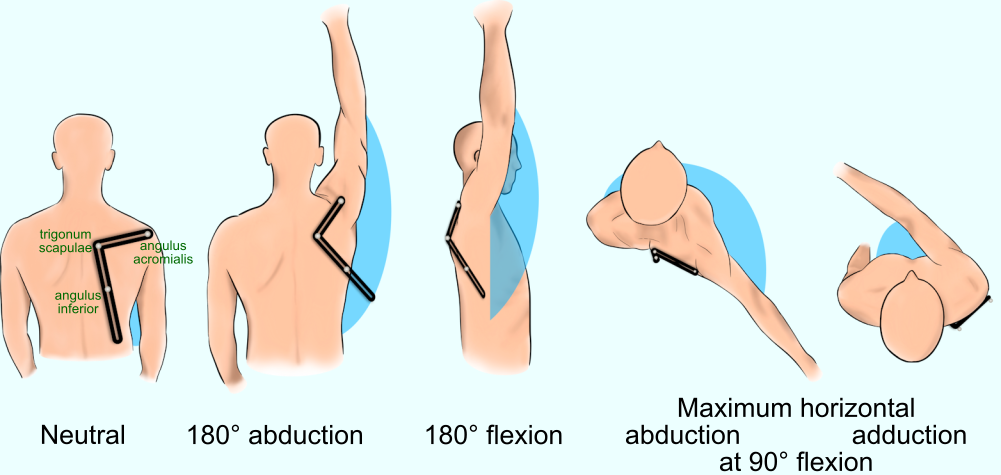
*    the .xml scale settings file
*    the neutral pose scaling .trc file. The one we provide on SimTK is a merged file in which we added the palpated scapula from the static calibration trial for the left shoulder in anatomical pose to the static calibration trial for the right shoulder in anatomical pose.

In [ ]:
# @title Input values { display-mode: "form" }
# @markdown Please enter the names of your uploaded files, the marker names in your trials, and further parameters in the following input prompts. Then run the cell.

# @markdown If you are using the example data, you do not have to change anything here and can run this cell as is.

# data folder
# @markdown Folder all files are uploaded to
folder_data = 'mobilize-tutorials-data/shoulderModelPersonalizationData'  # @param {type:"string"}

# input model
folder_model_input = folder_data
# @markdown Filename of the unscaled .osim model
filename_model_input = "model.osim" # @param {type:"string"}
path_model_input = os.path.join(folder_model_input, filename_model_input)

# scaled model
folder_model_output = ""
# @markdown Filename to save the scaled .osim model to
filename_model_scaled = 'model_scaled.osim' # @param {type:"string"}
path_model_scaled = os.path.join(folder_model_output, filename_model_scaled)

# personalized model
folder_model_personalized = ""
# @markdown Filename to save the scaled .osim model to
filename_model_personalized = 'model_scaled_personalized.osim' # @param {type:"string"}
path_model_personalized = os.path.join(folder_model_personalized, filename_model_personalized)
model_personalized_name = 'personalized_model'

# @markdown Filename to save  the personalized model with independent clavicle elevation to
filename_model_personalized_clavicle = 'model_scaled_personalized_clavicle.osim' # @param {type:"string"}
path_model_personalized_clavicle = os.path.join(folder_model_personalized, filename_model_personalized_clavicle)

# scale setup
folder_scale_setup = folder_data
# @markdown Filename of the scale setup .xml file
filename_scale_setup = "scale_settings.xml" # @param {type:"string"}
path_scale_setup_in = os.path.join(folder_scale_setup, filename_scale_setup)

# scaling file
folder_trc = folder_data
# @markdown Filename of the .trc file used for scaling
filename_scalingfile = 'scalingfile.trc' # @param {type:"string"}
path_scalingfile = os.path.join(folder_trc, filename_scalingfile)

# @markdown Time range used for scaling
time_range_start = 0.2 # @param {type:"number"}
time_range_end = 0.21 # @param {type:"number"}
time_range = [time_range_start, time_range_end]

# calibration files used for ghr estimation
# @markdown Filenames of calibration measurements with palpated scapula (used for glenhumeral joint center computation and shoulder rhythm personalization)
filenames_calibration_right_abd0 = 'right_neutral.trc' # @param {type:"string"}
filenames_calibration_right_abd180 = 'right_abd_180.trc' # @param {type:"string"}
filenames_calibration_right_flex180 = 'right_flex_180.trc' # @param {type:"string"}
filenames_calibration_right_horiz_abd = 'right_horiz_abd.trc' # @param {type:"string"}
filenames_calibration_right_horiz_add = 'right_horiz_add.trc' # @param {type:"string"}

filenames_calibration_right = [filenames_calibration_right_abd0,
                              filenames_calibration_right_abd180,
                              filenames_calibration_right_flex180,
                              filenames_calibration_right_horiz_abd,
                              filenames_calibration_right_horiz_add]

filenames_calibration_left_abd0 = 'left_neutral.trc' # @param {type:"string"}
filenames_calibration_left_abd180 = 'left_abd_180.trc' # @param {type:"string"}
filenames_calibration_left_flex180 = 'left_flex_180.trc' # @param {type:"string"}
filenames_calibration_left_horiz_abd = 'left_horiz_abd.trc' # @param {type:"string"}
filenames_calibration_left_horiz_add = 'left_horiz_add.trc' # @param {type:"string"}

filenames_calibration_left = [filenames_calibration_left_abd0,
                              filenames_calibration_left_abd180,
                              filenames_calibration_left_flex180,
                              filenames_calibration_left_horiz_abd,
                              filenames_calibration_left_horiz_add]

# marker names
# @markdown Marker names used in .trc files

# @markdown ![markers_with_names_scaling_final_background.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAu4AAAIjCAYAAABca56gAAAACXBIWXMAAAjTAAAI0wHpJvEmAAAAGXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAIABJREFUeJzsfXfAHVWZ/vOeuV9J7ySkFxIIBKSEDiJFQhNERAUEUVBWUNm1ALqufWVdLKwLuK7LritIEZUmSBFBikAgEAgkhBZKSC9fytfunTnn98dp7zkzXxIwhf3lPHpz7505M3PmJjznmed9z3tIKYWEhP+LIKJxWZbtS0S7K6WmARgEoD8AKKWaiGgFgMVEtExK+VKWZU81Go1nlVKd27TjCQkJCQmbDCLqC6CpYldDKbV+a/cnIWFbgpYrdeK27kRCwqZg5sMPD7j7jjvGL1q4cNDatra+ixcuHL34rbcmr1+3bsdGo9FnU85BRLJf//5vjp848Zn9Dj549mcuvPD5sRMmdG3pvickJCQkbBxzZs3qe96ZZ35q+bJl49vXrRveqNf7AKANHdPU1NReq9W6slqtu9bc3NnS1NTe1Nzc3dTU1NWnf/+2gYMHrx46dOiq0WPGrNppl11WHvfBDy4ZNGRIvpVuKSFhs4JWJMs94V2I7q4uPPHoo3jkgfvx5F//innPPY/ly5cHbcaOHYPJUyZj0qSJGN6/L4YOGojm5iYAhPaODixasgxLl6/A4qXLsGTZMryy4DV0d9eDczQ3N+Pg970PJ556Ko496SQMGjx4K95lQkJCwvYNpRRenDcPf/3LXzBn9mzMf/55PP7IIwCA1tZW9OrVK2jb1tb2N18zyzKMHjcOO02ZgilTp2Lv/fbD9AMPxJhx4/7mcyckbGkk4Z7wrsGSRYtw5+9+hz/ecjNmPvY4urq73b6W5ibsv+c0HHbAdByy33Tst9fu6Ne3N7QRowAi85n0ZwIAoT+LDAChkUu88PKrePq5uXjm+Xl46tk5eOKp2ejq0tdpamrC+448Eh87+2wcfeKJaG5u3uq/QUJCQsL/76h3d+Oh++/HHTffjLtuuw3LliwBAIzYcUccc8wxOP6YGZi+994YN3Y0AAUoqV9SgpTC+vXr0d7ejvXt67G6bTU61ndgfUcn2tvb0bZ2HTo6OtDe0YHlK1Zi+YqVWLJ0GZYsX45FixZh9eqehf8OI0Zgv4MOwpHHHIOjTzgBw3fccSv9IgkJm44k3BO2KdatXYvfX389fnvNr/DkzCcgpXT7xo8cjqMO2gdHHzQdRx6wN/r37QOq1QBRA4SNnJp34qKdABL6uxDmszCfzT7S37sbOZ54+jk88MhjePDRx/DYE0+ho7MTw3YYho+ceSZO++SnMHmXXbbyr5KQkJDw/xeklLj3jjvw21//Gn/64x+xbu1aZFmGAw48AMfNmIFjj5mBPffYHQQFyMK8cqiiAMkcShYgKb2IVwqAkS9WxZD+QxGBSEABIMqMp6N5f+XqNrz8+ht4ZcFrmDv/Jcx6+hnMmv0slq9YEfSXiPCeffbBMSeeiI+ceSbGjh+/tX6qhIQNIgn3hG2C2U8+iWt+8QvcfOONaF+v5xZlQuCAPabi2EOn4+gD98Yu40ZDECCEQCYIIquBsgzItINuSTpw2Z2AN+KcmHh3gj0L95MAKAOIUM9zPDH7Odz/8KP4y18fx+OznsIee+6F4045BS/Om4ePn3MO9tp33232uyUkJCT8X8Katjb8+uqrcfVVV+H1V19FlmU45phjcObpH8P7jzwSgwb2B1QBKrRQR5EDRQMqb4Bk7rYpI+bJCPZQuhCIAGXGBS3ajXgXAsT4X5EACT5G6PHg9YVv4aHHnsC9Dz6MPz3wEBYtXuzOLoTAIYcfjjM+9Smc8KEPoaW1dav/jgkJFkm4J2w1SClx20034d8vuwzPzZ4NQOcwHjZ9Dxx70F449uB9MGxQfwgiCGhNnREgSEAIAZEZ0S2YWFfKu+yI3p1Qj4V8zTnuOp2GCXiRMdc+Q3cjx71/eQQ33voH3Hrn3ejo6MTRxx+PS//93zF67Nht92MmJCQkvIuxpq0NP/vxj/Efl1+O9evWYeKECfjkJ87EJ888HaN2HOFcdVU0gLwBKhpA0QDyut5WGBEvC0AVmuulhE6dAbzNjrKJAwIJ4Z13Mw4QZVDGyCHH95kfI8zxigTmvPgqbrrjHtz4+1vx0suvuEsNGTYMn/nCF3Du5z6HAQMHbsVfNCFBIwn3hC0OKSVu/93v8KPvfhfz585FLctw1CH74eT3TscR++yG/n17a2EuBAQRMugwpYCCIO3EC0HaaXf567zIANvm3gWCtBnrrPB0GeGd9tCRt4LeuPUm5WbZytW47Mr/ws//9zpkTU341g9+gDPOPRdEGyx4kJCQkLDdoKuzEz/7yU9w5Q9/iLbVq7Hne/bA1y/6Ik4+/hgIpUzKSw7kDaiiASrqUEUdaBjhLnOfKmPy2rVYNy8L+9nRL0+bhOFzs92ZNlnA807Im8/cxFF2XKg1Ydbcl3H19b/DNTf+Fu3t7QCAfv3741Pnn48LvvxlDB4yZMv/sAkJBkm4J2wxKKVwx80347JvfwsvPD8Xw4cOwWnvPwinHnkARg8fglqthizLkGUZhBCoEblsFwK0iBdARpm23p1oBwDmtoMAUoCK02cQpcPYc5gceUvUkdviBX6UE28+v75oCc794tdx/yOP4bgTjscV1/4affr23RY/cUJCQsK7Bnfffju+duGFeH3BAuw/fW98/YtfwPFHHaYFeJF7V90567kR6yZNRprcdcXEOstj35hFEqS6g38hvS8YC5hRYwW9yIwRo113Z96IGihrxurOOv77ptvx01/8Em+8+SYAYNDgwbj429/G2X/3d6jVapvrp0xI6BFJuCdsEcyfOxeXXHAB/vrQQxgxbAjOOeF9+PD7pqNfr1Y0NTehqbnFiXYSAhmR1s/QOloQuRdlmRbmVpwDXqArs91RdTRZFQhFOXPQPYFn4Xbr0JTaeqJXELjyf2/Axd/7IXaeshOuueVWjBg/YSv9ugkJCQnvHix84w1cdMEFuOcPf8Do0aPwo29+FaeecDSoqHuBntdBRSMU60r5NJh4sqml9CrBrsxGrtRV9G52KJ35rnPeeTPnxm/MrDHfsxpQawZqrahThv+64RZ8//IrsWixrogzddo0XHbVVTjg0EM398+bkBAgCfeEzYo8z3H5t7+Jyy/7EWpZhk+ffBQ+MeMgtGQCtVoNLS3NaG5pRq3W5Jx2J9KhU2S0uU4QgrT7IWw+u4zCovyfLmdtgYDRieBSX4LJqzxlJhLssTPDBbzLi8zwyKxn8eHP/D2ypibccNfdmDpt2tb4mRMSEhLeFbjp2mtx8ec+h3p3N750/qfxtc+dg95NGdDogmrUgbxb57DLXIv2uCIMgE1y1VXcnnO+xYY9eX1EmFLjnPhgbhQhEO3mRaIGVWsCmlqA5l7oKgg//sWv8P2f/Ds6OjohhMDnL7oIl3znO2hqqlroNSHhb0cS7gmbBQTg1Wdm4byzzsYzz8/D+6bvjovPPAkjB/UFqQIZEVpamtHS0gtNzU3IahmEyJizDmSkhbow70TkNHNA1DaHseqfbpD3aEidyKTRRMK9lAvPSRpwE1eDvHgfUtWvGhYsXIITzr4AK9rW4Ma77sbue+21RX/rhISEhG2NttWr8aXzzsOtN92EA/ffF7/6tx9gp9EjtGDPu4B6F5A3AFkH8hxQCgrSB0gZVQcmuUXkqiszBpDZ50W4HwfiESE24n1WpTD7vYhXbq6SHxeIWMqMGQMoa4LKMlBNi3c09cKCxcvxhX/8Nv5w170AgD2nT8d/XncdJk6e/M5/4ISEHpCEe8Jmwf3X/wqfOf/z6OjswpfPPBmnH3UAVF4HKQlBhKamGpqbW9Dc3IKmphpEVtMlHoUAQZlUGS/YhSBTsgvwuY4GjmBVZNpYka5YG3dQODJYMi458RTuEzBtTOUBJ9itgNd15RevXIWjPvYZLF21Gr+56268Z599NvMvnJCQkPDuwNw5c3DWySfjrTfewDe/8ve45PxPIZMNoNEFNLqBRjdU0a0FuyxgObxSpCtoNQ3ASmyr2TWkb6hKB8JuVNbXAQBlUmSop2GBue5GyJPNhXemTbVwd69aDchagOZWUJMW8Nfeegc++8WLsX59OwYOGoRf3XwzDjrssL/9B09IYEjCPeFvxi/+9VJ84+vfwNCBA3D5l8/BtHEjoPIGICUEAbVahubmJjQ3taCpqRlZreYqxWTC5LaTgIAW64KEMcQtKcvwgky36/e38U+YC/pYrPNyksHkVlaBRhBANSCz301dedGERctX4cjTPo22dR34w8MPY/ykSe/k50xISEh41+LmG2/Eheecg1E7jsB1P/sJpu862aTFdHnhbss5Kl++cYMpME5/h+kwXtOHqTWqJOBjVCXAx/vIVwRzJo6tBU9uvwKZUpKs0ozJi6esyafONLWCmlox/43F+Og5n8Uzc55Hc0sLfnr11fjwGWds9HdNSNhUiG3dgYT/2/jZDy7F17/2TxgycAB++a0Lscf4kSY8Wmgn3eS212o1iCwzwlzznjXUCTq/XfMjgTLmtIOXAjMX5Ry+oXQZ/r3yJfXEKFkARRGs1qe3S//dTqgqckDa91wfZ7aNHDoYd/7vVYAs8LFjj8WKZcu2xE+ekJCQsE1w+aWX4jOnnYaD9t0Hj9/xG0zfZSJQb4eqtwPdHSY9xgh3JUFK6boCpTPx8o7+XUX77GJLZmtUEVIClaLdnsN+jie/+oHE+ZZmPFAmKuAWebLpObw/SprTFLqMZV4HNbpA9Q6o7g5MGTMCj951Kz724ZNR7+7GZ888E//785+/0588IaGE5LgnvGP88mdX4eLPfwEjhg3Gtd/5InYc1BuyuwvSlPTKMmFSZJrR1FRDJppQq2UQmUBNEDISbBKqQCYES48BPKFbx52Ct4077lFo1Rkt0TASuC7chY9SaeLyYSLTlQaIfc6a8NCsZzHj9POw+9574ZY/34/mlpZ39PsmJCQkvBuglMK3L74YV1x2GT5z1um44p//CTXVADmnvRvI675aDONez7YqeCtPLlVBXkuUPMN4vge+jwx2ZerIKMignozPjbdjje4hUcz9Nu/drsBqzmKr0LhxwURds2ZQrRloaoVqboUUzTjvK/+Iq391HYQQ+Pl11+Hkj370Hfz6CQkhsou+9a1vbetOJPzfw8P334/PnnkmmpuacMOlF2Hs0H4o6l2QRQFlctZrtQzNTU1oqtUgMoEs0+K8ZtJhBOnV7YTJdReBaIcX7YH4jlT7O0mX8SdDeRBQnsxL5cnCMG7QWZMrCQDjRo3EwIED8d/X3ojO9nYcPmPGO+hbQkJCwraHUgpfPO88XH3FFfjJ976Jf77o8xB5F9DoNC8m2lUBAM5l1wxpuDIQ7Jw/y9zt9pbEun0gUMHWqjQce22yXG79Gc7lLrILkJ01a/mf63oCSNn4sJ3SGot/M3GW9DUFET5w7AwsX92GmbOext233YZ9DzoI4yZOrPydExI2FSlVJuFtY+2aNfjCJ89Gnhf4zvlnYtKOgyEbdZ02ohQESLvtNb+4Ukb6JYReapqMW+FqtgtLvZbuw5xGBCHNyEkPyL0iJYa3C7ZH5+SLf8QvmBX83Kvwy3HbpbmVT7W54KxTcdKMI/Dzn/4U991552b/O0hISEjYGvj2xRfjml/8Apd+4xL8/adONykxJi2mbvLai7rhSVR6IZ5veRuWuuLaaFCU0gLoB4gNGTSqp2/BMRS2YeOKUn6bCgwju02n1rh+8EWiTFqQkoVOFW10Q+XdQN6NK77/LXzk5BNRr9fx6dNOw+K33urxHhISNgUpVSbhbePiCy7AL3/+c3zoyIPxowvPQnf7OjS6uyFlAYCQZbqKTEtTM2pNNdSymnbbsww1kRnxblz3jNVr55VfXO5j4QKeVWkuSjHirzLQDQLnx4ZMo+ozbqKSm5gap85UpM1kmZmsytNlakDWjFXrOrDnjI9AEuHPs5/BkKFD//YfPyEhIWEr4cof/hDf/MpX8MPvfgNfOud0oN4J1DugGt2uPrueE6TLPAZxyJ5SW3jJmB7kRyhLTL65yT/nV6mOmdqSkZtwg8F4IgzV8xRJ7W0qW6jA+u3Cjgs6hcbVeDfFCiirAVmrXrCpqRnruwsccMzJeP6F+Tjk8MNx8333sfEmIeHtITnuCW8LL86bh2uvvhqD+vfDN889FUV3J4q8AWXclkwYtz2rOaGuK8gIXS2G1WoXwk5Q5S47mGg3FGzcEG3KGBJnE4fcxCaX1eL3WXdEOyVk3v3AwH3+YKCJnflghT/mzBcFoMxEVcknuuYY3L8Pfvqdr2LJkqX43pf+YQv/zSQkJCRsPjx43334ziWX4JJ/+AK+dO7HgXoXVL0Dqm5TZOpOtIf57DyiGUU2oXyaCnsL/HV+LHO4mcXiPmnP2/K92RsFazcIlnbDHxD0u10oyu6WvJOuvX1IUMZ1t+OGskUN8hx9Wmu45Vf/iYEDBuDh++/H9b/85SZ2MCGhjCTcE94WfvTd7yLPc3z1k6dgQK8airwBWUgzp0i757VMp8hkWWZy2IXLabeLLZFx2ckX3tUXYA66d1jC/Eil4KoVKKUY6XsCJxUaO/bYGBsLvwbHBqK9gEujkaYCDf9s0mk+ePRh+NBx78cN19+Ip5944u3+3AkJCQlbHcuWLMF5Z5yB9733YHzvK5+DqncA9XbtuDe6QXnOOHBjLrsxZYh9V2EbZ90o5eqp6x3KTSf1Z/bmDc86t+bLhp3ssj/fUzt9Fs33fnqThFKSZWtaoa/5XzHh7quWafE+aexI/Ms3LgYAfPuii9C2evUG+pmQ0DOScE/YZLy+YAFu/93vMHncaJx21P7I63XkeW4EttKiPBNeuAtTKYbs5FPvuOsX2L9AO5PffAYAIijFahIoL9qlUpA2p9IdRboWfOD+hAiINd7u3uOHCFbVxpJxQMysbKR7959//I0vobWlGd+48AtImWkJCQnvdlx47rlortVw/c8uR1bUQfVOVuoxd260n4AKcAvd6XLF4p8u2lmW9bY5Eflc86gBBa3t44Biol9v3TDHVowKTJTbjivTb24YEe+XUoDUL3LlIc05XDPr2ktXUvjc007B/vvshZUrVuCqH/1oA/1MSOgZSbgnbDKu/5//QVEU+IePHQeVF5B5AVVI53JkmXHbWXqME+1WrAst2AmK5ZADPrzq4fMZAZA9jlDVys/03zDspNjyyqrM4Q8uwEW8nYxEzFVhaTSFcdojMT96+DB88TOfwMyZT+CWG27YhF4mJCQkbBvcetNN+NOdd+J/r/wxhvXrZdJjdF475Q0faeTC1qhxV/fcpcQoEx0tO93xFmfbuHHBetrkPulvVVNXUe3UuF0yOirujiqdwKf9sFQg/0Tixivt70iz325X/nrm/kkWEJC46gffQZZl+M+f/hQrV6zoudMJCT0gCfeETYJSCr+77jpMGDMSJx6yF4o8RyELnysuyLjsvpIMF+0uRQZGZBOT2rGIdiQfOfDwdO+PNikz8CkzGwuVxtK/hxuGD+DyLrCKN1y023eXKmMcd5M+8+XPnIXhw4bg3y79fnLdExIS3pVoX78eX7vwQpzx0Q/jiP33BuqdoO4OXfJRNkzEMk4fsVCIuZFtMWyq+ddGXXsS25rdhfukmwnwMSGyfSpho8Ew4npj3O9ddjZnqtRHY+KQOb/yaTX6UDunyj67sDx9qbDXblPw0ZM/gPXr1qWFmRLeEZJwT9gkzHzkEbzx2mv45LGHAoVEnuc6tx06J1HXaM9cmoxwue3kJqW6GfuctM1iGwEYURLxf6LCuTHee9GLZHgaN9QcxnD9+bhb1EPOu4+OcnEOnzoDOHIP0mkC8c4mqqocfXu34EvnnY15c+fhz3fd9bZ++4SEhIStgat+/GPUu7vwo29eAmp06QoyeRcgc5C0Ypzzpgr41M47smB1uSqh/ZGygaNcUJRX9fJnpejMbupqdDEi/ahgt23YM1FRP41JxF12v5mNB3YMCHaaKIOEMm6/X4VV4qILzgUR4b+vugqNRmNDnUpIKCEJ94RNwu+u+zV6tbbg1CP2R17kkLIw+XuAEOTy2bMsCyrHkMtrh5uISlawA14UBwiSZJxYp1j4+6x2R9iMNtmZ+Knt9nJo1F/TxkXLezyk325Fvctn5BNVfdrMeaefgh2GDsGVl/1rD79yQkJCwraBzbv+py9diGED+kA1OqAanUDeAEnJ0mD4ZFT/weams5hk2AQIo6uKGTMkbLjUNLOc7wYMeAHPX8KlUfb8iGAy4W0J33KvgramQwiiq6gap/QY4IrlEPvCRL6rcuPMHYX37DIZRx3+PixZtAj33313D31JSKhGEu4Jm4R777gDR+//Hgzo3QtFnkNKU0lGQK+KKiKnXQhdUQZwK9IRweW6B3Ckyzew2u6wRC4MAevPRGTq65qwqiLH8WTahlyroCCgSJS8laArtnWQshO5LRDwBO0J2eXCy7jqTIE+rc04/xMfxSMPPoQ5Tz+9KT97QkJCwlbB1VdcgX59++KzZ37UuO1dpk67hJLeWXcpMtFEfs62XEJXMq0T6SZK6mqmW3HtBTux8YC4iHepM/Y4MuZNnIJjE1niMSaGHTwqHjlMOmZ4ZBgtDtx8xT12Nh+AjRP/8NlzAAC/T/OeEt4mknBP2Cjmz52LRW8twkmH7oO80LntUhoSJ+iVUc0CSyIq/+jcduaWV00MdeLbLXKUse9RbqPi5yGzEquIzmGXnw4uwt6r+gDn2qugnYqOBbwDQyYJkud2SldxgDvuUAU+eepJyLIMv7nmmrf5t5CQkJCwZdDZ0YH/vuoq/NMXP4+WTAGNLlBu67Rr21g50a5ClVqq0GXaVLrUgCIj1F16i42achediXiyC37obWFlMvaKTJ5wnPFzoirB0nD87ZiHCn3SUPZHp1E97LOPHj4G7MeI9x9yAIYOHYq7brsN3V1d1f1KSKhAEu4JG8VDd/0RvVqaccTeu6IockipyzECevKpXmQpiyai6smoelVURrals0c5Ls71QCDOLaG7XHkYL4aRs38mMLnv9nwll38DiY4KbBApeyx+sFFsc5zzadNmzKRVV+e9wKjhQzDjsINxyw03IM/zDfzqCQkJCVsHN994I5SUOPtjHwLldai8DlVot91yWkh3bG5PxKc2wlpRqMXwa6CT3SlLLxtRNSmRlvgVHxOCCwMlSVMyieJj2BgDaMPHh21NEx5LiLg+OKsK+kWAGwv8ok7+gaZGCiefqCepPvrQQ0hI2FQk4Z6wUfzlvvswfeokNGcZZCG1264USMDltWdZhsxMRNWrosaOSA8nJziXXQpN1MHLN4KjR+7IMIL1y3HYpuQyLvmEqsoJShFZ6yuL4Fz69DY0TPF4xUKh5otNleG577LAOR87GcuWLcNDf/7zRn75hISEhC2PG375S5xzxsfQmgEoGvolC5/6x912CyWDPHYjTU0miN4TV9BSLnqpBa5yaTLxC57Dg0it0CI+ENssGmve+RV7BPnddnywteDt2ex9UXCd8ByBaLefWVNlkzZtWUwr3mWOU086HgBw/z339NzPhIQISbgnbBBKKTwxcyYOnDYZhSxQSAkl9aQcQeRqtmekc9pJaJdduHeWm1giPi28tbsC/9kJbuOwCDDyzkBsHxfcgauurMuuEI831eUizUIhzuWx/eH+EP9syZmlyHDyDlbPCyetHnf4Qdhh6BDcesP1m/4XkZCQkLAF8PqCBXj8kUfw6bM+BuQ5VF4Hihwk7WJCLOWFmxLgPkfkygOG92PhzER7wN88PYaCdoE9z0S6goSfbMq6xz+VazmGfTEc7vPofVqmZvP4YcDvcz8F30/GQLL0Hwt6wJSK1AcefuB0DBgwIJk4CW8LSbgnbBAvz5+P1avbcNDuk3UlGWnCfoRglVQyKTGChBbs5jOf8R9lCTqSU2SpU4CQ6dQaJ+rDcl760IjMgYigw0mpcUpNNQw9K+gcejf5lO13uez8mmyAYd3R+5lwl/7VlAnMOOwg3H/vn1JN94SEhG2KO2+5Bfvuszd2GjsqWPXZrfrpPAqeyOLBOYzntytlU2Z8vDNkYc+d7n9OtIuwdYm+lRkjFBPPft/bQ8jddj4WsW2R9jbDVxThjYYAt6mipDCZh5+aynHgAftj3pw56OrsfJv9TthekYR7wgbx1MyZaGluwnt2GgtZFJBKlwXTbruZkGpSYwSBrZAKLeYBJt5dXNLATyqyefB2PyfwkuaOF0eCdclZzqFdtc86JBsSyNZ1iSbPuj4F25l4r4rI9pg+Yxdj0ukyRx28P5YsXowX583ruV8JCQkJWxj33n47Tjj6CL3mhMyBogDJAmWRrtifZkvAdzatxn+PaVe5yi8oRUwtKFbApeuw8/N+qfL1o1Br6fhAiVc1iZvzYcccFnhGyjfg5TODpahYKhGKAgfuuw8ajQbmzJ69gYsnJHgk4Z6wQcye+Tj22XUymjOBQpmyYNBpMDVhV0gVzi2xqTJ2m2Y2FQrnwMoAdClHr8eDCadAQIYOiillu4qffS5QipkcZYcocN/dGEFQlWHVKD3GbiP2NRh4XCdc39xL+rSZow7ZF0SEB++7r+KaCQkJCVseXZ2deOyRR3DC0UdBqcLltitbcxzcbQdcnrZD7FhETjmiAKk9I8HxOpnT22lDPs28ynFn11aI+mIb9mDSVLblDwlVY0DZSg9SY+yp4wmz0WlIKSg3V8CPCQoKB+67FwBg3pw51f1OSIiQhHvCBjHr8ccxbfwoFIWEKrQAF4K0056xxZX4uxHxXDSXa7fr75J/t+RpjuoxvcVtNy1dxkq43Waobxw2tYalwQQLdXBXhgVC+QQpLuKDPsILd/i0meGDB2GPqVPwyAMPbFIPExISEjY3nn7iCfTu1Qu7T51sUmR0RNAK4jBFXQUblIpFO6AZPXa9PajEn8yXUW4PSyuJTsNL7/IIK9vmDRt+4Xj8iT9bx93vMGdj149HEztGcM4vrSvrtpGtMONcKj0+HbDn7hBC4OVIXphjAAAgAElEQVT585GQsClIwj2hRzQaDcx97jmMHz4YUkmWJqMnowpX5lEAJk3GrpaqUUGeTOwqisKiFHCo327OVTbEObEbUmR5mPZ/paOqBoQ4JSdwZyqcH94ZPvE26KMKX0GVmQKH7b8Pnk/h0YSEhG2EJx59FPvstQdIKb06qllvgjvu4UJLdlOVaOfbQt41cVqfJlPe6WyRIGfepJbEcjo8lJVZZOfZYK5NYLTEOY/2aL/4k+23uwL54ykYtMyDhfWUTLSZRwbszC3bp369e2P0qFF4+cUX418mIaESSbgn9Ig3FixAo5Fj4shhkFILd1ubPcsy5q4bp10nuTN3w9f4VXyCDrNXeF675Tu7wTr2upwWZ3wmyJUqkzLgQp7OvamA7Yo+F3eJ+GRWYn3mnytQeurgF7Jkbn8Hid0mT8Cbb7yBNW1t1edLSEhI2IJ4Yc4c7L3H7iBlRDtk2e22JLrBifQSSpGht1hWsAmcVTqfoncAcHOUuHfjeb88IVafIBDXCtVUXZEqWfElNGNUtNeem8JexjXgfXPFUjh9fNdeYNLECVj81lsVnU1IKCMJ94Qe8fpL2gEYv+NQSFtdwExK1bntZKrJeL0uiJxDowlcOWGv4RJh/PgQGR56bSMyY4UnauJtgA0MJBRmzaCcdlNaPptsfmNFSLWqlGWVSHdEb7eLULRD6dVUjeu++84ToZRKE1QTEhK2CebPnYspkyYCUmpXWJpJ9HBxUcez3E8Pig1AwVbhIlIgkqy6TBThtGOBLQBgmznjxn6o5nbb3mv92ElnK5SGTlDQplRowN1T5Jy7C0cRVbbbB5FtGxW09UWFNfdT/JsSYfLE8Vi2ZEnlPSckxEjCPaFHvDJvLlqbm7DjkIG6djsBxEU7uUAiE8IwFV2kq+HLywBzIcyFuI8tWsOHeyc8V9268CiJaV6KLIi/uvPFbUMX3xJ+ObXeEC1V/OfCy5cpOzErdqvYOWAryyjsutN4CCHwwnPPlc+bkJCQsIXx6iuvYMQOw8Dn38S55eH60TrNQ6mgAaxot65yYJ4HaSYs+uqiqaxtbMnz68Tc7vrBXZoq+74nqOg96Ig/h7k//ysomDxPvZvPdbLRBWcugRlZVrzrHWSMMEXA5J0mYcWyZak8cMImIQn3hB7xyssvY/TwIQAjaiF4bjtZs1pXkhHCONdRFZmAGJ2SNhQXDhJhrWAZprooRnrVVgoc2UcJ8fzBQn+HHqjIuvvmYYKqaDweBCj6TMyVD0k8HBvMgGVSZfr2asGEsaOxZNGiintJSEhI2HLo7OjAurVrtXA3UUBiotIijm5yN902UEoaYcpdZwrOUZLSzNSwSS7ehzbCNrxoZMTbvZJt2YAYr4JiXO0t8vAcJSfHinZCmMLp78Z3VrlT+bNItk/PERs3diyKokB3V9em9Tthu0YS7gk94pWXXsbgfn1MCUhd51zEAhh+VVQbDrR12R0xVYpzT9P2PEEb+Jn4ka/uSY+l0djFPkLPhvn0JSdDsTc/yChLxgF4WBWOtIOqMuENojwIRPuVdt3HjRyB5SlEmpCQsJWxbOlSAMCA/v0MpUooJ4K96KyWwMwkcTxvFtyzaY72+MoTeBPD+jEqMG6iduYzZ/eezSGgynF341bgBvm2gblfOiWFZS0VX3jJjwP652APIcr2UxtROk/fnsIvPjhw4AAAQHt7e6nfCQkxknBP6BGLFy7EwL69HUF6l518qozJWRTssyVGxbkd5t2yna29Dj1YKON+a+hJrYLr/cCJRwXLwo8FIE2K4RGlCU1BSjvF57VmDGmR7W5kIyFYz+ZsAwu5ug5p8T5i6CCsWLJ4w+dMSEhI2MxYt3YtABt9NHXGmbGiEbrvnh/N/B0TotQy1vA4SyoJD4sMHE6IKiwjSZ60WZvI9Q9rVZbNmchkUkFuOzHRzfsSX5f1nj2MhMNAhVUUVbnh+aKu1KaxiUBA//79ASA57gmbhCTcE3rE6rY2DOrX23wLxbreYsiHCXot2M3kJiJHrmEJrJDAzVE63Moq0bgmyodSY/tGKT/J1R5pr+NINI5mxjn28UxWu9memOc7+r2+eZAhY9Nm+Hb23Q5Sxm3acdgQrFiahHtCQsLWRVdnJwAgIxMVVRTyq3XCmewOPhGgjRfH4GavZuGSGAY7LN7ojlSRaLcdiZ8eJHxNd8CmrQRXtO52DyI7TPkJI63KjBH++aKHNUGUPc4/YISZNjyuXB777LeW1lYAOhU1IWFjSP9KEiqhlELbmjUY3K+vJlMCS5PhFBbWP+dVYMwWWDGvnEMjIzGtmM41nwNStWI36qMT84wuXdqMnSilrJoP0t59sUmOCmqm+D1Kmyk1it12ex8Ufjf3N3zoIOR5Xr5uQkJCwhZEvbsbAJDnDe+0G68l9iQsSuneyrOhgIAocRzB/1k+1n/QX1yUNRDt0WGqqoCAdP62Y2cTSXCRgVJlMd6zcDSIGbzH7lPVUb6Fqui/uQl9hHkg0KU4gSzLNnDFhASNJNwTKrFu7VrkeYEBfXtpd1roiineRLapMaEA1pmOdhlrCSAqs6hMHQHlRTqzNSL+1BTMfBD/yeXJGy/fiHRrcCtO44p8JQMXLaDg3aOKZeEHEuXv1L/ZfVWiPRbz7DIKGD5kcKlUZUJCQsKWRq2pCQCwfGWbpzOlubOKkawO1vC56Zaj/Yob1vm2Dj4XsFE01PE0PPUy0e5MGNhnCy3alXNhQtlMrhdmixkQeCsXvw0ce6vxvfEUVM4h3/2gz8GAFS76p9yh7FzBA4mv5COljlI3t7QgIWFjSMI9oRKrV64EALQ2N7ttZEjQlX20xAg4xyZ2sV04kuc+VmSmUNn+hk8pkaiC3eVJlnS6jDuXGVxIwU6cspQahHMVs+ODEWQjsBV07IFV1lQQjoj2QaF3awtEVZnJhISEhC2IVpOesXLVKgBGEBMTnfZTD74CRZSntbmvAU+cZy0fsxFCU61y3B9exkn/sC2FxYHDDtk3Km20DxaubxQfGBo5FVYL648/m9fxZo+9F6XddBgTST9s6N/CzddS/lXvbkAIgX4m1z0hYUNIiiGhEm2rVwMAsozVbCefBxhWkrGuQiiLdUPLZPZI607zEl7mnQ8EtkpMRUkCR//SfA7McEOqzgSPj9fiPXC5yfYTkeMffQ76FhwMNzjxUSEYdYjt8zfa2tKU8hoTEhK2Ovr07QsAWLpiBYsW6pdnR+qhKgz5ajBmizIlILnjbBNXHBU6451FRDmCHPvQyXYOfNAfe7xgX8vOkDdqyDxcBBntrm351Nyr5yYMewgAYCfWspoxrB2Bp46GTr1+rVq9Gv36909jQcImIf0rSahEo9EAANSyDEIIZFnGFlwip0HJuMWexnyoEYqYmI7pscI1KbFmWUEbYz8sIRacg4clyfeVkTlB6H0+r4ZdI64QzwjdFhYO7BgVjhXBLVhBz/8zM4s0mYNaW5pTqkxCQsJWx7DhwwEAL72yIIoWuj/Md6r6iKhViWv1aSocfCvES6UfwVqpeAN6IFn48cRET31o0x1mRwIVHxLdSVhBhz9E8F4xI0rxo/UGO4LEtfDj6ARPu1y1ejWGDhtWcX8JCWUk4Z5QiSaT/2gdd0HkV0wV3oEHoSQ8XW13KFC8EJKlMKejufMAcJfFHBBSuFHsVrzH4l7BTkqVkEEevHZZwiCuYmXFCP4/h/Kg4Ve8M+cwbr+7v5KxHzpY7mZcWEG/tzY3o3fvXkhISEjYmug/YABae/XCvBdfBsD9C8u9TIC7fWURT+aYktvs2leGLf1bVMjAfuZeN3ftS9cIlDivLGNryvPlnaQ2buwhzLThdReUuaItLwx2BUT3q2+BOUk2L58qfo94PAMAIqxYuQpjxo2t+J0SEspIwj2hErWmmn7PMldNhswkVVuvnUghpGVlyjKyMlxB8rplRQVXt5fHW11+i35ZEW6HD5vLLhVY6JGFRQ1p6jfdMymNkA9Eu863Z9No2asqn55RthvUTJ8sESu4kYz/KqFTb912cm1bmpswaNCgjf11JCQkJGx2jBozBnPnvwTAUpLlJs6vnq+qw4sUbeJufTlq6jdFhg1PJ1FxEg0ZHmX9ItZn3sZ6/uTdfXK0m7mhIo6cKjeuKDdSaJ/FPwbEt6TNGy7tzbuK29l+svsSfixY3daGUWOScE/YNCThnlCJWqaFu2DkYlNlAJ/v7rcxODXr25odCN0YFXCuZzoJkPSlssApkU8xMluUNKK+0Ku8shAsJ1RHygS/smukx10qC7+dsIG7RXKTjLhMr5jeZJ9ijNvuHiIUkBcS/YftEP+CCQkJCVsck6ZMwYI33kRHV7c3W6AXsAOAwIZmzOa2OZFvU1E892re5MaK/aScY+1y18Fr2UTjhNtK/nxm/NGLKlkVrmBTIHVbUwmNTDTVjUtxfju7H76dV6NhKpwHkUnZ08Z9tmNDdB+mPWyfTNGElatWYfxOO5XuOSGhCkm4J1TCpsrUGwUs+dkavc4wdgREkfNhJuqomAyBmJBt+NKUf0FA2hS8GaedwqOd1pewmp1HLJWLDgC6oqUpT2leYVSYO+/+u18NlvWJPZiEDpM7WTDI2N/Jlkuz2xsKGDw05TYmJCRsfew0ZQqklHjx1deg1+TwXBdQXMBxIRlyRtcMzqS9W4DPPwy4o1mapGXH6Mr6G4vE+iIJtitGkBMAmwJju2gjnWZhqYjVvaESX9NuZxVvgmwXHjGwJr87uS/SwH8z90uRLpgMMi9jjK1c3YZddtsNCQmbgiTcEypRM2Uguxu5d8ytCDY0JOxkVeao88moJecZTHhX5k+yVVMrDIxyLVz/XZocGrtst81ttM1t+gy/qnJujHeN7I3a0l38+hUmkNtJ9p7sUwMJf+t2UDFt7Kp8IIGGaEH/lCqTkJCwDbDbe94DAHj6uXnGYRaMn2wrQ2KcrCMd711nvgKp535V+tMwrjKf+FyniGdd+WGbihhV9aKgwABQipqSj9L6ZhJB2g13icj3Wfs7zNFn/XddDQYx3U6pcMDQ7cx5iaCEFe/62ouXLMXUadOQkLApSMI9oRJDhg4FADTyHJrOCUTC5LsbCnS57/xI7phX2BWumfLvnOSs8OWkZ4V5cBXzkKAYSXKBbE8WkXz84OBXeo1TZCpCqKUBwrdTwSHEnhZ4n4hlBGnh3q2AQUOGxidNSEhI2OLYa999AQBPzH5OsxORSSOMxa/+w7vp3JUgY24Lx4aRxPWnCI7ivGlLPcYEayQ3E9NhMQS/30d97Twlew92pdXgkYH1KBp/zB1orq7uj7mo/ipVaX9YzID96SIGNjqgx4aVq1Zj7IQJSEjYFCThnlCJPn37ol/fPqjnhSEbQ3V2BVXSEzs9ieq0E+9gc1IUbntIoAx2Jn7kUrA1KkwzKrWXbkKqP7dU0g02CM9oDrdkbhYMcf2KXXf4kvJuWe0YzI0pncfushN23Q8JCEJXI8fQHVKOe0JCwtbHTjvvjL79+mHm7Gc1L0VOMJe61nXn/oR3qgk+S52V2tUnZcLfI2BJE71VoQtUQpW1EgRiA87n5osX7z7VJhby/DrsMSO4UNzO95330BeFZOOZibL6MUAL+e56A2PGjUs13BM2GelfSkKPGDF0MBp5AQCBSNcTVo1IJ7aSKnsPVleFSVOJBoMqOMplbnpAzJBB8Rl3nJ0kpSSUkqjif5/+Yh0Z6y71IMd5Oo8KstNtA/NSsPn5boERJ/Jt5RnS+YzGdbEkvqZtLYYl4Z6QkLANIITAAYceijnzXkRXo9BOsBCM23Q7LmTL5QgY/5ONhkbiWRnrgpVRDAO1JoKrepT2JVDcIvhAUUt9PjtOuFElKKQQXtnfl9nifgvfSmt5FUZcbRvb3ixuFYp7/+2VBa9h+gEH9HifCQkxknBP6BEjdtwRHV3dyChcPRUwNEQmz52EEcCRG0GixIlVQdQ4mcamvljRzst0hScz4VWbmmLJtQeud7Xl3TTb0JHhPbF5k6HJEqXwuAYImNoty01+ux8w4B52FATaVq7ADkNTqkxCQsK2wXuPOAL1RgPPzHsRShgzQ9hSuSGHh0FMHnE1UkLx9MkeyNjxebw93sar1JTbq+gRgrg7XnLd7TZ9LrKJ+QC8y6MQHs3GKreLxYTtpNjgnu0xfj6VYuNAOXmI8PRzz+OQo44q3V9CQk9Iwj2hR4waPx5rO7pM7XbmFwR5emTnWUJY0ncpMYwT7bHwDrYl7yD8aVxxO8nVp8BY5x7BOxEZl7ua3G2b0BUiF8Z1BWCUzeuMOusuRtFGhCvjmUsoCpcIt4Ru6yZ4Mtfb16xdhyFpxbyEhIRthMPe/34AwBPPzAVIQFGmo4LCR1Rdmp/hsbBgGONGinmSudaOs33uSSzgy9K9zLs2zcSn47BdLm2FL7jHj1d+e/BcwQwZxaqV2fQf/rDC+kEqPsYxPKIfyUcHeBEGAG8sXeHmGiQkbAqScE/oEeMnTsK6jm4jyAlC6BVUAbgwKlnHHb5mbjh5qExe2iQPXXXG6+6TcoIc7nul+6IUGwzgrl/uiz83zCJMYb6mDNq5xZ+IogUA4556J6WU2WgJnVT4wGAaFSRQa21FQkJCwrbAbnvsgbHjxuGxp+cYt1077W4CP2/s+EuwTXE54LJoD8vuGjJVZWOnGnE/7PfwPe6jR2y8hCJdfxfuUF5wIbCWomHHmO0+KssuqYg77bqBvwvrRulXn8FDkGVZj3efkBAjCfeEHjFh0kSsae+AEMKJdiLlykAKa1qQF/YhQRoxbwS9XRbaLYhhjwW8oodPjfHZMWaBjjBvxbRluYd2oFGqQrDzY9mjgrJimgv/+HzR8eX8H/euuxuFkE3qTFB9zBwgKf0nmJCQsG1x3Mkn4y+PPwkfPrWudE/GB8C52JbW5cUJKDjcjgE+gloVH92QjtdCmVe28X+WzxU/TPDPLGrK78+MUSo+m+20pf9oGPB0blN7KNjuxjcr2FnFsfW5xJARO27grhMSykiqIaFHTJw0CWvbO5CJDEIIZBkhEwIi0y/YvHZG2Nax8OQdkr8T8IhJ03+0q+j5CURwrnpMq/qzxMo164NrxKg3GuxCLFwaXFxvi2u4E/Sy1uFKGwwmH96n37Dz8Ygse7CwTk+XrBq+EhISErYeTvjQh7Bw8VK8unCxdt3J83uwAB3jSsW4nbOljcT63HCTLugqeZkdpHzFXIA5JCpIpeSg6JMXzyHnE1mjJ+RyZW1wBURhVGcqcW/can/F+x12xO8j0w8KfX1lChjYggv63iSUKnD/X5/EwYcfjrbVq5Hneel+ExKqkIR7Qo8YP3EiVq1Zj0wQakKL9iwTyJz7bkR74Mx48VrKb2cpLAB31nnlGOWda3u+ONxonXlDwFIq/HnWXHfuMEVG92fm3FeD77qtvaj7g7XhAltfyw0Eznnx/SHBHgg4qZeqJABuHJQKeSORdUJCwrbF/occgnHjx+GhJ2Y7A8ISla0Q42wLG5G0f0apKTwvPc6F98FLJrVdOqG9CjeDwuPDP+0CgPZrT+66J/pwWCg78OVHA/aZ37x9IHF+TtX9m+9O67M0GaWgGnVcdeWVOHS33bDriBGYOHAgPnz00bjvrruQkLAhJOGe0CMGDx6M9s4uEEgL9ky/C0E6fSYW7WWju4RAoIOLZ58brvh3VZ0iE8zgVwqvLlpWInr+8DDn1TeZK+8fHMq98+QeVNEhS7zEb8L5/06gU1moB6XHAEBKoMihihwNEwkgJVErGiBZxJ1KSEhI2KIgInz0rE/gwZlPa76KooaxgeK2me+u5C1iC4SnxLDcbuUfCCzvBusvKZTOxa/PZif5/SqMxnLu9m1ZmiT8JNH4GSHqBjsmgvsJ2F0qexV/f7oCmXRuO/I6Vi1bjH/+7OmYf/PPsHbm7Zh99004ZN99cNYHP4jzzjgDUsr4agkJAJJwT9gQCBg5bDBWrFmr3XaRmXfuugNOmkaz6KtPaaW5pnm+kql035l7EZySOeBKE6OUEh2d3Vi1dj02hL69WvHkC69GW0Mnxk6y5XXigzAuz4V3Dx4mV9+FX2EGJRXlfAIu1UYqqKKAzBtYuWIlrrnyCpx04P7YZccdMX3CeHz9nE9g9bKlG7yfhISEhM2Jj5x1Fh58ag5b5oLKitYhFO/EP0XpM+6duJi14ELapEMqBQVZTpVhX7kodlen8tkd/7q+EnzFGQBmxez4UoHED7NpWA9iIW+isRQ+wiibaqnMSCkLoNGNgc0C08buAHStR75mJUZiHb72oUNx17U/x62/+Q1uuvZaJCRUIQn3BCxbsgRXXHYZvvvVr+JPd97pnvTz5t6YMHY0Fi5fZVx247QLUZq7pHkxos0NkD6R86r1JpfsSMGE05IrzjYoBeR5jtcWL0W/3r2iS4fif+KoHfDsK2+4fdyx1+fyE5P4PYX35YcnbxbxuwgfBGyuvF+EClq0KwkpC6xavRo3/fb3+PKFf49hfVvwbxedh8u/eC7aFi/EB997KNasWNHD75eQkJDwt6Ner+PN11/HurVrMX7SJIwYNQavLFzMqq0wYWwFcOy8R6k12oEPRb+NTYY1xKTba8+nSuZPoNbDMcNu5J8rhhztdsfi3eeqc3qv8NSNX6PMg4E/rhQFZhGEwPCRUr+gQMp8LhogSBRSQkqFvMjR6OpC3r4GB0zaEe8/4n34/fXXV/QmISEJ9+0eD917D47Ya0/MvPcuPHL3nTjjxBNx+rHHYN3atQCAsePG4eWFS1juOHQ+d+BuuARFUwaLABIlfvUZJtLUTdcJggpcj8cxUkaGUShUSomu7m4sWrEaY3YYAkAvBBWnzCgF7DRqOJ5/dWGwLXTCOSrYP6o8E7Q1+5TLf/e/Bw8NQ0lIKaFkAcgcv7nzPvRubcGvvvdl3PiDS/DBww/A0Qftif/6xgWYNmEkfvC1iyuul5CQkPC3QUqJ73/969h52DDsNX48Jg4ciAOnTsXy5ctxx/0PQ0kJxSfOU8j2ZXj1S7aMrvLHefuCO+UxeIyTzP8p2F321KPIKHPf/RbzXQG+bLBdt4NMdDR2yaOeGvp3e5UtlOB3KNcZXymNlHHY3UuCigJKSRAEKMugajUUINSLHI1GHXlXO/aeuhOefeqpit8oIQGobesOJGw7vPbii7jk/PNx0+XfxfiRQyGg8OfHnsIlP/4FPn/mGfifW27DkGFD8cpbC33M0ApYbSkjtGAsPUuvxMkLWE6lwT7oxJlw4Qu/x74pKWFn7SulkOcNdHR0YO5ri/DefXYHUQaet+iuRsCIIQOxfPVats0Lcf0QAZiVnMy2qpKSns4JoetOECxTyH4Q7jCCgpIAKR0C7uzswk+vuxV/vPI72G+3Kc6jsQ9I3z3/49j/rC/jS9//AYaklVUTEhI2I75zySW44rLLMHrkCFx09qnYZeIYtBUZfnfHvbj+9ntx/inHIBPQ5CnImOOcD+Mcc5Z+4sYIK3B5ygl38cHO4Wwdv00BiuL1Udk1zRjEGBmKRXPjK+hyj/G19Pilhza/r3SsPzugyC+aWrqSXZUVgFBMxEugsH3OQYpQEAG1FhBqQA6ovEAhJfK8gYF9WrF82TJ0tLejd58+SEjgSI77dox/vOCz+OqnT8PoIX2Rd6xH0dmOI/eeitt/8nU88+ST+O0112DYsGF4ZaHJt7aEBMDl81V9hnHceflDd9UoVBnaJQGUIhd91Q4FnGhvNBro7OpEe2cnFq9cgz0njw9Keenu8pVcCTsM6g8peZkxip4vypUM9Fjj03g8QufIue0KcI8opJi4l9pxUdp5+Y/f3I4LPnI89p+2s7kG7zth+OCBOGz6Hrj71lurf5yEhISEd4AlixbhP37yE0yZMBZ3/eRr+OSM/XHQlJE4cdooXPdP5+EzH5qB519+DdZGtmaJJkktGRRRSN0kAnp0Gt1EZn3qDYdNl5GMX02JYZ5C6a7BDg1zNF0D7uq7RZCCMcH3w90BO2+cuW6jwSUH3mwPogjmWso8cOiD+D0a/gcAoSuR1UQNJDLtvAvtvBcK6K7rogVr2tqQkBAjCfftFC+98AIWL16EQ/eYgqKzHareCdXogmp0YczQ/rjlB1/Bv//L99Fv6HAsXLYSLE4YwaaBwBNXnPvHJKkmcOlcCfPNlYEMDzTpMcES0XpCap430KjX0Wg00LulGZkQRjz3tPgSsPcuEzDv9bfC/cRWXWVdcBUJwjst3XrYXftD8IeSeKCQ6K53486HZ+LvTj2+nBEEuDlhMw7YE0889GDlvSQkJCS8Ezxw773I8xzf/NQp6NdMKOrdKOoNqCKHbHTjo0fuj6njdoSSUrvUVvyyHHYreAOmDUoi2m3Gk3aT9O1AIRHIYdLilpsqJWe+NFk1EvWRAAfA8s7tMdApKu5BhBhdG5HN6Numz7gMG25cuRSZ+KEkau+GLxOFMGMUQUAJ0muiCAFQBoUapKjhzcXLAABNTU1ISIiRhPt2ijt/exNmHLQPiu5OyLwOVTQgZAGhJEgV2HnMDvjKacfjlptvxeJVazZyNkZcFGTAsP3ssxP4+rv/FP0Z1AZTEEJ/llJCFgWKQuL1Zauw+07jAjHuF1AKOzJj/z3w8DPz2TmlDnuyHlqiLi/+oRz58ra2vQexdZriRxgFUoSb7n0YZ51wJGq1jIVbAcGcIwDYc8oEzJn9NBISEhI2F56bPRu1LMN+u4xHnhfIiwIKElIp/ZISpExaIpR2zblz7Qun9xQs1ftYFLYsyE2bUhUxq3L9mb25wZJWrN1tqV7Z1BreA35u1nfnjHv54zaDgIpUG31e36+Q8eHTYbwf7wU9RSOGmQPm5oqRLq0siACRQZHAq28sRJZlGDBoEBISYiThvp1i9szHsfuEUZB5A0rmEEo5r9yuFHrmUfujvnY1lqxsq1LjCOjLcRqFm024lJM3sRQVTuTEJomS7Y/Sg4jmOO3MF0WBRp6ju5M2kjcAACAASURBVFHHn2a9gOMP2ccypztnVXd3HjcKi1e2uTZ6MmvkuthKMNSDeAdAPIc/YHBzLyIcdPytKkAAC95agtOPO8JP+DViP77exFEjsHTp8vKNJCQkJLxDLFm0CAP69oFgJohUmn8zIl31RBVGiAJWcPLUQ5BwuwJ+c4ilrbWe4ccJ2zL4TtGx3L33W0r8TuYBwz0IsPQVNzZEkeDIzPfZ8mHCDLlO+shpYNhERRPcOGdd9rgvNo2UBIQxsgQJZCT0fAISWPDmW5g0ZUpy3BMqkYT7doplS5di1OD+UDIH7FLULBqqyUniss+egpqIKsQ4MV6VSBKTriqHOCvaB44O9CBiX8JEEr3bnqMoCvzpqXmYOmEMerU06z4bx8MvoMT6YXItx+wwGHNfeyti7bCd7XlpQSeUxbUi5qywGvP2QcU+BHECP/uko9Hc3AS/LHj1A0KtKYMs8rQQR0JCwmZDU3MzuhsNV5YWSkEohQzC8FUBVeRmTo6pm+IHBj1O8C/wkjao5uIonkdAnbUd1kcPKNCPDT1WFLbN3LjBniDcMRS97GFMlEfqXRkDRfdHMrPJdst23p9LOVM9HhvsJ+bE2wcL++Bjk3pIn4uUQkdnF1578y3svtdeG7j5hO0ZSbhvp+jo7ES/Xi1Q0CkaxlOxPjSsEJ08ejg+9YH3+QOd08zVLrzbDCBSzKwRRxQOjYmbmRTCEJqUhRHtOV5auBR3z3wOZx9v+qaqxa11tS0Bn370wfjPW+6LGwXv5eo2YXg0KF2pOKn77ca3Z+38bzNu1HB/zcDpj6CAIQP7o3NNmqCUkJCwedDS0oL1HZ1oW9+OQhawK6VqzlLIhOVcaUwHmP2+Pnsw6TOg9mhcQMSDpeQau/hdlfFDzgQJr1PFlTYtJeqQG35YZDdw+9mcqDgdRgW+uhsF2DIj7jieFqT9ervoUlTljP8U/FnDRDwICjOfnYu8KLD7nnuW7zMhAUm4b7fo7q6jV2sTMywoIDDPQwqfP/X9gfDU2+HaouQ2RMQa2CaejH1qTkiE2j3X+4UJrxZSoshz5Hkdry9Zjn++9nZc8cVPIhPkHW2KHJTSwwLQu7UF+06diEfnvBhez5QW4wJaRd9dX1no1VG7tuNdfrswP6JbPtwlvseDlyr/dNb1AdC7Vy8kvz0hIWFzYdzEiQCAl95c4lJLCLoIgIBO23Acx0uqsNx2LTSr2Nt/ddwZOxtG5dpJ+H5OUpWRU3F+e7pKO542EuENt+nrG3HtxjHP0VZM257YKCq3ctx4FRk6Xp1zmUX+tzQ1JXU0WJrxTuGRp58DgOS4J/SIJNy3UzQ3N6NR+DQV7ot7capzuUcNHah3+mwPz7PcfghIOISt+OJdbX9KLmUJypGlddqVWbiokRdYtXY9LvqP3+LyL5yBYQP76j5S5GqAC3gVfQfOmHEI7p05pyTSgx6xc9rwKWuMwEVnjx+2LKQLxyoFqEJXaOBPO2H3XB/s6q320FxKIEvLLSQkJGweTJ02DQDw5AsLUIomAo7blZSMsWxetuEuQSWadzI2NsgdzIkDVzya+Aov6vlZ9UfFOsi+B0JdhVrftlfh+e1nm19vu0Cu5KUdp/wDhR/Z2DlYdFYC0eqpdiyx455d18M/XOj5TSbqAAVBhIefeg5CCOy1777xD5iQACAJ9+0Wg4YMRXt3AdgEGYrJy1ZH8eWxYPLMbUmrkO4t4Vb/kyL3P/Pd2S22hT6fvrL0TjYAKRUajQL1Ro4vX/UbfPuckzFx5A5lJ4efOxgYykPIx2ccgntmzmHHAHCLfaiIoJWpdlAF60r5/nsDXiF27SsntbozKffwYx+A6o0Crb169XDthISEhLeHXffYAwDwxLxX2ToTxnlWyqyYqgz3Sz2PRxl5SwDMBFVtenO+V3wogE2/0fxZJZwBn/8dPDqUDI0A3HCx41Gw31+fhY6DdxVf00VcnSPF+hJXz/EuPDdhCIAisxBVlcEfjJm+N8qMH0SE9V11PPvCy5g6bRr6DxhQcZKEhCTct1sMHDIEbd3Si3Sz3QpmIu/8OrHO0zo44/sDERKe3aQCugwOIN6c9MIVzvLRpJZLiUae46YHnsDBu0/B9F0mQVCmD7f11jc4i6mMiaN2wOp1693CIK6ygfk9dKkw2zn9nS8kpZRNhbHHeCPe3rrNr9dntlUY/H9ygbvOfj6llF4oCgqFUqmyQEJCwmbD2PHjMX7iBDw1/zVd+tFsJxJGSEon4slGUMmuFmoXYIpGDYrewccVy/WhoeKd7QrujsU4387y4UOTBoxIKfwetfOVzSy/22PMYklMvCszFlF4Qt8fOywq+HGRwqv5l3DnICLntNvrzJz7MvKiwH4HH1x9/wkJSMJ9u8WosWOxYOUaR9ZARLeWibjjbqGYo+DaVYh6NunTEjjx7YqMm2GvWs55VwCKQqIoJP705Fxc8KGjdL3bHojdCXjlP4e5lq4lJo4cjtkvvQ6+O0j1qUjB8SFOS+bsUcRxuXFklIJfEbXs0EAB0op381BgJ8YqAPVGgSzLKu8zISEh4Z3imBNPwvrOLsyc+yq826AgFSBdANFE/pgYdoYEE/OOsaP0RG7U2GHC+ys8gsmd6FDEx8W/SqzvNjKjSRN50LpkkPgrwAv1Iug77xNfayQwn/jQEsxjQvC7ed7344syh+gHJR3t/euzep2R/ZNwT9gAknDfTjFpyhS8tmi5rbOowVyUgOCc7iTHQX5H0AAhtRmSUtWkHFyAld2yk3/sWfOiwOtLV2Dy6BEQQrgrlMo18lJkVf+yA/dFYfouE/HHR2friga8mwB0fr8ldD/IxLnzzolxHO6FONkHDEJYhQHlc1hXB/Di/eU3F2HMmNE9/GYJCQkJ7wwzPvABAMAdjz6jjQLJoqLKcpA2biggRjM+kGV3H6UEVInnfMTRVvfi57Esz3k8NkrAzsFbKsTjSRw3Dr0SMs8W8fjGr2eiCQom4iqCVnY6F0XHWj1ecth5dwLHXz/BOKNG6pekDPf8dRYA4MD3vhcJCT0hCfftFDvtvDOefeFFkMjAKU9x5yKwF2LRaRoERK0iPmXOO4W0xk9DjtjM1d2iSMqkjUgsXb0W/fq0lnrwduAHI31TUkk8NX8BlBLGUalyXvyg5O6R/8mEvA0CuP7ZaykbIOCCXUFysW7uXrK8+HkL3sTknSa9w7tNSEhIqMaB730vhg4bintmzkF3vaFTFA0vWgdYmkWYXNWVUIkyQwJlUjcbeSqh3mTFfBSF5OctSePYJ/fJJWWjCOY+eGTTtHaT//22oM9GsOuHDH7ZULHba3vDRvnLRD0vjR8EZ+YQAEhdS79QwOJVazH35QXYedddMWrMGCQk9IQk3LdTTJ02DbOeegZSZIAgmCk1EEQhbcbC3EI3hp2o5DeS50Mu4CMLn0rnZBNC7QQhslVaCMMG9MVDz8x3RN5o5Lj9oVm49S9PYvXa9rBsI4nA5FcKWLe+Hf91y734x59dj47OLiil8OzLb0BKLdjDJbnN5Kt4FT52LxQ7KOUYrAlScOdFueN9apEW8KTML8IGl/mvLcQuu+1WPnFCQkLC34BarYZTTj8D6zq6cP/sF7TjqySk8uaBnqhaALLhVanzYrQgd04240nPe1WL2MUONxfPsRDX24JsHdeNaPXSKjsnPI2n4qpiAaY6GZkceq39Pf9rre1iDKE5Y3tQShWKxg07TpgUUUgJpQooWUAWBR6YpctAHjFjRvleEhIYknDfTjF0hx0wZNgwvLhwGUri1DoLihNP5Lg4wc4mGMXNmcscTOK0xKg8/TImdNdS5iEiE4QRgwdgXUcnZs1fAKkUlq1swxNzX8av73kE+3/6G/jVnQ+iKMLKL1Iq1Bs5nn7hFVzww//ByrXrce7xh6KjoxNSSlzx27tx2N5T2b0RtIjX9+5rDEeqPO6rEeDc0Ylu3w8CJm9eO1qS5ZCy482muQvexH7vPQwJCQkJmxsfPessAMBtDz+t+YpN6ZGGhJRUICkBVs7Wz0kyot1xG383cCQYu+ockfNd8bnqiPJxVS2U08raUbdmlH0CMGON66cR5xHHK9MLP72LAn4v+zbuCadiO+n0GCWhZA5VFChkgUeefh4AcNRxx/VwTwkJGqlA9HaMfQ86CA/MfgG7jToYoMJQFHPHSQLI4EmuinzZu7IhxDJxE6mAK30p2zIxGyo1lxTIsgwtzc34x4+fgIuvugF/+NcvoX+fXjj/5KPQyBt4a0UbLr32Djz0zHz84ILTMWzQAEABi1esxtW3/xm9WprwvU+fgkxoh6e1pQnX3fsI5rzyJq788idd3+3kIr+KH5lyZ7ErROGLAJsAaQcxBR2Q4HNdQxHvfxt7rDQDi1QSeVFgwVtLMWG3aRv+S0xISEh4B9hj772xy6674sHZ89C2rh3DBvY3jrtJHFQKwohL7bpnxkWH5noTjeWFwEACuoSk1cSMW2P/g2z1Lm2WhGJZBO3s1phKfduydPbdivbxNBnfUdgFkaJemj7E17WnMA8xVHWUig4k/ztBpyCpQkI26lBS4rFn5+Go447DoUccUbqXhASO7KJvfetb27oTCdsGq1aswC233IaPHHkgMiWRCUImCLWMIARAQpgKLval8+HDFw/aCJZGwuDIKhT53pxRpebe+zCcr4CBfVuxzy4TsGJtB8YMH4JMEIQgDOzbB8cdsAeGDuiL//7DX/DSwiV4eeFSvPD6Wzj+oPdgv6mTUMsyNDfVIAFceu0fMHPuK7j+u59H/969/UUBQAnGzuEwwRcKUcTSfRSZwIMv+agFvzC/hdIq3t6wApTUi0qBlYSUkChkgUIqPDV/AV5b1Y4Pfvysjf9FJiQkJLwDtLe3489334Oxw4dg94ljIDKBTOiVUwWZVVSFKQIpmgBb5YrzX0/gaZcuemk43aZBuqYVRpBzv5m5E7VT4P0I+2Mz4Un51nDvOrpqv7NpVcZkomAc0LTN8vNZP4jIjwfEvpNwwt7l6Sh9HlVIQBWQ9W7Uu7uxYOkq/Ov//AaX/vSnmDR58oZ/14TtHrSitLpBwvaChW+8gemTJuGRay7Hjn1qaM4IzTVCcyZQq9WQZYSa4CvmWVErjGthRTvzP5RfbIN/tukgQejROfTwOZWa1vQ2G55VEl31Al3dDSgotLS0oJZlmmilQlEUqDf0vl4tzWhtaQFIoKu7G41GASEEak01vLlsFf7y9DwcvMcU7DphZJjqCGO8QDtAPpzqc/iDBxKW/whG1IoIJBhhC8HezXFKQRYF8kYDstAhUxChkAXyPEcjl/jxdbej76Td8XeXfPVv/WtOSEhIqMSSRYvwnrFjsdeU8fjNdz+P5loNLc1NqNUyNAlCU01HPEVWA5pagaZemt9QXqiJTIUUrU/tNnMhm4fDF0+yaStKwrvmRkw7A4V64F2AhYa9s8+hFBSx8YVf37nuppIMzJombiCwphRPnbGCXcCVwuQGjRBQZD6T0JxvjxO2f6RXpC1yqLyOro716O7qxhW3PogfXXszXli2DM3NzW/zbzFhe0PKcd+OMXrsWEyZOhUPPPcqFJHJr3ayGQB8broV7dZ1pwyA8DnqurGX5rZCgd1Ffh/AfBX+gWl8ZWKnylyruamGXq0taGlpcW4NESHLMjQ3N6Nf374Y0K8/erX2gsgEhCD0au2F/v36oV+/PujV2oIpY0fg0x88HLtOGOXTdEx6ijPTSTrnxfeGf47DqTL4TibnRfEBQvEBw7/sL6SCZjrH/cGnnseBRxy5kb/BhISEhHeOESNH4vCjj8asF17Fm8tWopAKeSEhpUKhdPqe1tMSKHJAFgAJKAhfnICEHg9Ib9OmjBbYPCe8J7ioJE+G6aF5OKrohsoRNnfUFbi+DwK7yrIugS/mZNfw0Ok7pV76a5U6xHrFnyv8DcKZXbJwryJvoGg0UCiF2x6aiSOPOSaJ9oRNQhLu2zmOPPZY3PfYU1BWhNukbMWcDifcM0fIgIAkFZCUsiRYNWufhUkdxbLUk4Dr4pREaEc7ywRqWabTd2w7a3oLghCZbqsElMpAJszLGoHXL/Mrl5IXzWAztFyvJHNcgJCdff/5RFbdjKt0XhfeRhjYO+yEVWD1uvV4c8ky7D59OhISEhK2JD5x3nlQSuGWB2ehkBKF1JVlJIBCAYUroShBqtBGh8gAUQuiscp+Frzko+XCOMVEC3bNm24L65WNclZ0OBofqMedtkRvPB4pkHXT3X471vFqNSrqg1lYL3gY8Q8o5M4P9kBgxyppnPYCkDlQNCDrdRR5gWdeWYhZz87FsSedVHGzCQllJOG+neMDp5yCBx95DG3tnQCMueIqoxix68KGlpzt0tha8EroyucFUOmU8GwsprUrmjIidGKaIKUKJ7KKKHzqjgHcwhaRw+9yyx2R+vKT5P60B5Lb6l9RqLUUMjAfXUgWfAlCf6ySmPF3X8Nby1fqUK45l6soI4F7H5uNI44+GkKk/zwTEhK2LN5//PEYOWokbnnwScgi1+K9MAsDGdddv9g6E8I47aJm3HaYnG5TSpfgxHqks0NpzXi93EoxUW/aKejoMCyXV1vzPbr8jK/1miG2ELLh+IqHCFvlq3w9Fbw7+c8qhbkdhQQK7bSrIkeRN5DndRRK4pd/eACtra14//HHV95LQkKMpAy2c+y9334YPWY07nn8GSgi4zfbOr7eXQc8GVoHXE/CEfBZ6RuHFcQbbE9a0Nq+SES1fM2ZnElSxc+mx94s8b2P3XIbR3Xi3dTyNQeawyPStot6VPQdrvfwJC71Z1VIPD5nPkYMHhTqeWXKgymFOx99Gsd9+NSef5+EhISEzYRarYaPn/tpLFi0DLNefA1FkaMoChRSp8zolzQCNAfJQpOWEHhz6XJAZCDKnKlDFBofzNowf0ZmR7Q/2EKcYVUwesTOeHgmFe6Lc9wt3ytAQXohVDUsmaHGFycgdyf6gcXcrbuGNPXvlZ6nJQtIqdOMZNGAauQoGg3khcTq9i78/s9/xZHHHot+/ftXXDwhoYwk3BNwwodPxZ2PPWvSZeDy3KWywUEyLocW8dbxcEa0ix0ScyeqYZ0LqmhQqkYTnUeZMKXfY8Op3BUPOtZjP+yIoU1yCTst1qbQlMKxVHVXFXUVynaSfjelcTo6OzFh5HBfI56nyUiF9Z2dmDX3JRxy5FE99TwhISFhs+IT5533/9g77zhJqqr9f++t6p7Ns4kNIDkKKlEBSQqioIACCgooOUcJiugrr6io/JC0gC6SlKAgKirwShREECRJkihBwuY0u7Mz011V9/fHjVXds4kh3+fj7HRXV1dV9+C5Tz3nOefQ0dHB7+96gLwoaOYZWa7b0uZ5TpZnqCJDFJm2ehQF/3z8GW6//186yxkM4lO2JU2QxPQQpfWhXEtkf1qtiB42rqs2W8PjBNtD2V70/35N5CsWl/4UfbvZLRX+89pDF6oAJfQNUF6Q5xlFlpFlDRpZRqbgylv+QU9vH1/YY4+254mIaIdI3CP4yn77cd8jjzFrQY+2plDm45awCyF5aepM8kKhC1N1MVJh5AhhSf5i1XdPwLWIUVVgRPDb/MjgsRBIKd1jvV8QrIUvmq3MuaM1sIcKjO7hLkyhrArUmfZpV/tyuDCE0bvwSo+p8po7v5u1Vl4e3wZSLxZWbb/jgcfZ/OMfp2PQoMV8hxEREREDg/ETJ7LP/vvzp78/wvTZc3TXqyyjmTVpZkaBz5oUuZ70+fSLr3DUaWez107blyi3t6j49ojlYN9qkwzb7IJEBXVI/Ukv5WisyrcDWn3C2SGDE7Y4HUvHkWbdCzKm1dWsugxUxSYrXBnbY5YXZFlBM8/J8pxms49Gs0mW5czrzTn/mhsYNXo0n9l557afMyKiHSJxj2D1tdZi86225rZHnraODq22F1Bg7DBComTCmVdez+yuBS4YhuOWfOOUNhaSNugvyekeOStMf2Q9/JGmTkr4Xjc2M1A6i1XUdXAuU3qtkJSDe6jmWwtNSOjtTUjJ9xJ8lqK0kEyZOZuJy412nvaCwivuSnHTvQ/x+T33XIJvLyIiImLgcMwpp1AoxaTrbqUwXU+azYwsa5I1tQKvFPzn9elsf/A32Gm7rajV65TqoKwWUVkDPKH3zxWYIUzhVVjRRnvPW5pVWwJujuAzpZjwa7eXbg3McWx7YlU5YGUlUoCSlE/urT9uq53bEd5guELdhIt+/xcKAZlSZJmi2czMT5NMwdm/voHZc7vY//DDGTJ0KBERS4pI3CMA2Peww7j5vn9p7cIVpxq9QQiU1HS4u7eP6XMXoIQMaK/wcW2RzkMPG8jd3o6ku3/M83IhalmBL79eUtdNBqC1NKoMEfxrt7jgro2LFZ9ldf/gE4UtySxZJziWgtemz2LE0MGu9RjOJgM9PQ3ue/xZPv2FXRd5zREREREDjRVWXJHv/ujHXHvH/dx0778o8kwXq2ZNPTBOKW5++Bm2OujbfGybT9C1sEEhk3KsDzuROVgbiXKPq6q7RgEu3xvaIAOYuOpc5kohlMlsGoG/fX40FFV8jLZu/JLAY2ucSuf2a4BbM8wubs1y/dtT/vKPR7js+lsolKDIFc2sQaPR0KS9KHj8hVeZfO0NdAwaxMFHH93uzxER0S8icY8A4DM778xzL7/GzK5u079XmWSh9y8qIRg7qpMZc7tw5UGOaIdYnFXGhr5Ah/GRP9TcPSkXVYXdTKYLA3wl0Ko2lxG2bOz3aksLQ0V4UW3StyWJvs2NQkD8X5k2g2YzB7QHslCF6ZqjuO2Bx9h2++0YNHhw6zEiIiIi3mQcctxxfGW//Thu0tUcf/6veeL5/zJ/YS93P/4sB//kMnY76cecfPqP+P7Z5/Dq9BkopItfhbH/uRohUZVN2htU9DIigCR42Ug6bcKpsi8EApPb2WlAlooXJubb7jHBsUUoICnaFl65/f2tRsteyn6IBCVTSOtMvu4vvDRlGq/OnE2eNcgbDYq8QZYXzO7q4eAfXEiW53z9lFNYbvz4fs4bEdEe6dt9ARHvDNRqNfbc80v87vb7OHy37XT7L6CwZhhTgDRt1lymz56n3ySk7ukb6BXtNIr+abxRnE16NGwbadV0paBtelME+nqFsLeSeL097BesUEjs2G3hHmmmLkvJVn8ogZ+q1ybdqjDpU1V+o0nTIiTPvjyFR5990Ss0hUAprWZd+Lu/cNavru7324qIiIh4MyGE4JyLL2Gjj23KGaeeyvV3n+O2f3yrLfm/e+9l/Y03ZmF3N69Pm0Fe6P7kMs+1Q1wpo3obJdwfmZLFMHSX+OiLn8qtKt738pHaPW4LJ7RUzh9me80KJsJ93WJmMwhtThouEFLo7jq1Opmo8bcH/8Wa63yQLfY6im/t90U+t/lHGD64xsPPvsxJk67gxdem8pGNNuLYk09e3CeIiGhBJO4RDnsfcRRf+dS2HPT5bUmkHgZklQaFYMHCBgup8dTLrxvSnqMd5YVOObqAbam8NdP4qGfjoeO/drtShqj7gK2ULTq1FF0Fr1NKy7Zwe3c243lUAn0bAtKkWwvhFX9habxNuVYPYy86vBy3lyKYwNF60+C2w1Mvv85K667PH//+MJ/bfEOT+S245tZ7WWXtdVlvgw0W8ReKiIiIeHMhhGDfQw9ln4MO4qnHH2fe3LmstuaaTFxhBbfPkKFDmTFrNnleUGQ5UuWkCqdci1Jsx9sNhdDCiBlGZ8mzE26Eo9Em/pcb+Oq9zaGwXndM2LVCj5ODKu/yxLy8XIRDl9zB2n43LZYgLGlPodYBtUHc//gzzF/QzdU33cTF553HCd//PsdXUgerr7UWV1x/PbVare15IiIWhUjcIxwmrrgSn/v8LvzhrgfZY7uPual5utuK5IeXXMOBXz+RGy6bDEIiTBtF146x1CMXrLJNEES9eC0M4Q+eu9jmC4Pssa0nPLTOhL9bSHtQIBoq7QKFElp9l9heBFplt6nS6k1FyM/b+x4D0g6GxFfzDVphf2XqTH7110v46TdP4OUpN/PpTTfgjvsf4ee/v5k/3H0PEREREe8EJEnChxYhJCzs6SXPC/I8JykKhNANhaVsJb2Kcr2Ry6I6cchEZ+VznXYfASUarkOtKX81pnZh4m+4Hihnj1FQmZTaSsDDi7XxXJTXF5skRTihyvnakxqkHVAbzC13P8BH1l+f0WPG8I3vfY/P7rYb1/zyl/z78cep1+ts+clPsu+hhzJs+PB+v9uIiEUhEveIEo477XSO3n0X1l9rZdZbbSVyJZEkXPr7v/DvV6fzrW2344qfX6BDopAocm33MJo1tFEy2nhmQm7seHGYPpV2g2gbW606vygEywReeTeCuVP3TQmrKHeYqZyt/4M79T38RGG61arxglemzWSttdekXq/zrbMncc3Fv+CIn17CChPGc80ttzJ+4sRFfp6IiIiIdwpkkjK3az5DkoKiyCERpEJRFAIpW7OWVT3EWxKdZ6ZflVxgsrJ497r+ZdX5avz120W4LbQ6KoGT6N07WoUZFRD48mcwanuSQlqD+iCoD+bmu+5h60/5ORwfWn99PnTWWUvylUZELBEicY8ooTZoEGf/+lomnXw8dzz0b1ZdcXn+eOf9LKDG5Gt/C8Cq636Y/7w+gzWXXw5UAaJwLhIPq7FY5dxuDcOrD8pQTWQGanrlceksoS/eSC9hMxd3cjc5FU+o8Rad0rU5sk1lpaEU6Ft3KCdxg4sHIfjnk8+z9Q47us17HnQwex50cNvPFREREfFOxvARw3nmxZf50CoTkSoHJRCJREhtlyxQVud2K0Ep7yp8ZjbM1rZKOj7Ol0i7fzUIy6q0vfS8eo7KomWtN+W1JpySKoLfSqtLUneRIe2AdBCzF/Ty4L8e48TTf7yYby8iYtkRu8pEtGDwiJF849yfs/ehR9C5+rqcdPpP+M0tt9I5chQAm229DTfe+7Cm3LbjTNUYrjC9S+cOwQAAIABJREFUysvHbke/w13s8KP2e5r9XWcYNyrKHEf5AF+K31Ztt+8rR+vyoCVapaG2A5bsjuHx/IJUOoEJ9vc99RKf+MyORERERLzbMbyzk2eef5G82STPMvIsI8tyPSnUToU2Kc5SX/X+Q3vwoqfordNV/eveUtmOsIde+6I1BVC5ECvt+PXACjqiumrojmZCgky02l7rQNU6uPXv95GmKZttueWiPmRExBtCJO4R7VGrM2aDzdl6z31Ze5NNSy99dMstueeRJ/Ro6yCotQbn4HUVkuoWn0lLYMRtDZ6pYM6pqu5nA3G1mEk5r2OY4nTPSouCJd6VlcUqOdUFp8VfX15MSseTCc+8MpVV116n5VNGREREvNswYsQIXvjvqzSzjEazQbOZURS6vW1R2NFyYCeYlii3m9UR/rRmbamKKm57uC1MsZpONrbXo/Kvi2oA95WsDtZGGV6TmxVi1jTXz0xKkDXnbxdpnb/9434+utmmDB4yZIm/x4iIpUUk7hFLjXq9zsQVV2barDlgVXerqrS0Yly83aU1MdomGerGslqVPUyBFtWdraNdW2FaFBtFyR9vM5/ViyhrLNhpq+1uMdqlbzHWHYTglemzWGGVVdu8LyIiIuLdh2GdI5k6cxZ51iTPcrI8J88zU7CqzCwQ5VXzQs8HcSHWBVw/c6N9ojMk6Ja0e8LtMqm2f3y7YK6gbU1UcAPQsjqJalQPssHCEvcE0jokdUhq3H3vfWz1qe0X8a1FRLxxROIesUzY/ctf5vo77kXJcD6pwJcCldX3AhNXVUsopKyGh9tVoNS3sai4IC2cLUc5FcWOiLLKiR0n1e7moRzgXeB3PSbNqiOg7VSn/uCCvOTGux9i+898ZsnfGxEREfEOxvDOTmbMmqOHyOW5tsrkOUVeaLuMGWiqybvNfIYqupdsWkWTivUytDGaB/aYZa1eBGS8fR5X7xZYctr2EhaV9SO8LvsjdWGqrEGSMmf+Ap7891NsExSmRkS8GYjEPWKZsOEnP8UdDz6uQ7HwaUgXPoXnuEoFQbKCdv5Bj/A/zzZKO34NKHkcVRDkrc3FdKixNw5O/beDnNzz4BhtlPy2A5j6axHplJmEvz7wOB/bfoe2nzIiIiLi3YYRnZ3MnDNPk/ZCd5Ypspy8yJ1dRhP3MGNqwnMg4JQcLXZbqJ6794rSOzyxBpQMXjMqvm0HaVuJhQgFJKvgV+04drMQZvkI7DZW2BESkgRkyt/vf4AhQ4ey/sYbL9H3FxGxrIjEPWKZ8ZGNN+HvjzzhgprtG2C9784qaJR4S4PbW2ZChV602WwCq59TbUi0DtBKVQNv4K1v8Z6HC4nre2Oe23/MAuAWC/NhFDgfZZvjtnjmhaCnmUGtzuChQ9t87oiIiIh3H4aPGMHMufOgUKiiQBWKPM/J81yT+KIwk1VVaxuBqq+8cuwWt2UpvlvPevhe211dP9ZJ04DeLKp1sOsuU4n1tNkWrGm6OFXorjIy4Z5772OrT34yDlWKeNMRiXvEMmOfw4/k8j/cgv7PyCjalIWSts5va39pE0z1e4MAXeoEoy0rwfgMI6ib/4xVoKhXlXkq6rl9v2sVGSgsJVUluJZFqTbhe+wDAQjJHQ88webbbtf2/BERERHvRozo7KRrQTfKWBWLIicvlJ6makl7qaGAIO83tntU1XdvXwyzmdYqE+4W2CGdvrMIwu7e2CoU+RbBAXG3CjvCLHkCRIJtC/n3f9zH5ltvvfjzRUS8QUTiHrHMGPOBlRC1Ov95dQpKyEAmManFCtNtCaHB/joUV8ZfqHKgLvseVUtwV86f47T/0vH7G2NdvsJAbW+HErFv440sPdUB/Yqb/sZ2X/jiYs4dERER8e5B58iRdHcvxNYYFapAFbm2zuS56zBTbcOrxe1KXVFpPoYK9lSBk6XcDd6yc++EscKRMK5G56Nc/Idxts7wsnQ3GWU87a6zjFsDTHGqlDQaTR586BHWXm+9Jf36IiKWGZG4Ryw7hGDfgw7ijEt+YwKt7y7Txi1YeiwIibnfxiK3KC98W886wqs6SpX+i/ZqSfC+RX8gf5GC1oyA6u+ThIcISL2AabO7mJ/B8iuttNizR0RERLxbMHLUKPKioK+Z6Q0FmqwrZSwyRnEvlCPwpWxrKSUrfHwNJXelwvl5lBV6o8Jbdd0p8oU7pDDHWDyM/aYfx2bg+6Rkm0Gr7o89+W/6+vpYe911l+BcERFvDJG4R7whbPSZnXns+Zd5/pXXcUQ6UEWscqJjtHDpTUXZ6+4UlraRs3DpTN/BxqRKlXY3+kpYgtRngVLeXdm2HRjhpDxlL8z/7hf9vRaaNwW//L972P2rX1vEcSIiIiLefRgxciQA3T19eoMy/dsL3WWmMAWrpT7u1oLi1HAWHWdN7VTrHjY/a7O11jcfrD7Ca/eLhLD52VavuxOknPUx/G0Ud+CfDz3C0GHDWGHFFRd/voiIN4hI3CPeGKRk19125ccX/6Zkj9FudMqOFtuy0T0NlBNaH7oNbvKpscM4mMCqBAVhS0r/uhCiXKTUFiHZDn6WFC2VVN4f+fs77mWHz39+KQ4WERER8c5HpyHuC/sagHW8BN1klKIwv8NmADb7qaxUbm0y7Qh8KVMa5lD9oD2X+xQAEkniztW+/W97tLo7vTVGiOqiYIi7IfIPPvwIa6+7br+zSiIiBhKRuEe8Yez6tX257ua7eOip58D4C6v8u6zC+1e1zSVUOLw67kKgzndqtd29VbraJneroEQlpWodL9Vx1yGWIdBWs6bVT2tStnc9/gLrbrQxHYMGLf05IiIiIt7BGDlqFADdvX0gJbmzwhROeafQwotWswsj3tgy0lCwabNo2NXAqOChMBO2H7bPhZLmPTbLKlsyu/3DdxcTJQYfBPuSDdJmeHW29/6HHmGtD35wCc4TEfHGEYl7xBvG8muszcc22ZCTz76EorDE26siAU2nHXkPjCp+W2ijUWGANv+649uhT8L1B/aUXbhjLTZ0ByOtF7lPFWFqtXSnIZj8u5v57K67Le7MEREREe86OMW9t6FjrDBxudDkXRUFhcqdjUVnYXUkL8X80qA7CFcCT6JVWSsJ1hL9r0TPaS1Kr+lM7eLsMt5yYwWg4MAVO0+QkjUTwxd0L+CZZ59jjbXXXsx5IiIGBpG4RwwIdttrH+579N/84Y57vZfdKS0+Ixr+lNFKrn1rR1l5VaGEKhF2J9iIqhZDQObbIUjh2sRr+W6jTRq37GNvheCpl6dw/V/uYJPNNuv3zBERERHvVgwaPJh6R53unl5NYgFQzhpjp1kXlsibQF0qUtVvIRRMhDuWCEJtOc7aSimvwhf4AlLbntjG9H5sONXj2vc7zSc06QSXaV8zx3zk8SfJ8zwS94i3DJG4RwwIttxuO9ZdY1X+54LLWbCwxwVt/aMqXLhMo8MpeaINw/YKurfcWJtMdZBHGM7NEU2byPIxrULk39l6xvZm935M8KK8/w9+cS3jx49j+IgRrR8oIiIi4j2AkSNH0t3bp9V2cFaZPLcdZUyDgGq8VjbuF9DPjA0A2zWmoqQYMcfLPdoSafYTBXY4nybYbZWiElrzv96aY9cJz/0tadc/Tzz9LKustmoUaSLeMkTiHjEgWH2ttThsr10ZNngQp19yjSlMCibmOXGlXKAKobjh+79XBe/QhqIqxNmR8MAL79OoKjhJf1D+IoKCo1bp3VyMWoSKI+DfL7zK9Xfez/GHHbCok0ZERES8q9E5ciQLreJu9RHXTED/CEfSQ0HFSiyt9piy1SWMsaE1JvTJ6zXB2mr06b3qLirrRQnOFWNuA0TlBbuCBETdxX6zTvz76edYc50PMmH55Rf7fUVEDAQicY8YEAgpGbfccnzjwD2Y/NubePSZF81AjjA1WlTqkWwwD0i4fqVlC/08X1zdkV5IWhX3luXC3l2465FmMfJTYYMo76+ltK7ofX5w6e/YfrP12Xid1RZ9cRERERHvYowcOYruhX1lI6PxuRdKGd+5Klklvb4eOt1bCbo/oMDnbMPp2PZfY840XWSCBpGlw1SLVFszrmGM95YZEb7uhB3pxJ4nnnmOcRMmLOabiogYOETiHjEgKIRk5LhxfHarj7H95hvy9TMvotnMXHcBpYoglYpTX5y1xU3Xw2yvqt3lgiMv47cLxqYAShgFxaVbw8NV7DAi/F3dx+wXei/bEHYQ/PvF17ju9n/w1c9+klqaLPpLi4iIiHgXY0RnJ808ByGQyFJmFaO2O1+7jcuUrSlKidJ6ACBCz6QI2zqWH4e2Rn3c8LZAx2TrTbe/bXbWizdVO055sbAJVk/q7ZRwvR48+cyzkbhHvKWIxD1iwKByBXnBT79+IFNmzuGSP9xCnmd+9HVhhybpAFn4KF/+bR+LgCAr6dR4rcBA//4XvRiEMz7a79tmsEdYKBWq7W39jeFzCUrxzfOuYPmxo9lpi438yO2IiIiI9yBGjBql2z4Gukdol7GzPMKOBFZLaQcX7qvCSvjYqeBlJV773j2laRF/VLk+qlw9VVHbg236eqU5pr0GTd7ndi1gxoyZjFluuSX6viIiBgKRuEcMGArTv3fksCFMOulgzvjVH3hl2gyyPNe9fW1nARM8Rbu2W/ah9ZK7+B12EGhnkVGlR06xUfY9CowXvv+i1H5QUluq2+1JFH+4437+795H+OY+u1BLJAu6Fy7Z8SMiIiLehRjR2Umu/PTpIrQbKhDGIin0kxInFoFwooSva9KRPqQmZdNLuSGBbTmcU7iKqqAwNUTYdtLE9FBtF6JqrrFGHPNxrFovExASJQSvT5sOwLjx45f8S4uIeIOIxD1iYKAUfb192ttYFGz+4bU4ZNdP8d2f/Zo8z12XAdsarGqNqZrQFQoh+us24MdbV+F1E6fPlw5vO9z0O5QjHLJROmq7/cxPIeju7uHE865gxfFj+MoOW9LMCuZ2dfVz/RERERHvfgzv7CTPcxdfRRBwQ8XbUWo3lMMT7MDQ4tX6imPRPw1tLT7SS2QlSqs2a4F5jwhfEe4IuLbDQUGq8DcHVmlXwfbps+YARMU94i1FJO4RAwKJYs6M6Yac5+RFwWG7f5o5XQv46wOPO8uMLwBVgXLiFZuyshKEa0fUVZAObSXUyirsJWLvfZFaya/0EW7L4cPXVHBHEAZ+c6xCcepFv+XlqTP5zv67IYUkLzK65kXiHhER8d7FiM5O8rwIQqgoEfaw/aNQmhqH07H1S218M6oq2oRCj31HEbxaPYZ07/IUvc16UfLLU3bmVM6qw76xTwoJMuH1aTMAGDZ8eOtniIh4kxCJe8SAQCl4ddoM3UPA9O8VSvH/jt6Hn179J3p6+8iLXBN7Z5nRqowwB6iUgpZ85UJ4JWSx45RKTd4DBV1Zm40h3/2q7uHJfRGS6zRj0sAUCpUrHn/uJS743c1stcE67LrNRylUQa5gztw55bxuRERExHsIw0eMIMsyFy5LsVnZ2dll5Tvs0lKawWT21zZHT6j9GA5tXKlQ7dKj8Nxlpb16I2D86ybWi4qv3Yozbq3ATunGrUUgmD5rNgCDhwzp9zuKiBhoROIeMSBQUjK1u2HUbHRBal4wYdQIdtlyYy6/8U6yzKjurlgp9wWcopwOVS6VGoTpalGo3R48D0N7ualkoAK1+wAlpUW0+ZHlU5qbk0ajwaE/uZg0STj72K+ahUBf/7y5c0kb0eceERHx3kS9XjeTUsFFXD/GOrDFYPiwCfTl4Rwu1Psmju29MiUFPFwLKiO5VTiAqZQDCOAEmsq1LArG626LU6cYxX3o0KFL9v6IiAFAJO4RA4buvibzu3twarcpVt1j20258Z6HmT57Ls1mk8J53E0UdOq7eSs4hdxC71K4RaElzIa2F9EapJW5M3CKULAQ+DdUVPhwBLYl72YFKHI9HfB/L/kdDzz1H7534O6suvxyCAFSCG2XyQvmz52zzN9nRERExDsZSZqS5doC6QYtBXZIq5Z7U4yPzOWkpx+UJBAg3Og+HDEnJOv481Szmqafu95eGPpu20XatcATdi+2V7OwAaEXuOuz+yghmDZzJgCDBg9eym8uImLZEYl7xMBBSqbPmQs4JwmFUWEO/8J2XHjdLfQ1Grq/e9jbVwS8W+ACrkUQ6sH1Zg9PHBQsuTHa1Xf7RcP/1scsB3JzHhek/XntCpTnBVmW85f7HuWnV9/ATltsyMG7bEMiIDVda6Q51OzZc5ftu4yIiIh4hyNJEjKF6R4TGtrDBKZwozTCrGpVXvGed2NrLCdT0c0lLf0OSXVgaSnx7nJMLyv5LcZMXJlsdW0xv2wGV9h1CMHsufMASNO0n28oImLgEYl7xIBByJTps+YFLReVm6C36Xpr8N+pM/nv69Po7e2lL8v6bSzjA2eO70dgzmH+bbGOK/9q63ZP0sN2kDZtWxr20ZI6DST8QlHkOXmW8dqMWRz2k18wcewozjtuH9JEkEiQ0pP2rCiYO2/e4r+4iIiIiHchkiQxIkzhRRMF0mkhAqnTkP5NSpVmXJRUdFU44cVpOPgaJ7AEOlDvbX2UzeL6N7rj6y5l+pH1tfvj0mrdcdbIsuquib1X3bMsX4ZvLSLijSES94iBQ5oybd4Cl3F0QdGkM4/afXsm//GvNJpN+hoNsixDYQpVBSCUsTNKUHb4URneVNPqVHf9Cqz6bt+jTCoX4Sa3+rgequvB74owowpFXhQ0s5zeZpMDT5/MvO4ervifQxnbORQppBn/oVw/gyzPmW2KlyIiIiLea0iSRBenBs0GLDRRNvq4sm0IyiQYbDz3RhZsMakIHrvdfeWSXx3KNwXuYfCva+EedgSroHQ8R9Iru8vy+3I7TLDor3VxRMTAIxL3iAGDlJKpc+abgB14AdFp0JXHj6GjlvL8K1PJsoxmllGYTjNuRxu4hU2LBtq3Db6lreax8KlOVNj6SyCELD33vkb9mv6/QRCdS9cDKtde/TzLaWYZP7z899z96DNceMK+bLTWSiRCIoX1tusfIbSlZmFPLE6NiIh4byLLMqQUpj974WKnFLppr3DWxmCmqQvdbdKt4RZVtpxbnb20f2iRrMBlZ0GncUtKeyAs4WugwveaPYNTCbunu32whF21OX9ExJuFSNwjBgxDhw1j2qw5Wn2WshSfVVGg8pwDP7c1v/jznWR5QTPLyPNQAbeFTXYB8JPwbPaztYOjcNNY3clKwb2sAoE01hgZ7EP5rsBeBsIMlFJkeUYjz7jshjv56dU38s29d2LnLTbw2QUgyKAihCTLcxp9jTfylUZERES8Y9E1bx61JNGtcV07xzKPlob8+toiUZrRoWOnj796PTCiT9ihxuxnzkJJbCHwuRNsdqp+cAzC9QKUFZosybf7Ws7epmDV7pnn2ioTFfeItxKRuEcMGIaPGMGUGTN14Y6QmsAbRcQOPBo6qMaGa63EnY88RTPPtV2mKFy6VIiQeIep1f4VDVGS4qtBtrxNB1xJyTdZCfIIu3hopT0rdHbg/+59mJPOv5Kv7bgVx+zxaaeyuxZn4XmEoJFlCBn/LxYREfHexLy5c+mopaByJ6AIAVJq8UITbVx8FLSESpORtRulU+m9FBPEdiPwWPU7VOBVJVNqn5SNMQIlgpgsfHY2vM7KIfwvFW5Q2iYE9PX2LvqLiogYQERWETFg6BwxgmkzZiFlgpBC/wijvCule7sXBTtt9hFuvPcR+hoZzWbTWGaKIIDjg2k7a0xJdVfBflWiriqkPHxe8VMGSr8yxVZFXpDlmrQ/8NR/OOhHF7HDZuvz/YN3RwrlWj+KQLExG5FSsrCnj456/Q1+qxERERHvTCyYP58UZVr85oZ64+yCAELooUoVe3gFOgbbzKutexJVilKyt1ieHR44FHCMr76ixJe1ftpuD+0wXjTyDN7mctNEX9+CBQsW9eEiIgYUkbhHDBhGdw5n9tx5CJkgkwQpU6Q0thmhLS1FXqCKgq9+enMmX38bfVlOo9Ekb2auM0EYNu3gJDtRzxY8efgUarit1CemNasadBawUdiQ9qJwP0We08xynv3v6+z1P5PYZJ3VOPvYfYwaVO5Q472WIIVESMmCnj5GdHYO7JccERER8Q7BvDlz6KglkCvHpK1lRThRQ9tlrALfHraIVDmxxirorsRVhZnV8nt9I4Ty8Vx8N2g9e5vFwfzymQFrsfHsXhh/56gRIwDojsQ94i1EJO4RA4ZhY5Zj9rz5yETbZJJUkiQJMpFGfRfGL56z0nIjKZTiwWdeoKfRpNGXkWW5Tn4GnnUhyv5IKIwnMpiL6lRy87QltYp/Tkj8A099oduQKZVTFLlW2vOMV6bNZM/vnMt6q67A5G/sTy2RQRGqLN1I6AVLgpAImbCgp5dxK60y0F9zRERExDsC/33pJTqHDEKpHKy4Ap60hxYZQ3ar7dZDhEWeQU8aY2Mpe9NFiXAHCOwu7USe8GmYqLW2e2fvgdL6ocxNgBJ2jVGMHDEcgIXd3f18ooiIgUck7hEDhuGdncxb0E1eFIasa+U9SVISmRjlXU8dbTYz9thmIy678S5enzGLhY0GzUaDvKikJfGBvqqNVPesijlClKtZS2HeFr8W+kcVBXmek+cFzaxJo9lk6sw5fOnbZ7PqhOX42Yn7UUsTQHcEk9J75K0Cr88pEFIiZcLCnj4mrrjiQHy1EREREe84PPvvfzN6+BCUKvTgOQg6a1UjNV6xDrzlpRfM/qLiX/fe8naKe5W8i/JWUX5NtewTbgu2B3G9dBjruFSK5cePA2Dm9Oltrisi4s1BJO4RA4bOkSNRSjG3qxshBIlMjOKekNRSZKK976DJe5FlHPa5rfj+5dczr6uLRqOPZrOpW0QWVnlvE6yd2m7Tq6JtClYYh2RpibCWFkfac93qscjJ81x77htN5sydz5dPncTyY0cx6ev7aC+j0mq/b/1IZXgT2MJcREK9Xo+jsCMiIt6TmN/VxdQpUxg/agS2j7sQwlkjtW3GTLewFhrAd/IieB72nCnHclPyWpm/UTpSWzpfkWqW6nVlWxm3vGyztPqMq660AqAzDxERbxUicY8YMAw3fr858xf4wC2lI+9pqtV3aTqtFErROaSDnTb7ECde8Gu65nfT6GvQyHIz2CKM1L6IVChb7NS/AiMsQRcB+ReAyo01RpmhSkq3pmxmNJpNGs0Gc+d3s9f3LmT08KGcd+zeJIk0Q5yEIe3SKErS+x51fliTdql/Bg8d+uZ92RERERFvI557+mmklKy10kQvaiD09Gjpu4rZIn4Xz8POLCGUpe6q1EdAYMtMtRSjmzHa9ouq9N42B21h34FtvcUu4xT3lqVFBDv7611zFZ1RfeXll/s5f0TEwCMS94gBwxBDVPsaTaQQJFKQSEmaJKRJSprWqKUpSarJu1KCvFCss8I4tv7IGhz8/y5n2qw59Pb00mjqyaqFIdhadhE6ogrT0FEQkHdP9KUo3EglDRvcTX/4vNA+9kx3tGk2M/qaGX2NJl0LFvK1H17EmM6hnH30l5ECVKHHePsuMgQFriDswCdD3qXuhUY9qu0RERHvUdx7112ssepKDK6ngAoGLnl/uwAS8I1Z2vrbVYl3l9ozBiYWFYo3xkyjBySFnWRwe5a3BWcLuxWoir5vuLkS1fd6644olLtR2WDddUiShEceeKD/LyoiYoARiXvEgMESd1UUWmEx6VEpJWmakqYJaS0lraUkaUJibTMUbLr2Kmy34dp88X8u4NFnXqKnu4eevgZ9jSbNZkae56gsN90LCqBAGi+kNNYZ7a9UxrFYlGUTZTvF6OLYZlN3jGk0MvqaDZrNBl0Lujngx5ey8vix/OTwPUiE1KcC53cUsmLNsYHeLARSJiAk3T19jB49+q366iMiIiLeUtx6001s8sE1UHnuLYRGbU+EL+IX1jpjonRIyBW+BaTOpuKIuNdkfIT1KO/rRB1zqDIZN2YbEajp7jX3Flo97qripvE3FPqSCoYNHcy6a67Ovx97jFkzZy7FtxcRseyIxD1iwFCv16nXaloJETqp6TqwSEGSpqS1GrVajVpaI01TEqk9kHmh+PgHV+Xgz23J1358Cef/7ja6uuazoHshC3t66Onto6/RoNlskjUz8kyT+ULl6E4zuiuMG+BkoqsqlCHsBVmW02w26G00zU+DvmYfjUaT12fO5Yun/owPr/YBTtnnc6AKCqWMn96oRyFpVz7YW4em9rYLkJI5XQuYOHHC2/jXiIiIiHhzMG/uXP55zz1su9EHdacYrEgjXAtgS97ta9Whpn4qKvTnUi9DORLvbPK2R7s9VuCjL0/Mrh4/TJlWj2/dPMLdPFTGNOnjKy0ifXqbLSiKgttuumkJPkNExBtHJO4RA4okkRTGWp4I4QYxSSlJjN+9ntZI61p5r9VS0kSr77lSbLDq8px7+Bf53d8eYseTzuEPdz1I1/xu5i/QPwsW9rCwp5ee3l56e3tp9PXRbPSRNRpkzQaNZoNmo0mj0UdfX4NGX4Pe3gY9vX309PSxsLeP3r4++hp99PU16Wtk/O3RZ9nlW5P4whYbcNjnP0GhimAQlAyuP/EtIC15twZJw+z1VD7J7HkLWH7ixLfxLxERERHx5uDmP/+ZwYM6+NgHV3fNAmyMTOwAPiPa4CZbm9/OhlIpVl0Udw+N6MF+qlqxqlRA3tsUnpYUdE/Src4e3mB46m8fKSPCB1ldpdh5+20A+MNvfrOIDxARMXBI3+4LiHhvIc8Loz7jOglIKVCFoDDknSShltZc55hC+XHVRZEzaugQzj3iS9z0zyf4ziXXc9a1t3DIzluz46YfoqNWI0m0b94uDEJIElLdalJkPpUZwE5DVUpRFJAXOVPnzOfsa2/hwWde5qdH7smHVl2evFAucEt306G9+m5KqrPHhG5KrbZbYt/d28PwYUPeom89IiIi4q3Dz885hy9suwWpVKimMkWoApnoGC9N3PSOFuxeAAAgAElEQVRzLgzxDYTucm3Sovu/6N2XRJXHkXd/Xs3WnYrumLlw9xL2ovze+h89wVW6y1Xmoe19gFJsuckGrPyBFbjrttuYPnUq4ybETGvEm4tI3CMGFIWXqhHKpHSEpBC6aFRJiZJK22bc4KTCRcwsU5r8F/DZj63HpzZcm9/+7RF+eu2tnParG9h83dX45IZrs/VH1mL4kEGALhhNSVAoctNtwKZQpYnAegFRTJ3dxb+ef4W//PMJHnruv+z5yY9yzamHMGRQB4XyE/h0SzNp0r6JzhZITcw1SffLDrbbgRm+pISgp6/JiI5I3CMiIt5b+Nvtt/P4I49w1sGnGXsiPqMqE6QUpOa5K1I1U0+FIdCu6xfBtOxQLVehMr8MaKO8txzJOmVEIMAoV/Kqr1cIQ94t8Tf/uN+KJBF87Yu78P1zfsYvL7qIk7773WW75oiIJYSYqZb0NjYiYtHI85wVBg3ivqvPZd0VlkMVufOX6z7pmRtylGU5WbNJ07RgbDYbZI0mjSwja+qe6mGiEiV47vXpPPPKNGbN76ankbHC2E5WmzCWVSeMZdyI4SgBjTyj0czo7m3w2qy5vDJjDvO6e/nv9Dk888pUikKx9koT2Gzd1dh+k3UZPmSQKaASpvhUSypSJiSJtvakSUI9te0sta1HtztLjEPG9KtPa4i0DmmNG+55mGzIKLba94i3808SERERMaDYY4cdEAtmc9FJB5D19UCRk8iEer3GoHqNWl3XL9VkYpoH6E4uloeb5ls4pd12AAhncdjp2W+EvAvPzIUwfcaEbWNQPp8SVjsyk68B28tSCd1wQLf5TUEmiCRByRSSFCFr/HfqDNbYakfGLDeOh194gXpHx7Jdc0TEEiAq7hEDhlkzZqCUYswo3U3Ft01U2usoE91CHaXtJ0lCoQpSlRrVXenspUlh5nnh/eZFzmrjx7DqhDFIE9CFOYkUgr5GgwK9bypg1NBBjB6+POuuNIFaUqNWS5ztRSvpwvWT14q89663FFklEpl4q4xPvRqyb4O6LU4FFvY2aKT5W/43iIiIiHizcMsNN3Dnrbdy0/mnQZHpjKaw9UtSz+uQCam1l0jbttFmMyvFpZZM26wrVpm3oo15rWXAXvW56mcbKNPH3bWStwP83FuEbTyDzQIouw2B7lCmMwJCGb+7eYwqUKpgpeUnsOcun+XK3/2JKy6+mAOPPHLZvuCIiCVALE6NGDBMnzqVJEkYPbJTE2BbyONrN5EJJIlwZDiRtsd7SlJLSWsJaT2hloQKt943TXSnAmUq+rXFUHvkM1VQ4Ath7XCkWpoiE+FUF0vKdUpXuh/btlKaAtrE2GPS0N/uJgJq0u56oAlc9wSL3r4+Xpk++236S0REREQMLLrmzeP4Qw9ljx23Zd1VlnedXLQIo+0xaSJNbZCJ+aU2jr6to/ORK92X3bJqoQprpjEEuQj85ODGp6rC/yyyqjUYxucKTIOp3GFBlLO/GBGpUE5Qct1sDGn377e/c046fH+klJzzox/R29MzIN95REQ7ROIeMWCYNmUKH1hxRWqJMMVGWmVJzY+1pEgT3DWBN0HfWFJSmVJLa9Q66tTTVBN4qYl8ze6TptTShFqa6n3SlDQx+yapuRFItI/e7Jcm0pzL2FoqRVRS2raVeuKftcloAu+3O4XdZWH1Z3IpALMISCF49tnn3ra/RURERMRA4tSTTqJoNvjfQ/dCKD3kLhE6ptasldB23nLdVwwhN+TZ9VB3hNkq16riirGE3yrwhtCHLRxdK0j7FkviK11qDCG3Yo9X9A1Jt62E7fUpsIOe/M2CIfPBjYJrZ2maHnx47TXYZ/ddmPLaa5x3xhkD8p1HRLRDJO4RA4annniCNVacCM0+F1h1ClIr2amQ1ITUyowpXpJJoocxpYnu8V6vkdZq1Gs16h016h116h1me71GRz1lUC2lo1anXkup1VPqNUmtlhiSbhaQNHE3A0nqvepVpd0q6/65DLIB9iZDL0YItAdeCO1vl95a4/oJm3VlcEcHt93+V/I82mUiIiLe3fj15Zdz5cUXc+F3jmXMiKFI9JA93eFLaLFEJm6ytHcNaqKrlGmlaJoWWPKstY5Qxdawj736XlbkhVI0spynZjX52wzBnbM6eKx7CLPymiPn5kCEarsl2UopKPy1hQq+UMpdIyr37R/NfnZyqv7J/XuKgu+feBRDhwzhvJ/8hJdffPEt+MtEvB8RiXvEgOGRBx5gvdVWCoJcuR2YMO0SEylJhfFCSql/W0U9TanXzE9HnbotdqppO01a04+TmpnEmkiStGaU9BSZJAhLyBNLvAOfurHpJKFdJrDGJElI4BPfGcF2lDEkXRlvp/1MQfNfQDF86BCmTJ3GXbfe+nb9OSIiIiLeMB687z5OPOwwvn7gPuyw+YZI1UQKRWrsi7UkNfFXkkjnHsRL3sIQDfvcWlzMq2GRqCXsJU97xfOO4Jnp3Zxzz2vc8kIXz8/uY0YvvJoN5tHmcjxQrEhD1IO3K+NqsQTeEHZH2oMbh9CCoyyxLzTJd7aZvGzZKQqUyrXXfeJ4TvvGMfT29HDMAQdQFAUREQONSNwjBgwP3Xcfm623OkLlSOdtF21+C02gpXT2Fxv8U2N9qddrdNR0l4KOeo1avW4IfGImr1orTI1EpiRJ6kl3mnjV3BxfSnOjYK00Zv/UkHhtpfGKe821gNRkXwjpOs+A79cuW4qmNJYfN4YJY0dz6bln02w239o/RERERMQA4PVXX2Xf3XZjp09vyw+P3hdRZAhVkApBLZXUTG2Sjr02vgd2FSiTdkt+sS4Uo8a3Ie/Vx6C19+endzHpjieZMXsOPT09jhwPGjSIkSNH0rncBF4a9WHyNOzsYgtSQ1+7AvTkbWVuJiy5V6rQ6n5ghRGBXUYUORQ5FPqxyHNQGarIOXa/r7D5Rzfinjvv5MKf/vSN/xEiIiqIxD1iQPDi888zdcoUNl13dZ02JEeKwuZFS5ZEifGUmy4E1k9eS1PqiZ6mWjO2l3qtTke9zuB6XZP4Ws2p8LWamb5aT6jVEur1RNtnjF3GHie1HkxH2gMbTWCXsQp8mkhEYopcpSQRJgWMNFYZiRDa32kVeN/1QHdH+MD4MUydOZstP7wWF58Vg3dERMS7C3PnzGGPHXZgkw+vyy+/fzwia0DeIAUTs3X2s5akpihVlpq/CFRA2gMve9irHfuwPXkXFWEkLwouuvNJ5syZS09PD81mkyzLEEJQr9cZMWIEY8aMoXPUaKYNX92/0VpfAsU9JPF+AqtWz72innvyXljCrlBFhigK3fJY5fp5nkPRRFJwzflnMGbMaH5wyin8/a9/HZC/R0SERSTuEQOC6666ig3XW4eJo0cgC124JJRC2gIkYVuCKUSCb8mY6EXA+tNrNd0z3RefSuppQj1Ntb+9XqejVqejXmNQre5+Ouo1Ouqa5A+qd+h90jr1Wl0Xu6aBtcZ62hOh/evB8yTwuofT/5x/XYAUqtXbHqSFAUYOG8aEsaPZauMPcckFF/Daiy+8PX+YiIiIiKXEwu5u9t55Zzbf4ENcd853qVOgsgYUOpsqhe64lRqPu0y0uIEPk4R9tpxnnFYV3aJK3tvhhRnz+c9r0+nr66PZbFIURUm1r9VqdHR00NHRQWPwKIok6Hgd2t1LvndbCBt2kNFEnaKAIkcU2s+uihxRZNoeUzT14zyDIkPlTUTehDxjxfFjuOb8M5BScuAee/CfZ59dlj9DRERbROIe8YahlOK3V1zB7p/cFPLMFRRZEittoaqxlkizTQpBIqxPUpP3ehKQ9ppW3+v1GvV6St0Ur3bUdIHqoI7UEHZbrKr30+q72T9NSE1xatjFJrTFWMVfBr52Oy01tMQI62W3vnfbaqxlsdELwsbrrUV3dw/HHfAV9t5pJ+Z3db2Vf5aIiIiIpULPwoVceNZZfGKDDThg9525+NTjqOVNRNZA5k2kyk07XVuYarpuBW0enS0lKEANrTOLwqJsMgAvTJ/nVPYsy/QAv0aDZrNJX18fCxcupKuriwULFtDb20uvqrU/d4nEU7HQ2N8KRWFaQloVPiTvOSrPNXHPM8gyVJ4hsj5U1su2m23Ixf/ve8yeNYtdt9suFqtGDBjiAKaIN4y777iDV195hd0/8TGkKdJxhDaMmXocnSH2RpWXAqUkdjqqEgKhpFE6FELqiv3EeAuLwhca+bir7P8CDi10atbaWcC1OpCm37tTzPHKurRKu/Hj2/kgQkg3/U+6bQRqu8SqN6ooEFKxyYfXZvqs2Ryxz+5cdf3/ccw+e3HJ9X8KBj9FREREvP1Y2N3NZT/7Ga++9BKqt4ebLz2H1cePgkYvKmug8ob2chsarkUNH2/Dx3YfW1Ba6pNeyk4uHqEKr5SimRdkWQZAX1+fJue9vSxcuJD58+dTr9fp7e1FCEFvby8rFVZIUqVbi8Wc1H4Qc6k5CokoMGuI/jBCKZQsQEntd5cJqBQlpO40UxTs87lP0td3Kod96/vstNVWXHH99WywySZL/PkjItohEveIN4zzfvITdtluK1YeNxKKDEEwBc8EXTtxTnN5YfoMWL8hICEBlEo0OReAUJrmK4XuwFUgpfcjltQZ+081Lpv2Y0KakdcENhdDoF3BrO0eYxV1IR159152vTC5iX9uMbB3DvbaCnbaejNuu/9RUgHX/uwMNvv81/j2UUfxw/PPj+Q9IiLibcesGTO4+Pzz+efdd/Od447gU3vthGp0Q6MXsj5U1gd5A5EXTp4ojJAhbX9H0yFGeKZbIu1m6KjBkpN2944gzq8waiiAU9oXLlzoiPu8efNQStHb20uSJDSbTepDGqhwTXAjUlsUpdbrC92PqjBrjELzcqWPVRR6arZMfJcZIUElKJEgkoSDvrA9I4Z0sN9J32Onrbfm3IsvZve99lrq7yEiwiKyh4g3hL/dfjt333EHX9/j00g39Q68fzDXCrQdbmG8gpiBGsZ5on9M55lE6sJPmUiETEy7Rum7wDi7SzhMCWd5sfulaWo6ziS+XVniO864lK9t/2gnpIJu8Qjm3sOy/1CF92o9bpCHLajSzzdYaxWGDKqBKlh54nh+/4tz+O3VV3HE3nvRaDTe4r9UREREhMbLL7zAN486il222Zp1lh/LHb+cxHYbrAm9XdDo0bM4mn2IrInIcmNt1KTVZiVxtkfbXcuTdtcSmIC0W37cjrtXtlW97jberrv8KMZ0DkcIQU9PD93d3SxYsIDu7m66u7vp6uqiq6uL7u5uBhc91IQfyhT2YnfntPYY1woyvKAgU+DaQBamMDXXhapKe+DJm4g8Mx73JmQNyPtQzT5oNthjuy2466oLGTOqk0P33psj9903WicjlhliZn+VIhERi0Gjr49tN96YD35gHNeeehhCNU1Q9L3brRJuW3GVbIVBZb/uqQuFa8elzEv69cK14lI+zrqbA4HCpnHNj1HGtQKOn25qPZdCd4eRaNVISOlUdN2i3T7X6pIx6pubC0327TAm1/PXHBORoJIUZMrCDIYMG4ZIaqikzn2PPs3OBxzJ+htuxEW/vZaRo0a/dX+wiIiI9zUee/hhJp1xBvfc+VdOOuYIjt5rV+qJROTaDkOzYfzaDV1wmTVcVxVUQVFkAZ8NPeyAUmjTY0B4l0Fht+ivReSdT7/OT/94L0VRMGTIEEaNGsWYMWMYPXo0nZ2dDB06lCFDhvCZMd0MTXwfdTvEya8Reu0QpVXJj3xyeQN3HSb7isBPmJLORum2Cb02KKtKYRT5JGX2/IUc9J0z+NPtd/Oh9dfn+2edxRaf+MQyf0cR709E4h6xzDjt5JO59Pzz+ddVZ7LquFG6jZbx/oEJe8bXaNOM+le5AEkpRRGkVlWg1FTJfVEh9P54OtAKF1gx12AgysRd2ADrXjJ9EISx1AjlilGlkMFxJYkl+s7Hb8ZmI0AkJn1QQ8kEkpr+kQkiqUFa4+mXXucLBx9HX1ZwwZVXsukWWwzknyUiIiKihDtvvZVJZ5zBQ/ffz9GHHMA3D/kqnUMGQdZEFQ3ImrrYstlAFE0oMshNNxWbOTWqdCkuU3jnuLJkt3BrwJuF3z3wH666+wkAhg0bRmdnJ2PHjmXs2LEMHz6c7SYKVhhsLDwl9b4s+6tAZHKoWC6dN76ytiA0KReOtHsCL4S+pdEE3gg6Uos6JCmXXX8zz0+dzS33PsjaH/4I3zvzTEaNjiJOxJIhEveIZcKfrruOQ77yFU4/Zj9O2GMHhClKxQyucIFR6VDu1Q4TCN1/dlZBV+5Vq6qDodrKEHZCUq98gFVW/RHOw6gDp3msMM9xXR09UTdnsYHWbjOkHjc4Su8nZGKKWI1VxqZQnec9MZVaKSpJXKBGpogkhSRByRpzuvs4/Ds/4vq/3Mbx3z6FY791CrVa7U37e0VERLy/0Gg0+OO113LhWWfx4vPPc9QhB3DigXszZsRQ3f0kb+oWhkWOypp6W6HbGSrTAlHHX21r1D3LbdDNy9YSF94DS0pobq+Q4YHAc9PmccO/XuY/sxYyaMhQxo0dzUYrjWHTiR0Mr5k1oJ9+8EsPawINapuCtUMECjxCtCjwjrQLK+4kkCb05pJj/t9k/njTLXzvzDP50j77DMC1RrzXEYl7xFLj6Sef5LNbbMF2H9uAa08/DlnkZqpcESgzVpGxE+sAgSPTAErpaO+JunKvK7soCP3YKuzK2G4Kp7JbWDVdmPP4rb4Q1vvTw4wpCFPApIm7U2Gk8EQfkEK3jEQGE1PdTYrdMSkHapmg7NAmWYPEE3nSGr/8w8184/SzGDthIj+eNImPb7PNQP6pIiIi3meYNmUKl//851w+eTK9PT0cfehBnHDQPoweNgTyJqrItA+7yBB5ZloaGsW9aCJyK8AY22KRuWM7uuDivY/B1tu+RJTCCDUDQVKVgmZeUE8XXbLnzxWuQeWuNYt+H+i1wi0creTdZl0D8i6EMKq7JfGpVuelQMgUkXZw9e33ceQpp7HmOutw+rnnsuFHP7qM30bE+wGxODViqfDc00/zlR13ZOWJ47jku0die7X4UCax/nLhgplVrCs9fStTVaXQzSIFujhUSvtYIEWCsDYVYZVz0xde6KJSNzRJSBL7I6UvQDXTUKUQeviSKa4SQv8fwf6fQV+PQuCLbW18VtYa6Yqc/A2Kl53s4A47vMMUMhVNnZrOmpDp4q99P/8pnrzlOjb98Drsvv32HPm1r/HaK6+8WX++iIiI9ygevO8+DtlrLzZcZRV+fs45HLrv3rz40N384IQjGD10ECrrRWW9kOmOMVRJu8p09xjlCzpR1gqj1XMde8uiiY7FysXKxcElS1UbsrwMOqIQLJa060OrMJqb9wpn11zU+4JnUIr9/rqVssKTvqERSiFUoTvQ2BsdZzsyk1bzHJU32Gu7TXn85t8ycugQPrPZZhy9//5MmzJlqb+LiPcHouIescR4+skn+dL22zN2xFBu+dlpjO8cCrm3x7hR0QRKTPBbeCc7LtQHqrwOfIGSrZRxUAbHEZhe7sqxab9w4IqJrM3FmGUCr7sy7FsEWVwVXJcM3h+mWXXBkR3I5Ag6CqGEv/swvkf/OEiVunRpom00MkHo0bEga9z98JMcc9qZPPefF9n/8MM55uSTGT1mzBv8q0VERLxX0ejr4/prr+UXkybxyAMPMHa5sRx9yEEcvf/ejBw+BDI93VNlTS0cGO+67oZS6EJUlevtRmigKPAtfYNYa9rc+q4sNmqWPe2LpRRFsK/NgC4OFcuNy6guhWLvzZqesC8NWpR3e1Tvv3R2GWEtMU559z54EokiWBsSXQslkhTSDq6+9V5O+t6PmDevi4OPPpqjv/ENRo4atVTXGvHeRiTuEUuE++6+mwO+9EVWGDuKGyd9jwmjhplRzwpFjizshDmTXlVWgTGqRPgct8ktCgLT0V0JR6O9P94MuyBw4FiuDBSe7ntfuvOv2+1W6w9So05tMddjIrv1w8vSAaxFJjHnLfs7hQ3OCpSQCJHYF/RuUpruNDZVKhyBF8KS94QCwZV/vp1Tz5nM3K75HHrssRx8zDExcEdERDjMmDaNX19+OReffz6vv/oqK664IscfeQgH77UnQztST9Tz3BP2Qsdr3dLQZgEzHVBDQq+CzKgRYpz90anMQfwzoox+2MbbDl7ktsEWr6Hojl1tYG4chAo3CfwKsRTEf1nQjy+/1O0m9LzrFx1JF5h4b+01zuMujIjjBZ5CSGObSVFpBwszwRmXX8tPfnou9Y4ODjjiCL5+yikMHzHizfmsEe8qROIesUgopfjFpEmc9s1vsv3HN+GKH5zAiCF17Y0sfPrPdx9QPtWqvJKuA7DvnxsWmgIm2Au9qNi47xYAHewL816rsNtqf/0oaEMp7CPN7qVN8wZqjfW060PqrjaqFKi9am8JuBvKZN4lwv1LKn+bYiXQwVxIlBnwhDTFq1Z1kdYfn9DIFZf/8VZOPetCFvb2sdf++3PsySez3PjxA/a3jYiIeHfh0Yce4pcXXcQ1v/oVfb29rL76ahx14L4ctu9edCQS8obpK65JuTAWGP08N8HPxO0iw9YlafVdd8cSLuZaSwhBTAdCQQYQKnfX12p9Mb8D4i5MAy63ZzviblX5sMjI4KXumVz10j94rXs2a4wYz/6rbcWo+lBe7ZnDTa89Wtp3SNrBPqtsXtrWr6e9H6LeDv2Sd7vdEHVhVXUhKMIiVhPr9Y2HNMcwDQxkAmkN0jrPvD6To7/7I267/a+MGTuWI088kUOPPZaOQYOW7EIj3pOIxD2iX8ycPp0TDz+c2//vJk49fF++se+uOsjnuQ/2mKShI+6Fb88YEHcR2GeUC8q2KFVL3QrhJqy6/ygtixf+BsC8WWsvAqzVhvAVKcx5DeF2xzM3DTI4FPqmoDBZAX3PYFUU4W8ETFAW5nXP8c0qFC4yLmVqgjOmQAk7gVWrMcoq8Yawh+QdmTC7q5sfXfxrLvzlr6nVtfJy2HHHMWa55ZbtjxoREfGugu0OM/ncc/nXgw8CsOlHN+abxxzOLp/eFqkKr67neaCuh4q6scaY+Cywvuus9JqzvJTqd6rEvfDpyUCQsYWe/VIKm3mt2F2saq4gsNy0EnaAW6c+yUH3X8qRa23H2sMncNe0p/nz649y7/bfZm6zh0tf+Jvb954Zz1GXKbdt+41l/OYXA2FnxZrfLcq7jfcm1jtbjXkurC1TZ3N1+0jTzEDaBgZ1SGpcddOdnPyDM3j99ddZceWVOenUU9nza18jSZI357NFvKMRiXtEW/z2yiv57gnHM370SK74wQmsv+YqJrWqCbvv2W7fUTiFxnaE8R0GfIsw18YRsJ0FqgHatRxTtntM0I/Xnc+SfeVUcG/CscRaE3iEKKVbsftZEo91q4cqjPXOC3eNIthWVubLH0C5fYQPzCaoe7+j3W6GO1myHvb8lYnzxb88ZTrfPe9Sfv2nvzBo8GD2P/xwjjj+eMaOG7fkf9SIiIh3DWbNmMHlkydz6YUXMm3KFJIkYdedduTrhx7I5pusb5R1S9ANac+bnrSbWKy7xBhVPGjDi7J2GVWO504gMTHbEXhL9gmO4YtSF6dgK0AU+hxKCkShjPBSQRuVHSBXBav96SQu3/wgPjnug+5G4MiHrmDTMavz1VU/rt+OYEZjPlvfdjq3b/tNlh88cmm/+sXC3qCEHcrKthnzGWyW1Q3nA1cDJRM32A90D3jhrDWBrTJJELJGTyE5/+o/8OPzLmTO7Dmsuc46nHzaaey8++6621nE+waRuEeU8OxTT3Hq8V/n/nvu4VuH7MPxe+1CPcUT9kIBeRDggVJgD9pBgg/sgfcdQOQ6aPdH3H3bMbOxZZ8gKwkoZGChMTHTqOBCCtwKYRm+9OcC7ZMvVOsC5G4AXKGrFdiFI/ClFpL2+koWGh2c/aAOG6jNBYlgCqu1zkgREHlL4AVPv/Qqp0++kmtuuJWOQYPY99BDOfKEE6KFJiLiPYLnn3mGSy+8kCsuvpiehQsZPnwYX9ntC3z9sANZe/WVDVkP7C9FjrK2GEPaRaFMp5iiFH9dEHN2mcLYUgJvu9LmwarVkcDqGBJ75zlfHJUIbDJuE3ivuw2ubvfy8R6a/RKf/uuZzP7iBeUDVPZTAvb6x2S2HLsmR6613RJ8428M4drgxJmSfabsZ7fbhZBm1oddP6RZl0yrBRGQedPIQCU1unPJBVdfz+lnT2J+VxerrL46Bx99NPsdemi00LxPEIl7BKCLnc487TSuvuwy9vjsdpx22F6sNG40yqkyQfFpEOBdAAeXXlWmFVap569Rc1TJrI5fS+xrYQq1nYKjlCn4MfFP6fSqElIvIC5TaSwyBToY2hcSTIGWAOnPodCKDu5z4Swz1tVeKoIyhF0XxoZqRzDUKdjX32WE0/bKBF6Earsl8TII/FaBR/Lsf1/j9MlX8psbbqVWr7PfoYdyxAknMG7ChEX8lSMiIt6JKIqCu++4g8nnnsutN96IUoqJE8Zz8Nf25tiD92PU8CHe+uIIuybwdliSLTqlyCl1hTGWRp8hNTG7ULpOKbC7hJ1irKVGOXuMeW8Q1/tV2ytQZs0QSpiWun5/Ld6UVXalVEuW9OapT/CtR6/j4R2/V/nyAqFFwRPzX+NzfzuHZ3f8EfU0Ld0MLAmChmWLhdWBnEUoJOvuc3nbZMkygxVofB2UCGuiZGIslr5uSglpus/UmLWgjzMvu4bzJl9Cb28v4yZM4LDjjuOgo45iyNChS/WZI95diMT9fY5ZM2cy+ZxzuOT889nqYxtx+hF78aHVVtQFR0qZhcD4H6ENWa+SdmuTsS/bRUE54q0K5Ug3GLuKU4KUsZOYAxTKB1LQ3nQCEq0M6Zd6X1voZIk7GNuKPb71tltCj5/cagtUq0lHd5w2C4BP9VrJSPmgbc9d2tfaZPorYPWeSK/AC59aLQ13Ep0FXaAAACAASURBVDz/yhR+dNFVXPXHv1Cr1dn3kIM54sSTGD9xYsu1RkREvLOwYP58rr7sMn4xaRIvPv88AJtsuAEnHnkIu+24PWmCbwRgvet5ZhT2QvdhVyYLamwvYG0xxmLoyHoguCujtLvGAZ6Q2y5eYYbUKe6l52jpYkmKPAsV+MA94W2XbbWEvUTcBTw29xV2+NtZvPaFc0rnmrJwLgrlLDEnPXoNQ5I63/vQrkvXdcYKQ3a56O991c9nmii4oteSZQavsMvEEXCEJuS2WYH1uGMzuTJoaEDSelwhXBvJl2bM5X8nXcqvr/sDWZYxZuxYDj7mGA466qjYjew9ikjc36eYOX06k889l8t//jM+teVmfHvfXfnI6h/Q6nVh+7KbYiXlFRtP3MGrMEErMBt07YnsccC0jsSp5G6Xyn+ChSHXbloqtgmY5bDlgBreJBAQdsBZXUrE3V8ytkDW23OElf/dwa1Vph3CK9cifjiyyfllzIcW/qk7pgyuWQY3LXa798DblmIhsVdSt5P8z6tT+MnFV3PVH29GJpKvHnQQhx1/AiusuGLb646IiHj70L1gAZdccAGTzjiDObNnI4Rg22224piD92OX7bdF5Q1D2HNvjTG91pXKULmO0aKwcTrHDX6zdkRbQwR+fAWYmKr3U4C0pN2x6aCRQItNxgs2pRaQ/cHGb3v4MDZDq8e9UC2E3X6IQilWu/EbXLr5gdrjbo6/3/0XM6Gjk5+s/0VQ8OGb/4fLPnYgG49eZYmJu7Nwls5dzgIsCbxtxlpmrNKEid1WjTevS99pzN3UCOnWECG8bcZejJJ+XREISLQX/qVpsznnl9dx8dW/paenh6HDhrH3AQdw1EknsfwHPrB0HyTiHY1I3N9nePnFF7n43HO4+rLL2WGrTTn1kD354EoTCUdYt6jkTmEPngdFo5b0Wr1AIyD5ltAHQT9kvO3+EyyEor//MKvE3B7TquVK2quwgRBKHnf7kQy3dqS9nVLU5pzhmOwqXLOFkrJU0fBDlV5Is6sMntv0qA7iGAVGyKDIyW4TpguB8cLPmDOPn137Jy688nd0LVjIbl/6Ikef8m3WXGedfr7NiIiItwoLu7v52dln8/Ozz2bO7Nl0dHSw9x67cfyhB7LuGquBagadYXI9adm1dcxdBlQaC4wy24UKVHMnrljiWREQbOwuiSz+fTaWKxfv+x+opx8ugkIEWVAv9wevB2FUKYUsKq9VDn3D1Mc46J+XcuIHd2SN4eO5+fXHuXXqk/xju2+z3KDhZKpgxO+OYNYXzmNQWl88cbcCkT2l/XhOLF9K5u7e4zOoTiEXOl5bYUZJ21Um0WTckHrbcMHeAPhsrO4Nr9z1CZs+MeuGtlJOmz2Xs674PZOvuo758xdQ7+jgK/vtx9EnncQqq6++1J8n4p2HSNzfJ3jiX/9i8tlnccuNN7LPzttz3Jc/y8rjR+vAan2OJR8jlHyN2N+W5JZ7srv0pjClStUUbHiIkCEHfnIExhoTqD8iiN32uQnGJQIfHF/Z4n0VBN5SRxr7Jhxxx9p1rDAe3li0BH/l1q8yoW9/Ghe4K3cN3ttuL6asvuvP7t/rC1hloMCXybswNpq+LOfav9zJGb+4kmdf/C/b7/AZTjj1f1l/441bri4iIuLNhVKK6666itNOPpkpr71GrVZj/32+wnePO5zlx41Ft9cNusTkGRRN51mn0Kq6slNNC0WRZ87SIpy9xZ0QE5kr5F1D2O4wNtiFAo1V6gO/e5m4t7PStP3Q5mRBUOyPB9vCVSr7VQ6vBDw5/3Wuefl+ZvYtYM0REzhg1S3pTAcjFHQ1e7ni5Xs5Ys1t3drRv+VFn1PZNSVYb7y2svTEneCcKojleh1ITDgPO8347GpREZ30Q1nJVCRm7ZAoc9GBDmV88JK5CxZywTU3cO5l1zBr1izdlejLX+a4b32LddZbb5k+V8Q7A5G4v4ehlOKOm2/mgjPPZMp/X+boPT7L/p/dmmGDO/zwpEAVF/6NhEEccKlVs0MQyFvO6n4Lo4ILS8RtR4HwPVWbDAGRD/yONs2ruw+0WldsKhZVFteVMK0gZYVRuygX9o8PXqsEdQiCcXDN/SnxLeKSwvRxr1xD+MBaY+zFOQ+8/fzlzgRCCopgm1VcbH9gPYlV8ee//oOzf/lb7nv4MT79uc9y7LdOYeNNNyUiIuLNx2MPP8w3jzqKB/7xD4QQ7P75nfjhSUez5iormc4vuSbSQWtHlTc9YS+0DUaZbjGFyY5KR6LtELpSYPVxzQoKwpDCkFA7EcLGfNxaoNqsA1bRX6zaroLzVBX36q4mzpfU7v/P3nnHWVFke/xbfcPMvZOZwJAkJ8UMoqiAiqiYFUQx57S6rmHNrHkNa1rMOWBaMyZcc0JMIJJUkCAZZoDJc1PX+6OrqqvvzCDuuuG9N4fPZfr27a7UXad+9atT51j3CGvzafZvpkx2epvJlmuG3wB3M8n5bcQw7zZ4F9qxgoN0dHRty1WkE/JNmtDMvUTvi/KO9RhhxwjBtIew/3NCNCaSPPTSW9z22PMsW74Cx3EYc8ghnH/55Wyzww6/XYXb5d8m7cD9/6Akk0lefuYZ7rn1VsqK8jn3qAM4eOetlWKXnv9ctbSqz0mPejbfbZAu7QAb6lzrdiw2G6PEbeXCthSu9DVPgKBXbIgBw60oWYHwFbxh64WlBPGZH2FdE6CC9ETD/93FmxEI+5pWam4HHmkN4EtzjV4K9QG+lYhXEzPgOIFzEs3gaA8D6rxxNeYdC7Wh1WbhpXD4et6P3Pfc67z01rvssNNQzjz/fPbab792H8Dt0i7/AllfXc2NEyfy+P33k8lk2HPk7tz0x3PYcdAAT/cpUxekZtPtCKd6M6ofHEmbuAi9MojABEqygbeRNlCo0S9aj7vKxN0nTXxvMtp0xgbvv+xNxmwyDezraUNstl1g2XCzWcDd+IMXdt02LQHy5Z8F7G1MSHw9LnzSRgF0IXTkVIt4QVgmMz5oF1lZSCFAKv2vgL8eJ5ECKbTZqjqpSJ+UlDw79SNueex55sz7HoBRY8Zw/uWXs9OwYf9EA7TLv1vagfv/Iamvq+OZRx7hoUmT2HFgH/4wfh+G9u/hw02tAQyTnb0O6QbOadZbhyeSFovi6ykdv9ofOIyisQC6gcdtgHbvlHXOGlsCieKz7j5RLVoqeMcKupTNtmvPMtl5gBVqGzNwmcFAthEw5BdEBjLT3gPs362fNXDXg54xsfE3OfmbnoTauKpAOyHD6pgNTY5jNkBpZqemsZkX3pvGfU+/RGMiydEnn8xxp51GUfFvH6ikXdrl/5tUrV3Lw3ffzX133EFdbS19+/bm9sv/wH7Dd1GAXLEDUiof7IpxdzPKF7v25JVRm09tnetaJiVZgF26AXXp6w6b4QiCds/M0bZRsfVwK2y7WZ3dhJmMHic2Y3OnVKDdJ2SygDsgMn4+rmMDYoy+/lXeY35raQO4A4opx9fH6pxZIbVMHo17SERW2/kkj5CuqquDVAOZl3bIL4TwwDvSd1RsTFjVRGHq5zO5+bEX+Oiz6QDstscenH/55Qzf61/v975d/nlpB+7/B2Tt6tU8ef/9PPvYIxw0fCjnH7E3W1SUom3PjftFw6KAvfTm/ZQF2g0Qdy2rGInG/75pTfYSrX0/hnUxdvB2WsJfyiULtNvKW7hBhj+gpPUmUEuBe/aKwiOspZUoWL4eBVbF8NknKx+/ApsE7dlMu30+OwS43WqBawNfs5l3lJ96X6lL63xgA5TjWNdYgTwcj3kXZvOrg3BCzFy4jIdf+TtvvP0uB48fz+nnnUe37t1br2i7tEu7tCrrq6t5f+pUprzwAu+88QapVIqOFeVcesZxnHnUoYRDIfzN/7aXLhdhWHbf9a5n024Dc88kxtdT2aDdO5ZSGGzuaS4NAH3iIKhMg6DdHyNagnX9/ZfNZNS48wvA3SP7JY4FfI1pI9L3smLtkQoAdzVu/EdBe7a0AuKDJjO+0wGhnQoYb2J2ZFX17MByeKAy0I9E6JVXMISQ0GOCF31Eez0WVlm8pDxC58t5C7n58Rd45a13cV2XnYYN408338zQXXf9V7ZSu/yT0g7c/xfL/DlzuPcvtzD/25mccdhojhmxA/HcKEF3hkLpXZ9FCRLN2p7RPwOowUWaYwNApa2XbNDfhliKzAB3TYDrhFxrYKClws8G7mZJNEuxB5ZLpc8yCJ2ZIZ+sxLM3zwbK7k8G7L/+z5vfdaQpoFe/7FuzWXe7jLaLsYBbMN2Oxg+8UJjdaxvXmwEpBkaBeqEDgQQDPq1vSPDk1E+Y/MIU+g8axGnnncfgnXfe7Pr9M+JmMmpS8V8y+LZLu2yGrF65ktdefJEpL7zAl599RiaTQQjB0B2347iD9ub4g0eTE40qptRiqaXWB66xYZduWnmGsSKYap+1xq4cNGoza5iGdLBsTfA3vPvDgMXaqiRbJVwMSM9OfzOBu8SUNZs5b3Gptm2HwObLlrYhvimNdPBXDVzp6/v/crHdOpq9UCouh8Dy425IGNANYGzYAQ3ctetiocdKpe+FmgT4LL4/lgS5Lp/sEU6IhSvWcMPDzzH5xddIp9MccNhhTLzxRnr17fvvaqJ2+RXSDtz/F8oXn33GvTfdSKJ2A+eOHc3+QwaqfUZBAGzAnGa0JZiY00ajt8ay6ym9D+79KKi2rhSYwEytIl+CwN1WvpbYS6HShHxWLDaAGyQxAspbKmCvq2Qz9T5Z7oFeE0HVZpzsSY71k9WOri6vaYJNdxnDtJs2tIbIrDlC0IzGq5fP4EMwHFSWMlbPQPsE0gOgcScpVBhtk78N3oVheUwUV+FAOMLsRSt5+JWpzPhuLoccdihHHX88JV26/aYDZKK5mfkzZrBy0SLCoRCxWIyi0lJ6brUVBR06/Gb5tEu7/JZSXVXFi08/zZTnn+fLadNwXZeioiJGj9iVMbvuyOhdB9OptASpTBqMHnFtwK5Bu8Rx06CC3QV1qQpkZ/SQqzSFTsf29CJ8siZr8i8C31sTX/m1MJHBKn+WffsvuoD8JbZd1c3oaG3O2MY9mrwJMO6bkc9vKYYP+wfz0yudPgmj9W/IAuyi5SQGfFZKuIFHI5T7SAPCte63GP6AvlfiDbN6zAhByEE4YX74eSVX3f04z782lVAoxAlnnMGFEydSWlb2j1W6Xf4l0g7c/5eI67q898ZrPHzH7fSuLOW8Q/dgQLcKAw4Dopli69g7zKatW9xoXSPw/bRjjr1fPDTsKdCWxh9t+Tn3gLvc9OajbJZGFdMslwpwha+8hQrq1GK5VCVpNkgJP60W7L1O2/GqaUJyS3yvMmrysykb99a6kgwMiDrr7HM2fBfmm1DMvL15yp/O+EyKNp3RA4LnUsxiXaQG8XqwsEJog6/YrbQQDhsbmnn1g2k8+NyrdCwv48STT2LfceMR8YLg4PIrZd3q1bz06KNIBXqKi4spLCwkPz+f3NxcisrKqOzX7x9Ov13a5beWObNm8dCkSTz/1FMkmpvp1bMHh+6zB2N234nddxhEWIAXbE6Dajx9ofWzPlaeYTyvMHrTqQ3YVQ9XJIy2QZcaNdpmNmhSwtMhJoaGwDKZEQagab1jb57XOtwEn7NIG4vF8Mkfbx1vk/btQsrNYtsdQ+T8AviWlp7PAu5tmcmkpUvYjmCtrplfu5KM67JVUZfgDUIExsp/pm5tSQvW3dGg2jOX8fWyRfToR5L9V/+oix2wpVfn7XTVu2CitqoUHIQiu5Q5ZTiMcCJ8t3ApV97xAK+9/R6FRUX84bLLOO3cc8nJzf2H6t4uv620A/f/cmlsaODZB+/nvTfe4MCdB3HsnjuSnxtVS66tLJli9WvbhlsDP7PRyWK1bVtqGfTZ6Cn3YDLCUhReWj5o9/Sf+p6lUFtl3F3fHtKb/SvlKCwLfIFh5T0g7TNJwpUBIO9XxK9GwCYSvy1Mm2mlbRNYalAwQF22zbO3Ctjt6yW4ynynteu9odIuXDb1ZLkC00O8AOOwXmpl709ijEcapbCl8MG6tpX3fQCr76owEoEbmAMJPvt2Lq999AWzflzMniNHcNTJp9Jj621ws11c/oI0NzVx28SJNNTVUVZWRllZGeXl5ZSWllJWVkZxcTHhcBgnFiOvY8dflXa7tMs/Iq7rkmhqQghBNCcHJ6RCzEvJ1ClTuO+OO/jsww+JRqMcst/enHbUoew5ZBsT0VS6lkmLMSn0faFL6QZs1x3wwLqbBlQPlHjeQFy9U1MDaBdjVgNYndQTYSM5S49jAXcEJnSqSSQbfGajQmmVQZ/6ZW8ySCvtNvBtwP2j0ue/CNyVfm7JuOs28GV9ooFxn97N+6MuDpBXQggeXfQJiUya0/uMDIxhrZWxrbK0VbfgJmJ1lM1DKRbcRZu5qImV2Vwq/Pq0eLb+eK5JGk3Em6FM3ycUGNftS3ATrGbgDQEm9L6nsGd7HwpDKMqXs7/nslvv5v2Pp9Gte3cuv/56Dp8wod2s8T8s7cD9v1Sq16zhsb/ezpLv53LMHoPZc5veqruDx5AosCetYEBoHdUWyPQ7f2sdT5vKtPxNKt0vjC4yHI6Z6YMjsrdcZuWTtbRpK/DNYl00Cx7ygbhwZdB0prVaa9AsZdDDTIDJkL5Jqd+QlmVNyzZtC7Cb6non0JFT9W/mLxo4t6KccdRgrZRt1oDhVSfIqkkL3BsTKcsG0h9IHOyxT98npTDvgMTxmRzFDBEK4YTCzP5pGR/PmEs4N05lj5506d2fwpIiuvXuS7xo055p3pkyhZefeop4PE7Hjh0pLy+noqKCyspKunbtSllZGaFQiPr6euKdOyPC4U2m1y7/N+XzhR8zuOcuREKRf1kemXSaud98w8LZs8nNySE3N5e8vDyKy8pY39DAny65hBlffklBfj7nnnIc5554FOWFeZBOeK4aMxnPp7o12ZZaN0vpMcK4CFd9cBHSO9a9DvQeHGX6IpUXGePUXP+1gfsmxIB1zcEL61z2hX5iHkGj3W35E4+vqn5iYGFnCiK5bJaZjAbum9LlaoV1s/Q+GN0vITB+6IlStnxZvYjxn93DJ3tfTnlOATXJJhJuilg4SsQJ4UooieYBkgV1a0hmUvQpqGRDsp5OMU9/bUg28EPtavoUVFAazQegKlFPPBSlOlnPxlQjWxV2wRGC2lQTyUya0mg+QsDqphoKwzHCwqE63UBRJM6cmuWmHb+vW0U0FKVXfoUB0h54144FdLXN9lQ9anvfTRv7Ol09NU11md+F8jAmwYvxYd1nR+XWG11NED8nBE4YEY5CKMzrH3zGRdffxg8LFrLd4MFc85e/MGzEiF94cO3yr5L2UfG/TJYt+omXHn0YUbuOo4ZtTc89+yNlhlQyoa7IUuhKLHxpsbMWQ5ul8VsEMAqwJK45bsH7ajyojxV4FEIgNQNi5ZHt4tHXucGgG5slLZDzZoxjhm2Xvv27Ae/WjMee1KBYihYmLlbW2ax5CxbdA8LoCZY9oFtp+r6TrTDjgHbBiRRoLxRCapbc1E5d7WRN2Fy/JsaRvWbcQQjfbZxU85XGpgSrqjawbmMt1TV1VNfUU9fYRENzEgGEwh4TU1JUSDweZ1CvblRWdqS8vIKGZD1ff/glU599inXra6htTlLRpSu7jRrFsBEjiEajpsRffvIJzc3NRCIR0uk0ruuSyWRwlds7HRFXCEFzXR2xkhLa5f+fXPXSH/nbOVMpiv1rXJSmUykm33MP69eupaSkBKekhHg8TiQSgXSaToWFDOjTm72GbMcfzziesoI4pJPIRAPSzXieujTF6XVTf4+QlMYrjGP8tEtQIF578DIgTH0PbAw1K4CCTW7+t8ToWxOIQpM7SlMElk71hEPwzsrZTK9awJXbHIqtVAWSG+dM4frtjmBgYafNblu9YtqaSKm8yEBwcLF+b5XN1VXaDKL30UWfUJ1o4Lb5U5nQYxdOnv4wSZmmX0Enhpb1JummuXqbQ/n910/xedVP9C3syE+1aymOxpm6x4U8s/Rz/vTdywwv789n1Qu4YMC+nNxrOH+a/RIL69YSD0VZ2bSRjrFCpgw/j6eXTmfexpX8dYcJIOGMr5/g9N4j6Ror5qjp91MWLaAsJ5+ZG35mVOWWNGQSfLjme27f8RjGdR+KNp4P7OvC1+7+Of0M/bFd4pgVcG/apYC8xJoEChzheHEDBIpIckBmvOfk6oB9Asjguv4arEx7ploHjNiFfYb/jQeefok/3XYPB40cyb4HHcQfLvv/E8yvpmkjUkqK4//5MakduP+XyE8zv+L7T98n7iY4Z9dehOiBlJJEMuF1X7WEqjcrtQwaYZmPmP+DGrIFeFdpCG3/rMQLECRNmn5eyt0YeMu6io4WJg1PPAJc+CYzeOOEDAXLbEilzWRdgKCNuUm89ZsDC6HGP651byAx6ft398e9ALb3wW6QqfKPvRt8c1FrZaTVOilzHF03XJ/hN6y8a/LXDH6gzFJ497WovMA3pRJUbaxn6ZpqFq9ay9JV61iyuoqlq9ZRXVtPTjRM1/JSenXpSOeyErp2LGXr3t3oVF5CaXEx4ZDjsS+OgxMK44QjhCMRQtEcQtFcQpEcthvQGxEKe0usTohFy1Yy9ePpXPTUZDp0rGT8cccxYKutWLFsGclkkmQySXNzc+C4traWcDhMKBQikUgQhnbg/h+WVCbFyo3LqSzsRE7Et29Nu2lWbFhGeUEF8WgernRpTDSYYF7xaB4Aa2tXEw3nmMEu7aZJphPkRmIsX/8zXUq6EXJCrG+oJuSEDFB//py3KcgtNPmtqVlFTiS31XRW16ykY2EnQk5os+s15dlnmfPtt2Zvheu6hEIh4vE4JSUl5Ofnc/31N9Al1Eg41YhMNiIzysc64E/HFUmiPWMpIO5IiXbvKPBZdt/cRAFyvcIVsF23GYnNA+1g6SKts4StyPCZWjC6Ly1dvqleRHWijqZ0CoAQgrWJGjrHSnh82BnEwxFT9gX1a+mYU0jYcXCEQ47jQYjqZD0bE430jJeZd6Am1URRJMbPDdUUReMURWIICfXpBLmhiLFB35hqpDgSpznj5Z9yM6xtrqV3QQXSlSxqWEeXnCJyI1GrLm23w6VbHch7q+dx+44T+LJ6EUsbq/n5kNspjMS4Ye5rIGBuzUreWDmLeQfcRMQJceOc1/lo3Xxc4Nyvn2La6CvpW1DB2uZaBr1xOYd3GwxA34KO3DX4WJKZNGUv/Y7qZL1qbPuPNP8vra/m00MvpzgSZ/DUq9i+Q3fO7Lsnjyz6hNdXzGRc952sOrkgbI9jwkpXzxC9MUEoml3gWsy8IqqM/wn/Hm+fhPDndEKZo0pN8jnqPuE5LnPV+6TIJuG4REIhzj5mLBMO2Y/r736Eex97mqlTprDz7rtzxnnnse9BBxHOWiF1FSkTCof/15vXPP35oyRTCX6/zyX/6aK0A/f/qEhJ1bIlbJg/g5KmKvbrU4LMZHBTzR7fqllhtXnJh+xS9WkbXQrDgrdpuyeDWNUG/xp463Me2ePbtzvCd0mo/aR7AF/NzRVT4kjZAg9j2aTrehviuBUWpTXWRdc5EAkVQ1bYzYAmwoIOWVppEaWgDIgXPrtl/BAj/ch8WdLC9EX6HLrHttsu2loXrZB9htyvkPf4pQXspcXMY8C5Ud1Sksq4zF+6klk/LWPekhXMW7SCeUtXEgmF6N+9M727VNCrS0cO2nV7enWpYIvKcsIhOwqf/0CMHaTjBEzmQ+DVLZOBdNIrmZuGUBgRikAoTK/OFZw14VDOOnYcyzc0MPnVN7j7L39h5cqV5ESjBrA3NTXR1NRETU0N4XCYVCpFOBwmnU5TXlDQZru1y79eHvn4Hp787CF6lPXiq0Wfc9WhNzN2p6OZ9fM3nPrIUfSv3JIFa77n8oOuZ+uu23Hs/YfQnGqmMFbEC+f8nRMePByAhkQ9fTr25+7jHmf2splc9OxZ5IRzPGIinWBYn+HMXzWH2cu+5YGTnmbEgFHsfPUAPr1yDlJKTnjgcMKhMDWNG9myy9b89dhHmLHkS6584Xwi4SiOcFi+fimvnf8xXUq6/WK96mpq+HDqVNLpNLFYjEwmY/pwJBIhLy+PwsJCkskk62qbqUw3IzMZbECt+6Zn9qHYd9c3d0Fm1OZTzai7Rgv4pjG2W0UbsNtKrTWxfwyOAcFrROC81k7+GcHa5o38bel0mjJJdirtzdya5Uxft5Dva1dywcD9eW7p59w/9CT65Jez7/u3kB/JpSbZCMDxvXbjjN4juWDms7y7eh698stZVL+Ol3Y/h94FFWz9xuXsWt6X+nSCr9cv5vbtj+LILYYydtrdXDRwDHt2HEgGl84vn0fjEQ9w07w3mF61iIZ0M1XJenYr78uqphpSmTTz61Yxc/TVdIjlmzZsi9UXgL8BU9Anv4LCSK7PYEvBrI0/s2OHnkTUxGP3jv35aN18VjRtIBaK0KfA219TkVtIr/wKfqhdDcDWxd77FQ2FqcgtpDGdNHlKR7SIFN4jv4ziSBzwzHMGFnZGSkmHSB7Nbsqz9gk8RmtlRHtKCDxxV03ITK7eM5XCgHmdloM2nwQXVxFtHqsOjlp0ERj/8QbMq6HFUclJ15tYyhA4LiXxXP5yyTn84eSjueHex3n4yWc44fDDqezcmaNPOonjTjsNMhnmf/MNiYYGYrEYubm5dO7Zk679+hG2VmD/UUmmE4AgGo62OC+lDJAMAE3JRmLRuPnekKgnLye/lXS98Swazmlx35l7/qHF9Y3JBkNSZKfjOA5h518DsduB+2ZKOpWiobYWKSW5sRi5eS0f1maLlKTWryHz8w9UNFZRJmrIRFzSSS8Ih9dZfLbUEQLXTMN9K2YPc2rk7ZqO6n3XpiyWArfHA3uDpwb6GrepzY5m06jQ5ulCa0zAB9fZG1h1HU0+YDyWmY1CmxyYWmszXe6s01a+KxsyVKUjjkDTRQAAIABJREFUuCJMcSxEx0iauEgHiHZdJj896U8epG4EfwANKGTTnha71UpBjQ4W2k7dWoFQf3WbSfOc/YmalBaYl/oaK29Vh0wmw8Lla/jup+V8u3AZM35cwvJ1G+jZqYwBW3RiwBadOHDYdgzo3omyokICwTf0+6AevEQ/X9+lmFBK3QvyEUKEHEKOYwC8ozfYZQCj3F3lizrjse9uhq6FOVxywhGkwrncef8j3DnpHmKxGEIIYrEY8XicaDSK4zikUiljWtOzPZLrf0yklHyz+AteP/9j8nLyeW/eVO565xbG7nQ0lz3/e64+7Bb22+Zgflr7I5P+fjNbd92OH1fP55trFtGlpBvXTbmMrbpsww3j7kRKyYR7D+RvXz7JgE5bsWD198y4dhGl+eUMvao/PSv6cO3Y23jgg78yZeYLjBgwypTjzr/fyPY9hnDNYX/BlS7j79qPl756hi3KerJo3QJmXLuYgtxCznzsWN6c9QqnjjznF+u2YN48GhoaCIVCZDIZ0uk0qVSKVCoVMN/KZDLUJCUdFcj2MbU0Xl+EZj1lRp3T779Es+nahaMPwSRB0K7Z+F98KJoHwVdYhkJtSXi0MFNU5TDXSDrHSji+93BWNW7gqJ67cuW3zxEPR1lx2CQQ8NzSzwG4f8H7DCruyn1DjictXYa+fQ0An1Yt5O3Vc5i57zVEnBAPLvyQi759jpd2P4e0dDmm5zD277wtryyfwZ0/vMORW3hmFUIj1qwFhQwuH426lMUNVfR9/WIWH3AL3WMdGPPJ7XxavYCDum6vSm4D3OxmMjQIIMkNRTTdZdqiIqeIdc115p6qhHdcEI5Rl2omgySkRtfqZD15EQ/IhVrZjB8SDgk3rcgiQVWiXilIYVYkTNaKWNPDjDD0uA6+pJ+bT9UFN6lqIsdrPO2pxvYrhgbxSKOr/VHJA/BebBaQ0sEhoygh7bhAta/rhW+SwlGBEr2VI+k4CBmmS2kxd088nz+edhzX3vUwTzzzN2697jq+++ILdt55ZwoLCykuLiYnJ4dIJELjhg0smTmTrgMHklvor6b9Gllds5KzHjuOjMywtnY1/Su35NFTXwDg0ufP5ePv3yMSjrLdFjty+9EPctojRyGEw+szX+TZs99kXe0abnnzGkrzy0hmktxz/BP0qxzIuEn70L2sF9/+/DUrNizjsgOv47kvnmBZ9RL2HrQ/fznqXu59/3bDuD87/XFum3o9pfllZNwM957wJL0r+nHIHXvSv9OWzFz6FUurFnP1Ybdw5M7H/0N13ZS0A/dfkHQqxZcffsjPP/5ILBajsLCQ3Nxc4nl59Bw0iMLy8s1OS7gZqr7/jsLaVeQ0b4BMGjeTIZNO4qZT3swW32LD0ZtIvLUubI5ds62gI5J6nkCEtYxmPMSoyYC/dKZYczRIUzZtmqUQIBTb7mhU62eHt1dRp5UF4DEJWBU32apAJLbCDSrfNoN6tNaeypayqiHJC/M20CyiFBYWUlgYIy7iLJI5lOXANs4ahMy0koD6zx/7TDtj1KEF3i3grcU1DLnMStoH2Q6S7GrZAN6qvALo/qAugYamBGs31LJ45Tp+XL6GpWvW05xM0ZRM0qlDET07lzNml204b9zeVJYWW00vzMRJmHdJZeVvVsAExlbAXbss05ubRMgL0iSckPnuKACPKxEio0CMDs7iggx7it8JeR83TSST5sKTj+aU8Yfx2LMvMOn+h5g7dy577LEHYWspNR6Pk1dYSKydcf+PiRCCi8ZM5J73bmPu8lksXPMDhbEiAGYu/dqA694V/bjjmIdYsu4nOhd3pWuHLQCYs+xbTt/zPJPW6EH78/Xi6QzotBU9y/tQmu/pzbKCcrZWYKy8sCPf/vx1oBxzln3LH/a9DABHOOw9aH++XjKdLcp60qdjf2NO06OsFw2J+s2qW83GjaRSKTKZDM3NzcZkq7m5mbq6OjZs2EAikcB1Xerq6sjkadMX8PStq1hIDbpRpjD6OmnpQun7Yrft1yFwv4XLWogB5MKCn4alVxMHfA8hraQQTNdidaWlp3RgpZ1Ke7co01frF3Nw1x0ACDsh9ug4AIBZG39mr45bElFmSvt12oZr5kwxWe3YoQcA3fNKaUwnguaRFjusZacOPQEozcmnJBpni7xScKVitxNsjhRGY6xP1vPt+mUmg+xmHV4xgHObn1ATkm5c+90rlMcKKIrG2aW8L9fNfpVz+4/muaWfE3VCbFXYpUU+WnrklXHr/KksqFvD7JrlfLdx2WaVE7AYdxflZUGdsBrftJNdC29s950J6Oev3zE1mUObu/rMl9T/S3DMeq2abDqO9UaE/PdMSMi4SMc672TACdG9ooSHrr+ES844gT/f9zihnBg1NTXk5HiraiEVp6O4uJiCggISVVXkxGKIyK/feP7h/Hc4dPB4jt31VFzpMmRiHxas+Z6Fa35g9rKZfHzFd4REiFMfOZJ5K2ZTn6ine2lPfr6jgXV1azj14SP56PJZdCruwqsznuf3k0/mrQunUZ+oo6Kwkncv/op737+dSe/czKdXzCaZTtLvj+XcMO5OmpNNpDJJVm1cwZ9eupBPrphNRWElL371NOdNPpXXzv+I+kQdXTtswU3j72L6wk8476lT24H7v1tSySRP3HUX69eupUOHDkSjUVzXJScnh3gsxsbly5HJJEVd2u7UADKT4b3Xp1BUv4ahXYsRmSRSup7NZDoNmTSZTIYN9Y3U1DWwsbGJmnrv46oBIp6bQ0FuLqGwdg0oaGpOEAoJopEwsUiUplTKDBqJVIacSJjCeC55sRwK4zEK8nLJjYR80G/pTl8l2GYs2t5O8bQ2q26YG+mfbHPcUKpCm8jYpFAb99jskR74ss1kADY0Jrnl7/NwnTClpaXE496yVk5ODkVFRUTz8ljoltO3bh7CTfmZ25tPbcbd1Mlj2bUJigb52fbt3k8tR1ujHAU0JlJsqKlnQ30j1bUNVNc2sKGuwQPfiSR1TQmaEymEgIx00Sx7KBQCCfHcCOVFhXSvLGXfodvQvWMHQmHFBwkLlJuq6VYSvgmUsMC5/bDMaoswrKAUerOSBuoh42lAh+oWjjKh0WVA2elmBB4Fr1pBZkCG1MdjLovjUc479TjOPOlY7nroCW6ddA9dunRhzJgx9OjRg3Q6zaBhw1p/Mdrl3yIbGtaz/227c/H+VzH20AksrVrMja9PBKAgt5DmVLNZIn579mv0qxxIbjRm7s+J5NKkTCrAW1KOhryVlLi1ZA0Ym+jWZFPpREL+MnmLjfCbkKWLFyOlDOyvaGxspLGxkZqaGhzHITc3FyklqVQK4lp3qU2m0jObsaOceot0PmA3k9oWQFsDLfy/GuS3IAAUWSOs79L2G6IIFd2XA2YWvyDqWt/Du/9/bgtPPpIO0Tw2JhvMvRtT3jOJh3KoTzer05LaZBM5IR9WRFrZd+AIQcrNgIANiUbrFxHI28kamYzO2tRYAxRH8zi7317cNP91rtvmcPas3NLA1S0LO5OUGSJOiPdGXcZff3ibuTXLOarnLkyrWgDAU7udxXWzX+Gwj++kX0FH3tnzjzhCsH1JD3rl+0TdmM7bEA9H2avjlpzQazfO+uoJhpb14qbtxtMpVkxRJM6oyq3M9btX9KM8pwCkpHOsmJ3LexsA7VVPB1fyyTKv2BqIt2wKu0H8lW8fwAtzn3+Dv+Cs1u0lSBnCWyB2PRt3HBCuH3VcMe2eeZguq+P1AbXhukdlB3LjeVRv2GjMHdPpNEIIcnJyKCgooLi4mFQqRf2aNRR07dr2Q2xDjhh6LO/OeZPrXr2MOStmUd1QRVOykS8XTWPUVmOMacpDJz9n7hkxYBSRUITvV85lhx470anYw2sHbHcYZz9+vDK7gd36jQSgsqgz226xI9FwDtFwDoWxIppS/ns6e9lMhvQaRkVhJQAH7TCOcyefTFq5d92t3x4A9K0cSG1Tza+u4+ZIO3DfhLz14ovMnz2beDxOQUGB2cCUm5trZo+ZTIZ0QwPhVkxnMpkMUyY/wZP33s31p4+nsiCXJUuW0pz02J5EMkFdQwONiSSRUIjCvBiF8Vx6VVZQmBcjlhMBoRlqRy0v+gpX2zxnGa4bgNzYnKAxmaK2vomNDY2sWl9DIpUmFBKEVBAI38bFG0Rs92YZ1wPPuZEI+fEc8nJyKC6Ikx/LJRoJ4Q9AHqvclldcPUjpwaHlkq5f7l8UyyZHAk9NX8jKtVUUFBSYZwQ+cC8uLiaTyVBFI+U1CwL5GRBrsc/e74KACY2Lv7RrAwQLtNc2NvPtgp+Zv3QVyXSaxkSKZCqNKyXRcIjCeIyi/DiFeTHKiwvo2amMgniMvNwoudEIBXHfJk97gtBAQBfEcCVC77VVLRoA6v53IfxJnt98wVHPEf7qi56cOAa4C3AcnJB2EaajrDo++2ctu2trSvUiKcbd816A621w9VgazyQsx4lwwZknc+z4wzn/imuYNGkSu48YwY13301uPAju2uXfK6tqViAQjN3paACufvlimlMeQNt70Bjuf/8OLj7gat749mXuf/8O7jruscD9+25zEPd/cCfDB+xFY6KBydMe5oZxd/7qcuy3zUHc9/4dDOs7grrmWp7+/FFum3D/P1yvu265hdf+9hxdu3SlsbGRpqYm6urqyMvLo76+nkgkQiaTIT8/n1AoRHnMwZEhFYMijd5Q6hiTP4uzdhVwUky638s0CyoNDtPmMSKg81rqP82Cm9VTPdHWvVrrB23eJl0VnbNtfexn5+m0gnAu0xuqWJ+oy75AlQGO6TGMU754hKGlvVnXXMfzP3/F4A492bvTVlz53YvM3LCUgQWd+PP3r3NQl+1bycs/7BrrwFurvmNoWS/u+vFdtbKsLwquHOjYH6Yg+rAVLGtfds3Wh5nv126jjyWHdNsBcFjTVMNZXz7Kc7ufSyQU4qIZT7NVkQckiyNx/rLDBMzkTMkpvYcH8vnrjseY40u23J9Ltty/RVlu3G6cOZ446GBzPKRDT4Z06OlPOANeCmy9KoKMlSbcpMiydVdmLVlzN2ls261kAvfqR+MqO3nHi0vgSGVi7wWKMq+schnqbVjV2UpIuyxZuY4166rMhFebm2kAb0uysVFNEn5dHJDrp1zOdz/P4MThZ3LGnudxyB17esRmNG6AM8CitQvMCqEmGEJOKHBNxs2QcdOG1LJt1Tdlm+60SCeN62a8cROfUPhXbsZtB+5tSHNTE+++/jrJZJKcnBzjsg4gHA4bMJ9Op6mpqqLQAu6pVIoXH3+U+2+7lQFdKjhtzK7kRwRdyjsQ6lhiXuhMJq06rRdxz0GYzuW7dNQADMCeUWud7WswM1lXSr4gP06ehPKSIl8pANLVkF/P9lVvt/LW+QgBTc0pahqbSSZTLF2znkQyScZ1SaddMq5LUyJJYZ4HPBuak+THchg8oAeF8ZhhoHzbe2hh3y7wvZO1oZBllv4SUlLbnOLjuYtxXddsMkunvTZ1HIcc5Zs5nU6zIVZBef1ib0OlbjzFVAfsLB31m82++0VXX9V5tdw766dlVG2sp0+XcoZvG4z4GYxEq4ZwqZc2/aIEmkO3gRDGd70J1qGvCRxr+0gN2NU7owG81dDCP0Q/X22SZdoDxzun/Ps6ZpneKqA98bHbSrrK5l16Cj3jeqFuHWXv74YhpDbmOd7fiuICnrz3DhasXscFl05k9C67cOOkSex70EG0y39Gtuy8NcfsejIH374HpfllnDT8LJ7+/FFc6XL9uDu49pVLGXXjELqVdufeEycTCUUY0nMXc/+ROx/PxsYNjJu0D1JKfj/6EvYYOJqFa35gu+6DzXXbbTGYwlxvgK0o6MiATh5DOazvcCKhCMfsegq1TTUc/te9jfnObv324IdV89huix1NOt3Lem3S53sqleKPZ53Fonlzef/5J5n84hSmvPOBx/7V11NTU0MkEiEUChk9H4vFGFAZ9/ZxuBlvYurqybo0r77mwIUC59h61bDoupP7e1p8tkC2VAIG1OvUHaU7/Q3q6ioAD2CqSMjCgDh//GhTpGR050G8tOwrHlr4Eb3yKyiI+CsnO5X2oiCcy3Yl3fjL9kdy6/y36BrvwOjKQcRCUbrGSnh217O4fNaLrG2uZZ/KQUzc5hAAhlf0JyI8xr0wnGvMYK4YdBDnz3yGMR/exsm9h3NoV+859sovN+An7DiMqBhgyjGwsDOV6j3RLddmlcgipC3R42rHWBHblnRnuzcvxcFhYFFnHtz51KBO8wfUX5fJrxD/GdnfhZnk6RLYGSr6Rg1hdvnULzYxpp1ImImcRVTp1IXvIsEAfdcBkfFMZzS4VUvunjGuUIHHFKsvXKo31pBIeOx1MpkkkUgEVrRqamrM+FxfX09ec/OvJmi+/Gkap4z8HWO2PYQvF03jp7U/0pxqYnj/vbj4ud9x5p5/IBwKc+ojR/HnI/4auHe77oP5fuVc5iyfxaCu2/LIx/ewS5/hvzpWxA49dmL25JnMXzmHgZ0H8dCHdzG8/17m3f13SHsApjbkhzlzuPmKKwAoKyujsrKS8vJyKisr6dSpE507d6awsNDbwFRTQ2nfvqRTKZ578D5eeOopxo0YzHGjd6GkIM8Daq6LdDO4rjcB8D4ZZW7hBjqb3lACGhOJtjdzWv3W79COtwRmJWJYXCnVRld9k5WAyt9R6WobeJ2NzbJafIDZcGPOiaDyENKefNg2114C0hFmldD2U27uV1FTTdQ8taIwd+UGLnv2I6SUlJaW0qlTJ8rLy81z0s9ISkldXR19a+YQcROBugZ0slCF1c2j7FXNB2/S492WvWFU27HLFslqsX42RBl6giatY329MdExD4SA407hn0NY7aWeW/bEz9/ILKxJkDKnURFVvfPKz69i3E1QDottDxxb6frl8u4zEwLF2GOCe0S8v6GI9QmTisR49JU3uPh353DI+PFce+utxNrZ93b5J8R1Xc489lgWzJnNp688S0FOiOb6Gi6f9Cg/LllOOBymqKiIsrIySkpKKCkpoaCggGHdi+lZ4Cgwo7xLIVvRxRZwkvb6lgJXyk+7d8poDgvcZyVo2y2DAlp+1FI/dV8LG2ZeaFcggF2S7FVOWwyeyzY38icPLy77mpWNGzmn/yhSboahb1/DPUOOY2hpr6xyCztbP2/J5kdK9bNHaH1rB9nTJopO64kEI4G3Vm+hPNIIv50MmM16HpsTLbZFsT3mJbgi2Xr92moHf9+Yd42eGprfAiaPIisfm9RphRgK6Gk15bTbTKehHRNYY4BnRhkyuMRLxhsrZv20gsvunkwmk6FDhw5UVFRQUVFBWVkZHTp0oKSkhFjMmxQmk0kuuOgirrzpJobvtVfbbZQlH//wHle+eAFFsWL6d9qSnHAOIwfszahBY3j4o7uZPO1hXOkyYZcTOX2P33PZ87/n8CET2LGHtyl6+k+fcu0rl1DXVEv3sl7cfOTddCruwjlPnMg5o/9Iv8qBfDj/HT5f+DGXHngtAGMnjeaxU19kyswXSKWTHL/76Uxb8BHXvXoZ9c119Kzow83j76ZjUSfOfOxYLhozkV4VfaltquHkh47g+XPe3uz6ba60A/c2ZMbnn3PHddcBUFJSQmVlJR07dqS0tNREfMzL80D5+vXr+Wz6NJ597FFO3n84px28F7nRiAF8Hqhzka7r2ay7/neEN7B4fVzPorUStbAQQd1iA3ujeaXaLKk7vf2/1AyRxN4U6Xd/C6ATBNYmP6HVhA/eg8yvpTy0Dvd6uFE7wlY++lJHnVWVk2Bm98JV5RYoj41eIwgp+W7Fei57+gMymQwlJSV07NjRPKPy8nJKS0vJy8tDCEFTUxODWUpUpv1aZus6gc++twDt/kAbmPeY52uVXaXn9yy/haV9lU+uBDiT7AHXVspO1gthnpqwf7OeiY526whTbrOaotkW4dmr62dlA3MpfAXunwfjQgzHlCXQkGZwdnwQ7+jJgNqwKpTf91A4AOBlOMrcJcuZcOyJOKEQT7/2Gh07bX4AmHZpF1v+ePbZvD3lVb5440U6lxUikglkqpFkcxN/e+8L3vlmPpGot7G9vLycrh3L2aNvKV0Lor6LR7T9uu6pSrkpnWqDedtuWW9ANfo6YOtOlm7RQBNf9wfytESZOvrb50HDOymUyYT9S6B/2uloreT/8cUH7mubazn8k0mk3AwbU40c1nVHrt92bPBy12sHE9naJCONyctmxezws/dd8WqQboL8tZ2O7z3LB9uB8cYAXRu4O6asttcg7+osJwKtyNyaFRw77QG+2fcqfwOuPcz8A2YTLcps0rHKbS7W74zjn7DubiV1awLg/ZUqXX8MUuODIlu84SHk6XHL17JUY0FDIs2x19xDY2Mj8XicsrIyKioqKC0tpUOHDsRiMfLy8giHw9TV1TF+/HgADho7lhsnTaKisvJXt9H/V2k3lWlDijt0QAjRYgNTPB6npqYGIQRVVVVMfeM1Xnr5ZY7YaxjvT7qc0gJlMmPAsUTbRXrMuUGzOCFti+i75zNACvTGcAvs6s7pQ3JjUqPu1baXekYs8Bh2DXilCsRgLgqk5EsAhCuvM95YJb1ZOK2AfPSEQ7YE7RIrYim+e8gW4gPcwFlJCxOaisIYjuOQSCQCG8xisRgbN3pRzpqbm42bwXBBWlXVUv66YZGeSYduD3+kNZMXPVALNYkw7JoU3sYehHKbpWsS+E+1mdVywmeEAoDAlEIYd41Y74C+zGfWFWgPPFbV7o4wwMK8U6ocXj0kXhQ912Lb9azDRXg+cfwnYhLRNrfapl34SzWg0tRtJr3rCGFGBs82zE9X6n7iIlzJoG6d+OTdtzjyxFPZf7fdeOq11+i/5Za0y3+HSCmpa641dqT/SnGlSyLVHPDDvLly1y238PQjjzBt6qt0KS1EJpuQqWZkKkFUwDF77cTY3bZmeXUtroQO+bmU5uV4wC2TMUDOgk4Y4K3VLvj6DtBB0UDp6lYAsQ3W7d+FUnQOGjiKwG1adwtp+YU3msVTVELa38GAz9aQrtbVehwJZOb3+4rcQj4edRlNmSRRJ9yqW0RV9VZO0qpjgV8UPZbZ9+pBcBNWCdlkR7a0bAuj4AOFNiPp5nCb6hrHeqZmhUGq9PSK8WaKPenwNznrsccaJS3Fbrtm3pz0/VRE0ILGHkWkBNfzIOO5hNQVtDzUIMjLCbP30G2Z8uF0kskktbW15ObmEolECIfDpj6xWIzdBvbgruuv5Krb7mbKCy/wyfvvc9Ndd3HYUUdtdvv8f5Z24N6GbNGrFwWFhVRXVRk3YXoDUyqV4s3XX2fq1LfYfbuBvDfpCvpt0ckPSmRSCSo/DQg9AsHf8KFdK9qhoh0byomsTimE72kFG3L7ANExnd1PyRUSR4bMNb+skGQwZdGa3bTK3zrhWMDU3j8TuEe2ftxmSVrRsxWFMQZ268i3C38mkUh4dnN5eUSjUUKhEEJ4vs5zc3OpjCRa6vqsiUsgAz1TcOzrLDUnNXOjSQtp/N5rM3k/dTXIOxgGHHzQ7qedlQd+sBRzZLHqBiLr52JPRrDGNil8wK4nKVK9FQpc+8vy+n3V6dkbtISyV2qtHaVarVCTDOFa5VGTA1f46ZplBgu4668hb9JQFI7w6uMPcNw5F3LwyJG89N57bLn11rTLf1ZSmRT737oba2tXc/AOR1DTuIE7jnmozeuXrPuJ2cu/5cDtDw+cf+yT+1hTs4qLD7i6zXvnLP+WsZP2oVNxFx455W/MWzGb/bc7dLPK+fX06Vx/+eVMuuUGtuu7BTLZBKlmSCURbgYdKCknEqJPx2Jl0iERGVf1WT15JfiugnmttXrwrvH1vM+6W1Ao8F33wyywjNbbft83vxqdLlr8lj2xEHYflr7HkZapemX5JUbZgK7QpoPn6K6dnYXIOrhu7mtkXJc/bX0wrYoGvi0Lsun8heCmeW/w3NIvCTkOe1duxQ3bjkVKyXVzXuO5n7/AQXByn5GcO2Af5mxcwQUznqIm2UhTOsmV2x7G2G47cdv8qVQn6vi8agEbkg38ru8oTu65O6+tmsWsjcu4YqsDAbhs1gvsXbkVFTm+69rv69bwhxlPsyHVQF26mXP77c3pvUbgZlyumPMyb6+eg0Tyu36jOLHX7pusj1dlH8D776UZeIwOD47M/sjRomGDg5p6d1113icNjbtS6XiLppm0Yt61tzV/L5xUo/6J+wzj+yUrWLxiNclkkoaGBnJzc4lGo4TDYcLhMN3Li+lUnMvZx43n6MMO4JwrbmDyi69y2oQJfPrhh9w4aZKJ5dEurcu/z5r+f5mEIxEOP+YYIpEI6XSaxsZGqqqqePedd/jTxCtZPH8WL998ES/ddAH9unVSSsbiOCz7B1+fq00iFjsqhLf5z1E2ZN5xSB0rE2PVR7WlgUBazKn6Jxz0hkRHfcx3tTzp4J93hMBxHPPR1znmfg0ICaQb2PQotLmFgWs4KniTg/BdPzrCMP4IaEnWtKGM7TmPsNgK07SCM/bahvy8OFJKE4GztraW+vp6mpqaaG5uJp1MsG28ybtXs8JtuSRQP3t/dQWE/xAscxFtASI0k6LbA1+n2tUzKxBSpSrM0/Ozttrbb3NlYaKevbDbOzCZ8sqgnyFCtLQntd5Lu4j+hjulrIVEM+Deed9kwIB7mfGYGG3AKvHv1/e69nEKMp77U9wMuGnIpLyPm/KPMykvIms6SVTA0/fczrhxYxm/334sWrCg7efWLv8WWb5+KVV1a/n2uqUM7rkzDdpNYBsydfZrzFjyZYvzzalmmlJNm7z33blvMX7ocXxw6QzemvVqCz/vbUl1VRUnjRvHIQcdwGnjDoBUwvuk08hMCtyMF+3Xdf3gMuod9705+X1CM9zex1/B0oSL7lT2/+ATMeDPuQOXtCqB7a72qGL+tq697B6tyykRuJ4uaBVR6wn7psqzGdKWCrcn5JspwsUE8SZdAAAgAElEQVS3bbf1vrmg7XvXJeq4/Ye3+XLfiUzb+wqWNlSxqmkjryyfwZurZvHlPn9i2j5X8sDCD1hUv5arv3uRywYdzPT9ruW+nU/hshnPApIVjRv4cO183hp5Ie/teTHXzp3CD3VrWN9cz7L6apPfovp1bLRcWkoBk358hxN67cbne1/Ja8PP44IZzyKF4P7FH7Ogbg1f7H0lH+xxMZN+eJcZ1UuUBy7pv25t1M24GkW9GQGbTX2og3/hJyat7dA2Ux9MHZS7U++j31elz3VEWNNHXKQJHKZdo7rEomH+fPrhjBq6nbFn1x5mXNdlUNdSdu5dqUxgXYrz83jyr39m8l23UFxUxBMPPMCRY8bQ2LBpnQLeStyEew+k9wUlXD/lcv747NmbvH5t7WrenfPmL6b7x2fP5uMf3tvkNUOv6t/q+XkrZ7eq635raWfcNyEj99uPpYsW8eHbb7Ny+XI+XfQThXkxHr3iLA4ZMaT1ZS+ztKoZR2mxEGpBMsvuzufW9UxYMS+KHQ0sYgrL3k5PjbFUurCYCr2sqPNS6TlZms9nfqVVZn2vZm3w0yE4PARwrn9aDQg+2DYkQQvQ/OtGDTu/nmUFXHHYrtzy+lckUmlj1tTU1OTZt7sZRhQ3EDHlsDSjE6xbMBNhnZdWW+obrME0mwBxNXj3d/77AVmsNtGVQLei+MWmCA6y1vsjtKtGzGOU1hWgNkibSYEuipWGZcaldn9h3DsKbc4ldRhdvwjGhahibVq0pz37sgYWEx7c8vRj2tQflBzg7huvxpUuR+y7L29+9lm7PeR/SJLpBGc9fhzrG6o57v5DGbeT7xJvzvJZ/OXNa1i+4Wfycwq49MBr6dphCx79+F6S6QR9Ovbn6GEntZru0urFXPXSRSytWsw23bbnT4fezHfLZvDkZw8hhCCVSfLu3LdIZ1L0qujLUTufsMlyXnn++aSTCe657lJEOolMN0MmCemE5yVGkyjKo5cwE05U/3GNq8dAlzSmc27wlyzixl9BskC8GgPaYo09CxC31d88yQbwLVIw17U4UsW2uy5AcybJWV88ypya5RRGYkzc+lCGVwygJtnIhTOe4avqRZTnFHDrDkeybckWTF48jccWfUp1sp7u8VImDTmWrrESDvrkDkaUDeC1lTPJDUWZNPgY+hZ05MKZz3F4lx3YtawvALv8/Vo+3/vKQKnfWDmLST+8y7pEHRU5Bdyx/VEMKOjE2kQdF816jjk1K+gcL+a27SfQJ688awYUlNJoPp1yi9nzvZs4uOsO3LDtODrFivn76jkc1X1n4uEoEphzwJ8BwXO7n8tHa+dz+/w3+apqkeefXiV/fK/h5IQi5IbC7Ntpaz5YN5+YiLTU0faYi2DSjsfw+fqfuOvH9/h241Ka3CQpN8Nbq2ZRFInzlx+8zYpF0RjvrJnHDqU9LHIna3zKfsJm7Fca3ryg9jjbymTJ4AB9rSSbt/UCMSrsIT1vMZ65rgfUcVXUbJHxNqoG8vPGCgHkR3P4/eGjqB49jJ9WV5N0obykmO4dS8jNyfH6jooqLvEmaUcfMobhOw/m8NP+wMfvvceR++/Ps2+8QXwTEepXbljOt0u/5sdbqnhnzhs898UTbV4L8NrMF1latYhRg8Zs8rrjdz+dyqJN76n6uXpxq+cfeP9OhvUdwQ49dtrk/f+stDPumxAhBIMGD2bZz0v5aeGPTDzxMGZPvoXDRu6kTFE02egBDc3SGOtC6atPn6z1l6N8BtwxYMoDXxJtauAzogZTt4KL/Jm1yO6sysxBbyfJ3hwqFPMuAuVQrsc0E2+x+aYswueKDfvk+OeNgb4eCHXdsnzOt/YGmkssG0dMW6OUhVCVEmzfo5x7TtyLo3bfmr6dyyjKy6VrSZydO+UwrjuURPEbUpuqOFbBdcOaPTfSmHAbulsnoBWfsI6NxwOvvmbfpvUATXtJsj4+626rabu97e++hxj1rukyWsUT9vWmKf0RW1rvaksMYc1kpK3c9bvk+r/pj2JP/PdNgyD1sCQ+864iTHrfFWOfUX/djGLc09bfJGRSiEyKSTdcRe8+fThl/HgvME67/NslGs7h9qMfpGd5H544/eXAbxc9eyYnjzibdy/+ihN2P4OJL15Al5JunDj8TA7ZcXyboD3tpjn23oM5cufjee+Sr9mq67Zc8PTpjBgwivFDj2PCLidyw7g7OWG30zl8yIRfBO2fffghz0+ezB3XXUlZfhyZTiDSKX+lRzPormISzbuMIl50CHjQk0gPpPgMow2OfbJF9SmrM/q9Sa86yqx79Fc30P+D5IC6UrS6TdW/RtpGNqgy+mWxLZq1PLVkGhL4cr9ruWX7Cdy3wGMaL5zxDEWRGN/udw0Xb7k/J05/mKpEHdfMeZWndz2Db/a5im55Hbj7x3cBmLNxBWsTtXy45yWc0ms4R39+HwCL6tdSk2ry8heCGRuWBoBvMpPmD988zf07ncA3+17F7uX9+PO8NwA45atH2bFDD77e9yrO678Ph38yicwmJzbeCuTn+0zkki335/ualQyeehWfr1uIg0NYBYMSQHWinoSbZv8PbuGuH/5OcTSPM/qPCqyUR52weQZCCG+vGCpInpLGTALNeejET/ryYa6e/QqRUIjf9RuF3j+QyKTpFu9Ar/xyeuWXc1bfvdiv89bmPgTe5l390e9m6w9blcxe8bEAuwy+k/6EUl+myBwreT9Yk3WfZt/xJrNSM+6uq1ah9IqqZ3omVf8Bl9LCPIYO6MHug3oxoGsZudEwoKMOex710H3QdelWWcGHzz/KgfvuzbSPPuK0CROMa9ZsybgZLnj6dJpTTZzz5ImB31bXrOTCZ87kgFt356QHx/HdshmsrV3N5GkP8/bs13n+y8mB6z+Y/3ce/+R+Jtx7IE9+9iAfzX+HZdVLAXjru1c59M69OOnBcTz52YO8/PWz5r6npj3CYXeO4rzJp7CmZhVfL57OJz+8z0Mf3cUXP33W+nP7jaQduLchTY2NXPn7czl45Aj2GNSTH/92J2ceOopo2GIeIdCxWlgeapBlo280zhLB+4Q+UpuasoCcLX4n1NdnDQJgDTw6Ux3C3jah8R+/b6KhMbHTwgxDA0JdIe3mEUeDUqtOAe+BFoi3K2EzBdZ5AcZDgTktrfsFii1X97qS4liUsTv2ZOKB23Ht/oM4dUgnhnTKJRq2rrPzFXg217bdtWlHfU4DdAuc2x9zn2OlLfzJgW430fonOPnzPo7MejeyALw+B5qQ0cpVL6P69u5+3kHg74muZ8t3J6j4XetnrWj1OdnG/fYgIv3v2UDf/LXBe1p9Mr5ZTSYJmTQRJM89ej/rq6uZeMEFtMt/l7x14TQ65Jfx3BdP8NH377K+ofqXbwJ+WvMja2pXs6ZmFU9+9iAhJ8Tf57yhgsH9Okkmk1x45pnss/feHLX/3h7Dnkkh08oES2YQUtu3qwmsBcglrtcHJQa0eJNVPREF0y/Mx1JMpu/4pwOT51ZFGnXii9c3RYAI0q4JswYUdaWtT30jGzvPlq4RtynegjdXfMtZXzzCmkQNj+18OgBvrfyOc/uPRgjB3p22YvroKymN5jNrv2uZvXE5d/74DrM3LmeDFdX2vAGjARi7xRAW11WxrkVAp5YSDYWZu/8N/NxYzd0/vsfnVQvZkGok6aZ5a9V31KabuWnem3xVvZgVzRtYYr1TrdnAf1+7moM+up3RlVvzwE4ncnCX7flm/RJ2Ke/NGyu+xZWStOuyz3s389naH3l31Rwm73o2J/YewQ+1K0lk0qqlJK8vn4GULvXpZt5ZNYeRFQMozonzQ+1qkLA+0cA365e0KMPLy2fwwE4ncnqfkSxv3EBGuiTcNMPK+rK6qYax3QZzeLfBvLDsK1Y2bWy7cTRh5Lb+3phI5Bq8twrg9dfge2Cmky3styzCJWAKY5mH6QmuBvD6Wei+pHW8pfOliToskTKNcCXCzahz/oQgnhPlhftuZf99RjF1yhRunDix1bqHnBCXHngtnYq7tPDXfsrDR7JLn915/py32XOrfbnombMoK6hg7JAJjBgwqsVemyXrfuKG167kmGEns0OPoXy1+HNW16xk7orvuOxvv+fGIyZx8QFXc+tb1zF/5RzAIxsWrVvAPSc8QSQc5a53bmGbbjuwU+9dOXqXk9i++5DWn+lvJO2mMq3I3O++44wjxhEPST69/1oGD+yFp5T92bi/5JndIQiAeY/o1C6+tDIWYCKi6ru8juJ1Ak3VZINxe4jwNxd6fSZ4rQfabDMdaM2zgDGRwdGFxUQJVb9rUxof0qpjGwNCCwxuBjIRPOXdkwXk7UqS7V7NOhCmBe1KBO8PTEcFvvlHVv5GC+lR08rUeNXyJwfGfMbeuKrfC1flYxVWCALBnQJuIE3ywhQHDRb0q9bWzM3cp/cYWBvPpMAR0nvXdJr2xNACFUKbc0mLVce8LMH2s9tLZtR9OgNh3p3gy2BtatUJahMcDcr0niiE5YrTirKX9fBL82K88NxT7LrbSHYdOZIDDvMjJLbLf1aOvGd/Uukke221H7v2HfGLdqJa6hN15Eb8yMFhJ8wN4+4gnfn1qyoP3303ixcu5LVH70aqfRKkU2YyKKRUsRiUGVsA3UgcaakJ1ddloE8obS2lrwfNO6+37Vn6X6eVpb2N4lbfgzEboDVu3YbpYLHprdwjaSWNVkxMhnToyfT9rualn7/imu9e5pL0s3wz5joyuORY0SPTMsO6pjqGv3sDe3YcyG7l/di1vC/rmn1wHtcbV6Uk4oRIZjwvXq709mSlZCbAVgPUJpvY9d3r2a6kGyPLBzCyYgAfrfuBJjeFEIKynAJTyxu2Hkt+2Iow3Yp+7FfQkf4FlQx68zLKcwrIDUW5ZYfxFEXifLL2R7Z780pcJId225E9Ow7klL4jGfLmFVTGitm+Qw86xYtZn2hAAGuba9n571ezMdnIuf33ZsuizvTIK+POH96l3+sXUxkrYnh5f6KhMGEcClXgqvP6j2b0B7ewRbyUvgUdGVzag5VNG7lwy305efoj7PD2n0i5GXYp7cOoyq1aViJblH6VImvcw3/j1NTNN8fKFg0WrMldW/n476YeO/GHBSk994963AMVaVXgeQ3Dm2Aqd6VSeRXTfUCofKS6RpvNCInaL+UQDTn87Z5b2H3sCdx+ww3stscerfp6L4gVEhIhimLFgfPPnf0mdc21fLbgIxavW8i6ujU4wiE3EiM3kkuuFWBMy/ABezFm20MC59749mWOGHos/Tt53syOGXYKyXTC/H7ePpdSkFvIftsczMMf3U00HCUnnEMsGica/tdurm0H7lny6jNPc/4ZZ3DWYaO55rRxhB2ndYAuhQHlnmR1BuHDcrMhRPpqXC+fGciokvFmri1ZUYny0Y43AdD3+Hjds+2QoELWq7w1gAwUTQSOLYse7M2mAVt86W08lWrBQSuLILCy28fOMOugNcBuS4vfVYF0iOXsCYNfmeA9pvksIJqNLe2ZjVZWrSXuOMrMIysdrQjtsplb9UMVSnmptB2t8KzkFDaW9ooG1qJ3q3adliKWetOzNOfNTwhMxEXhK3q/WSzAbnscCCjvDNrYyvtN5+NP+Oz3O9DIQlrGtUK1o/Cj1Jp2Un8dPKBlN7Ze/cgIturWiYnXXsMfzz6bnXfbjbKKilbapl3+nbK6ZiWfL/iYJbfVIoTgyc8eNINcNBzdJAjvVzmQRDrByIGj2aK0B9+vmssNU67g2F1PDVwXCUdJbSKd+ro67vzznzn1hOPo160SkWzyNqBmNGh3qWtKMmtNAz/XS0LRHOK5OfQqDNM7L02O6ge+Snd9EzMNfPRP5q/0T0jre5bIVo5av0hs+hrrYj0ybGJ+75dWT5izTj+44AMSmTQXDBzDHwbsR5eXz6E6Uc+QDj15b/Vcju65C8sa17Pz29dw/bZj2bKoMw8MOQEpYfy0e4hZAOWdNfMY22VHvl6/hPxwDp1jxRRGYyxqWIdw4dOqH80YpuWrDYuJhSJMHnoaSDhn5lM0Z1IURGP0ye9I7/wKRlVuSVVzHWM/vYsJVnReUw3hExICuHPwsaTcDCADk4/7dzqBZCaNEIKI8o5y75ATaXJTRJ0IISfELTtOMM1/xBZDOb3vSJAQDYX+h73zjterqPb+d/Zzek1OctJISCFA6IQaQpXeBQtgARTxIhcV4YIilgtXERUFBRGxoFwQFAQvUqQTCB1CgEBCIKQQQnpOTm/Ps+f9Y09Zs/c+J+F97/u+lyQrn5PnefaePW3PrPVba9asQWtNTVkFjx32TXr7+6gsT9puLd9PHvottIbLdj6Jb+90PBFJOZL+sv+5iUJDstpgn89rk2sQgFbJhs4B/N7lXiXPhgcA8FbmCaOcycgrCSavYNOcUQqUjj1ysXMj1ma5OAbKsFZ6ba8Dvf19zFu+nqXre+guKZqHNjC+qZath9ZQVigA5rAzFDWV5dzzh2vZ/YhP8PWzzmLmnDnUNzRk25NDl955PnOWvsohOxzB+GETN2rlbnhdc+Zab7GH+ipfZl1VPes6Ep5WFpW5e4WoQCmQV//3aQtwF3TdFT/k11dfzZ8v+xrH7T8VB7a9yTog5R2h8WA1gyYNDrNA3UQF1nEG3yZiIzLGXut/Zg5pSrJwq7qxUwjExBcauTAO+ToEsV7T4N0COhEfWE5srRMfdjkHfMJUs81k1wgX6Q2LF1O57DWJJy3+SwP4NEMbtDgVWuVdZzmNJb9ezqKs/G9t7tlHAj1OKmwyL8uUwwHggtjYzxywnhbrHnjL6tj37czZHn+b9GkV0jLoTBzgYBNebOokguC5jUY6LEQqS2lFRiP60mZtrP/WChMDGMu+ja9v78cR559xKnf/7S6+ed553HTnnZl+2kL/b2lEwyj2mjiNT1x7ODUVtYwZOpae/m56+rvZeezuXHHPdxhaN4wLj/5O5tn6qgauPOVaPnHt4ey01a7MXTaHy07+aUZZ3WXs7vz43u8ztKaJ84+6JJPPDddcQ29PD5ddcA6U+tHGxSqJx17izaVruGv2YqpramlsbKS+rJyorJxV1NBarGTbig6a43bAnGQN4JTePBLzyIIdsTJpLY1ZsTAYuFfBvE/YUdrlxT8xEJsLpnCu0p8UePSY3Tjuiat4YNmrrOvv5FPj9mZEVQM/2+OznPr0dfx5yXMs7ljD9Xufwd5NE7nijX/wiad/RWtfN9s2jOSdtpUuu+vffpSbFjzFu52r+MO0L6GU4svbHMwpz/yaO5a+xNiaoYyqCuP+7900kb64xPEzf0lPsZ8dGkfzfncLSin+sO9ZfPGF3zO5dgTvdKziq9sdTl1ZZbYZwsBkFYOKqBCwH/u9PCrLsNXqQjmOp6VeVrkqc3xRUmWh3Pe1BLvGMi4VhjRZwG4qn+QhsrehGBMRIniflTU57zME71IZyFHYXCqflbY/tDcmujs6uIBdVdIGgwRnf2iVKLyY/VzGkPTeqlZun/k6ZZVV1NfXU19fT0dvkcVtRZb39rJjczVDK/y5ISpWjB0xnN/+7Id88ovn8oNvf5ufXn/9gH1qaW3HGu566XYWX9NGWVTG32f9lV5jQCgvlFMcAGDnGcb2nbQ/1z/2c752xDdRSvH43AfZfeu9Bi2/UCijpEsbrOf/KW0B7oau/u63+fvtt/HiTVcwYXQzPhwYDhAnc8ZHCNHWrcShSTn7dIDpE4uoseAM6CZibCjKaLsWbGst9mxrw5w03v84q1RYC6+2zuYSIIpBGlrVB7H0OCApLEzIWZ9KO9C9wUiUf+O7MyiPCpw16aDQJcXmKRUCu6FUw+z17/HbBU9wwz5f8OBRWBh8/XIrkH8z6Bc1SDrcntxAqUn56/uc/AqGD3vmwbxczPE6mB2LYYYZX0XHb+Wmt+SZ4EATOU5Neuc6k9Ek7FcdKk5y/EvFJQxxFNQhAedmZUhEGSAupRovni0poAiqQEFF3HjdNew7/SAe++c/OeyYY9hC/29o25FT+McFMwA4apcTOGyno4lUxN++9jAfrH+fhupG6qsa+P5JP6a8UME+k6bzxpXLSMPfsw4611nDTt7zVI7f/RMsX7+MUY2jqTAA7fwjv+XST5t8IHOufD+3TuvWruWGq6/m/K98iRGNddDXhbabnCmybE0r193/HBWVlQxXETU1yWFOVVVVDBkyhIaGBtrVKOraFlLdu84BZTeNN6JfLFh3Y19cNzNP8JIs03SQ385dO++VATM6s6SH823XIdt1RZgVVeXmaEhb1w7jteOuZHl3C00VdVQZQLpd/UhePeYHLO9eT1N5rQObc4+/kpXdrYyqaqQQhYDw1v3OoUwVaCqvobwsSX/A8G1ZesLPaenvYni1j3Vu46ADvHLU5azoamFEZQNlZQVXz2nDt2HesVeyrGsdwyrrqMpzPxByy9mvsqnC5Ka3XSclB2wg3/YFOx5LhSpkLSWSwkc2StQFMdkFaA/sHZrB7VwbBO+pAKLaGlykJDD4wGTlFcRByjSkBJ5IgHnsMY0m4etRjFaJ4WhdWwdX3/kwMYrm5maqq5ODE6urq2lsbKShoYG1SlFND1W63ygCifHmE0cewidOPJ6bb7yRM885h5123XWQjoGhtU3sPHY3vvyH06itrKO/1E9/sY/e/h62G7UDP7znUsYNm8C5h14waD4AR+x8HA+9cR+H/Gh3aiqSE9gLqRWUNE0ZvRM/ve8ymmqHcdQuJwya9v+E1JoNnbywGdDvf/pj/vz73/LgL77NmGFDsSMwsDZnSEyNnKXUkEx+xBBbbRWvbZu70m1AgjNtvsdaiWvJZHE+bkqjsNFfLOcX0WCkO0PK2u7JHjaS0w77XElwx4GamylvkLTpMgwt7FyNUoqJ9SL8lzsjwjIJwznFq1hf7GJhxyr2aJrg71kGa79H4p0OZI0aoF62HCddY3fBHcedYboaF5d40GJSKMEZ5NO/Xb39u3T/u7blK3NJdbR5NJUg7Wrkw+OI7xLl2zLEYQOy0Nzf8roSBxWIPFQBInO0toqSz0J5+FdWCeVVXHjFz/jnfffzxOzZlJd7K9gW2rzop5dfzg0//xmLXnicppoK6OtC9fWgS71QKnHVXTOY9c57NDY2MnLkSEaMGEFzczNjxoxhzJgxNDU1obWmY/06xq+d7dwfPLtMK6Ap9X0gOWEUXX+Ktrko0xoe6dwcvESQcD6lQyvzqBZFG9AmE1tFOy8OxQBGAF8/nbkvVyLk1J70j4uZefilbFU9JOSxFpQqkogp6SrY+OUgjB4inTYgcyA+LfrdgWElQztYUJ/NI3D3MPcuffUOTpkwjd2HbI1197ArMAA9pX4+++xvuPvAr6UGACztWkdXsZcpdaP8idc51Zb9qYQBRIJ3yO+LZOV7cJmlUnzcIYrAcOX5tcqxyKeaJjPH8XtZV6Ikn0iho4Lj4Soq8NsHnmHG7HnU1tYycuRIRo4cSXNzM6NHjw7mXmfbesZHba4MrRQqKrBw+Rp2PPAo9tl/f/7+mN8301/qZ3X7SsYMGUt3XxcdPe00N4ykGBeZt2wOjTVD2XrYBJa1LKW5fiQVZRWsaP0AgFGNY1w+7T1t9Jf6aaodBsDqtpXUVdWzqn0l7d1tTBoxmfJCBf9+90VsM2I7vnTweSxZu4jxwyYC0NPfTVt3KyMaRqG1ZsmahQypbWJIzdBB39P/CW32UWVm/PN+brrh1zx67XcEaI+ddT0NOD209t+SZTLtGYBKbxzyTNvFcZfM0KmvuNmiBcNJQixJ0K4Nb/WlJKAdwdxT5QegSdxJWZO1nOCpFrg6yu95sztlxd0gaFfZRG+2LmNe2wcUifnea3dz66JnOXHmLzh/1p9Z39cJWtNa7Oabr/6VI5+4iotm/4X2Yg9rejuYsXI+KMWsdYs5beb1fPzJX3D9/EeJtWZx11p++sZ9ro33LZ3NA++/BsC3Z9/BL+c9xOefvoHuUh/3vj+bz8y8nuMfv5or37iXohbxxi0TFULU9b02DNk1SQ8+09L9KJ534S+lzHfpxfgU6QKS1xzI99FlkvGVVykNad9Anf4i+sGNafvu7UCOs+NAy0bF4ll72Vje7cEksRYRZqzPchLe76KvnsPyZcv4029+k9eILbQZUE93Nzddfz3nffF0mhpqIe5HxUV0XETFMd29Pbz89mJ6e3vdYTDFYpFSqUSpVEKGxI2jMvpUZehWlsLZ9npwvoYwssg5qBHzS477ICdIeK87zQ2Uci6T/nA08EYLH+XGsSEH2vHpGQC0D0oO6mXIHvKWvnnPweczwvj8yunuwejgoN1fTKVLW4FzeJU1Tnl7hYzFo1yabFvSzBUOaN7OtMP0rTyED4iVZsbKt7KVAL716h282fZB0tYBZF4A2m3WmmCBMTiHJVvpHEVL3BaWfFMiPjhB/nOBW40vJkzjEyMjLDn5JHCN80LQMcViiRmvvElnZydxHBPHsZt3du4VCgUKhQI6KqMvxkQts5FyYiaNaebr55zFzMcfZ+bjj7s6lRfKGTNkLADVFTU0N4wEEv/zXcZNZethEwDYaug4t1l0VOOYALRD4qpnQTtAc8NIqitqKJb6OfPGk/nL8zfzm8ev4aHX7+WY3ZKTfi1oB6gqr2ZEwyjX/xOat/m/CtphMwfuKz74gIu/ci53XXkhI4Y2Ygebdggpy2QHwqrJvPBAPog04CzrIRPxMdt9Po6VaMFWtM/Dxpm1TApEmD9raVCDMyxXZ6VIa+cBGJR3NOHpHYMxF9mYwY0DSTILeAXNWr+E2a3vUdKan8y7n7fbV3D1Hp9hefd6rpxzHwCff/ZGyqMC/zn9X1DARbNvZ3l3C/d/8Cpo+ORT13LBDkdzw75nctd7L/H06rdZ3dvGPUtfce9q1rrFvGJCev1i7oPMb1vByeP2Yu76ZXz7lb9yxe6f5rp9Tufu917m3qWv+n4KgHNqjGgtwDVe0KzbsNgAACAASURBVA0Qs16bMeAMTjbryBYlIr1HKjmdVsqTgE+nQPWgVnU7BrL18nnE/lNLMG+ZtwhHKsG7/a7w6awJ0xUuQ5naGO/alyNPXdUlf8JqXEwihZT6GN1QxzlfPY9rf/ITeroHP4VzC22a9Jebb6ars4MLvnxGcix7qT+IJLO+vYeengS09/X1OQDf29tLd3c3bW1trFu3jvXr19PR0UFfsHfIjnHJh72SaX19LSVzN0mjU4ApK03MMyrk8TYn6+YYRItxlnCNIkaZQ3Psp1eikxKtz322TGXqmJYRnmkPVF9LT66az28WPAHALo1j3UZMC9KVhrZiN6e/8DsOfOxHdBX7eLXlvbAo+zVtXQYfBnEABuV8y4P3ooLe9kpRljQwc/V87l/2Kl976U/cv+xVVnS30t3fByieXf0OZz//B77z2t/45wev88SqeY59PfDB63z5xZv4ydwH6OrvY9a6xbzWspQ/L36Oee0fGJmWLVXK3PQKq71m/zKVtSsYub1hkg0E6nX6u8Q3WR9+m5f9yzfl2ffjC/A4PvnW0tlFd08vxWKRnp4eent76evrc/Owo6ODlpYWWltb6ezspKe/6Ph9ovQmcuDS886mubmZn//wh4O0/r+XthmxHXd9/REAhtQ08eDFzzlF4f83bbbAXWvNv531BS7/0ifZeeLYZIobUCIPrtkw+yJ0WQ/AvonzmzYiOMuIsQmICZRo28pjoFj736Q2lWYqYv/zsbu9VSa/Ddkwkql0sjmGeeT630WJv3Z4hkMKqNlKG1Bq/6S/dIaB6+TAi+/ueCKT60by6XH7sLhrDR1xD0+smMflu57MqMoh/Meun+B7u5wUcLyR1Y38av6jzF63hAcOu4iDRk7x9RHLo5b64xKXT/0Enxy/N7sMGceMI79DMY55ae0iyqMCy3tkzF0VfNg8A6ab7jtFEjEr8n9KaXGolOggu3IThWU4a0zaWiUYe1BewOltnVVu+5PnJLBW4lpeY+wlO3dsDN/Y37P1CvK24N7W2cR0t4d5uHs+3rY9pCM4nKnYjyr2ceF5/0J3Vxe3/fGP2fZsoU2a4jjmhquv5sxTP8WIoY3Gr72IjvtJTmbUlBcSK6QFCz09Pe505ba2NlatWsXy5ctZtWoVLS0tUOzzAFlasEnmqzu8DC3YfUwaePspk4DkZGan5q1J66da+qafp8l+ldjxiSQsn7HSB+ksmE++pWe5PJvDAl/XRjMns4cI+upYWty5xhk9HOkwzV1LZ7Gqp41b9zuHv773Ir97d4ZPl+2GbD6DBB3QJX/GhJcbgnf6dYgBwe4La97ly8//gW3rR9NYUc2d773Aks41zG19n888fT2njJ/Gnk0TOf35G3lu9buApq3Yzd+XzuILkw5k5ur5/OLth5lQN5xxNU3sN3wyo6uHeCNd3qpCDuWC9YH6ZiOsYVm5Tn49HGawQTOkIjRAfo7nJ5/S6u4OpDQUoZ2V3SrKdv61trayevVqVq5cyapVq1i3bh1xsZiAdR0ncd7NWR9Daiq59Bvn8fQTT/Dis89usP3/XTSheRvOOuhfOX3/s51F/38CbbbA/Y6bb6aWfk4/an/AW8ittugHMIn1O8NQ/e/EYCq1T6lKR8HhQd46k1YINInPug3PaMpXbkqZazZEWfIXHIjk+JY091ogLwC/BGwpP+T8+AXCphSnJrD9bTdgDsJTMtYEDapkl8RSfMWZnaGmUElFWRnoJCxXrDXdxSLVZRWUmdix1VEFY6ubPLJVin9+7CL2GjaBq+Y+wFZ3nc+TZokzFiX1x34HeKQUzRUNgGJR52oOePAHXDTrNhZ1rGZoRW32FLdAwdDukgZ3KJLrJ0TjJQ7WAkRLzq1xSlwA+NMgPhZgPh0pRyop8iVk3n/YhuC3dAtC/A7S5f2wFctoF2GfyM6wID79Z067dFZ4e8pqnByqM7K6gk9/5jR+/fOfbzlRdTOjh+69l4ULFvC1L53uDutSpaI/3EtrmupraGqoQylFb28vnZ2d7s9a/OxfZ2cnVaofyzfdeQgAjjcnMsF8c2k9y7XyIjW2TR755I0tedb3hH24Y/BcLG3vPmmZf2Qs9fZaphjsGkGWz8v5mKdEDEyx1vxp0dNcOPt2bl70DHGsWdi+iv/64BV64n6eWjWfBz54jdkt7/HI8jcCcJfbLbkW4NQjkpW4i/JQQcvrBg+aeeToXfj6lCM5YPh27trti57jS5MP5sjRO3Py1nvy+QnTgzpet/fn2b95W74w6UDmtX3AsIo6miprmVTXzJDyGqd0OMt7uu6W70YqkIv2L5DRYogFK7kbSUnb89wehfLpxqjANcoYljJKZYgBtPiRuPX6MT+0rpoh9bUOuPf09NDV1UVHR4ebe2vXrnVzr7YM7AmsCcXO6v4vp57IsGHDuPqKKz5cB2yCtFkC9472dq678gp+df7nCZmqxTsWhMlPAeaRj4hZBWLw+7QynTMM2LQOGCVCIo4NOI+TwZucemwmg5aTR2Gjf/g8bWgmm0JnfN4CNx1Xay2Ejs/flitxp7SMOwu7/dOEmzAF6MtjOJkNm8pYgaRMlN0n8miuqKdMRSzqXgMKXmldzLEzfuYSdPX3cfHsv/DV7Y9kxhHf4Ts7n8jti56jpqySVT1trk9ek0u3oi/+uOApTh6/F/849EIu3uk41vd10ZsXSsq1X9kOTvpc4vCUsuIaoRTaWobyZKTGKH3K5ePAu1TWrAUf+ykkmnNZUf75TBtSYD69UpIZrxZUS3CCAPcpv/XUHAuUAFddLfKXeRo3mVi46rgTVo37TLGPL5/+WZYuWcKjDzyQ08AttKnSH2+4gWOOOIwdJm6dxGyPi+hSEaVL7rTHSMGJ03YmiiKKxSKdnZ20tbW5z/b2djo6Oujt7WVModuYAgSIzaw4WT4sDTTiOD0HdpQb215cbAgMD7KJ0mzYQ1jK810hjb98fvbe/mz5grwpWvVh6NyXbubpVW9z0rg9mbl6Phe8chuN5TWMq25iZFUjUxpHM6F2OM2V9WxdMzzEfoFQRPD6sCY5VXX8V0nhEHz3D6d73qYYUzMkdUezrq+DYZU+Cs4IEcayoayaqijZCF+uCvQWBzEWGL5rjVPhLS+L039BOsMTtc3vQ5IdybZt8qvrKS3vWcXND/38YgcYL9pGQEpG4gnTd6esrIxisUhHRwdtbW0OuNvv3d3dDK2AcmW9ELzBJql/TE1lOV8/+wwefeABXps160P3w6ZEmyVwv+FHP+ALR+/P6GFDDPNCMFR3fKP7lJqmUjGKkrlubbfCx06e0ikYd8D3HRjHTUi71clWJb230eOcNEMil3knoD3JNw3WXbZSsRCM0AqgvHy1BYApUBoYk8VvWc+cSmZ/u7wHYlD++i/3+jzHPfFzzp91K2c881u+PuVI11c1ZRUU4xJHPPoTLpz1Z25853E+N3E6UxpGM7SilmMeu4rjHv8ZneIkNEkHjZzC7Quf49uz7+DjT1xDeVRITgm0QsW+T+mmLRmzFRRp9xVL1hqjUi0dqNl58j5SyV/G9cUrBvlaEORy4vQ16eISAA4J0M1vaZkPwLdUNCHc8JoC/UEe0uquCdxmdAzablJNXGf2mrINu++5xxZ3mc2IlixcyIxHHuH8s89Al/qNEmfAuzF82Dl44t7bs8f2E4miiL6+Prq6umhtbaWrq4vu7m76+vqISr3sVGf5QZz6lJM+mOiAgeZaiSGskVbOjYNbIeDMWN2x00Q7A0FI6brlZC/TBnLPP7oxRzpJau3v5vYlz/PNKccwtqaJi6ccyx8XzaSxvJrt6kcxoW44ezdNZErjaMZWD2X7eu9ykJETG9JrgvYYuZYIQVfv7GqFTRe2zXOmVAU0TB06gefXvOMq+fyaBRn+LtuA1kTkrczjDDQhj9v4ZmZHwYd9NnEWUhlsY7+nf4NEIC5F0E3hcypM6dNozQnTdmbHSVtTKBScX3tra6tTlvv6+tClElNHVoGO0XHJGEmNr3tccnLha2ecQn19Hb/88Y8/ZE9sWrTZxXFvWbOa++++i5f+cEUITAzJOC1uCcn8TpJaJqCt4YMk7CLYAKxal1DuUJo06DHH/Ro2oomccFE6To6Hto84VVkwBKUSi46OIDKnpGJBudHY3SmqG5jmKsf3TwtsuqHlzEx++Ich7Dp5HTLW9iB8llKcv90RKBQVUYE5x/zQ5XPEyJ2ZNnQbUHDKhH04ZMQOzG9bznd2PJER1Q30lPq5dfpXALh5+jm8sX4p6/u7uWy3k5MjqZXimWO+z+y1ixlb20RjeQ0lw9Dmn3SVqYzm2LG789TR32Vx52ou3vFYKgvltPd3J/WLFc4NJJB74e/Ex1S4zMgOEP0RdE1e/9kOcm5AOWnzSCPi3eekFXsgwmsiA2mVs0quHfhmGdoHhg8Gj3jvaQ1O9lPk2wWpe/Jwp9gcxCTzKiYxg0sFVKmPsz7/WS68+BJWLl/OyNGjB+mYLbQp0J9uvJFtJk3k8AP2Naekms3LOsZHfEn+LytEfO+UQ7jpsdnMnLsYgGKxmIAGrWmuhENHaQrO/CiVYDv+lRvzSrnYtH4aOWwvAEywIXtj0Jp2mHrQTZn5d1wZueEPdeIOGIi13Fw+DHqGZV3JgUnfm/N3V4VjRu9Ka7/ZLJ7Cc+kzLbIySIe+7Tm8S8XahZd07EYYqMJVZlIyPq/M8OLpkw7gtsXP8vEZ11AiZkHbSvZv3jasszVimccn1A7nZ/P+ydjqJvYdPinbSCUSW77pGoA/6EvkG3gD/G9a222h2vFtcde1W5tbCtzYdpUFe6ifzYe0wmOS2lOyAaKEf1cUIi4/83iuu+dJXnl7CaVSyW1Q7e/vp6ZMccTkRrcXJcm3BBRMfRNspLViaEM955x+Glf/5ibenjeP7XbY4UP3yaZAmx1w/901V/PFYw+mqqKcJFSdBwpBxIAU8/LuLXa/qHJWbceZtGXqMi8t8laZfCFhlDE5fofax/JN6mCBYDKxowB4i93qG1pIMZJG2aNQRfvzMONGk2SOWtuTjsP4vVqkSzNwjYn/C0PLa83FhCFawFhTqKCmpsJ15YjqhiR8l5GvVWXljC4Mdc/uPGRc8j3y5VZGZUxrnpyp/kR57LHWbF07jK1FmKjaskoDhnXCV5TJN7acN9sl1m0m2WQjQLC9hwTtgRaQJXc6BwIgk1tukM+G+H0anGcYcvq+ICdk0s8JAG4PAHF5iHaQFhLmt5LPgtvFrCO/+VUZX3eVbFT91FEf44KLNA/dey9n/Mu/bKDRW+ijTH29vdz+xz9y0blnE+kYXepHFYvoUskBoGSIeT5cVV7GeUfvzaf225F5y9bRWSwxtK6GycPrGFFXTuiGaE7IcEPaHmJj0/gxK0+w9imilNXd8O0NcNY8DzWbN2wMeFNBOhvn3UqR2BqNMlWRsso0NU+xz6FxNU0oFDfu8wWGVNTQXezl53MfYkhFja+Sgogo2F/kqywAbcZ9hww7ckYf5flraBQR78FlbRUwW4Mkxae33oe+uITlOz/a7RTG1w5nXW87t+5/Lut7O2isqOWKOf9FU0UtVVE5fz/w6241Z/rwyUysHQ5KcenOJ3DwiO0ZXd3o2uHOWcm0J5SJGu1tM2KVVrqYfljYbg2P3i3WrkCpbB/LFDoy7sG28OS7fTUeI0jToDdFus1XRA5411aWccmph/Pu8nW88d4KOvtihjU2MGVsM1sPq08MnXHs+gwdoaKS0YGTeli30Qu+9Dmu/f1/8rvrruOqX//6Q/bKpkGbFXDv7urib7fdxit/+AHeGm7vCqbtwpzYzyhZtnGkxGfI7O2HP8wIpKuNTasNw7dx3f1GWNxvWZyMBBCEfoQBJmFI4WYXUZ+0oDCAasMiJocs8M67LrosvWcx3E0vEg9UCZeXsRgUxGN5+tGHN1RsHLnXmbw4K5jT0QFy8bVlquDbId9RXp2lJNqYNuUdx5d+LiMkhRBN11wu90pN1oJ9K5DknAqyl89Y4aFxJ6e6gsVLdGDHCAMtBIKOE1cZFUFcYERTI/vusxePPfjgFuC+idN9d9/N+pYWzvz0x5PoQnF/4uPu3KnST3imMLKxlpEN1V4GADLkozeUaOxYk4tKmRUkhZsDvtgkVKPLT9uHszT4Kcjy+iAdkp+x8J5TBtDK+e0S2pZg+deH2ZhaX17FBdsdyfFPXsNnJ+zHve/PZkLtcMrkwT4atqoewsPL3+COpS9xyri9k8uCJWXC6Oa2iQwzVVo5nuss71o7thpY41FGsUvaN752mFG8kmemNo0HDc+sfodzX/ojP5v6WV5fv5QHlr/Ot3Y8niiKOHjk9qZLFcOrGmiuagCtqS5UcPjonXErr7EOvRXT7ZAyMU/m5bDrD0d+j5sfUyEYF51GglnkKbIxXrh69q9EVX1bZH4GwMc6sbqjnIzbZlQT24xu8lW0HgPWKJNg9mRFS0fG110lrqUGuI8Z0cwpHz+WO265he9deSUNjX7/weZChW9edtll/78r8f+K7vz9jYwt7+f46VMJDoYJyA9ArVVqwPul0eSSMjhXCexlzrAHb/GRICeHcSa8SB6EEwKedEQYpVRibU/9ha49BJM2VxjkWTbsqkF+lwxKKiXUvNKemuk5eE4ZVb671M9P5t7PQSO2D0+itqDQvobEhOPzlQLKfrevIoLvzL6Tw0bvtOFGGLrv/dms6e1gXO2wkFsFDFdci+wyn6iTbKJUtARpJU4i3Biy7f9QiknCOKUAy4DtvHLcu9tIIZ7OK8PhVXg9c8+UZQW+TqWXaaUFPzLHpEcRLW2d3HzrbfzrhRdSKNus7BKbFX33wgvZZbttOPu0k6HYA309UOpHBXsh5LhNezdr8y1lvHBjXqWeVSEfEqhLZVy9lMWBuXPepcwBx7n7ipy13Za9ITLtt2EiB0WAKaUhXcIgvH9IRQ07NGzFmOpGDhkxhZ2GjmVtbwcnjN6Nr257GChFU2UdOzSOYWRVI5Nrm5lSP5qmilq2rhtmeJnooYEMPylSmmQV18gNLVbobHx6yxvsIYpSfIjow05l8RFoks+ta4axXcMoHvpgDq3FTn6626lMqm/2hhYrb5UJCKGUEz3+kCqJHVJfFUJepN5P5iUMQAPJgBy84MG78m1I1ctt8FU6lBUpsO+uKxtu1LfVTw+VO+zC4W0mifGnT7tQyWeSvXW2nxUTxm3Fr266lRGjRrHXtGmDdtOmSGrNh1GtP+J0zB67cfd/nMfY5iZcvGgsYxRqrvMnt9fEPRm1RRGCbexA9UIjfYqZdpZMY+GJkwOfYpHebVI1z9hIMZa5RHYCKjsxTZGZFqcnICIfUg/YDERfSJeWDTESTeJ3aPzUotSeLsdoU3FtbXcoc7+rr5/vv3E3P9v9VJw2FEHgDygYQ5ZE22w3R1Bx6xfo+/yfNtAIT3cueZHhlXV8bNSOPi9rvnEVt1+S9+29o7QAvfa3ClcaoqyhYvBAviKds3yL64M+atLnCcXMOEhRUI58BylQbb87sGA/IpFOCMegPbYzrOQTGpmKIPKnSWJjV0fJkdoUClAoh7JKKJSzYNlKpkw7jAefe46pe+89WKdsoY8offD++0ydMIG/33wjJxw8DXo70L1d0N8L5rRUx9PFBuqQN/tPb/CIzSqo8rzf8Wv3I40+cowmMn+y80sYAvI8Q9I0cPSYPJKuZwNm6MsHFOK0S/IVig3mB0meIiywVsrJBHddPhYheKT5bwPtVKWEt+rIRu9Sztjk+IbLQoevxKRROnTYsQEcZD9bhU7J8WLTq/R2ViuPjcDJKI2EY8CCdi0ghm3GRr7n7Ampg6cN2mrr7FC2yc9URBMLA6T/zCiOjr+roN5+v1rBYw0VeYTkRICXBdrWUxU8n1cK5YwyBYjKoFCWfEYFDvz0F1m2poUX5s8nijavOCubTWvnvfoqk0YMZWzzMCQDTg41kgzW+L3bQZmKrW2ZslIalDm5zn7aRBa4gRibKYs6CWiPDWiX7jEK8Jtgo8Cqbo/mTsa1nJB5lJ5k4pmAc9mNKWmhls1mIFJabBYKuaLJQuceRmGVjyStogzFQc3bgVLMWruYxd1rHKC7b9mr9MRJ6K2Fnau47q1HeHj5G7zW8h7vdaxlfX83j6140xU8r3UZb7a+nynzjfXv87t3nuD378zgvc61ACzvWs8r6xZz55IXmblyPtvVj3LW9gXtK/nVW4/w54XP0NbfEyoyTrAr2wR0JCPKhEJSPucYYYIZGOgthh0m0tn8Yw0lLfCCDnOy79L2v3y3QTzPAQsMv6bGjgcoaSHntB1yo8lokYdtl7DAuI6RoSc1hNFmzG8T233y1lsxYetxvPnaawO0Zwt91OkvN99M8/BhHHXQdHSpP4koEycHgCUjLkBr4dB2Q1WG9bVjya6K+XjU2k9OrL+8B+nJvPG/k/HrV08HmFdiDm8MTttYyO5W0YJLAoxLxd/lbeucLnSAUkMM6+dgupYa7/oSZ99D9mTQAUC79n/Wtz3cM2UTpOW0NxRYy3hiIIjdya461c704YYqlaUGH47TGBC0ipzc12YDJRijgipgJJ+xGCtXTaWUObRQWQ+RlNzMkQV2wG5ITAw6qLR4XSp91dVN58iFlP6CTk8si1/sfNAx9twZrWOU+XMyy/JxWYo2+5ZMOhthBpMHcYzWSZjIb5z1ORYtWMCMRx7ZQIdserTZAPe7//R7Pn/kdPxR7clg8JNFmxFnNEgBcNxhG8qCdvOE3ZTocxAgRlw0A1kZTVubAR2nJovLR2MUAe+W48C7VRxE27T26bygsTHjPbMYTAJY5pPRqjcCS7pkefkrEiv8YA9aa0Os6Sz18uWX/gQafvvuDJ5YOc+lO/elm2nt72JO6/t87OEr0Wj+sfQVDn/0Jzyz+h0Wta3m0tl3usrc/d7L3PneiwJwah754A0+89T1lKkCy7vWs+f936Otv5vZ65bw8cev4fZFz/H8mgXc/O5M/rnsNZZ2ruPox35KdVkF73Ss5MCHf0CwvC4syUos+waCSQiuEFCDM0+5968Hx9HuQZGTaF8AokkJbPeYCgXDxuD2cKhnyvH5WZCuwz9l0+TFz0zVW8yZEKSLdLZiOoZSLOK6Fzlk/2nM3QLcN1m689Zb+cJpn6I80lBKLOwYYZ7wsJzTQsV3u6LpDS2WRyqC8eksyQTz1PJIlbsiayypdo6lVlztWHYgBh/vOo/Z2tCPeTRQDHfXMu3lhHUZse2Xq8zKlR8UnFMX21YLpHJ4kPhtLdPOhVKCvhxlKluguKl1cuZFIRXrPODDqccSpC1cO7QB8sm7VC4iW7oRoo3mPSqtvXuq7B43LJLrkd2YaftXWcObzz5ortUQIuUUClmp8LBEHPgf0M0qdAPIjB2JKfIpPaY1wcuVX4P3k5eNmY9aGu3s2Nc+YINzbxN83hhikhj25iRVHQMlA/5jTjrqUCZOGM8frr9+sAZtkrRZAHddKvH4I49w5D67gV2qwTAweVS1tow79szaMXQJrP2ykuVAznKjwsnvfO6QjNQwPY1goCGTVWbCQ5QAwmC2GQFhGYYA28mSpzlVz1XYPpWdsfmnoQ3CkPMoFoqE9jJOR1YBcjpPSKJbnQ9plGYSKgylDPxq/qNctOOxfH3KkfxqnzPYqXGrbL6pJtkbjRXV/PWgr/LFyQdxzvaHMqyijoUdqwCoK6/i7kPO5+KdjnNPLOtuoUwV2GXIWL6/68n8fr8vEWcEtv1pBbvw+5PMNMPcrDCzL0iZRZ4NgHebj/NKUabfkvGo3KGlqfcoD2eSmcmlbvsnKcq5Rjp/FV6zVpWAsVuBJuIJS0DuBLwETqKPHBMXn9ZyE1vrTcwh0/fmjVdnD9B5W+ijTC8++ywL5s/ni5/5VALY46KJ82wAt+GpMpqMIznXALcKZA/aM/9562MoK6Q1HpTn+diis97TQeEWhKvEL9tWRxkTTi4MHwhlCVe1IFRwuuyBwL1Ialufd9R9tg2iV+0XYTgIrMbK38+clJquW1415QqC8Gn3tcnnV04h87VOethGJwnUFNsXsXl/vuykjcZCb10xnDyzMtvW0b/X0L3P6izGHzxQKkMZoazsk2xzgPcx4F6IQd9fntlP1AU/FnJHXV6Z4v/kITGXkkp5FUCbABzmX9L1dkBpx7+d8mwMnM5yHycH8SXuxTGRUpx3xqk8cv/9vLd48SDt3vRoswDuzzz6CAfush0V5WaHdGAl9IDHXtOGCdtwXl7DtmjK5uFPNE3uem1XDlZXlBuE2pWDycUtMykd4CcVecu74NUI1OZIoT2DSVPufNYMYgsf4JksKfDWArHioKS1F0JgaL2QCo6zEQiUtAyKvEBd0rmGyfUj3TPbN4wOE8fJ+8zwMAXNVQ18/7W72Pkfl3DWs79jfX8XxVLCsCeLg0Es7Tt8G76y/aGc9ezvGPe387nnvVfC3U2CWSVyIWHcdiOQWx7NW/lwcdkFw45VaMmw6WV/KPknnhV5Sn/JgPlrAUxS1zOdJUnLLwMA9rR1kdgzZQngHZMWn+n0bgLZdDZ/+bsEuuifjRPr+yHT9mLunDc2AEK20EeR/nLzzRy4375sN34riPtRcclY3LWfNwKzh8AiBBXBdlUNWoUB7tyjGpRW/GzufYC1tMuJmMyp0AKZmgsGtCtjbUeJ8rU9fk88j523AwA3cz+Z5rLOfj4NCPpTAFttKH2qPdY326XO8CAjDySoT1c+zDxfwYhUwPsy9dPWpSmVveS12O2Tyq9wO75okyjTLmnZzVbVvQ2VyGkPB1LvTCYENJEzxMWBshHW3YFma7yIhaXaGoTMX45zU4bc6oAoQQUNl63U2UspgZUWyVJchzfsbzsJrVKk3WnG9jRYO/ZDAK+FQaaUfDdz3LncGEPNl077JNXVVfz1P/9zg/2xKdFmAdz/fuvNfO6I6eaXQ9kpUiSmSpNGMmEBpu2j9BvhKAAAIABJREFUyqQLB24KIGmMAuCXgewypbfW2IgFRjtHWmy97htOHYnkbHFxUOWgZXJpEQ/krDKSuOVsmBH4sJXa/SbHbz1TfpzDwZVhsFp5WaPCvMpUge5SHyjo1yVW9bSBUmxTN4L5bctdN7zdvgIiKI/K6OzvSTJTycEg6bp9/cVbmN68LXNOuJL7Dv03ylWBoi4BUMgRHgs7VjNt+GTeOPHHPH7kt7l76cs8s9qcqCcHhP2wKynW8mLfrWFP/hVawSYEnJeERvnwP4ON0rEKDBOZjsWMmzy5H8lilP9MNz33d86LTguBXAAvr2vcZjIHTEJBm3yE1q8A4FvLjFtqlUA+ZuzoETQNbWTJuwuy9d1CH1nq6+vj3r/9jbM/dyq6VEz+4lLCX6ViiP/qh62dlz4UoEunRchGaeW1pBL++t3X7vAXrLJoQa8rM2f8W6OMqKfSMTZWtsZEfMqApyyft9clD85EirJ1zJuzOvbANq/MgUgn4jFbF/FVsKgEoJl1jxRfzZSYV4VMV6jglsXHMZJPJu1y4Fn5Pkgkqjd2JavY6WIEgLWgV7wC+7b8CBLyyhjkVKbPU6DYvlMNyUZZe9tcV8ZlpqCcD7x9lYH81V6uD/SngxpYJcLWIb+zFdLgNXA62fxgPrk5JJ8O54TTbayRVIL4wEBjE5f8iqqRBRZTDamv5XMnn8Adt9yyWRlqNvl4aXEcM+/119n3q58kw9XtpNLKcSXpOuJ3mgMUnAXEn6Mhpob2Zthg+GjcYWJ2jnqjtAvAZBIapuKAoHCZsZs4nDUXwROSnPKGbeb0PPupffsMzh104KfvuY20FoellXZFsvNfWqdFnZPoDanrKXegqUPHc+38hxleXc99779KbSE5AOn8HY7m2Mevoj8usaRzDbPXLUFpxcSGZj7oXs81bz1IhSrjweWvc+akA4J615ZVsqB9JTNXz+fuJS/T0d9DZ6mXgaiz2MtnZ/6aq/Y8DYWiq9jH5IaRYWem26F9d7j34iS7jfOuQ8tQ+jPIX4uBo8J7xm/TFWgse25c2PeTU1Fbv+wtoUwE+YmCpVTIdECaXGbB1/CHJjx4SZTtJYQHI9q03cZ0j2MzhxPL+7577M7c1+cwYbI/7XALfbTp8QcfpNTfzyePOwJVKoq47Qkgfn7VW8xbt5TmqgaOHLM75ZFiXuv7DKuo55U1C2nt6+CYrXansbwagKWda3h0xRtsXz+KYVX1DCmroaqsnPltH7D3sEko4N2OlSgVJYfsAGh4p30lFYUyxtcOAw0vrF3Azo3jqC2r4PWWpcxau5BxNcM4fNROzo0xsff6uWEjuWhzMrB0uRj0sCXnSubJgrmsRRpywZdUmAUTy+P/mRC3lrc5liOVhlTZCu/6mAf6Zb5BnUmMPVaGDGB0smpQrKCQIPZEppn9YW5/j+FjQU+kqytORNfumxVeSX/ZbaiClYuGeo7qFSYlXpeQBs4KaPc3WBlh8tHGMct1bTgehBTIJRcCWlxL2hVYbcRNL620q4atnzyZXTwpxoKUdpm8w5q5vpXy6/Flr7Pn8MkMqawl2ZOgDYuPnexR9kAzc0hTEvY12Wz8r2eexm9v/SuzXnhhswkNuclb3F975mmm7bSN14QNGJAAPYwWYMnHvfaDNknnBi72ixy0SRl+E2oS8MMt/zh/cDuJ7XJnhF3Ss9wmKdvkhw//KOsYfrcM2VzJ4/vyU9toODmCIlBMxPOiCA/afdvzIsoEJJ51TM4+7jeZg4IvbXMQl+x0PK+3LOW8KYfzy70/T11FNRPrh/PEEZcyvKqeUybsy8Ejp1BfXkVtWSUzj/4eLX2dVBQK3H3w+Rw+emcArpj6aQBumPYFJtQ1J5tUJ+7HnQd/ncayGqY0juaMbQ501Tx+7FSmD9+WXYeM5S8HnsfsdUuYt/4D7jv0QsZUD8m2SfnmWIFlgblVthQqiUKg/L3gpQxExvUnSBgp/wdi5SM7PrLZS5Gbg8DlEr2TPFYIKq8oBOllZ6Sv4Z8PyrTfY//prGX4Meg+RRsDC7wo0yyp7jN1V+bOmZNp+Rb66NJdt93GSccfTXVFudmMbJbM0Vz6ws385NW76In7ufGtB/ni078E4No37+fYh6/gmZXzuPf9WRz80GVoHfPG+qUc+NDlrOxez+/eeYJDH/4hT62ex/y25Vz48q2OF9+68BluW/iMqIXiT+8+yR2Ln3PD+Nznb2Jx5yoeW/EmX3j2N/TFJf7w7gy++vLNJPMsTkATHqBLG73/LcDRYG4rOeRAXXpF1H0KOeWUiQ07XJjgaf67ZUVgIqWIZgxEcfZmuLk05D0OtOflq5K+ijWUYqOwiDQOdDul3z7nP93WIssBA1CqHFh0clgYTCxnDP3J7XebVjZHvAO36m7zLoCKnCHH1V0pfEhcnIFNY8JGC8v74GcBWCeURO544ZTuFzMGlU5hhgF83e0jpPrAfkqQoDMPBTVQGi59+RYWta9AeiSEK6mgdcm5x+hY4quY3XbYlv2n7c2dt946UG03OdrkLe4P3vcPTjxwLzER7WCzEwoywDuHlIrDSWInJHYZLhZYxSoCfrknwVUeMNll0mQuKZybiFIucqpbvgUTsSQ1jbR26Dm0jJilslzOJzbMJkfkYe31mZbbFQdbskkQ2ao64O6a7J4DPEONxH3ZhMhcMOn6dYmXWhbSVFHr2vzZSfthzTv7DpsMEVw77yFebXmPa/b6HO+2r2TW2kXsNe0sAHZq3Ir/2PWTph7+ddgNp0Mravmm2Hwqceuk+hHu8qGjdnDf9xk+iX2GT8KdQBor37hg2NgwkBirR8J8nTVM4l0JNkNNUPDAlPCRJPtSgc6ODk8WfAeCTIk8JCtN1Uc+lxYSeQXmWf1c1ukBINPZcmy/2Dkh62znbuwFW8bSlwjIaVN35sd/vIMttGlQV2cnD913H3f+4XpUqT8B7tZ3Vmu2bRzD93Y/hepCOVObJvC5GVdjx9IxY6fyw6mnonVM0+1fYk1fO7+c9wAX7Xg8X51yOGjFtAe/74c+kB6nfgNo7Id4anzOaXmPSXUjOGGrqZw56QBeXbfEGSiUMDmrwPysxdw1XH8w0B5Yy7M08EF7OizLXMrNJZ29yt5Ku79I6ihBn1ZURIpqHVMYpDkyjLAE+NrxS/9wYG2PY2KdnPSplAHMxvglZVwo3hOe54x4SienropmJiIxorsUExNRqUqUO6XI91u6a9wwUPKO6EjrFmXBqJL3FVrFRiSLTdBO2RtMDCifr1JE5OzTGFgyuHs6SGfkt0qs3G393byxfimVhXJ2Gzqe8qhAe383Ra3pLvWysGMVuzdNpK6sCoA41ryw5h0aKmrYuq6ZvrhEU2UdizpWMbF2JBroKvbSVuxmlDGCaa3p7O+ho7+HkTXJtTU9bVQWKqivrKWr2M8raxdSX1XHLs3bUogidByjosRl8tzPn8L5l/2EH1x9NRUVFYO0d9OgTRy4a1586kl+dOJF7ncyJ+QMlGG9/NJVktozZi3NgDIbmy8J0NBxYmGxQNXGaMcxlOR7hHKav5kmznqqlQfpCb/JWRgRLgzBUqmwvPikEqxrA8itPm5ap8XUFUE/FJLBGLIAVIn0DvulwKHtHjBA3T5o6+854dsdK7hy7v38xy6fcMnCM7GTj69seyiXz/kvjn/85zRXNXDbQf/KyOrGIE3m+0CUYsT5dfd9HTRIai4Kv5oSRf45vDBVmJBmLp84sI4Eeds66NRvWW/3auQYFqTx9U6X42SG7ACVkjeDKQ55nSbI+nLatCrVvkCYpiSh0wpFQ+whTaIJiQVLQZk2x2ubtLrE1J134N233x68jlvoI0OPP/QQ1VVVHH7ANCj1JkLbRJgA2Kp2GCc9cgUruloYXTPU7VsBmGgUckUSVaq3WGJh+ypOGT8NO5F2HjIWP6nSPF9c04K3apsq+X325EN4q/UDpj7wHSbUDeffphzL9OGTBmiRkQfaAy0bejDDR90jdq6ogDcMdECT5zu+TGUEl3fNweUxGKVZcVA98+zi1l5mLO+nVF5DTU3yV1lZyeSqXrZR6/2mT6kI2O8GtKdPRc0nEw9OJ+EX/Z6x5F7C8qyxSfu+kpU3r1SaqzQwZ0UXs9bEFKpqqa6uoLq6miGVEbtVt1OvekkzIR9a0tRKi2Ot05Z8m04DgRtO4n/vTGhOlmuSCHZ+PSbrLhMqAt4IJ+SSf0VYqB8YY1SANlyNtdY8sXIu33jxZo7calfebFlKZ6mXJ4+6jDuWPM/v3n6M4VX1VEblzFq7iNc//jOqogoOe/hyRlQ3UhYVmNfyPkePm8qP9zqDKX/7Kr1n3glK8+SKN7lx/oP812HfdiU+vOw1bl/4FHd87GI0mu++fAvTRmzPieOnccB93+SosXvxftda+uIS93z8JwZnJe0/+ejD+Moll/H4gw9y9IknDjBuNh3apIH7+4sXs/WwRirKCl4PdZNc6pjB8QMQDH4/OQO/M+y0E5o09l4ExAa02wkau/i+ys0p5cCzduDc6tmCQeeRmMDJT3/oj/NRk4DJAEsnMIS4sM8HS5oCU0vLf6qb3A+NRsV5wsY1C2dFxXwPrKmwU+NYZtiJHABIcUFDRaHMub4EJOXshyGHXVNANVhhcf+J36KSQjCEQtB3gFUEk9diQnbqOCUMhXTURjFwio/MVjDeNKC19ZP9J8E4USIU7OYouxHBjZWUombLkYrEhpby0xb0NLnHbf+ZawFw0b6fnaUxBh0ZCR+LMsSfhsrycpqGNNLZ0UFtXd3gdd1C/+Pp0Qce4ISjDqciAvqTWM52U2pnfzeffuRKZhz3Q6Y2bcPLa97hpEevxA4y5cCPV7gn1jXzbvsqDh+djJp321fBaChTUbIh3gzI5d0tjK0Zhju9GihXZfQU+13dlnevBw3vtK3kkp1O5Pp9zuSx5W/y6aev4/itdqGurMobRpTkB57/27yTmTgwYPVftZsi0rocSq4wH2usyc1PkuBjiWwK0V+etf2ZhWu5b/4a6urqGDJEUVlZSVlZGTU1NayvGc7cwhh26JhPFPt+C4oXrFRF6Xpn62llXYwm0sb/2fWeAb0Qyj9rtCLGrmtbN5QYuOWFRSxY18uQIUMYWkhAe3l5OVFtPW9XjmQsLYzsWY51b3Vd4li0BOLCZQnl3pGvUsoYJ9i+NOYoYRwKUYp2kXvsSaVWnsdYr3mjSChMnYVwlDJPI5Qbn0YpxfKuFv50wLns0TQRrTVNfz2blt4OAAoq4r5DvwUoDnro33l29XzW9rQzrLKeuz52EaA4c+Z1rr7uzTnFxb1J3EqqcZeR8XDeXL+E2kIVl+99Og2V9fzx7UcplvopUwWUSvY21VRWctKxR/Nfd9yxBbh/1OnRu//GCdN3S34I95jw0zJ3/HcImKrbTCie8awyYSx+sMXONcvJCZuzsqDd7li3093vYNduM4h3mHGUwkFaFBBo6i69BKGpa4oQNAZMVHm+okUjZB4SWGvfvgw5aSTFk8xT+/zsNVcn80MYMTYIGP93yb/o1HUJkEXdJZC3Lhxuo5kfM+lCvIeM2UCkopx0CPBKqOxYPyUL2CU4tsqXHXDyPYnsQLsT//xoBm8FMnXSUQLq05b+TLMG6TdXpADy0nTnlC0veLNjVYv+tu03jVQ6CRkWRcmnKjjL+4H77sWc2bOZdqDfu7CFPnqktebRBx7g2h9+Dx2XUNpEktEld1ZAQUUs7VxLW283P3r9TrqKvZ53CXBsfvK1KUfzySevQaNZ0LaCWWsXoZRiUt0I3m1fye8WPEGkFA9+8BpnT/4YctDvNGQrvvfqnezWtDVPrHiT/jix7r+8biG3LXqWH+z+KVb1tDK8IrFGuidVDo+GQEfN3LI6q2VDiGmEmEYOwKfhunsqAE+ZcAbp1T1wYR+1VeSjnBC7Gt5f18lNM+dSVlZGeXk5pVLSH+Xl5TQ2NjJ06NAEBFYWGLP6tVQN7RxXZrOukYWDrADIVqCTVW1FTITlpyolOj3v1gase16fJHx07vvMfHMxtbW1VFdXE8cxhUKBmpoahgwZQkNDA71xM91reqnuXiu6TZzpgmeP2nagLVfLHhfGNVfFAeRasFrp66zxssavyFvkghsonrf7/F04SadA6PCVuFX5mENH7cQv3/onF8+6lfb+HrqLffTFRQB2HDLW1W109VC6+3t5Y/1S9m6e7Hj8fiO2Z2HHynSjUt/9X/JOY6+UaM2+w7djt2ETGX/rGewzcnu+tMNxlGFOwbUHmhHzqeOO4KwLv0OpVKJQKOT35yZCmzRwf/yf9/PnS87CTRQ3XjTBT/M9MohHi7hXbhJqSPzc/a7nwKXGgLLkzyzhK7kT3Wux1oiqlTI4TCWTT2GO5dgwOFViYDuGraxvu86mNbWwrVY6DnvBAj38Jef6MRBoVuLPdlQeAE8DPwu4JMOwIN6mt+DO3R+YkTvamK4bLI3k5faCA5ap+jjLgU1qBJ/nmkYYeWGbCGA7dgSadt2ufRSeAGyr7HcJZNPvTbYnYPy2Ij5tuCFZvBdjlc++ZCXamEMBABjsncl3rUWbxZiwxceEB3ORyj+jlCcT8YC9dufZJ2dsAe4fcXrj1VdZs3o1Rxy4H8qcqIg4dKm2rIoHj7mc2xbMYGhFLb8/4Dz+seRFOoo9nLz1vowWm8m/tfPHaayoZquaoTxw6Dd56IPXOXLMrrzV9gF1ZZU0VlTz6OGX8tclzzGuZhh3HnQ+fXEJFPxwt2SV79Pj96WvVGTGirkcOXoXpjdvx8iqBs7e5hBqC5XcseR5RlUN4YnDL6HMKMjpFVJIeIDOXA3Js/Jknkj+HsRiVx6O28nkV5nDMtI1yQXJaf6Tx9dNwnteWcT69eupr6+nv7+fUik5pr6srIyqqirq6uqIoogOpehbX0tFsZOQp6XbMQhJWaON7I11YqUPZIvg3XaFThZn94YB/aWYO56ZS2dPLxUVFZRKJdeGiooKamtrqa+vp1gssqZ3EuO61giR6BUPUMnmUcdGkzpFbsU+9kA6w5fT7E/0ghPR8oVbt0sfRCN4aQMYuLSTCTYd+DNhDI5wiwGKzz39Kw4ZtSO3HXA+zVX11N/+BYqmnDJVyLysUdWNLGhfSWI9V6wwq1G2ySVdooyINT1tQdvQUEZEX6noEq/uaQU0Xf3d/PvU07h2/6/wwNJXuOCZG5g0ZCv2Hr0jLjSw1hy87x6sb2nhpeeeY9oBYTS5TY02WeDe2bqeQqmfIXU1+BMb7YfdDGKcUsy15LodZXjeYjGaNs4tzqRuGWT4QLI0GyfTwU0oofE6bVhgMSUmXR6XlBhbMu/Ad9he92GcAjIYKbKqhitcezcZe0NEvwmrY9KrVKZuiU177psBoKKqNt9BAb5gMBtDG0yWqtuG8pGAUlqvLVPO+E+KjHXyDpLmR9gIQ95NipSRJXGvkpuTgj6UjNlt9lVhXRH1tJeVCl6V7Iske/ES3DsUoX0CgC360GWTAuAuH/NolOpv912l2pXKM2Plt0qKfBbR9+JZk3b6nrtx3S1bNqh+1OnZp55irz12Z0h9LfR2OSub/Nu3eVv2GT7Z/I45b8rRKOCorXYTYwK+sv3hoOFnc+/l/c51XLXnZ3i7bSWvrluSuAOg2XvYRPYeNgkZsVuhuWhHu6ld87lJ0/ncxOmZun524n58doIJSaflHpaEfIhhx12NKBkQGZu8nHlogBRiFdhNCRspxPOTnNk2YHlAGDkmLxnw4oJl9PX1USwWKRaLDvgWi0X6+/vp6emhrKyMYrFIe1RNE53iZGeZv+8Tp+hklIqwMlqbqCzOyKBJQgeatFbZSbfa8mutWLK6jfXtHWit6e/vd3+lUom+vr7ElSaOieOYbl2gVCinLC6GdTM8y8tmrzxox/BN0S6ghNlkb3inigQPFW8qGR55b147HJHXN3kUYd5pKHjdb7uCYN/Eqp5WJjeMRhUUV755Dz2lPnotuHYyz9NpE/Znn/svZXrzdlQWyrlx/sOcvs3BKA2T6kfyu7ceYdqI7fnd/EdoqqwPoMWk+pE8u/otXlz1Dit6WnhqxVyOH7cXs9cu4oIX/sAdh3+LXYdNoKaskorIhOfWsYv9PqS+jl122ZlHH3hgC3D/qNILTzzG0fvsYn7p7KfODtxkc4nY/a+9p1Xk4G4WqPg56cFWFPp3BHXzWrcK8In3b0xKTE+KtKoQ3HNYRwA+WSdTjUi453i/DVlVy0gF+HLz2oK3FHAKOiEF1BShDpGnnwQZSIBorucs4+aSbHMuE1P+Q/rbD0Zy6GROTJWgnUD4Jl8Tq0NMCaVUspHKPKd1lGqTPRhF9rvsW/uCw/fpm5bfT3JsJn6difuLH2d2FQkhSKWAi8LMgg5QuFhxEnzIMRNUx/a5FmNFKD/B+5FKkc3IzNsYiGKICiIvD9htHzTU16L7+jaLpdNNmZ6fOZMD99krcZOJi8bi7o0xlu0lHmvimqEk4oYO+Ny/bncEl8y+nQMevJwhFbX8af9zGFHVgOWuIXtK85LMwLYFkcwzISMQdRrACqpcHQcHXmF9ZPleubBWZDuHPJ61X2JXXt7q7IaamKZYa9q7eykWi/T19dHX10dvby89PT10dHTQ2trqrO89PT2UFUVEnZQM0IqsYpOpYyBtxf8+lLJlRd7H3IaOFTLV8AylYH1XjwPovb299Pb20t/fT3d3N11dXbS0tNDf308cx3R0dFDUUXJYnzKYwMlRE2Pcyhc8C9MOS1i+6VqNl3FgDTjSUOLlumirY/X5G5Mz7y9Y8cmTj+Ka+6q5ef/z+PEb9/D3JS9yyoT9+MU+X6C72MeUxq2oKlS4eh42amcm1o9gZPUQHjnye/xxwRNUF8o5fZuDqClLorzcfsg3uGrOPTy/+m0un3oqb7UuA605adw+DKuqZ+vaYfx0r9P50et/Y8eh4/jN9HMYXdPE9BFT+LddTuLi52+ipryKH087i92Mz73SCWaz4H33nXbg4fvu47s/+lG2TzYh2mSB+/MzZ3Lu/rsSAB0Qk0eiMOs0kr+pBzSxKnksmQMKnadbotL6cu2fx+pJOjGRrDe9MgIm8fVLcU2BD7XxY3auOoKxieCN7jmn0TumlcrbgSwxcbNywae1n1LCpQF6SniJxob5BEwsBazDhBsUbNlKDnRbbbRgctnFqd/p+0F+AlkbrOqWxW23aGPNyyyMpDeXSfAek9tf8r068Owbl/BWC9rlI36DVvA+c/tPvjzZcdZHUgLvnPEVZGXqKVe38p7LgAo7CbSVhh7UxzGogr+uNcSaaXvsxluvzmanPffKadMW+ijQS88+yxd/fFniJqNLWKu6U26Nn7vOMC48LnJjLAGCNWVVXLv3mQRjWtvk0unEOyis7e2go9jD+JphOVMkGZsL2lYwsqqBMlXgvc61bN8wyqfQdl+LBKfBxNswSSaC/G6DJ4hDcwZk4mwEL1UbrpLWFFA01lTS0dFBX18fXV1ddHV10d3dTUdHB1EU0dfXR6FQoL+/n1FRFzrSrtl+wThfcdEBHzNc1LGNsN+kFNTipVsZ69olDlwETV1VRWBt7+npobu7m87OTlpaWgDo7OwEoL+/n0J5iUAgqwKiUskYU8psoLYKVdAqHC+2SpXyHRLsPzCy2+ME2Vjf/oxyaMdyqk9dXxjFRjlAInpUPLPnsIncefA38OPBW+Snj5jilJV/2f5wNDBzxVxuXfQ0N0z7MkUdc9yjP+LcKUeAjtlj6ARuP+h8l/fHRu0EaL69y0muDV/c5hC+OPkQfOeAJub0SQdxxuSPQRQRRwXswWtJG2L3e/uJW3PzbX9l6ZIljBs/nk2VNtkDmJa+M5/JY0cI4Z+4xAg2ID4C+Cygr2eKyrrJgGAefoArM48tSEs29pi8lMlR+0kjyZzZ6vwU/a79wTinKFv5+lrclWCXdLArJTvAZ6MMM8sDsgEwtwANf2aOTKBS3wOmkQKc9v5ATZQybWMB9sZSAPoGSQMW9W6gTsorSDlkoyT43tF+wMgirfJnhUIaRAd+jKk65l4T70SL+5bpW7CdTpuqlW+8aG/mdyTSp8av7C/ZT8GE1P53KJ3Ctsl8pHtX0H7tPo84eH9enPEEW+ijSUsWLmTF8uXst8du3tJujz+HHN4g54h2VzzljE/8nJAwMG3GeWzFG/x87v0DlAtozQWzbuP5Ne/yTvtKvj5rYw6EyZtf6RTaTM8N8Csd46FqCNod35G5DmRtT/O7gdIYFrLftmMpFAoOuHd2dtLZ2Ulrayutra20tLTQ3t5OT08Pjbo7zMTM49BfPwSj9lq6p5JFFC+LnSh36WTljTEs4KvJ3zYjhlBXU4PW2q0UtLe309nZSUdHBy0tLa4NUV8XZZFONsM72RkqEImRzNfUucpgsIGtj+VnQX0EbJesX7TEH+yXwgAZtywrU9KoJ6mzM9g4cRyhrOuOWVHIyGlj5XafqQGy38jtiJRi939czJ73fZM9h03k5LF7YweMq481JDq3N2M1t+/Tubf5uek3ooq+c9+Tv+0nbQ0kUag2ZdokgXvv+rU0VZDPo0HcSGuY1i4adotn79qB8/B0MHGKo5nMWikX8VDbCRSpoB46Ndm1ViLbcMJlNpy62tsLhjVr6+5jrTumJFdU6hkJwKWbjMViyucdcPIofZ/wmQDMp65taNTJptrY3BJA/3dRnuCy3S5Plkpb6CWglkqWAaVaXtcEy/qS0jLRhjELFYDUc4EbiwDAecpSSkDZcZ8cfV0gsfqobN0cQzfM271YGb0gj9LjRKfu6Wyd89por0kQnvku0jg3iBCYoGDvqbsyd87rA9R3C/1Pp9deeYUxY0YzcthQtC6idbIptaOvi3U9bal3rugodrPKbnwD7Nhq7etyV2JKrOhe71wNEveSxB+8q9jH+r4uBzBWdrcmGw6BU8dP49q9znDDVmvNip5WETPe12W3oeN46GM6tYSPAAAgAElEQVQXud9dxT7W9HYEltHQsJLUP4+s0ScfaCsHDLVUoA0vkhT2VM68FynTJ4BmUxgVQcEn9tyGutoa4jims7OTtrY2Wltb6ejocOC3q6uLUVEHZaoUlGuVktwDnYS7TFJn017DYz2u8+qK70ILEpMzUxRp2Wry0lBeFvHJ6Tu6VQHbBgvg7Wdvby87V3U4NcjLOPtuUiA3WFHRgvWZ3ylFysldzPuxvx0vluA8uTGgMmfkZSj2pUyDkKeLA+20QTqyQx2AF210bo9mTOsknOqvp53Nayf+lDknXMWP9/hsUkcLul3+XnEs6SKt/d0uL22t6WKZu6fUT0+pD7Smpacdd8y6UyCSvLafOAGApx57LL9fNhHaJF1lXnt6Bgfsuh0Bq7LYzw1GM9iQSey11EFMjtmKLF3WJqRiCpAopR020Vo7V+FgY2kG2JiauaVUCW5EyoCR2aft4LVgyzMndyBU4O9BqBvYiShdVOS9IIZ4ukKpi5JbaPFdgll7I8140vJCChCVc30ghr8BwZNPKq+7xW3xPiLtw1xqHeBUJa0w8hnnIqL89zS5vhFAdxABK6sexsknEBwKUSXEe7BJZD7onPuaZDN3CpC7n+mJkQ8ynKVUTibXXNFfDlSZTwVgl6TFWHerJ1I58gC/rCxyR2R/2GPkt9D/f5ozeza77rgDKi6hSzEtPa2cdM8lVEZltPd1UdIlZhz3I2oLFVw66xbuWfwCI6sbKaiIew77Fv/20s0s61zHjBVvcv20s2gor+bil//MpLoRLOlczW+mnc3BI6dw2lPXUR5FLOpYzcKOVXxjytE89MEc1vS2MbKqkQcP+xa3LXqWJ1fO4/f7nc1v3nmcG95+lPG1w3ll3WJ+OvVUPmc3pQIvr13E12bdyrNHfJer3vonf1n8AiOrGljb28G9B1/AyOqGBIgFrc3n9xkdOOd28pl6Xot5IorQzhjh5Vv6ILiBohO6MrUXF80NVXzrhGlcec9zFEslenp6aG9vp7Ky0v01VxeYUt6JjpWJCSHMVgMYZTznyusZ49CUMXIoxAEkJK2VgNUWVPBFazh5r+2Yv2wtL739ngPvtu7l5eVUVlYyvqKHpvISIWnDpjNMVNTIg/fUbTxfTd6JFSV5eflxkDMgMu/L5GdvWQOYE+bygawlLQD8dkU+c9PUQxpTtMQ1oWLi6iLFmoJ32lfw6Rm/4PUTfiq8BzCAPIm5/5PX76YQFfje1FMZdcvn6f3yP3zZeFeZyRPHUSgUePappzZpnr9JAvc5LzzHafvsmJrscvJI4GLRTOz8vfwiaYoyzEWCM0KAZWagvyJqkrek5cBLiKYH3lUvJ4dKwncrf4Kbv6NDZuCYpCkncFtQYRHpz+D51PWgIam+8JXZOMrLN5NGgrb/hsnpxsIAddjQdXvP9U0KHMeKRKGKfZ1l3W2/ppWn9KALgKwQUnmAWlYgrZME/ZbXKOXHY5BXFILkoL2CkVtQ7TbYphQQp1jIOZn+BBchyUXQ0eG7coqG9mXH2p/SqzXbTp7Ee4sWMX7SQKdYbqH/qTRn9mz2mLItOi6BLvLS8rmcPHF/vrHLx0HHHHrvJTy9ci5Dymv4ryXPM/vjV1MZFbjk5Vt5blVycm51WTmtn/kj3aU+xt/1VZ4+5nKmNIzm5TWL+MSTP2fhyb9EKWgoq+aZo/6du5e+xFeev4kFJ11DTVk5E//+DZZ0rnZ10rFm5sq3mHHEdxhaUcsjy+fwwzfuCYC7JaUU1731KE8ecQkTa5u5ZdGzLO1amwB3n4oEoqr0bA/uD06pCS7FhLDsu2+xn9cZ8LsBnpoAIvOsyW6vic1cffqh3PLs27y7pt1tBq8oROzSGLNDY6fZ12MrZR1Ts6IhkHk59RgwrZDFWU4iY9dHoi+SFIVCxCUnTeeeWSO4/5UFRGXlxHFMqVSiqrzAtGaY3FDy0EFbQE5eHAlfB4Xj0XZVITk8KfVM8C4s70ol0pkvYQZagnXL810IslTPiSfFZR+FzIwB5X65aHhgvAPse1S4FRoJlkMIkNTBKVEG52itmFw3kqePvsz89vIKlIdnNhetWfm/2HvvOMuO4l78W+fcmQ2zs1naqLxarQJaRZAEkhUQ2BLBCEw0fjwLsAk/sI0NxsY2zwHb2DIYjDHG6BFsgogGISQQCCGUkEBZWmkVN2i1Oe/Oztxz6v3RXdVVfc6dHcB/7M5vej537j3n9OlYXfXt6urq130Wybwm2rlHnDOprw9HLF6Ex59ahZUrVmDp8ce31vlgD+MOuBd1hc3r1uLweWclynGgwQwGwUqRYAoiXRZ1Vu4ymLjxemKEEhQUxzhK7Fk0FjdV1IzDnpk2tQr6BPkgZsNZRGMvKwgNMwt3UmocHaKUtybLbUJBbMxcuVsYbpu2mPRf8/2fB4P3Ei4WGO8v2CiyXznNcnyEVjMVk457N8vDmVbZF0zI20VBuqmLxGmj6UbeJg+VYnm5cyGd9XVDuBhOqv1FyMdG8gMPZbImEQ/CJY5Np1EPE0cOvMrL59KVOIzzzzoT9/30pxPA/SAMD9xzN15/yUVA3QWYcfHi07FveC/ec9uncPemx3Dvliext7sPD29biwvnn4xJnQ5QM/7+jN8EAHzlqVtx3qEnoKACj+9aj0VTZ2HZ9IUAwsa7kgqs2r0JAPDcQ48Do8D8KTOxbPpCTO+bAgZj/uSZ2N0dDgWiwI///rRX41OP3Yh7t67CfdtWo79o91rEzHjL0gtwxrX/BxccugwvO+x0nDrrCEkqxIlgMkEbyhPp3UDc3FAYEzXjyI4fmyaZsT86WEYjFkVXkWkcHjl7Gv7sxadj19AItu4dQX9fgRmTg9u+uo7mEQIsa9azGUhkiYBNtypti0zxHTb3Uixy9U1vBvybDjRMarmo8Ip++suywGVnHoMXnXoU1m7fi31dxqyBSTh0oD8WtU5szk2M2tuK9L/wtjSp0PsJEZtriTQG+WX5rPEAxlrx6EFMFUO2vQTBBJr783u+jOvW3oO93WHMmjQN/3XeO7B46hzcsP5+vOuOz6Kqa8ybMhOfP+/3cMMz9+EH6+7HN1fdgTccez7esvRi/M5t/47VuzajpAJ/feqrccmiU/AfK3+Ah7avwe2bHsMTuzbgD0+8FI/u2IDrn7kPCybPxLcvejfWD23H22//NK656N24b9tqvOMnn8Hu7j7s6g7hbce9EG9f9quusc/65h9ixav+HXdseBhvv+ljABGm9k3BJy75cxw391icsfwkPP7UKtxy443jFriPPxv3agRlXXlAZRgWKeGaYcWy099uS820FK1jqIXJkn9il37ag0dGtdgda3lplEPVEoOy/7XMAmD8lBXJE0NLUXLgmtnlm4K1M/gGkOoB7NvuNdLshYTh4/xCGnf2P7nlN4DWxpc4Y8mWbB3IpN3rZWlv8u2R2RimU3PZ91drSCC2sUrR2nZk8o+28AKY2yYXImRUi8IAV+C6BlfGplUAvG5Iaimna1j231oHpHrYe3ZGjTRZOGP5SVj54AM92mYiHKhh86ZNWPf0Opy49GiAK1Bd4UN3fRn/eNdVOHf+SfjiRe/BGXOXgBkYKCdhXzWi5PPozmfw2I5nAABTO5PABPSX/RiqRjR9ArC3GkYZAc/UziQ1cSwL8czSHB87R4Zw9nXvR0kF/uiES/Gh01+nCp+28K7jfw2PveSDeOlhp+EjD38Pf3X/N1tiGV5t7+0v9ORBZnLbVgvK4toHlAC0uKilIsildA9w+3GIwoZNZkyb3MGimZMxd2pf1C8EniBW3c2m8nzea20NgI/KAgH/8p4mx+meclwSZxN1VGSFiDo5qBkVA1XNuhWpv6+Do+fOwPELZmD+4GQUIgPj5k1GAd0sS0gHKqK9x7xNPGKZa23nWFHfHQ2+bt4XmUJAONkapj9yC/yUJ2n/SbdxjEF4Yvdm3L5xJX78a3+Je1/6jzh+5iL852M3YagewWtv/Gf8xzlvxT0vvQLnzz8RH3/4Omwf2YurV/8Ut13yAfz+skvw5lv/Hc9fcDLuefHf4yvn/z7eeOsnsG7vFmwb2Y1rn74H1130Hnz/+e/Fu+78L7zssNOx4iX/iLIoce3aezBcdbFmz2YwMz75yA/wrhMuwU8u+Stce9Ef470/+wKElsX3/xM71wNgfPCuq/CeU1+N21/9Cbz91Ffg5tX3AADOOn05AODmG29s6Y3xEcYdcB9+ZhVmT5/qGJPVErRxOhnQTAxwHJwKjijNWF1iAiDMYSA2mziPzZ219DR9EcxBTfOYnhDPAfy2VCldtHmNUQZs45phPxow1dHfPnHpGRhmQ2xLwSWRxiQiS8OB7f1MCFrLQRiF04Yy1jGdGu0Rc3xpwTabCArEYQRd9q4CWaty6d0IQpNMBZiM7bntP3U5Fu+njRYtdbE0zqZtTDkcDWXAPzJVroMwDHbldRLaVY2aEcA81xqvCVZgwL2ka58TdFmIawPS40fSNQC/v68Pw7t3Nes8EQ7o8NB994GIsPSow3WD912bHsGlRz4HLzriOXhy53rctv5h7K2GceHCZ+G7T9+NNXs2Y181grfe+kncs/VJTYtAWDI4P9i+r74TAPC5x3+Muf2DOHxgbsqUzYa/HvxnzZ4t6HKN3z32QiybvgBXPnoj9poJgQ0jdYXDv/EHWLd3O37rqOfiJYtPxY6RPS6OhZ/UeLL/kIbz6LzYnRMhShkrHRVIBt6RFvlIxykrj7M8B0BUdXHRtHBWdmIm8OmQohghsivou6nxPcsJeTIJm7B+4SmVQ1RvbqZQxOJyeI9rMFeoq/ARxw6hvOYUWhJeGuoc9jDFXuOIEFSpYhpeTGNM/yTjIFez5rXavaP50TY3ecXfbE8ct2KAkLmYtsRNOGraXFz53Lfi84/fjD+447O48ZkHsbO7F/dtXY35U2bi1LlHgQH8ycmX4X3LXwECcO6843HYtDmYO3kQt25YiTcdeyGIGEcNHIKz5x6LWzauBJhx4fwTMdDpx5LBeegrSlw07wQQgOMG52PbyG5H+x8+4/WYXPThgw9cjff87AvYXe1DZc7WsU31q4edgbfc+GG8+foPYnLZj9868RKAGX2dPgDALeMYuI87U5mHn1iDM49f4oAhWW0c2sCxgbmF2IQXYFSwy2PuXTZZZGVIaafB3/AfkJu/UPLta09DJSo0vbb8rMlNeodQiw2a4dPOvMACLvld2HvoHZzJiCnRWMCyZTjO/MNFzI64b0sLvk5jk3HNNCBptE1UmjQSfnqB5zQn8pptSwnqYpna21iSdQdWsZkI2JdkUmnpTYC5Ic58bj6m1YlesxlrLxl/cxXHC6vgCzg6peEEttbAjBEWoZe1a1ZXBegivOTDhaEFA+JlUzaHUw8nwsEVHrr/fixcsACDUyYB0SPLe099Dd5y44dxzZO3Y9nMxXj3KS/Hnu4+HDltHj529u/gVTdcgaFqGC8/4ixcdsRZWLFtLeZODvbkBRX4xoXvxrvu+Az+7K6rcNTgIfjvC/8IAHD0tHmYOWkAKBjTOpOxdHA+hEctm7EQU8p+zJkUQP7xMxbifx99Hs777l9j9qQBvPGY87F271aMcI0lg/MwvW8Kpnb6sWxwAfqKEp89+0144+1XossVlkybhw+d9hqnVU5B6H//Y9T7gc9lAxkeEOM5XhcjynkgZN0cG15GJIYWUN/wcpZEfG7PH9FyECVlB8vBhknLzRQmDc7TS7Jk8XxANO8WRLM1ZBVPahzxrIWBQYYHWU5pBgGpL+lcPxxiWqMoC6TU454xMrxH2zeJPm/WQ2F+IB7isv5QR5Es901fZ10vB+O17rljpMmTkQ0NarDd2UMWMAP3blmFF33/7/C7y16Alx7+bHSKEjUYJRVuIrt7ZB+2Dwef9jP6p4g1DrpchbbnVIqRuguAML0zRbPsUAlx3pDoMvH51/z4XzBSd/Gyw87ES5e/Al9+6rbmJA8AMePyZRfj+Yefjm88dTvef+t/4Msrf4jPvORvMWdWGO/r163DE48+iqOWLMlb76AP4w64P/rQA3jZksP9TQHF/pYB3x4wEAkTKKFeY5CfNOffVNJrA68EEDfBe3iU3m7bIZ+wdsvWpUZerGWweL1RGD8TMREzxv3zBqKWMsX7ZjOUlt0KlEbn7C8v890rXxs0H8vAkfCfEMP+JgzyTl5eezKjgMicKbetb+X1t5ORRiDTP4nyKE78tG52+VqvGeptyG56aoBlQDwupEmdEfYaVUAxBWDMdRDQUWCrb922WpCZVFKw0SStN7XjFwvY2cRh9pvD5J4C+KCpnTY4DcPDw+jv7+/RthPhQAsrHngAy449BqgrcB3cvp0w+wjc+NJ/jH0b/LoHDSrjRYefgRcddhrCZDCk8SfLLws/4uTy2Onz8a2L3mPATvj/gVNfrUPv5FlH4BNnv1lewuee91aAGUsG5+GSRScDDHzglFfiA6e8MqbNeOXhZ4BB+PDpr9XyX3nW5QCAFy54Fl644FntsqElND3IN0PDwYHyfjQAkQ4dRFBFSIf4CfhX0IzEl7mZT5ClnrWwKsfqMBQNb6+ZjQwz41u+zSGh9vCgsJpo2kH6y4DNuCXRt0ksC0l+ZFvSTgJqBYRc16jqGmVdBEU3agCltgWh1jLLUY2pTLY/Am9KGyxFCWi+QdoH7auNiU+H93Izp3hVSKPJ6qM1sW3DE+Z9cYAgxSTCDc88gAsWnIg/PfnlGKpG8J47P4ezDz0Ox81YiA17t+Ph7etw3IyF+LdHvovHdjyD0+YcDcjEqyD8yvzj8bnHf4TfXXoR1uzZgps2rMAVp78OX9l9O3L5kiadHoyDgWvW3I0HXvJBHDYwG1evvQs1c3ADKRFMO73s2r/C753ycrzz5JfjnIUn420//BAA4NILfwWHLVqA1WvX4eYbb5wA7gdD2LNjG2YNLtRBIf8TU7CzUQEx8TpEiM8IzLW568GhBdJueBgQyS6/0QLHojg0aMqTGLMLlDSuVvsSGFzLLJ0M08mzUWbaBuT+B0KR5amCswd4Hy3k8Xq1se1z7Zf2yY4GnWCMcQLjhI1JLkmjeB0f5Cew6jvU6Jr2/Ex9GmWwIJ2yOIUXFK6f8zEgaUiakohlnOGf1YYEO9ak/bKa9lRUWVkKIIK4ihq/IoJ5sae3+dmyCs3EcolZTGH7MQkCsXM/7uijsG7NmokNqgdRWHH//Thz2TFhFaeuAj+OdKWczJC7W1DUVGyECFwFiHGKoSRFgHjMsKuYKU2RG6ag5h3A8uMsGH4twa2YWlYxVl7o6ilywo4VH5j8fZFRRGF/lbogVlbgZUaaD5BhbRxBdgFwDT3hNCSNOq7CNZxfco9qOn5jgKq9q+WKq9pkpDGZ/WnSx/FEWS4C2BQru5qDnJfpEkVwXrjVjCKSS8a8VXMsbV7EpuM0eTHt68C7LSCZNAGkE7IjT8w0PqGts/e0DASiXENEUbyQavqTfi78f/mRZ+HTj/0Qz/vO+zCl7MeFC5+F1Xs2Y2rfZPzfc9+BV93wj+gUJWb2D+CL5/8Brl1zF6aWkyA1+thzLsdv3/JxfPKRH2BPtQ8fPuP1OHLaXEwu+zCp06ckN7N/qhZ7ajkJk4oOSiowvS9o5f/4pBfj+dd/AIunzsaps47EmXOOxpo9WzC5048OShCAWf3TAADvWn4Z3vKjf8GUvskAEf7m3LcBdY3pgwN4wa+ci099/ircfeed+M3LL8d4C7RprGqAgyR8/e/+HG+8cLkBC9k3p9+59rwBKBWYOLZlJooMdxIaPGCRpMgNzNwcRpIURgAPuDRzP3Fw77oZLEXm2RrVgDcj0FRjacGqcrwmUOyVbmNytJ+QpEAq0v9kaNPEW7kmwK9N8+FWIrLy1QZYWvcCPdtc4iKRltXS28lL6wGkAroNYLCrFVpmU+C2/mr0Y1Zvp7GJdj0yubU0qPRfq2aduQ62iEL/RuNeG6AFAIWh/4Kg4yFtfCuytpR7IhwjuC9KgEqgLMPGuLIfKDtA0QE6fUBnUvjum4Lb7nsYG4rJeO755zfbZSIckOG4Qw7BH7/tjfjDN/wGeHg3MDICqoNdMtUMRnAHJ/bvYdIYNPBuOCb0pvFCnP3zqRHuoqNmYc2JaLyh9xW8m3jOS0r226aQTsz8Zbae2TImHk/xVFUGzOFKOa8w45yKtACWyS/Y0Wz5koBQrsF1jbpmDI2MoNsNvs8LIpRFgb5OgbIMIIzEUwyZtiGx1TYadwOku3WNkW6Fob37wMyYNLkffX19KAtCYTcVK++y9YvSuq5R1RWqbo1udwQVA52yg06ng7IsQzqEsClX2lV5n7RpqLtyN25vGwbHFffaeRx2DDzTlodgeF5DvrQLG4ppKWePpraENp7aPEmmC0ZBhaaTikmoUEXojEjrUsfkHrhbVyiJAJ0MIatzSDANyWY9ZOzYU1wJRZy8FeCiBFEBLkug7ENVlCj7JoE6k4BOP9A3CZ+66r/xxt9/L559zjm45uabW9vqYA7janMqcY1p/YYZkR3wlAadxJdlNAUS4eM2fQJeU5BTOnRogjnZztUgHecVh53rer4qM2oYrYBoL9pAO/Sl3vVuLJGZ9xrJSZtwBpYpXSuwHAUE9gpWSO4v/DxgfX9CdqxltHV07+YAvy2/HPTKbQOoWytkOqKN+bapnty1EbQCbOWuo/MiFUNoxparIRyoR/sT1FxGvRwV/jHCJlMFTDppjZtPEWi8ite12ahax6Xpmuu4lzS6i1PTlkoZfxJYUhFzXzehiqCszXvWe02N2dMHsGnN6rbKToQDMOzauRObN23CoXPnwE5YRWOcNMfeALEV/8iDOM4IwMtv+CfctOHhxtzXhk88cj3mfPFNeOcdn8H3nr4PK7avG7XMTuM+plrmgbOr/U8sepVESuOGDszpnXGVKy59wYHj+BIVRi5GW2fSSXXh+E5IE8EEx+SfeIK4gzTySvJukVFELFb1bRF0pc8eUihbP5MzCTPJD7HzXAAErXtdSxlT+h68UpoEUBGAuPJiaSOjeHC8leDcMgoNu3YSPiYfIPknjnSuMsnk6fIO9Q1gOaoUGabPUtzkmScVkSl4UyIb15S5RKnlaRVPQPTQZDBWTxJOYyUPAX5QhGwyxuX8k9AuiaQ5TCY4xon3zjrtZADAju3bexXgoA7jCrh3usOY3i/2uTlBWOBi7gpjYkOkplnsMGpam8UBo0ySI1YKNpc1MypObqbqmsPSXMwvxKVUXDIbbdBO1D9XaMGjv6BEGUNelhn/HJmMFbyPRePfFp+RtOqOOba80yYoLQF4YmgpeGzwRpubeEVsn4gtHV0SerjpZF/WCMhFHNnCOkW8aCxc+ZIgDgJGPjniydvI1qtOtMl58SjeixvSUjQH6sFxjNRJqMN8u3rJBITNNfKP/DT9bgo3c/og9uz13jwmwoEbnnriCQDA/EMPAaL7vWBaZQcjktIjD27OanhTpP1d3SGM1JUBU9k4IcLnH78ZXzv/D/DPZ74BH3zgamwc3unTM3mNeZWxRyD9/0swaCV9Nr+zekU5I09V9mXgnS2fgGzYjKBVTUIM7xBgXxjPMyYXsfsW449UJGr9FqjrAbCvZxjrCd47cKoMluNzkzPbKVGkqbhCwMzBtAeI3roAO0lJ3ryCFjjQnwHtWgwPelXTbwC7rQ6nN31QRYRFH34MEHm31GJDrxpryCQDkQQolUCgD2JbKg+VFEWg+H5Ijr5SS8qIZKbWqqTg3XX2DplixmWXeL+ssAmvZ2YsW3IMpg8O6grMeAvjqlb7dm7DlE67fVf63QYwkybGEpT1eyrzvrbAMYL1Uxtc3kHBSVUnd1PqsU5TFC5be21/RtSjAnllGvkedAPIhGkr8zYgp/fUGIkBjRGUy5jaX1wLWH8JeeXSsr8F4JEUCgYws8lzDEJXO7ZHWTO823iXEP0cownO8+6yAFVxaVa/KDwagk2r6ag5fastpAG8cn65ywOmv7O0ZAMWA0ziSSaBZAajqpPWvWbxOBMmtnUUjlYDz+znV2Z5ypdXf0ZB2Db54uwDxuC0aRjaO4SJcHCENU89BQCYd8hcA4KQ0WMTyui9ntjBzgBDpBueeQAv/N7f4Lnf+Qt89OHrwCD87X3fwD3bnsL77voSfu+Oz+CurU/iXXf+Jx7Y/jQ878jLtD8wYkrSQrskhM/JKUIrU+m1MquvcHYDUGAGqDKXJS27VEEFSMxXIDbT4sFEwHLU7BIBBbn2tzKIJV+iNDdw9XBf8XdyxpgzXNYY0BWB1BS5ILHvyb4aTmVB0qonzzSRr9Uy8yu0HWxLAlHuK6CPbUIJ9IpSUO3K4xPFyaa+uoaq3eZyCh8SZxXCx6XboucemP50PF/ESiobEylgtyYpfrXA0rMF0Fkba1zGyp3P4H/d/K+ObK0yEgD+feUPcOXjNzXGJzPjmrX3uHtk/mvuKrYElQWBYcdLURQ4bfmzsH3bNozHMK6A+7q1a7HokFnphgU+ZnAL0A6XTSGg8dgPgDQomkHxRKTvGoimALWCl1p8xBq7QNLl/VTmVruvXvdtXWP5nE7DviK9TS3PR5sl/7KgulfINck/9/smnUa65r6lA7lnfcn3KkLrTD+7UKBtJkG5rNU4Nj0hFE5AXsGyvEfNe6YzvACkKIjNAizV8WPzzZdZJWSswG3abpkZAICAdmS+kwHc++jqhuwRNovaAvm4SiWad3ckYayX9eNulprdxNv2daPINUoqsHdC437QBBG4U6ZO1XuNYWrGRE+s3LhviIOAR3eux+U3/xs+8uzLce3Ff4rr1t6D/3z8Jrzj+EuxZHA+/v701+GvT30lTppxGN6//BU4boa4iRyFF/+CIYwPS//UE7fvl28SVBMMIGiPY9WTBZ3lC4bXIIBzMsA0fErA2h2bolI28ZftqawmDIw8S+GBjj1JFKeB92kDCLbxAJK5a4SkTtlg3Sqz78MAACAASURBVNeG1FNWgQ8GxUNUKFRVUDio+GCIQoNNe8r5LKmmpCBePcbYqhK5Gtitzl5saKulCZwNbEG0WQWRyZYkx0htYPFNJNvkBMMW1PLY0Jb57dQX9oFQUphqHTppOn7rmHNN3qmPJDw9tA3r9m4z74c0Vu/Zgt/76edcfZvyLprJmBVfnWwZeiIwTjnpBGzasOGXt1w4AMO4Au6bNm3G4nnxMA1lNjDECyDNeVNwAKnlGSxj4lYcQ8Z8IID0aMfOiIfRND9yvo8kk7AlN4itbUMrgLwmnqE7LUosv3HD2wCDYwKwLZF6aeIZrQLufzS0gXdlbvCgXbQolPVhvvqyv7x63cxBYx7fTK5cH9iy5WYhmhC7NNpWf1iElaTPFIC6CmUpH5k0PRBXhqtatmZFRPD4eY2UL0iHH921AlVG92SipOqwmsqk3zLPEUCeM+kkiNMXQyfALXHKklB1u402mwgHZti1M5ilWNMEQxjxWQIFetsIeyGXnoGBb67+KQ4fmIsb1z+ILzx5Mw4fmIuvrbodA32T0KES0/unYrBvKvqKEoN9k+NGVaCxQklo8mL3PJVpVI28jg0jaxSNjSVYxpIGWvJjHttOV16lbAncEeWgEKqh5RhfPOEkkB3tnyMvlX0raeXLFMkGg2H1J7X6a9M44REnQGwn99kKncPxSD7anQ0fBcBcczJxZSDKb5EVlA66I4MhpD3kwrVlWq1IdvfyUtrIbHtONfvqVpIdzdv3ZV4XlBusfWNFbkiBkcxhpNwWG2Qdgbb9EfIslwmE9/7sC/jKU7fhzbd+Eqv2bMbtmx4FEE4lfv99X8Nrb/4YvvjUrXjvXV/SE4a3D+/Bu+/6It5w67/j22vvBpjx0Ye/iw1DO/AX934VvUNCb6l9Yl9bDTwH4L5v3z7s3LFjlPQOzjCugHunU2DKpB4eLpkNmG8Bmgz4TR8RLBsGRmgRBFZ7zwJgWGeA6t9aNItqHhBn+bBMKi39OZs1Yfr7mTmqaEiU7Z8mzmjukR+cbUB7jEu/LlhM+D8F3qUciWcYwWPzY1nyMNKbkzm3nTHlAH6sobUrDNNmSS8Jv3SfE6nZuojAzlcIcp4NoY+oNYr3qaC4b9Wd4AS3gUozskjDCxt/K4vHbPozFYx0z0YNRo3hqsKDT641NGsmHjr5SKEWgSl28JxPTbJ0iACuks0zZ/GsZ4449MerveN4DHv3hNWRsA1EgA88/2JLqwk0JfyuHLE9UAAQA32TNclT5hyF/3XsBTBE7+nfgsoWEdK2LVUnoTGpnI9zvCdAiZwdi1awpfzt/Mp7q4nl1I3kIb20iTLmT4DYr4d3CoDKuInRgD1K9SQUEeRn9eUEbBW7Oygu/0m5kcWmyb7e1l9ukRNxZP5g8lFpWFOr3NT34ySEQNETThVW/8CJValnmvBNSGYmwqNls6fSXZxMNDmdb4NQZkEZYboAjt7qhOR1YiI51FkaxghGFSRSVj9FUBoVvNOwOEhGQZ7jpsmQOCKQjvj0oz/EV5+6HWfOPRoVM76x+k4AjLfd/mlsHNqJPzvpZfjRhofxDw99G3XcQPqZx2/C+fOOx2uPOAevu/nj2FUN4dcWnYwZfVPxqiPPMq2VjICYm6XScomyk1llwgnHBf/tG9evb/T/wR7GlSTrlB20MjgJDjCQ++jpaMK0PKKDMhILtiRZcBocsmyjYN1qEpNmUd6DvCv3FFCmTFoZT74MRSnFjHcZrGYALhHU3pmyuI1JzSgTBpumBet56AXef5FJQa9XGAmsmwGt9VfXj/K4Z2FHLxvbMpCPJ21ZmGtNT64ppWFXhoQh2muY+3nlCWj66y+CT/Mc5Ni09JnRzst1Wzu4NPJxkeYWdqVo3qzpuPfRVQCAu1euwtZde9QXQCKTZvvL5FYv8rIj1Dk8K1rixd+yIzyGPXuHUJQlJsLBEcQNX2Hc8SlYEZaj2JYaVGmBGQT3oElxp889GluHd+GNxz4fb1p6MSYVfXhy1wYTLwzmvqKDKp6+S9SiEdYh3hsk6vV++Oso3Lb5XiuLUsSJNNFWFBjd6oWxrKop5TnkF6hh2k/Bns2WU50o3VMNdpR7urmYisQuGXqCqlxq3bVN8p4VmSmhToDdmetEEEwIWm9Geo/h+k8PueaoQDD5c40E0i2/FveK4mxAk0vlDVElrmtU6CFN8UXhh5JFMnhMmnfSPQohz5yb2hVdR++URkjoAy9znOhXuYmWXiETTyYAoZ//7ORX4E3HXqgSZJhrXLXqNnzwtNfg+BmL8E+nvy56nAnhtUeeg0sWnYIXLjwJy6YvwGM712PJtPmYVHZwwvRFsRoEKbmWgLP6RuFDht5F477kyHAQ5wRwP8BDOTKEnmzPMBZnCxc/4kopDcLcI4e86biWDsDEe2WDqgftAJwHDY7Lcm3YkS367gEurSaTdGbNvm4O5FEGWrW4nuH8AjjahV/2/TxE/jsq0JY4CizNhARIyFKjZODdxpPQSyCO6R4y2sn6Qrips92WotuJR5ZPvoICgO0SsVs6tOXI6xWFSZZW87qlEYhEnLh0Lc0yA4sPnYN7Hl0DZsL6rTswc9pUU3eAUTtbd9dvtvr5t/wmpPjKzCnF0zEQbuzZOzShcT+IQl9fHwBg71DaUByGjQFNwuvyoaK8T7R1caxE1m1BzYsXn4ETZhyGM65+N171wyvwd/d/HZcuPsMDVxCWzz4C//uWj+PmDSv1btNcLRvnWZnGunIaUgp8ScfVaLyv9XYEPeSnEmoGo9p2AfUG3MsIN7IheShhKV2YOGWbxO2cm1nAe0ioMK4G5cRN9XYiEwZT7kZbGrOVRitT3q6yRy2a6VmQqpOIAA6LogAVZZhs1IEvqadZQz+2RArI1UWiWZnQ9iz0MvWLed8qz7IaUWpE825tUgnP8paQ9iShG2pN2VxZbXzq28RfbeLyj7JWARZOnenSHqlGAAADnX6AgCllPwbKSfp87uTByK4JfUWJ4apCHqxbVQffTZtIPQWsp4lI8CQ2c+ZMbBiHwH1cnZxK3RGE5anQsU0WasCrWVZtMgGCLCsqKBZwQcI/LGgxBG6BudGiP7Z2A5YsnheJMZaR0m72phYGaNhRttRHNiOqW6qxBLJpG3b0i4BuFSy/4Pujpm0SVZDd4ETwmXPCf2x+I/VfL2H3y5vK9LivecYflN8H3LJ/rwmEAxOhPr7P432LUIgAVHCmI+b9dCm/ybd7o06RphsVFaFCYK5xxLzZWL1+M5hrVFWI+707HsT5px6H/rLUbkm5GEDADNWqaz3YALIi0QJzOhpdBF1dh1UHM7ndvWcIU81Gx4lwYIdOJ4im7Tt2+Qc5gGVLHon3i5aXmdU6Lpg4hOdfufCPMLnsAwrCJ5/3Fmwa2omN+3bg2OkL0aESAOO7v/rn4XRIAv7u9NfhHcf/Kmb3D8BDFpEnUrYmA+jlWMCG9NyAJwEujDh+s3Fpk3TZJsAq+ReUxqxKPRlObvVWPKPEdGRiJPNix74omh56vqrmoHp+Q62adl2gVZNQX4He7SRaZNbY0q5adbKblAWsE4gYzEVapRaISgWIajWjYwBVzehyDaprUMHhNAtmUFn4+ZND8YEfkbaRKNBqw8JC4+nJ0VL+9g6M/RfKHgub4inGyfk4GXoxcpPMhMHIh4YojJiDEHGJ5b1SZya4479NNvZ6oDMZRwzMxR2bnsCZc4/CfdtWY9uIdw7Axrsag1ESog18qpOITaGhlGHi7fm1HMJGXGPWrFnYtmULxlsYV8B90pSpAG0HI+0nb0wcLWMwDLWBO4lAXCB5fIkEqyCwPSiONdr2LTt34/4n1uKYRYeCRXgwheUdGciUzGVk4w/FAdjK+FX7wRHDtJRJBnAuUIRZW1nRK/w8k4FRn+9vEmKCXRmwQLfJ2wxHEpCegX1hVFqG7HdkVq2au9bZSIvw7AXW81Bzim8JNJf3vdqyURyz0zgXtnKPEDJr9Rok7ZwhAJuWtL8wbPZFFc1a+J3AwsK5s7F15+4A3OsKdV1j7cYt6JQF2Er/HvUT+JL8dLOvg6zdi7CqGSjZC1QNhL1D+zBtcLAl04lwIAYB7jt27lBTAeVbSoDhXnK3l3g1xcldsNn2zgkBYFrfZI0LAHMnz8DcyTNM+oTBvgEkng8smDJLeZOmaVcy7e8s6FAfRduuG0hJyhXH92gme/sJorkPv+PKcCHlEM8x9hAhxIlwvM5MHJ3CypbBqNrVKjm6QpYV7aJIm0OtRr3Bpn2Gnu8JaOW45bOHCWboiiJ2ZwLtAqxdwlSgKIsoDmpdGQcnu2qWlwtTV8v8FSgbHs/G9aPWIeq4OXunCUDMCoQIDNvy4b6sKjh8ELGBN6I02nlySSjd5q6o2dGiF1BtG2tDNkl2/Muz34BX3/RRPOeQY7BpaGdY3bBn5Lg8CYdMno6tw7vx5ts/hU8+5/I0HkDZEAh27MEjkLQHYnswZIJFAAYHp43LQ5jGFXCfPHkyuNrmyaqNUVqCNcF6u1CmjETUzAVAtTKPduwRNQ3CtAB87caf4qLTTwAQXESCCxQUluPIgJ588PkZeV5+0TaI5DKFt5ppy0gUgMHcMD/3B74bbdnyQg5C2573et0Cdh2QhtnkDCcH9vqbk1KghgfpzIjqpyzN2GbW606jwFn+2pRtAL8lZPhYZbOtv5Qtj9coBJDQfxEnBRmDbwO8jgkbGrEAQehHGzlv+LwsYsuaVpA6JTCpvw8rnlqHYxcdiu/d8RDOOvGYUBxwELi232L+Mpltb00BcDWSX+kEhkQgavFTI2DX3r0YmDGrJc2JcCCGvv5+AMD27TugevQ4eUxUKABFhnIEggZYJT7dRsOG6UXziYjZUyzh9UQufRKQno9VE5wyxpUrPfch0LevFRIP1zj75zUJeIkWlgNAj4DSxExiwSqMcj6ktYgt47+gEx5C3Acr3lnELEXMTAvT7F7gEoomK1U5TZFdxo2ZFOG0E5lJtiVlVqHtKXSQ2pf1TkFB696ta3VNW0fNex3hJhElfYEWLf7i2HMUlX1W5mifprUfuZdkGMFpty2tah7k26ZRb/Oq6RIF2jlL1/hsfkpZ7HczTy0qE7578fswvX8KAGDpjPn47HPfAoAxUPbjrkv/Buv2bsMhkwax9Ft/iIKANy85H+C0Wvwfz7kciwfmoL8oce+lH8DjssdEtf6+bzMAkNpQ8VQQAgzG9MHBcQncx43R5949e7B10wYkkc8eUJkZdw4exc2VtevTKEYzkJIIA6hNe7JvpBtn7HHw14wVT63DUQvmQv3FilaCxetMSzAajNGWWYWlNcoyGvhTpgnkGhWX935DS7y2V51NuYljl/OcWYsrqHkv9qkq1kxkRvIWk68wiP0728gwbdzMctSQpyPvtAocmzZ5OsyDWw1qi9NoIHg7SkP7Ctp7FT5yXkU9pt1UonDjFRDr6o63ayVDN+F75rSpWLFqPZYsmo+nntmIpYfNc0Wyftwh2npySYzeHUnymdcys5kYdg8NYdqMGaOlNhEOoNAvwH3HDtV+Co2z4ck64STDyvS59QqG7Du9p+OSEA4eKozXEGfPYeVATqCeUhueY3pp4u19M9wapXZaXi1Ez8AuvuxKMaZ1RHFXZrwvoFnq7EqghUjF5OyR5ptAex29sxREKLStpeiB/4hZTmpuh8S1LAq0VUCn3f8q822do9lPayCKhzcVKKgAUShjWQTQ3a0qVFXQvEeB7fuJAg1yITt9cpPbZO/O4gfe9aYBytm9jGqy35aneT/vTjKou+PEj7XPpA/k0vSLmO9SrCPsdUZ+eosYy2cfgTIeyDW57MfxM8Lm0ise+g7+9O4v4/FdG/COOz+HVx1+FogIC6fMxoIpMzSVpdMXYqDsB0BYOHUmzj10KZK5J0zGTUHt9lsZzCSCZtrg4Lg8hGncAPcd27fjvgcfRqKsIgJyjqA8frMB6iTHHMSlVWVyMOCdoBt5OKQrwflLjSD8wSfWYvUzm6PGnTHc7aKvryPjXwFFbVxOKWhpBG73zqj/UrzmUhmaoC3fDNkWx77v3m2J2GOm3zPY54UtYw9gn79rAbPVdkkaai6TXkgeSpCetyWcS6PRgpswZO9YedeaHDd5UF6crGjNe9kNJdjEbBtc2jVWLzrgZn1y7Ua8l3tBSkvLcXmZCYNTJ6NbdfHTR57EucuXSo/EbLhRLREwgb7byiH19N5kCADXtSMBV3QA27ZtnzCVOYhC/6SwkW3bth0QDm1hDhCoxSooe1rjNcC1ZdxmwEag6DxvZBBaN3Pq73Y6HfN+o7bgJsBmg20cozqR2U8gTQOJV1P6LRtOpZreM0w+Ycnqk9WP4uGCkmVV1ajqYGdeloSiLKPWPXlOIa2TBba+9LHGek8mTQ4qa/eka3Irj8mnivC4kG0BFIWa8RQFRf1FOtlZz2KJE0cxX9UJhfHtDqmTg/DNdrfva19AsKq4+HXgwjeNygWbD4wcSI3SoHj2z5N5UjO+uJdMLkU1k0ZMrbmkTcCVZ78ZJ81cjB9teBiXLj4FHznz9VoVMvWS1QACp16LE572PVyxHKL0sQ1jFZ4AZgxOx84JjfuBGyZPmYKbb78TgAxrY6enIS11JWJLM/bAWAodPJZ1uGCYDkcQLocunXTUIvzo3kfCvarGPStX48h5cwJQr5NP9wTWm95nkvunVAoL7NNqUBP62DLqZzQe32obPwYAOxbBREaaNiYR8IygRjM0imEqo8yrR8I1A5UFlSY9BfqSrwWyYwTvloFxdsvhXHIYunfd2upi3tFHNk7UulA6/CuBdhNXZ6tI4N5NVijrT0LT0bxJLr6j2nIB45IVhw1Cu4f24ZnN27Fx204sPWx+jGPBSEt1HepuqTNzrHet9RVZGhE8SF1B6kDBlq3bJoD7QRTEq8zO3buMC7jmhNNr2dME0ANv+HeBANo40X06FRPpFEwBs0jeT1wq1JOKlQWMBuBblTUWr/nY6lN9f5MCNeUhX3eVh4ankGiPpY4A1KRG4ooG14KujMeIO2WO55bUdTgxvEAZQHGjkpmPczEVyRvBSGiW2RlZMB/Bn+vrljahQlkfRxlPshEztmlRFCjLEuAaVVVFmZ3yCmzUAG4rY6Udtc0L167i5ELqJFyQ9Low91NdvC15i6yLWJVb41Bi+3qLoWZGEZi3theEfluThchP7QWdD6SBOdCZhN859kJ84JRX4jVHnBXcQdpVVYLh05qwqX1e9zpjA9RSvkCDIo8GB6dNaNwP5DBtcDAu1tiZY/Iy4Bxr6/KbGSTmKOfwMpkJrdiSp2dJRAhgScA8bMpjVHWN+x5fjSWLDlWA46wzmA3QyQZQBjzaN6cKM8saIweOhYnQIPRRhEAvzb0zccny7RUaPIfhG6NH/J4AN0PiFpzHSzkJT5ikAlX7uggmm9dYwHuDkcFyHFNOZPjX0hF6NH/2XAF2lrHQlJOoGcBxHgDY1831bz7T88zU5cn+RjhMTCYPiZYLKjB7+jQsX7LYaAmt69SUUGgST8tk+6lJhFpWJWkrFLS/Q7SNE8D9oApi475jx06vtNB/9k78KFZNTE4Pr4ngSvi8atWRwHWEgIbHGw27AlkLvwQM29IYmhxFAZJvBExpNoG5loTTcX2jhcYBTPo/AVASW3PNQV9GagNlkJ6XmdRdz8QhV0eNNYFQFOT8d0PcLpua+TxjasqaEkAObS0HPoX3qEjvEbK9CJI2R0MhZiCaxkgmwWQm0EVJJcoinPUgBzHVXIGrqHDL5A0xQHpuCKV65SZYtm2jhl4OWkxtjozhteEB02y6UiRGUJF/Cto28S1Xd42LqNy0crERpGxk8jX3perwE5OmT30S9g/i6PGHg9mlTmqkzWAoS+hQRbTPXywWLAaQiT4RMDhh435gh05RYM5A2CBhN8FQPC5TzFIsASvjpXQdvv0JqmH821mzGcKypMYRwNSMRXNn4oEnwqmRK9dswDELD0EC7WbnM5Bp0u1gE7u05LtVIKhsiFEGLYM1vdxgsDlj1IaguiV+ll5PJmKAYC5MLUBs06ZLGVqSbwX5DWZmylej9Z2aGTXJxkkvZlxGY8DpjdcsQKTs2oYWPtcz5HF0csGmP5pMnTjRZfrKMm7zFyyTHTLvjmmJXwC6p9nAO+uYNGP30BDmz56O+bNnxKw4rTqZsqX/5NPKadBWO5v0xa2xAk08oACwZftODE6fPoa6TYQDIYiN+46du9Do+8i73Joow2Gb5F3Ccnu0sxElvQTak39xTqDFvWS/80sDduCBdNu1r5YHXO0hB9E5Y2/yOllFEFnmQKQA3MYKRUMwprbT5MV1JamMFXkIiO92MvJTQK11q9WrHRFBNiegKnM0kcktCrn4YgswFkCrBBRvh7KVJaGvr4OiKFBzjapOHmZYj4DllJekr4oxztqRsnJZuvD1Zv2XNYANxgzE2ojppELyFmyBZMyVQDuSLGCAUcPK6jRBYY3uSpTRiOXgTcmEOGf2HF42Qus5YC0T3DTnMe4pfcrqBtjxeo7lj8rQ8epVZtwAdyDY0mmwVBQJM/Apu2EpI0AdFwnm9WKjQaObdp8rMAHjvOXH4epb70VV13h60zbMmzW9oVXPZ+/WTEa0KvnSZiHl4OTerBdebG2HPJD+MyDagsRegUYH26Ng/kZwXlXy+OZGA7tzFs98y4zbMDA9UVU4ZP46c0veYwhWW5JzOUb09mJAQ3qxLbH2y8wLhNBMM81MoFMsFygJvvzTmPxl9bb5qGaDsqaOY4VrMJNq1zdu3Ykj58+JtJ1OOEzNI+X1jF0npo3GaCFmimPGVd1uUA3fO3ftwpQJP+4HTRAb9x27dhpYkKC6ncdSC9nbSAoYldwSZSX+ad52wDG55WOXpvEp3QNAE6B83YJXmPuafdQq5Rr8lEay704vNX6k34oE/diKldD2YCLUll/ldXB183yWtFWSswWGHLqEaH5itNoOxCYAnPBq4kf2v/RJ2khJEPv8UM2M8VIbrLHU4aV6GQ+lIipQlCU6ZQlmqBvbWgG8beNY/qLwzUIw/Sy0lLBG0i574G5PrpVvRoG0u8Pwaq1zEp7C77zyz9ee3E1p4dSLeXu5FmPLj1NZrKmaNwdK/J3Na2neEOhk0/bsnIbYv44CpNszMe/GO4sIFlkQVlgGB6dPmMocyIEBTJ0+vcEgw0NhVPFD5Li9m2P2IPxem+WSqUucmTMwbcokrN20DVVVY8qkfgC5/boptGILO+ia4Ik5H1xspU5e2PSxfFIYsx1JtW2nFrCa33Oa35bi+pE7+qShHi2eAXX5kmMrwE4gTXCtlcWujXs0s+PphF8sWH9hnjc3+4sxtny8rElpAJ6BEzXr1vBhn3E9F7el8tlKDrM1P5PXzapGnMTWNXDIzEEcPm9OZKoF0tZTUqsd6ZcGPTWEsilLNoYIIiTSgMrHUj2K2cJEOPCC1bjbvhQ8mrPRhn/xzFwgkJQHzoZi/NuWP8I8NMiH3c0mXBmN2np6mJFymQ9iuYMMAfwkfvQQh5Ez+VRTFQG/ENFGzapQnGazDL0MXFpWIu1ZA3UdQF5w0ON9t7shbCfsThuOOP5NgYSna+UowtpmW6r5RPwkc4omkJYaJNwAlEWBgkgPkArunWulGQe6HblQvO61tis278YTmFOSFRoLMG5MKaXQDCGuTJq0+WIKDVKzihjKqJXq1umN9x7mILUpldlQG+W1p1Q/3uqa8f5PfR1PrtuobaOpky1FPq3wWIdNG3gsEDDZ4MDUCY37AR2IMHPmrOitRW/Cz8sM19BxnLa+RIQBa3uhY4YBSzEckaHbuBKZLRFh2WHz8JMVT2Jgcj+q2pvJ5IIopZGAZW0GVbDdCxvuSDdECaOzAE5L12gbD8A8GEtN9Aui1TYZ1kt6EZL78dY4lpFk6FJttD1IS2WIIrz2jFNXQ1rmHAb59S5zayAgb642gM3Zd/5uWxqea/YugjJhQ9ejebxpFCYdLqNCJC9nYrVKbx5YMAQop0+Nx55ejwtPOz6Oi+QelWDoP28GI3SUlKRMjWZoaWxLOiz1kwnFmDt2IhwAQWzcd+3e05xPZ2PGsZz4rwGlMzAswGJo33Dkq3mylpjMrXidw5JUmMIlZH25t0a3z1viKWjKK9ueGhTm6HhmfSmBzggLRS4UApCSjbZoyYPssUVLZRSXmco6mQzIRdBgF8EVJNl8IZOR1OihnjK5D7I1lVrqZPq1QNxwKrItCR81/YnCJtcDNzs0tR+hQNkpURYF6pqD1p052rvXSkck7SvdrSsxUM2zTnZiPe0mVbHXt5MJ6R/WRDnRtK5MeHRj+SABqs1O9WtZuWSNaJohrohKHWHcLEqdiHxucSVLTrSV6qb6ZU3MCAcncY3bHngU1/3kPpx67OFJbjUUM+ZlsrWUGy2jUGQUGFQzBqcNYNfOnXqmzngJ4we4A1i47ESs3rAJQGQE2cwthTTIdTAwEOzJ7SDIGDckTYoAulbALjN7WSa88LTj8Zlrbw7PZbZuNUBswGUDf5DiVNh4EcQ48O6qtR/g3QbeRwN6YwE7DviNEifnl61J+4GqsyZ9jwxItdGl/8iXmYQOoIxPNRMyebPlIO5dhzw4WWDQokOglPhqnq5I1xpAkeXbtoHUTlJayyN6ntgGlA76SAU21yrdbYXsM5g2iqMkMt0QJbWhRLHekm66dyUuPetZ8R1SWdHmt1pMGVQQWWBECMDCFdXSsWlc7U8pWxo7ZVmO0ngT4UAL4lVmeDgCazOzTis0AvIyQW/GfZs9udUgdjolPn/dTUZLG9JRLbQN1DaYW5gZKwwz7/m8Rw9+xbixIpVNWpN9cyw7BdBM6q4hgizjupCITMnDPbE9jqko7HOA0fJfdz+APjUrAQczGQu0FKNa2UPmWlq2cM+DKPcChhgoEDfrstHkS/PoxIQzB1nRFt/Um4pg0gOiyGoInbIEAairpq2EpgAAIABJREFUdCBTVdeGdiy2MPweUatekMsjxZM4sU6yqgGGh6GyiZqT3M9oMhSltpV2bN2hHwW+gmGs/JN+MH0qctL0vtADIQfM6ZwApaWsaeRHzcBIt8Lv/MOncfml56Yk3BBujju3abuBU2yDWN5fY3DqFNR1jZ07dmA8hXEF3Jc9aznuXrnakrZbHvW+zuM/ZdZ1BOsyrATEN13LAUiMXgk7/O5WFR5/ej2WLDoEK1avx7Spk/Qwh3wJNIwdC4rMkhfSs8Y0g811w+5tjEAvNVFvUDTqS/Ydm61lCObbJtu2mdTWJR6CopHqvC7kr3tUO41ns3gpyXL2Xi6LxxKM9s4WzTMSmDjkypkztVQBaikX+bRzwMDiISAmrIKlgF9FysG6hDrdIim7rZ+nM1b+yFGw1eGI83h/+649mDltQAVDmqimSiTtU5BKKZcMiLfSitQzXFP2WKMhyu5iXLG6cR/EVGak20WgH7TQQaAlJkpKO3lizBZgxz4AOWyMCOgUJQanTMI1P74jalTTKo3j9eEXPLOj7NoHd7hQj9AG5NtYsIIlbQgzjuK4F1eMKREGWbMYnSCL28usDqoYEhkYQ53kldY7AlwAzs1xVQU+QIjjm0IZZHKeksh8lVseo5MQkds5o47P9Z20c8ZtWHZx0vuNHos3ihg/bFQtg7lM1Lpz0MoFk7ugjQs0xLUri2qf2eaVyiwrHTJx0pNdyTWw6+Ok4YeCUo3DhLD8wJHfGXpnQyVGpihVRuYYnssEwMsUK7DydqM4uXB0GGmxx4hAXVf49LdvwuoNW/CK889oof9Y/kzpmlQwVqbGvRUqLljrIF6EBqbEvTLjzFxmXEmzw446GivXrEs3cn4jIdJaAsOZsbUOjjp9t6LRFF1CX1miqhhPPrMZ55+yFAURunGTSwLm8moLQtTn8dAng2HULN8MlmbF5NuAP8cgYUZz/mw0EdMSclDepsXOQ+uKVQbawdlmUhNEOhfmXQOU5c+9YrVXefn1FNbsW/LqFXo+Yud51AF1ZYQtwFzjms4xmqjW8imTs4Uxwk8qyI2KNfO2oF+jUSb4SJtbNpwqTcelZK5rPLpmPRbOmZnq4eRR1nBEJnVSJZmWqw20w9NGsrGvVRApDUSgM6FxP7iCmMqMjATg3srLUANMwb1cvCPYw6/sRELSh/F2pI0XnXsmPv7l72Dthk0BhFYRwMOkY/iw/W4H7hGUejGx36C+5LPV2ZSGB3bs7N2TLlTGZxr2AqwA1awrKEbCiHJtyktuHNnaCGCOQ7GOvturCkHbXkYTmcLMC8iZJFljmGQmE/Oy5024fM3P6BAl7VuylSFYl4kJlHKWrmE2Yg5C4RTVsijCKkJVqeZdHFIkUipg5WZY3UiupVm1z55GGLJKkCZUUobU8gwF9paHZ6w8QVtLIZx6ypOwUxzafvTB9kW601zwNvRPqe19erFsDOweGsbffPab+K0XnIMp/X0uq1ShTBbtZ/AQ20gqoABmTJ8c8pgA7gdwqDr92Fcnm0Gd1Rqm4ydynvx0Jo2kedHfFnG2gok0IJYsPhRPrNuMk49ejKHhEdW419HWnc2SWy5kkuCpm1nYMhuwqhXLMJZ7J8dtcr8w6ThhZ34rgGxBj6OBds5+tA5Am092zfl9y4AlDqW6mvyN7smtZHjmlTGnsUjXtnLnwctTaPuTuakFoWZSwlBzGdPItgdja4B7oIfKMrUtcxA4lg6SWh0wJjLSnjVH0zAXlfH562/D808/IbjjjH9pFUkAutF8GVtJZxtpZasWPU0gxByIYjsmYxvrRzuM33JC435QhX4D3DmnSRXOFiLk30Dy9NRCSMYlHmrGO179Irz1b/8tmXpUYRXJwy1r+EFGSZyNK8VXhq/3AOON4GSVN5lplMXyk8ZTYdcRQAqglJLJWIv8M59+WLagE3vDt1LWobw116i6tdoS60mkCoaNpLX22mbMu3McDAhs1YQQQEUR7NwF7CkQ1mzSe6KE0Ap5mjDQWdu8U5YgllNgK11VlBXHxH9Z6dI670r8DSn1aBqj/WrNhTJ2TgmVp7K6o4Lll5F2RjEomTf2djl5yqkY+p0zXx84L5bFBWSvfdG7VYVPfeuH2LB1B9766+dn5UQiY4c92EeivDImqs0sfganxE3u48yzzLiSZkwFhoURUZyxcpyWG5t0QRocbdoDHeeAPUNNgk7iRS4wklwJPy449Tjc9/ha7N03jKqu0Y1LiM67jAFTlrGLdxqrtWnsnqeeF2iYNqRimmq1CZGWAWcrZ9OxTGWswLfxXCpnBmMbWK2z++65ZViZcMzqyIAzk083s/wsXx/zSarwDCuXNcLoWRiukYARXzY4Wd4dDfmclc0uo6tgsQKX/Du23mTeN/ay9iMeY+QjE9E6LiFzzdi4fRc279iNgSmTlMatJ58Gw6dUNDVpy6qtwsDQsIFEWmRp30DeoVFlMjERDq6gGvfuiLmbxrpHmtkqCwAxh/GrpZxiK68NSpQLTjsRu/YM4Zof34k6rpBCnQoA+VBzY7hBsZR9WmK0gBsBg+1+3nMe3MaTZfQXCSQr8DWnwpoJSMzR804VTS02jRqF49ALq21VXaMrm1KLUu3bQzOFTZ+pNVpONVcR4BB3oz10EbAh30LN7eKKtkHEBI5ngMAw+4AijwmbcqGnqHaKAjVX6FZdPf28ZrFKrzVfbRWWdrEnqRomh1QWnS7IKb6mkqmsqb/kHc3TyHHXRoY/Khu36fWCEmYlwctDbsR3noridT5EZEWIQaiZsXffPnz0K9/Db1xwJubNnj4KbPCyMQyLbFbTqJcVD8mUc9qEqczBEaYfdjRWrduorFwHriI2y4zY7MIWCjGk5MC1fGp95AknI24CLjvvNKzeuBVVHY5QrrJNqmbcpVRagGeDsNuEiCRm60M94rbKhQyIjxasMHPLbj3KSC2jusE9DLJzg9MKY7TLytilssIqwK0hAKXtBQiOVp79hbFEdxOA7AGb+iZp1BLX3OxZ5JyI7GpNEtwptNgrqRtLSgJbmaXdnxE0kRDhJV4k6nDvY1//AV5+3mlZGWxVjRZOr4Nocierj9Y/2hTWrVqKk0RdsLEdGRme0LgfZEE2p3bKTnASwABZV6SOb6t0j9/pyPNMnCNCKkkg3I8u//7qd16NP/jQ/8WeoX2qeUcWFzEbx4h0DMecIo/hqDwSV6StropdiO/ZFVidYKRYyXwlAscG7zCuBM19n2vkC8Y2TYZQWo2kVG2r6TXNDo4npVbBpISKqG2XSTmRNpcHew1Gnx41XF5K+0mbSDLq0kW7n/TbGuIo5DVJsskneYERF5kFBbeQZacEGKiqLrpVpSZBbkXcmBSmTfVSf2lGD97Dn7ERN3b8vU7HJRfN0qLQQ15nQ0tCk2pfZOJZUQRTzDz/Htc6RbMvZmK7qmt86frbsGbjVrzlped78Wfay71saZstDcS3soKS4rn4G4zBeHbHBHA/wMNxp56BOx55KlywMCWLsim7jmDcmcOwuc64FDc3afQCcScdtSiYFNSMSgd8GlBivuHtcX3CzfFjCNwu/+VacWe73QMUtmmI20IuaJRZxDxH9bQ0CsKV8lNW9iRBfJ5k4rhtB7lQyZhWVhqNrerjHsUdDZxTS59xyz1bZsuYpD61uZ+TZqPkcFVN/dAm6DL6tvSfLzeqPSkSLdWIwMCeHOg3WIuWXX4/vXkbbnvgMZx1wtEpfSuPs1IGXs2J6RuZ11b1Ju2muqfVKfEaEfOuGVxXmDSpHxPh4AlyAFNfXyfeyWk6Gw9AFPRx7MOeqpiAKSmdIPH0yO9PX3Y0jj1sAT521TW64dqtYimk6gGthNYjAbuFgdzGOeNNCui5d5xU+xyemXTyQeRspg3goRTfWUY7HiabIi3Qk+vAV7iu0e1W6HbFXXGwDSeCuoH0LhBtyU07WjZG0oak38H2XwBwsJ0vWuK3+i4HEFw32z4ItCKr8taMkoz5TacsUQCoKw627nU3bcbXZrG81dYjzzPxXs76JkxCIsEYLzm2l9WUyE5sDDyxNu4Uy5XjlGQhltFf1lzOZCZTIOp3lD/tVGowNxjd7gj++cvfxaVnn4wj5s1GjbZOyl4ExbZomUVoqaXW0q5mdDBj2tQpIKJxdwjTuAPuxyw9Fj9b8TjAFWTzXLB4tkAcANgoETLNSg6CFcyYOBqoSfUQRgwcdshsbNu1B926iv7c2ZnMhOyyTatNdT5aMwFSWXOt7Siv9Ezj53mej+K2Z1KGRpwewLbXtSiMs7mUAkNpQwBM3FTYNKoT7d0bGvmsbFqGUerfCKNkziZOa/f2mGDJu5zfyK5dP+XXpmGdKzP5NrRtJk5sxkYA6jIUOAowKD1/9Gvfx+WXnhsXWMy+AiHROFZUy05WmI9StdZgvOAACSVBqiD1DxNnMb2YCAdH6OvrAxGhv69j6NjwbMev4zUlPqrODBtkzUregrESvGK881WX4p/+65vYtnN3NAWL40AAggLe9L8tBHIM8KRxomSbQoG5NxtuW5Fj1nHk7guIMcbWybOMpCOVEOAa4js3m1YZJCBe2i/KxOBFhqNtexdEhKIsYnFTfuqtxdY35iGnXbbyRBNb2KP2nWkTtZHPcHNgRJG3uTkDS/Wjy2fni0b7qyBCURTolB0w16i6FaqqSquMuVmtFJKLRJ7xXmp2M3kCALImRMZkxsqKWDEr8lwk8m2QB8ftKbvXkCkt+Ma0jswt0hjyAp6ziSAQZMU1t96Dh55ahzdGF5C6p0AFwWhC29It+QIg1T2Z5qRGKooCU6dMmdC4H+hh7rwFeOiptZH82FtpmEHGynxqA84lDuBGSIaHhDwBS9ZNEEgEnHjUQtz+0JNxg0utrrNCcZLgYc4ZupktW1DigKWUkUz540fAbpuZil0mzKVFL+nRNrAaYDK/Vs7VjGDTs1pnRnI/Jo3r+AknbsP6rzX7hvtNc68R6vi2PErcv1mH0RiNBZJ5yXJNvG2e/NuVo40bO8I297I8XB2s8CfDtY2rSD1p1XypcA0XyfVjBPNgrN6wBbc+8BhefM7J6hJSydtihUZFYeRYD+Gdt2nbzCzSOseq2bHbajY1EQ740NfXF0xmDJaxpjIOdEg/C2824yeT83Jbf5EBRs9bvgyLDpmNf/3KdwKdC/hupEEJT7TRNCKtU1PEjmoq08IzG1dcI9k62/smNiUAalNP4yLFM091AiP30j6wxL84JlRXjJFuF1XdDTcLUm8yhYBqOak1r6YBr431i4xVSlnVnaTKBU5oXd4LmbpywraVLQplraNlTn1UFAU6nTJ6hxsJJq9VpaaBmmnuuci2pwWdetfskjOrCualFEcnjzk4t+nJ4Yy2j7yIZsBo0glkdq0mrTU5MZjeTN/K28nWMpaNE+yQsnHN+NhXr8cZxx2Jk49ZbMynQp0dfdvxBYeCsmDqru1nY6fJ9uC0gQk/7gd6KPr6sGXHbihEYDuAoJQsuMczKqQIbD55kDTNko6yFktHRDjpqEW4/aEngjlBLeBdNk8YLYss8Vowr9dag1RE+VYAaEBPzq3lumi5N5YgaedAsQWbNi7a7mm6SCA9B86MpGEP7kv8+wa8WyAe+HkTnNt7RGETU91LO2+Z/GgytldIa4Tmnv3OEIRUrYAyMwe6c41/Wz9Lvo75txYO2rgqbBhgIQ7rz9fky4hgvU7fzPFIcMa/fO37uPxF56q/dPu2Zaa2FOqZo2dR2+piGlIyCQMljGuwEdhJunS73VEymggHYijKEn2dThrj2s/cnMwhKVMsD2lq6G2ESIcMlCjEAS9+97IX4CNXXYOtO3cHEzELxDJaZEuPhocneZPysvy+Ad5zEJkHFkOX6LUFnAFiAZ4ClEvFk+koevkY/lJb1CuKrObYl0s5kZhl31bVRV3VQNS2Fyr/7PZTblkMbjJHldSU5U9tP5vmSkkcmj5z71pEamU763N1tWy07mVZolN2UDNjpOoGl5e1rDiaVUmWvA1QlyKQgbcOqIt9uNFA523gZIdtGnL105UTycJ8+xet0IHrp0RHWT4MnThpfEY6pFLb1rZruH7oybX40T2P4DdfcLa2h6zIFNIO+bhWuu0lRENJvEkROatPwWWD0wYmTGUOhjAMwq49e5TYZFOHGU7J968jsrj83s7jHVDIzp1D+pFyIRCOP2I+7n18DUaqAHBqBT3Jnp5NPsmjTBbskb1twDzjF47mHYLiDBiOIbQJv9GAqw7iHplI/g0NNGX90ZKPZSqmXm3dlUfTa2USlH7btDXifkDwqG2QRWDE0ZYYdk8Ajv3cb81b2qUtUW65bwC82xUq8e2riWat7a9431i7YQtueeAxXHbuqbCmM2oKq8DBbM5rmXQkz1/ZQ0lD18IjaGlEiwJXVlqi8BOQMREOrhCWuSdDdI3+cBm7yZ/1v4QERpBon+1vP+6TKQPjFReejU5Z4F+uusYDb5gh0qBfaAnVH3uCrUZpINnnfK6dmaTDA5OoVs2zHpqTypd4fARHKBIY1DEtNbGgPXwnjzts2ihds4L2Omjbqy4YNagoUMpBS/JdFHFuQa6cvsDQ9MnfzK6aAC6ZCpG5a1pJuz31HGfXeRBQWSivCaeq9pUFSiJU3W4A73WlPNHiCBL+1GDu0cOMUfYBaNxj+5zI1CzwNZ14Kb/PspHWypRZel/+u+oTmq3nUov/E5TW35Se21/yXTPw8a9/H1Mm9eHiM04Iacc2bcgBHRymPx2magPxWVXcQVPhyeDAAHZOmMoc+GHB/AVYs36zDijtcvmnyNiSWc7QI7HkmmyP0g1jRZx9pgFcEKG/08FpSw/Hj+5dqUnXNZw/2IbpjAQ2OeWCQotowCUh0xKbl1TbbgZADlh7mck0kG8Wtw0dN1SpLXnl7WoFbK551u9eaNlPgFyxODEyss90qdUwQWns3BzGcT/OmCf7Z23BL/H4QuYh1/Q3OW9LIgaINFaKyHzyRGzi2UFksieD/W8xkRE6+PS1t+DyS84NB5bUlZ4uaKEUmT/NNfa562LVeLXV0RY9NiYBXBTQA8tgVlFqvRMP8pkIB1MgIkyfNgD1FgHA8i7VoLLRczZIh1Xme9Bi0wmhjON9Un8Hb7j0Anz8q9dh556hHiwnB4tt4FGK4E/wHktoxjVmEDbPyIfcGQiUvJI7N306uYitxQxQbXiFNc9EbPc6evWRTziPpNutUEcXiUQlyrIMrhRhuA3ZEd9sk7TpVcpt4Ejk/Xn7hl/+typs8yzIxI5yNumMCiiEzzTEMvES7TuBUJYdlEUJZkbVDR5mhCfWMQ1rWx0K71d0ZaU3sWLSMoCM68hGi1EG2A0wsHLIsHdSQG3okptRbb1bvlwR9H7ER34C5OVraArCjt178YXv3YoXnnkSpvR3IKsaYWLXY0yoQEg0HC5zMBB/az+TNLuWiBmYM3smdmzd2sznIA7jErhPGxzAth273T1LUD3X5x0ANQTZajLhNQRpuctoASi4lPrN55+Nb91yDwoqkkYS4p48CZKEU+Ox26pRMmXKtcK23I5DU0sc9mA/r3secvCsafUCz/t51lZ2y4vkQ1mGUmY7I1eBbRdG07W8LpufrOf9lkI3ywCMMkkYQ2isDLSh9iyuMCEnzMyrhPYR21yHTsGiWKt11xkNoEdmGzADWQo2+zKCcCIEF9dhBWloeARX33oPXnbe6WbukPqgwWvJ0Lmpp8hwFTNtc4vWeiZBlp4aOmdGp+xg165dLQ03EQ7kUJYlBqcNeFrNsAI3+l6eCdCE0jbFg2ryzXOAAZkB1eHyF1+InXv24vPX3aTjJgc/Sq2jyJNAoklSOLIeBcgzu4wa1x6FiV/0UCZSwJ5cMYZQIN3liN2lRLXyS0TADpU/oS2ZAk+oq250b1wBRCg7hcOW1u1l3tZu5cGdjupbh2DrlGosgFHa1ZoBCQBOZ7gAybVtogWOkwZW2hDgHcuu7IPUejFo3TsoAIxUXYx0R8KhTOoK1xbf8FmC0aLLNCJ+HFAPHyLE08Mt4kcWRLZYwZDyAyV0Yn3xW/64fmgbPvzQt/OEG5g4ycaEU/RaqhqfKXaRXJjxpe/dih279+JF5yxXRZlT4shkLRtT9ttVn7ICGgK37kYZQkPAoXPnTGxOPRhCQQW27fLAvaFdTsihJSSGmDZ5IgG5DFimg2PSYBQGVhQFTjpyIUa6NdZv3R6ZC7vBbkUJp2SBtvtOU23qYgEwuFk15ar2HjXq4p7ZwD1+uzg9H+w/ntaLktDVZxQ3sLI/wJYjc2d4W3UWAaEzAQC+6qmJjGixPKMNLLo8hHG1CN9Mg5Pes+DDMD4LmK18zgvG/jIRh7SXjUBwu0LdBgdG8soiDVFnaXmWKStDHE8QRHRv+sO7H8avLD8Ok/s7qc2jnIwjIZEnpWuADfkJAMrqZ+nGrFg05KOMOyrihqsCon0BggZ1+7bxxbj//xCIgMGBqS0dnvuuSHSXXjb3DaoKtNgEiiE/2VTJmD9nJl5y3pn4yJe+jaoWTgGlv16cLgGn+AaZd+P4duZjJu+0ettuTpYO1onQlbJ6kzyDTkK0xWK9rGcccB3Gi1NXc1o5FpAbQa2splVVpXtcCrch1YP2NvCdckE0Zctu6m9Co3/8P4giKrHqxCeb+VI7zdjeNMA0WOJZ8EgoywJlUYLqOgD3Kh7U1fBKZyoT9w6xkdWub5UxxgmXgnrfLs4JNfn3xLm7tHeAKuzet0CCGNg0tAufXnkDRg35MLFd4jY1N82ciIJ52BevvxWzBgdw7slLtT2LIppR7Q+DRTpM46XZp/pN0l+m7ThMYOcdMhfbJjTuB37odDrYu2/Y3InUagGOEqQdaNmgI7QQr8RpIyRLSgLgg0bi9S94Dv775rshM/3w8X6xORtswux1sxOQ+WfPymbLmhcvL2ov847cdMSml8eVOKMGacumINLnudmMfdXWoxapGJkFeT/AqQ3Zo0BhcjZx8nwotaMRCo36co865PEkj1zymvrKtQgiKUyjn9De17Bxc0ZvOo7anOzngD5mwrazk6ddpc86mSOFPcOM79x+Hy477/SgpDeQKAmWfOlZSMyzehJh2wDvtk7xfRB0UmLqGsBAGUE+KeAgAHv27mlph4lwIIeiKDBjcBqS3XXycCK8MYTwTXpPwKYZwwJAnVKgjX9HumTGG198AR5ZtQ5X//gOHfruzUjj3tgr0Z591sjJ8eaUZwA8Pgoz46ndm7Fy1waNryBVwZt80t4PC6lkgixtlNwPmwOp5NwGyPMaJJvVo4lMVdWoODhZIAomJEQcNdOUALypV2tgg/1aABn3uC8vK49hxHZurqSk/iInTx0PtgXKgb00KYKSoSwK9HVKEBHqbhcjI8N6kqooM7i1TiEhdjLI0ApiP2m/EkaY8ZVVP8EVD12Dr6++U7HBDesfxNN7t+LKR3+EKx/9EfZ0hyHaxVs2rcQVD34bt2x8BDdueAg7hvfiyV0bcOfGR1X23L7xEazZs8WV7pYND2Pdnq1a968+dVtoO2Z8a82duOL+b+LatXdBV+y1TWPrJkHh5NPTG7fg5nsfwYvOWR7MKMFq2x58/MsBYO1YytKP+0XG5MjJPpKuhtAQIWjcN2zY0Ez/IA7jErgXBWFSX18cixYYCiM3vy1oskCRkAjVEokEFtdjKeiQjCBVaLKgAhefcQLufmyNKYKAdSTsqkU1rqI0O07lE66Vg1wnOKQx8jhoB5l5kDbSPG3btcXPwL8NdlyOBvyJms9bTt22EjRspGdtzxSFgKIEiqB9LVSoJaHn29gy9KyuVkgCaRVmLO2YBwG0Nn15YOkwDzmAb5OJDUHpGh6qBm/UNc9UNr2Zk34teGdWH+6PrlmPk45eDHHF5z0BmMOVepRRNETetbwZdC4+o7G0IpyabBwG2yPXQRgaGmppsIlwIIeiKILGPYbEgtiDBZAHgTKxj7FtEEAZYviDyRKgCJT8nBOPxYlHL8Y/ff5q5S06mgxYUGhugIQlR/F0lJvGCFBvjFphDwzN96pVP8GnH78pqyPsUEMaN4WOczvcbdy0IhbGC8n4ZTQ17qjjSbKMquqiqkK7BS8y4g1Fyu417nkQTayXXVkfZV5lmuyfdPVODmEqzGhn859MAg2WyXnDhIkLRdOjsIJQJNeWAMqiVFv3keERdLvxQKZaQGw+KTA8CglwkjSaM5cB5MChS67/O/xsy5NYMGUWPvrwd/EX934NIML77/0aXnvTv2JPNYxvP/0zvPbHHwWI8JVVt+NNt34Ss/qn4iMPfQcv/cE/YNXuTbjxmQfxiZXXQzYyf/jBq/GTjStd6/7D/f+Nn215Qsvx2h99GDUzrnjwW7jyke/jsIG5+OiD38bf3/c1OLBi245TeqBgBvz5796Cqq6TmUxMv2njnslXTVLimyY0VGAQF+ygs+eEAMAhc+dg+7ZtGN63L6eAgzaMS+De7XYxqa8Df1qPUINh1o6r6Y0UcoBluDGZG0n70UwCCDuoO2WJi884Abc99ITeF8YsAkQZThz4YWzkTMDcs4Cll2lLL5Cn8XqATwbSDu39AdQeoD136tqoC/ufY9Fam+zcyW2trwqDKFQjJO0OtMx7lH8TGola0CzXv2i79gLv1OO6TkzPt6+TAs2JhvXPLnnZGaLmZ4SN0p5ZCUJo5UCprCtFe4aGMWtwAAQyGjxffFkCVjxuYlkzmsIx4TwR86MB8DnICqJoLsmm/mlz3tDevZgIB1coqMCUyZMNgIxBx2YOvOB/N0CUvBrBqt5RiJCEfqT3y198IW66+yH8bMXjJie/PVKIcsu+XXhy9yZUHNwjMgPbR8KEcfWezRiqRvQVArCjO4RVuzcDALYN7wERYXe1DyN1pSuH20b2+LoD2Lpvp475kbrCru4+HQqbhnZg1e5NYBaP9mxYQ1pFI0A1xGzGdJis+4OFwn6WcMhSt6pQVxUAjpOc5PrXBYIxAAAgAElEQVTSnZQ6irY9PyHWdEzsNs9cc9ZrZV4RgXUwvUgx/WKMpZPkujGsflPIz5FN4rPkzDqi1r0sUYBQ1RWGR/ahW4145YasDsU8yPEsQFV+0nCiSIpoc5grvHnpRfjb016Llx9xJl5xxHNw99YntXxvO+5ivH3ZC/CxZ/82btn4CAiMKx64Gh8/63L89pIL8NnnvR2Tyz5H381x0gx5jz2+4xnMmzITZx2yFJ877/fwqqOe6wG66xR2HVTXNb50/a1YMGcmTlt6RHBYQDDeZHLpmyY3dnWekOihBVo5LzzWnEj9UDEw/5C5AID1zzwzav0PptDZf5SDL+zZsxdTJ8tJiRlTN+A7BYIznhaAkdO6zg4jOIjMX7Up7K3i5BVhZL/+3FPwD1+6Ds876RhI4sFjBwV7P2bUTEbjEIlQtD1USGa+wqMCSERriGygtTFWC7AT0vKJWXBpOWqvMskgdMotdmm8887/wkkzFuFLT/0EU8t+fPCUV2HZ9AX46CPXAwR8dfWdePeyS3DyrMX4s3u/hge2r8XJMxbjr05+OQ6dPIi91TDef/9/48YNK7B46mz89Ukvw9LB+Vix42n8xf3fwLqhbbh43on44xNejP6ixDfX/gwfeeR6MBgvW3w63rn0YgxVI/ije67CTzY/jsOmzsb7l1+GZ81cjD++60t4zZFnY/nsI9DlLn79h/+Mqy/4fazesxV/9LMv4IldG/GsmYfhb097JQ6ZNNjSDuT7TNovB/7KxDk9t5LK0m1r31AWL+s3+bb93wDtyR1qyJ5UiFslSx0F49pNW/Gsoxdr+qGa9rAjTUUBfCFAnsg0ibXpzSYmDrhT8zdZhk3ahFJP2Wy3d++Exv1gC0VRRD4uEJT1t2NFSt4GoPSYOLdPD+OAM7wakfZ/48Kz8P7/+DI+/IWr8dm/fAfE00h4I/zeVw/jhd/7ACaXfSiIsGLb07jh4j/FzP4BLL/mT3DijEWouMY921bjq+f+fzhn7hJ89olb8H/u+zpOmrkYw1UXD+14Gk++9ApcfuuV+I0jzsRli08HEeHwb7wLGy77iCv/gq+/E3tfeSVQADduWIEPrfgOvn3he/C+u7+EG555EPMmz8ATuzfi2ovfh0OnzEj1dezBthX8tzw3QLSuGN2u+GwPfSPDU1aVrW3+6IeeJdnW6BjhGS2rh2ZbqtE7cOovJIUaqWsRv1kyyW9EeS2MIiufWWERf+PB7WVQwnXKEiPdCt2RLqq+CnVRgQpCIe43NSthSBaYpnKqKX/8ZgL6iw7WDW3HKVe/B5OLPszuH4BViyyeOhvMwPS+KWGSB8KqPZtwzLR5ABH6ixJHT5un7WbFSK31ahsfwsfD91+e9hr8yU8/j2d/691YPDAHf3nqa3HktHmhHWy3qSYsVIQZePLpDbjn0VV4/QvPQd2tEIkm9o1Mjo3euLEK4zFUyi2VPI3E2KzSnkY+0P9j7z0D5CquvO9f3Xs7TA6aGUkoogQKGCEQImcTnQ1enO2112md1l7nbBzWXufAOm2wd806YGOTQSabJKJAIgoJCZTDaEL3dLq33g8V7+0e/Dzv+wX0UjDq7hsqnjrnf06dOiUEgwP9AGzZtIlZc+a0aPcLLx2QFvdSqcTU/h7SoESzKd8VwiSpZwxkGAhpvNDKVIsDK0ITjTOEpjccFfM52gsF9pcmMAQopT4+Xuoz+rRLjNLg0/7JKZumIfQm7TXbrgTZaJDU1J+sN6CR6JiULSbvZFbx7M9WS1ypTvHqlipGpnQkJNyzdxPXbVvH1Sd9hHfNP4VX3KaW6h4f285/bLyVzy99JS/pn8XZN3+bYwfmc9vpn+YlfbM4//YfAfDph/7Avuo4N5z8Md4w+xjevOYXjMVVXvXXH/KBQ87g+lM+xu7aOF975AqqcY133/NLLjnu3fz5xA9xxbYHeWJsB7/YeCsTjRp3n/E5/mHBKXxt3eWA5IF9m9lXL6nel8rHECH4zIO/55Spi7n77C+yoHMq/7nh1tZj0Hpg1IdZ5zVuUIlsoi3bl36fmu8+DQA2zro/tlnXnxQY9urSamXH/PKt75Y+YXisxEEDvUgP8GenltmwbZa3/espwJ5tm/+ZVUgMXWka9IW8kpXZuSypVStNlssX0/M7BUGgVk4TDdq1S4fi5V7kIu+dVhFjzJ1mfmaEgkiRmI3hjaRYyPG604/l9zfeydbd+1rm/OjINs6YfhjXnP5Jrjrt45w8dTHXbn8IAWwp7eU7R7yBa0/9Z/7p0LP41ca/MtGo8rEHfsNNZ3yKP534Qd449zhdHws7mwvJmm1Tp0Sqy/++4SYuOfmD/PH0j/Hpw17NnokRAttsaf8s2LKWdfep+tlFNUsSSZwkNOKGcguRMYHA+rE7Jdy4GZm53aK/dbnWFWcyXJ9qpy+AbRZetzhwZ2NH4LXZvNOUf0qYee8YeWUs5bo/hNl/IAmCgFwUEQih4tlXa0qp0Zt3k9RmVYPXPQCvcveaZwCDqsv9+57mu+uv4oYzP8+d536F8+euop7ENj8RBGl2CCzsnM4jI1uRSGpxg6fGlHU5CkLK9apt8rPlvaRniSQXhJTqVUCwY2JElwV37X6Ci458PVsv/AWfeslr+cBdPyN1zPkkU03KhCtuuwcpJacsP4RG4uLdB6n2tsjAp3Nh+kn3WZatA+Z8AwPanWumWymeNqSUmKeeeKJ1hV+A6YAE7uVymRmDfe6CZhQiawXwgbjRfP9mkt6cTDMf36c2mwyAeeXxh3PFHWvVNWudMEBdVcABeffdFG0/zV8K1PnVTIhrdSoTE5TGy4yXyoyXSpTLE1SrVZJaI3Ook5mMWaDt3c+W5dcn3Vjv02pM7rv/jvYN/MSS88iHES876HAiEfLI6FYALph1NKdNXYxMJOP1Cu+adwr5MOT9i85gU2k32yb2c/nWB/n4oefQFuV59cwVXHvSR7h9z5MUwognRndwyeY7mVro5rJn76UY5hgqdvGRB37D6p3ruOz4D7CocyqLuqZx3Y51fH7dZQzkO7nk2PeQ9qf2+kgIDu2ezsWP38B3Hr2WC+YczceXnNfcZ6nl/Uwn2RUIkeoHO6ZW8aF53L16ICFpxNRqNSYqFcoT6q9SrWpBixPSph52PDIREYzyYGhb+0Wa2O1p95mEvSNjTOvvAYS6b7enuv4ygsn48qqfDqAYX0cjtPSLGaAibX6uP3UVPfAuCJCofQwyEPYxREBnW/GAO/b6QE8iCCgW8ikBL1NffKVU01/GPcbG18Zh1xTDsjxKTbxACH2QkJkmCW9/+cnUGzEX/+6aFjwBlvfPZXn/XD58z684/fqvcu32tVQayi2mK1fkkJ7pABzcMcB4o8LjYzuZWuhmVruyBJ45falrVBP7TSvUfmjB7GP/tOQ8jrj8E5x7/dcYa1RY3DdTVdGCZdNcb/nTX0qT6MPLsMBdyoQkTogbDefH7SviAs/P3fczF254PONBSmy10rygSUYbAOY/nvKlF1lVx6MLvULi2twqdGPi0Ylfkq6pMOW5OkVBQBQGkKiDqBq6f6RRgpJ0v9pCnVXPgVJbeXW9I1dkIq5xx+4n+PXG2/j+o9dSalRJwbVMn33mJa/hg2v+k++sv4rX3/YDSo0qAljeN4drtj3IL568kU/e92s2j+3GVw0lcOSU+Xz7kcv59VO38Y93/ZzOqAjAXbsf5923/xurt61lze4nWT7lYCw/9qFPhiYb9QZX3vEAXe1FjlgwG5low2YQKLdVT8FLtydIyUQpRcruJ7J9ZWVDVl4ID68IZkwdpFAosHHDBg6UdEACd5KEtkLOTvpUarK6eYzep7+k6U37OJAJZZUlQI9JInTILLXctmDGIJt27LVVUW4EmmV4ID2xgMsIHeNl7Asr0nU31YhjatUqY6Uyw2PjDI+NMTw6xvDoOPvHS4yXJ5ioVIirdTAnShrQ1nyCSbrfDMDKCkC//f6c8p/LPu71cW+u3ZbRFuaY0P6gA4VOEDBSL9OVK1pAK6WkMyoyUitTSxp0hEXMiX39+Q5G6hUiETJcKzNcL1OM8vzDglMRIuC2Mz7DadOW8J8bb2f+lR9nzb6nOXPaUq444UM0SHjjnT/lpTf9q61vohWcalK39f3Uspfzr0deyBNj2znuui/zmQcvbdFpkySBAyOTzUAL4IWzzPtjLNVG0Xq9Tmmiwuh4mZGxEiOj44yOlRgrlZmYqFCv10kxM9z7DsTT+jqkbDOG3tTmVBgem2CotztlyU5wQlwdmuixZytondLajEOE107zPfCUFfOPJxSFitggU3kYQB8gge7uLob3tbaYvpienykwwN3nc9kVJC+lgICmU4vbfPAoMzRtUYhZOdWngOrbCw6axqqlC/jpZasZK5V1WS5dsvGvfP7B33HOzOVcdupHOXfGcruomAuavVH7ch2MNCZsHiN1tf9CCrXXo5E0EEJQietMxHXFKuw+F/VMPVEuK/vrE7Yf/mHhaWw5/8e8feGp/PuTN/CVtX/AQ8/ahUzavtGxoUj5tGuZlJiDlpJYhz5soKKCGJcY6YF3s/nf7xVhMVhKUnpuLcpo5XiNxYSpcfUUfsMsdTFGrqaBvhlTkZKfKd9281iG1wmft9hrnmtfILyNqoIoCgkDQRLH1OtVGo06shGDzBzKhO53XSdlJVa8zUaa8VYWFnXP4LenfpQ1ezZQTurcetYXeNeiM0DAR5ecx7zOIUCQDyO+u/KtSODkaYv506n/zGCxi6+suJDBYjdd+XaW9M3i6tM/ydbSPk4YOpRLT/koR/TPZXp7H587/LUIKfjYslfw/kPPYdP4Ti464vX87Pj3IITgi0f8Ha87+Hhu3/Eoh/bO4L9P+hDWHamJb+u5lSQMj41x+0NPcPLhh2jRpSMQBeqQM5Hyc8/SjYkY5K6lixIp3TkV0cmu3iojjt1DFQTMmTWTTQcQcD8gfdzDwHELFxSoRRICSwVmAgvSnEOmZnUG6Ij0s1b7196PQmhNXy8lBiATQXshz/BYmSk9nW55x/AQK3CE9ZxI+Qva5lgNwlZF/U6o1WqMlicolSeoVGvUY2V5FUIQhQH1eqzDeUFbGGL4yGTdZP30JtFlXPsz+QjSFtyWL6h06+7HWdg5xPaJ/Tw7MczS7hnuvhTM7xxiV3WMzeV9zO7oZ8P4LvbWxpnbMcDy3lncsW8D53ccxa7qGEdf/2WuOOXDjDbKvO+Q0+gM27h59+Ncs3UtWysjfHrt7/ivVf/AP8w7iU+s/R0373qUB/dvpjfXztcPO5+Llr2Gwcs+wGi9TGdU5NnSPpCSNbufMh3Ch+/7Ne+cfzI/WfV2/vGQM7jwtov56hHna21sso7M9qv3aUC6xaRef2dXXFA0Ua/HlCsVJiaqTFRr1LTVRwSCXBQRtxlhK4jCzFQ3dG7HyPvTilHTn6kair3uHR1nal+3yk6bRnwhmj01UPjzQ4MUYYSsv6KTovFWRCUVmPcEvtAWLCMQpHSvCKC3u4vR/fv/z8blxfS8SIGAYj4HKcrDmwcZnpLixf4ls7zvaMjxVD9PDYwzgDCRCW85+wTe963/5FfX3Mz7zj/H41yC9SPPsnJgPmcfdDjr9z/LVVsfZEHnNK9iIvU5t3MKc9sH+M5j1/KqmUfyuYf+aO/OaOtl9fb1nDfjcH721C3KVGN4g04z2vu4ctsDnDK0hF9tvBU0yF/y549y/Rmf4YLZq7hvz1PUtKHB6SaJA14poK76wYQdTrnI1NVmVIkgDALCIG3pVisUzVZvIZwSoASMGT/ti25WALK8MoPjnN+6bYlTGLTSbuSu7UQrbwyn8srVDxj4rTaomvNAtB874NxaEkzYYSGNwqLyjIKIOIqJ63XiRoN6rU4YRIgkUafwmnMlDNLVWEApLZJ08AdTL6GB+FJOnrpEAX0S3rbgZJDwillH2vciQt4+/yQA3n/3fzCrfYD3H3oWN+1cTz6ImNneDxKOHVrEsUOLyAr5184+RildwJvnn2yvL+6dafN/w7wTM/0K1t0K99vMvUYcc91dD1GtNzjpJYtIZEIoTZx/oQNFWITkgXdDk8ZtydfmPJFg6cQD8L7MwetuD4vNnzuHjU8+yYGSDjjgniQJOWtZ8cfUTGRvg2fGh7wlcG0FmJtArGEo6l8FHtTEVNp1ooVBQCLhmCXzuH3dBl5xwnJv8qp8fKCk/LbMxkCf0XlkrDiK/R3HDUqVinKNmahQrdVJErUUGAYBjTAgSZQlKgpDclGDXBhC+Byd6q8u+BPYTj7vp/AmoZW1mf5K5aHSxU/ewOod63hgeAvfXn4h7VHea6ekLczzwxVv4owbv8mqwXncuXsDFx/5FtqiPP9y+AVceOdP+PPW+1k3so2vHn4+L+mZzTvnn8ox132FI/vnctfeDfz86HdwUFsvDZlw8o1f5+COAe7f9zRXnPRhSo0ar/7rD7hy+1q2lPbyd3NW0Z1r4+3zTuCda/6D329ZQz6M6M11AIITBg/hNbf8gOMHF3L/vs186NAzWzcM3SceKG7qg1ZA35oKW4yHlMSNmIlqlVJ5grIG7o2GikYhAkE+l1NWjjAkitRx3cIfR+sm1Sw4jaizLlueQiltJArBSKlCZ1seaa1v/iZTnZmmCQu/3T/2GSHwwsl7HdPULXr+YtRxoYvww6ea/vWVAUFvd/cBdwjHgZ5qtRq5KFLuGxg25K86+ppveqI4DO94iEsaqOJ4tuPXip5C4Zb0pYSzVx3OYF83P/rdNbz3NWchPT/jDxx6Lu+76+ccd80XWNY7k68dcSH7ayWiIOTkoUMtDU5t62VZzywA/njiB7ho/eV8/IHfcvLUQ3lweDMS+OiSc/jgvf/Dyau/zhvnHc9b5h5PIALmdg4wVqsgJfz06HfwxYf+wI8eX807F5zG+pFnKYY5fn3CB/jwPb9kvF5hef9cvnHUG9IrDbpjlDuHbrPHY0w4SOMap/y2VZzyQARqbyFuavkKThqAS+1y48CvUaadVdsfm2zK8Abpj7Mbb6OkB8L4N2swbBskUkqe8PPwjFFG6bArNE1VU2BeGqu7FMQJyCQhCiPiRkyjEVMPakRRpJ4JAqWcCKlwhlk1lCBkQCoUqfBAe9ZQiERKX/FBj5s+2Ek///UjXs+XH/oDF9z6HWa3D3L1GZ/C+H+7bhXp5ruuScGJ9DgYpS49Us0jp5SeeiPm2rseJBeFHLd0nlrAF2pfahCqUJoqUo+1h7sKmf4y2pvE3s9Siesdx++NO7KptwPwMG/ubG66/U6SJCEIXviOJgcccB/euYNpfV24WLFa6/ZDPGGuQ8rfzyTDrSdNaXAhjC+WdJp8oEE3gA1nJCSBSFixaA4/vuwmXnH8co9QsbWyIEkzO2nyFsZaoetnzmNWL0GSUKs1KFerlKs1qtoKa5hZIiHWS3W1eqx2xccxkYwRMmrNQ02yys5zdEngNwI3u7NnALXI46cr30Z3ro3BQhd9+Q4Avrn8QkJvkr1u9tGcN/NwNo3vZu7KATqCPAmwtHcm95/1JTaM7WR6ey/9+U4Qgk8vfQX/uOh0ni3vY0HnIMWwgAR+fdz72DK+m2pSY0HXVAI9fuvO/gpPje1iensvU/KdIOFlM5bz2Mu+wZ7qGAu6p9pl7QvmrOTM6ct4pryPgzsH6IgKzX2V/T5Z8hWfJPO8FXS6M/UG1HocU63WqFTrytper6v4ylIJ1IYQ1Ot1arWIfK5OPpcnCkLshjTL+STe0o4t1hnhTQhIVQW170LRQblSVf7p0qujNILdgCANcDyLnLlvfxgG7is1kLkv3XOZLlOfQisduiwL2hX99HR1MrJ373OPw4vpeZUqlar2GxaatGSat4BHe0n2ImnQ7ojKsHeh5YLTFdV7LrxgoMB8IInCkAtPP4YfXno9197xAOeecKTNdVpbL3889aN2/khp9o7AH076kL4mOWnoEE4aPAQpE95336/492PeQUdY5DdP38Uh3dNBwNRiD789/n2qooE2MiE4f/bRBFqBOW3aYk6b9jkyGi+nTVvKadOW2kYaOdcaqGs+kOHFiVQnIjcaKl57Ij2lHDOnzfz2XR68JKUdlvQBqHqlo6UQcePkRksLP2vxTj+twF/gWd/BGdUsA7MVMGzPHOBlVxgMzxVpOjHj6fiXui8CvVIoVEjMXC5HUlMnqdZrNcIgJBaCULcpCHSJGgdIfSieIFC0kqJRXZdEtWHT+G6SJGZ+55AaM2t4VOVLLftv2/0YJwwdwvePfrunRLWQO1qe3LtnA4u6ptNT6JjkmVZjo/vD/vT7Sxl1arUqN973CCsPOVi5K+NoJTCKjwi0G6XtaK8o4YZM4zd3/q6rmB6J9HAJc03TjHB0O2/uHCoTE2zfupUZs2Y1t/kFlg444L5r505mDvXrpTqzAURPjhSdOeDttD1zL5PppBh+EgZk/MQ11zJW8iAQJFLQWcyza3/zRjmF8RShWn93K2U8UAy4pTYD6BQDqjca1GoNarU69UaMTKC9mEMiqVTrJKj4s3GsIgWoI5tpOcdTFfOaZ+sRmDbiuKrE23jeLBh8gJdNi7q85WUhlNU9o0B1RAWW9c7U1XJLrvkgZGnvDPMqqF6kN9dOX08bCJHatjCnc8Axdd2EYpRjWc+MtCBKoDffpn3wocfzxe/JtdPT1+61x9DUc3Rmyurudbx5xVd+LCPH9TPYY8frjZhao65jKyfkopB8Lke1pk4NThJJvRGrjWVxrENBmPYKT7DRNMZG/iUI6xurIiYIpGwggVKlmj7IVwQY31evweBbfjxMZTd8ZbtLOftiFUVTX08gGcbtRL0VK6lypFYSers62L19Gy+mF06q1qo68rgBOi5JnwKkbz33NvPr3x7TVFcswE6hSk1vCgyEQhBqi3KcqOcuPP0YfvrnG/neb67knBNWKH9nw35lgBCGl2pA7a3oOvat5MGqKfNYcfXnmVrsodyo8d/Hv9tNdUPr9rdhAaJ5rpj7vjzTc1umnpAe2PI+7Xd9TqqOIBPHMYmOBGJ8u4XQTg6Bc48JUlZdqf934Ns/KEsYQ1QLIOYDVzuvheCKZ+/jSy32D7WHeW4+64s8sv8ZvvjQ79lZGeGVs1byT0vOc+OiW0WqNA12hXRGEk92ZcWsHTNEaiyMlV9KtXKdhDH1WO0HCOshWKu7b0UnJRscv3IFC4RTJBBct+1BKo0q/7T4XCCwBj0/gs6/P3Uz33nkKv5+wamYUKnmBF1H+T6tS761/nI+fdirObwwN1WnjJ6lxzMb/tEfCSdD4jjmvsc3sXN4lL8/9wTL482+iMD7E0GWkLWcsDSvDJR2OqVAu8i0x0vC/yosrR08ZzYAG5988kXg/nxMu7ZtY0Z/t8eUNRPVSRitFUhp5za1IAbHU7w/N9mzbwQCYrvMKrSLgtD3AhKRUKvHzUDDVktqzVOm/Nyt7ukvQdplNNTxy0mimG6iLCdhGNLT1Y6UUKuPOKE1uTbSOjVZgf1PD4BaQG8r7p6VlhOk0vdXvLEJtLeug/vqu8D5QDHrY63Yn7DVUuA9sVV1/p2Yh53YabXKkAXediXHq1ArK3urVRyfplrJMPPdf1Z/JInaQCYT575SLOToam9jeMxYytTD9khuy9Rb1EXXUSJJEm1x1/sTrLuMAVFS0V49TkyH2SVRY5Jzljl0NCcri+zStGuYD0hkSklJrV1Ll6nl5X7G5lqKQJVrTV9PN0/s2N7c5hfT8zZVK1XNxwMgxvg7+4DUXEudnAqoTZc+7/V4pveMAkPN7M2AUt+qPNTXzakrlnD9modZ/9QzLJs/20JCYfib0IDDAmhsjS24RvLehWfw3oVn0EhiOnNFzBwwK8WOBQgNaHzjk4agEozPdZpheHMlA2CFedHvRZkghSCOY/2nNqYqORRoN5m0xdQAsXRS/SuEsCEf3dFWrkwDoM2/ws5T6d1R304ZWszSkz4MwBv/+kPePv8UTp9+mG3mq2/5Ft9e+RZOHDqUV9/0Laa39fKGecd7bc9SjJGbuFU5E4bT9qveY2Yhog45aGSNEAih2pnocQmjiFhKkiSmVq8RRhFJGOKfveIMSkKPR7q19rtX5bctOA0pVRz0/fUyvbk2No7tYiDfQXe+SDVp8OC+p3njwSfwj4e+FIkgJmbj6A6mtffRnVMnD0/EdQJgV2WE6e39/OK499AWFSyhPVveS0MmzOkYBFS7SvUKEmgkDfoKnc3RG93SFUi1J+K6ux4C4Lhl80EoBce4CZvgEaRAu0+7BrKr7xlPeldsaiy9C01834hvZXEH2LRhAyeedlrLfF9I6YAD7jt3bGfOYB++dgmOMSsy8RCQT4yt6MTu5s9MMMtMnTAxu+0Taby3nJUB0qEoO9oKHgN1wMXHcQZ4ST1BZCKRoYbvBoBrX2W1umZIXljyj5OYUqWqrmmmL7Q1KQwCwjBI1atlylr9/b5KCSjsJG5qjOmlFnhxZf/BqbL+smM9o40JXjPjyEnr8q+PXs35s4/i4I5Bp4QYxuv3n0737t3EwyPP8rZ5J5mQPSADnq3s5X823cEndThH6/ooPDDgy3ofA5jSDHiXWYJ6jvRcdOf/9kG27kezdB2Q3hQ2UakRxwlxnBBFoaXHwJ785ykkZpk8lbepl7qvbic4n3fs9QRlYXE8U4s4I5yE2d+RbZ+uv9GkmpZ1hUcvZOjH1FHPYn1dpvIQFsxLKyxhoL+PW9cfOFEFDvRUr+u9OZaJSEebHv9OyezU1FO0b/yshQ8yUhxC81EJ1qhjeaSKLtMQwi4avemlx3Hd3Q/xg99exc8+/d5MrQXn3fB1vvSS13HkwFwsLRt6BSDhonV/5uInb+TdC07li4e9CuMe4IC9Nx2lZKw+wYprP8uTr/iWzQudFzLQe0wS7CZL0znGqCN9CKQBte07JU8SbexpaOAutUtlGKg5bVbH/E2G6XntBIAF7VphVyxHaAU+sxKhx8aqSJQAACAASURBVMYBWS9GuYSuXDtdObWq2RbmmdrWy7yuIZBQlzFbxvdw+rTDaI8KHDd0CI+Nbm2mE82jpR5oIx/dplSJMZSlzl7xV5Pt/gcXPCIQkoQAE23HHMoUxyo8bxAGyp9aoi3vYNxdbZdZ/u4TsBFC8N316uyRLx3+Ohb98UOsGlyARHLPnqf45fHvQ5KwetvDdOQKzO4YYPmUg7nw1u+xrHc26/c/wweWnMu7Dnkp33j4Mm7ZuZ7HR7bx/sXncM0z9/Oto9/KYX2zufDm7zJcHac9KlBN6vz5jE9RalQ55erPqZNiRciDr/y2R1vNSSYQxwl/uWcds4b6Oai/V7Nhz9Juo+s5JclRuw8WvLGzRrKmEt0zTQqF+dNKo1CbUwG2PvPMpG14IaUDDrjv27KR4xf0kmXKKpkNn1gfNatxZzecZokhBda8B4y11T7v9OlWEM4QbHd7kVKlRndHsbnMoLkqliX7oNLSudu8FYYh+VxILhfSaAQ04pjRsbKpmjr1LQjJRRH5XEQUhhkN+P9FMnVR+3C9hnhgv5WF10/eRC6GOXsIRPoZk5Xkyq0PcuLgIua2D+jX1bimFkY9GZYPItrDgq2H1Mxxb6XEn569n08uOS9lcbHM1CosHkDPtt1vp72eabt/35cp/zddL11RQRgQROoEvyAMEElMHEtqNMjlIqJAhSqLwoBcFKb2CjT5tnoYRoFyYx/T8Y2lOUFVCWCp58rYRAVj/TYC2ID2dNOcGiVM+RrAWxr2FsJcYwPve4u+18pCuinCjZdRnwUM9vexa9uLrjIvlFSrukNjzBezedLMuTQY9ZMHIi0IyiiEKZDgXdeXDD2HOu60AR1HLprDYfNmccl1t/G1972Bgb4ep+ALwXeOeiszO/rTekTKMhlw6eZ7uPqUj3JE3xzF12WiAa2qgHKn0QBXCNqiHJee8EFSFTRtQyI0eLQKgECDS7M65gNYiSkFoVfjvJVaZQhSEcds6McgDb6csSDdf+aQndR4SFOWsOOWFaXWJRR/3rZOVpETgpyI+OqKCznvhq/zkr7Z3LnrCX5/ykdck71m+3XKrjb7hyQacJ8u1AIGTUJqPJUbiCRWsR+JwhApJY1YEscN6vUGYRASikC7dRriEqSi2aX6LIsnXJfsro7yhcMv4MgpB/OzJ/7CL5+6hUtOej/nzVzHvK6pvHn+iZx6/Zf55pFv5NyZR1GOayz904d55eyjAYhEyNbX/RyAa555AID/evImCkGOW8/9Cgj48N3/wbfXX867F53Jk6PbefK1P2Z+99R0XdzA2Y9EJmzfO8zaDVt4zUlH2qYYa3tow4hqZUagcEcCnj+VGZBJ8JfqiNQ6jhHTtErCDn1nRzvdXV3s2rGj5ZMvtPTC316bSTu2bWPmUL+1cismZCZCYAcyHV9VpueNSbLpS1MSLW+7jTytnhdC0FHMU6pU0i6HGcVA6n+FdpNJheYT+gnjo67fj8KAtmKBjmKRtmKRfC5nGXAUhhSiHIV8jmIhRzGfJ4yiZkDUsqHP8YwPvvzOEEJRmI+/vPTE2A5+t2WN/X3VtrWsG3mWnnw7/Xm1xPfrzXexdv8zXLT+cn63eQ1J7AD9nuo43338ei7ecCP7aiUryu7Z+zQXrfszP3nyJsYbVRCCzqjAULEbhKCaNPjFxlv4xiNXs3XCxfaWUnLHng1ctP4K/mvTX6klDQAeGN7MfXuftkrS5c/cz66JEQBWb1/HFx76Iz9/8ibKjdrf7ke/z3zh4veZ/2m+m2XdQFm7oiAkH0XkcjlyUUQURoRRqJWxSFmAooBioUAhF3l+n75QTTPKRJpNqdrGLs09p+yYEFsgGBmfaGqWs8oI/b9Z0ZHusj+vvMdtv7RKovmHveS1y311ljNQx17vOECY9v8fUqVSAcgcOCQs4AQz4mm+1Hw6rgF6ShakJ57PdDNwzgLVtLtMIhPees4JlCs1fnrZal1HQ3eSnz7xF7aU9rJmz1N89eE/8bY7fsJhV3ySD93739SThM+s/T1PlXbxwXv/m7X7t/DYyDZeecv3OfKaz/GeNf/FSL2MAD5wzy/55qNXs/LaL/Dgvi1ctO5PgKAc1/jovb9mxdWf5dTVX+WmHY+CTLhu21r+Zd0VHHftF/jm+is9ueRFBpCJbq7qB5lIdbhSklj3GKM0BCLUfu2ey5DXFy4Si8s7bZE1YNgbBq18+TzCjZcDz25svfFL5axyqMQ1/rD5bo4dXMRRU+YhheSevRuUZd9liQPD5i+bpZOrzSvLrgFqBR0dElOLN2Gc8dQTYagMJnGswkQ2Gg21V0Dn7YxChi51G221vHteqGeJosflU+YCgrmd6jAvn/6TJGHNnqf413VXcOb1F/GqG7/BaG2Ch4e3AIJVAwudLNEdsHbfZs6csdz201kzjmDNrg0IBAPFbuZ3ey6sLXCO+TdJEq6980ESKTlmyTw7lkKD9sD8WRuOVl5a8PXUynULeeBoW6avTQrfVRocmMLOA0QGHHDAfe++Yfo6O5S1waJGgxYME0vSONTyjqymm1HnsrweJrGsG5GSFiqG+Qsh6GwruPs+EXoWH3NB4viNPcHSAyoa1iMkREFAsVigq71Id3uRro42OjqKdLQXaS8WaW8r0NlepLO9jWIhhwi9w21aNyNtgWglF01HtHyA9GFWlnHAzLZ+vrDuMq7Y9iC37HqMj9x/CbPbp/CX7ev44zP3QSB4372/5IvrLuOo/jn8ctNf+fK6yzG+iZ9+6FJ68+2sHX6GN93xUwTwmy1rePtdP+fQnoPYVRnl2Gu/zERc4559m/ivjbcSIHnznT9lzZ6NzO8a4kvr/myr9r+b7+Ij9/8vy3pn8PjYDl5+2/cBuHrbWq7Y9iCGu37zkat4enwP1217mM+uvZRVA/N5cnQHr7v1RxkwnAXJKcTR/Izf1ykrVBrdiiAgl4so5PO0FfK0FQu0t6m/fD5PPhdSyEd0tLfR0V4gl/OUMysXPMEhE++yURLTOm3iMVmp3xspTVialpabOsGuvqtMHIvXgH6y1YhUMs8bC5VI3zLTVej5oh+R5nHdx0IIBqb0s3PnrknKeTE935KxuLvoYGBWFtPJt3yAoS8fsJsTQO2+J0M09n3/umP2Nk65AR3arfClRy5h+kAfF196HdVaw5SKFHDv3qcYqZXZUy3xjXWX8+El53H7OV/ktl2Pc/X2tXx1+QXMap/Cfx/3Hg7pPojX3PY9Prz4bO49+8sc3DnIh+79HxCCe/Zt4uHhLfxo5VuY3TnALbseA+Bj9/8vo40Ka875Ej9c+VbedMfFbCntZWt5mO8/dg3fOvINvGbmSs9whQOlSIybign5qPZCKf9kiSRAucaEgfY8F97KQ+AMUu68EdN1AuGdnOzPettBeinZjaEfbswHapNp72mcd922tXTlinxtxYW8ef5J/GjVO7ho7R9aZOkKzYau9A899C5mvstMvdVeNcNzgjDQNg4VijcMVTyZOE6o1/XhVTJxRrZUWV5zja89zdgBAQEBkYis4cQyO52REIJimONnx72b3576EX53yke46+X/wglTFwNQiPKuUN0H7bkCY40J+3u0PkExVNFg2sK8q15TvV3FpZTEseS6NQ8RBgFHLpqr+0hYVysD3H3ZkJp7WVLJtj/bZ8L/kX7TXfLUPykZmNJ/wFjcDzhXGWVVcARlUsrqZ3w6JucPfoYtaei5PD+sXLBhIs077qWujraUrEmRq2aMzvpg/ACxq76JVEwWIewx1eadfBRCexthGFKo12lon8UgCMjnItoLedoKRYJcBMFz6G4e+Gm61vLZbNxHvMZ7L+tr7VGe/zn2Pbzu9h8RioBLjn0v3bk2Lz9JLWlw8VFvYXp7L8v753DY1Z/liy95FQCfX/ZKLpi9ktfOPopDrvgkCMG/PX4DP1r5Fk6bthik4MHhLVz2zH06+oFg28R+btv9BM+88rtEIqQ338bnNLP/+iNX8eOj3sxhvTM5ZeqhnH7DN3lg/2ZsA1JKHeycGNF5tPPV5RewZXzfJNYa037p+FW2bwQOyLcC9JbBqTyDMKRYyOtxhUYjZwFKGIYU8nnaiwUbzz01Hr7igFMIEy2AzUEkCLwjW9R943UMMFqaQHj1ssLGrhqYf4TXFya/TP9km2rz0AQvSIN8iTM7iGbhYlxoTJ36e7oZGR2lXq2SK3ihO19Mz8tkgHscxx69pm0rjmNmIqhogO7Aq0g/ZVB2kwuNB/DMf8JtrAsCR8dvPPM4vnXJVVx6w5284ewTUzzcpFWDC1jePwek5LjBhWwvpw8Ae3j4GUqNGhtGd/Dk6A4KYY4rtj5gp/7b5p/EqinzGW1Ubdtu2vUIfz75n4hEwNLeGZw1/SWs3vEwIDh56FCOH1xo2210Hn9jKBjQrqyk5s+4fgjhwK0L44e1sNuNpxnLl8i4N5hDipSU0m5OTat+IsObTDz2LGxNITWbenPt7KmM6TjzglK9QmdUtMYI+6ouz3I767Zksn4OkJiqhrR6odS78QPUJtYoCJRRDRChAEIaSUIcN2hol5kgVG5Rau9BU+Za5Pl066k+zhLRktbQK5uvnrWS7z1yFd89+m08vP9Zzl39FR5+9ffd8944SeCVs4/mvXf+lPPnHktbVOD766/kXYvPtM/7cyyV/JVYKSlVKtx8/6McOns6XW0FQKb2QwgBocA72Eym85WydTmtyneixH2RWin19nU46Kb6cUp/Pw8+8liL/F946YAD7mazppQCf1nOedb5Ow3VncnBaAtCyvqk+co5BpbYSLEadGP9+Ez9okC5NdipYbRQY5XHP90Pu/znaN7ExPWqq+VQIAIKEeSCIo1Cnlhr+srnOSQXhQRRiEM8tO4D33o8adL9+lwnq/rM0QekQnBk/1xmtU+hmtQ5sn+uetjja11RkentvQBMb+tlvF6hEqsTAWe29QFQDPPWTWVzaQ8LuqbaNi3smsaW0j7mdg6AgK0T+zmorZdcoCa4fRZ4enwPX3z4T0RamRkodlKKaxkmryxVAG+cexw7K6O8f82v2Foe5sOLz+JTh70Ca67O9psBDKYffIDrCzTfOt/KxQVABES5iDYhyEUBceKWh0OhxtlYONIMjtRYqzjt6WGRQrowz344M1yUBSkTRksTxFIShYGzElkyfg4NT7h5kmLCPu9u9b7pOiFRhk5JLpQ2ok2qh4TA7ijUwmNKXx+7dmxnxpy5k9TtxfR8SYbmqjXj665BQvofsgAndf4OaD5pfzm9WJj5YrXmVH7mUiACexhTINRm/lol5tUnruDHf1jN939zJa8/+0SEn4f+6Ix0tBgkuSAi0QcRqRQw1qgo66a+1B7l+foRf2db1pfvSssgCeP1KsXQKJ6S9jDPeKNCZ1hgSqFTAfAsIPJ0FHOImonXblm89mEQGjgbtwYXChK7AChTc1UrRp47nbG6KyCaeCDPol7Ss9WE/ZMYyI/XCiML/SSBk6YuZnbnAOfe8HWO7J/HpZvv4uJj3pl6SnrfLAgVxlfdAfhmz/t0Elre+oqd2pwqEFLZv4SE2JBOGCGJkYkkjuvEDRVhRoSe4mAZmjn4KeuuBXM7h6gmDRBw+kGH2fr257tY3j8XECzsmc6Mtn4k8L2j38YX117KSdd+nr58J5ee9nGGit3M656qxKou4KiB+fTkOlg1OIPPH/463nbrD5lIarxx/sm8df5pDFdLnDC0GFugsOKvKSVJwg33Psz4RIUzjlqiVheM0hc4d7Nm447JW7izRHCkYueqpSpNW17kCLfVNw3EjPIj9JgZi/vunTtTuOqFmg4o4D5RLlMwhxsIA5xTaAAHHLxpmsXy0Bp4mVs4BmOCFrnc3WJhlqB80ZBISXdHm5Eius5eIUI0VUlVy9TLULV0RO6VIURAECpLgJRYa5HZbGSZru0IH0RO3vZMR6SB6KSpFQhT1/570+0IAVPynVy84Qb+cdEZWAaPYLxRZVdllKFiN5tKuxkodumlPKEjG6TzntMxwOOj25ndqTatPjq6lQvnHGPl8az2fp4tD1OJ6xTDHE+P79bVEczq6Odfll/A0VOUj96vNt3O/K4h7tzzFPtrExhryJaSOsjn9t1Pcsa0pXxs8blsKO3k6Ku/yDsXnspgscv1bdZKbBWlTJ9YAvJRdYog3DgJpxhEUUgUFlToRiPmfOFo3rES2hWoYlG4W9Y9JlVV4eJH20+o1hsc+ZIljJaqTOnpIMguL3vtSLfCiOK/QV+Oa1thX08k920b49H9CVGhjc7OTgqFHPO6QhZ2uzD1qWyssBAMTuln+NktLwL3F1CqVGopRbbZPuABAMjeTIF29ZQEAi+CbRpIWZ1RaioVbpnfRAlJkLTnIl5z8kp+ff3t3PnQ4xx/+GLH8YWLeKSyslwZNxsky3pmMFqf4GUzlnNQWx9r9m7ie49ey7sWnIqrtUyx1qOnzOPqrQ/y7gWnUIkbrN6xjtcffCyPjeqN11lFXZhWG+ROas4LkegecdaSQKjIH4Fwqw625jp0pJBuxdpGPbM9aPJuAbjtz/T890fIrFSn1QD4yTHvYKitx/VkEHDZKf/Mmj0b2FUZ5UOLz1H7mGzb9IuJzqNJaTAyT69O+LI1JdVpXr3Xz6pVbx15SwSWPqUmJHPGRtyICaKYIFEHMAmN9P04904x0NxXwoXzTrBjec1LP2NpbOXgfI4aOBgBvPeQM23dOqIi3zrqzSA0MtEA+c3zT8HvmO8c/XbbBxfOP5EL55+IT5/9hU5+fcpHXV3M7DE81uuPRhzz51vvRQjBeUcfplaBZTpuu6Gl9LB7PN5pUM7Q6VEF2V/SHzec8EokMkiUZLN9qTDhQH8/9XqdfXv3MmVggBdyOqCA+7aNTzG1p8NjxBncJJXfu1m6S4FV8AY6Q2D+PNZJCOxR3FnImtKbU3hGWsFQzEWEYZB5xCzQqqv+kcWpMhI18a1SonmyL8KEL7AC1GlvKbOJzjXTLtfW5wLiZBhgqpP9BmfAZzrPp0t7+OTa33Hb6Z+hEEasvP5LnDZtSboYJH9/179z4dxV/NsTN/KZpa+YXKkQgk8uexkfvPd/+MTSl/H42HY2je3mlbOP4sot9wMwta2HV89awVvu/Dkvm3E4P3/qFvv6p5e+nHfc/R98bPE5PDa6nau2ruXv5qxi1cA8Xnf7j5nTMYU1ezeqEUok47UJ3rPmP/nU0pezszLC9PZeBvId6QOomvrXA9CGaVm07CtPNH9vqQCpf0Qo0uWkhsdyQ9erUh/k7TFAR/86AxGAcDHvfdZZnqgyb84s9o+VGejpVFH0dDF++DgF/O3wTJ6yyqL+bgDQRD3mZ7c9yXA1obe3l95QuQblcnn2hR08UItYVixR1ELUhtbz+mT61CF2bN/Osueoxovp+ZGMRaxardhrHoxyD3rmX8d3m2nWyznD23y6863VGliJgEAkytVBOD/3JG7w+tNXccnqO/j+b67k+MMXe5wb931S4w8MFXv45ooLOWn1V1nWPZP1o1v54VFvxVebMSeDqk7hmytez/m3/oDLn72PzaW9XDB7JccPLOCxka0anDvQp5RWmZ73+reSX4IkCAmks0YLlIuDNfKYuazvuz6VtseeU1a4ytvfLuylL3i9fncvp1b7FnZN9yylTk1YObDAjr5iYdIbUo3sLJnIFPmYZ9Iw/bkYlQPxmjUpEG7yke5cJ2Npbmh3JBlLe5q6kuHOiiz9ITfN8y6k6mZZvRetxtcJMaDdfw8PJGf7Hwcg/GedZoZBNdmekVJSqVa59u6HOHT2NHo6i9ri7m9k9izuIkjnYo2HTTN7cnmRaqujREf7Zt9CYgN7CJTFHWDv7t0vAvfnU9r+9EYGutqx2qH1wVL3hUfYqdSKIlOanclStpzThsQlpCJLKmymTqPzUyKhvWhOBU1AhA5jCfTBFnqapiwAXpX1co/0JpfhS+llTc//UKA2yBgrfyBcm1JLmV5nTTZ7Ukc1GwUiK1AzYNLyC5Xn9on9XHLce1VcXuD3J7yfXdVRzpi2lHJcNdoHX11+Pqt3rOcrR5zPqUNqo80/Lz6HeZ2DAOTCiB+sfBMA5808gjldQ/xl28Ms7JrGXed9mc6wyMqB+Uxt60YI+Lej/54/PHMPO8rD/GLVO3hkZCsAb5p7LEt6DuLmnY8xv2uIO876LMUwx4mDi/jDiR/k7j0b+MCil/KWg49nbucgRxfn05/v5K97n2Cg0MVtZ34W4R0kohvrDqSy/WuIxGOMGWaUstJPllLvt1AS/Pe9lRnDKxOZYHzaTVXVh9RnLJkVKzcJBAlSSErVOv29vYyWy8ojRbdBCH8Z0iy9Z6rjk7OYpJFSqgg6+tlf3LyOh5/eSW9vLx0dHUgpiaKIzs5O+vv7aW9vZ1u1wsG1ra4LTd119tOGBtm1/cVDmF4QSdNQrVYHvFCQZv7gsSl9IJgjf/VNGIXUM9M4+60GPSn25niomqrC0nMQiFR0jHqjwczBXk47ail/unkNm3fsYc70QW4572uqbCk5d+YKjK/1d1e+1QKLR1/+TVvTtxx8Aq+ffSzbJ/YzrdhNPlKriXed9SXL27tybex+7cVIKZnXOcR9517E9olhOsKCOslZSN4x/2TeMe9k1wMC/Hjp4AAnQnlmEwoCn9cjTNy1FqAdPQ6Gf/i2cNd/KbDpuyT4osL/nQGcfhYWIAsVktbUQV2UFnCbBhtDGrqOQjinVfuczMadbeY9Qq8qpFcpM3JY3xcC7eeO1TsiQEpFX1GoFK8EFSIy0JtXDVhw3WPgpz7Ay0F6j0VqF1ohtT1FeHVz1fKZa+qnDzL8/nYvtlRgTM2akYCgXq9x470Ps290nPNPWkESx3bMHXCXGEXQy9aV5tVPIHUsC5FtGims4T2vQhVrlVsa95gYZOhoRDrgXhofb2rJCy0dUMD9mac3MtTbmRlsgTuVLavWZpKhFPtIBoimfmo9Tnj3vbe06MiUZ8APRGHkXZMWeJuaBpk2SPtmM2P05Zk3hW2+qljpLMEGPRmHPLvpytN+s9pOFoBnn0mBdl1+KmhAk/bEsQMLUl1z/NDCTCEqLeubyeH9s91lCa+YcYQtJxSCt88/yea9rGcGy3pmgI2NLJnfNcj8rgH1fCB53ayjbP6H6pBXUkpW9M1hRd+cVF2FEBw3ZT7Hm/p6ZHTMwHyOGZxPmgl6zbBjkFFikswz5r6VKVlua3620oTwhKB0eRsU4ulVqurCrv6kkl7OVKeu+vRs2LjUVryAcq1Od3uR/eUaxiLjqFtb9PwOsdll2b8nCP1LnkDZvGeEO9ZvJAgCOjs79cnACUEQUCgU6OzspLOzk4mJHMMjXfTJcbCiT9jipw0Nsmf7i7HcX0ipaqLLmHFMgXePJ2d5kLpIWtibcIcadDXRomdx9/iVEIJQBAjtLhOGAXUEjXqDN591Ajfcs46Lf3813/jQ23RxafeWlOEko3wgJbkgZHZnv+PLVnqYeScy7EVwUFu/Qac4MJtudaukDm5z4Ef5vQsNPb19YRq0qypq6eODPM9q3tLP2PYoHvD0K2dkjrno+kOYuOdCy1hv1VY12clL178tytbA2kTBfC7fZiGVAU2YYwylg85ZnpV2ARIgJAEBMvQIVACJiqoigkDtM4sT4iBWgRKMad5a6716a54tU9dNbH9S7oCGSj5676+Y2znI+xefo/Nw/NeM6rzfv4vbzvsaMzqmeG0SrB/ewpOj23nV3FUWZ/iReNSj/sFZiu6SRsxEpcKfbr0XgFOXL9KntQdW6bMWRPuvpEWXWppI05EeZ59UzAyVqp/seTxIzOZUBeSlUsDMdySdnR0AlEslXujpgALu27fvYP5gN2ZjqjmFzZ7KJvXGOnt6UQYE+czVT5NY2iHNtuw1YSIgSv272dfPhNlKWSg18bo4uU5LFX7mUjYzIf01ERBI3MTzVqYsjdvz6b1uMEJA+N9bAHjTH36/MfnPpo7J1Lfpeya9Y8HJaQHr568cMScvN6tMeILCLmF7INUPUagjHRMapuOvQAhMwHMHuH2hbJ7zlnnTLkPeM+kK48IeZrmbn1fmkt9eu8knLdBNdRNDG/4J6rou6ukAIdwphup9E3HCHbBSrtTo7u5m3/49Xnu8/tG/0yvlxle2BR20HD/FnO/ftJNKpUIURTQaDR1iLbafUkobHWNvnKfPtN9bTRLA1MEpPLTxwDg570BPZr7V6o3UPPbZs6Fbu4xEZtrpC8Z3Oc2DhRP4fniiFPrVANqCd3PatDqVOI5jjlo4m4Wzp/PzP63mC+96Pe3FQpq3WhCqAUXaeoKbgT7vta1Tc1XLAqVPJN5t6bIwPAysUWnreMy2akSFPF3FiIMKDQaiWsooZFQEYzKyYE+XaWRba/uNkRFJKrd0Uu1zEWXMM63Qm7rvDnLCAeEUjxb6OQ8MNpXZXAcjhxV/y5Rt7jW96cC7VesyK8sphcb0o1D0JY1VPZE0BMrfXTSU1R0TrEKwo1RjZzkhESHdxYhpbdAZuNj4QvMzawzUKyFmdejTL3ktURDagRIe85VpDcC2yKQ/br6LQAheLY6x3ZWKwicNHXjgXUrqjTqlUonV96xj/kGDzB7s13W0BXnli6brafrFDrPzhTdt8Wgl6xlg3WPQIF2Bd7sHQwN4gFykwly+aHF/nqXhvXuZumi+Zt7Of9yBd7UxZKIes60sGU9yFHMhU3IJU/IxQatwhi3xlmEa7qBmu3SG470tcrO1CcIUotHJt9R4y2jCELMD0QIPTGIKFU7/MP9IR+QiXZSTV2b10J8UfueZ/E19J7POYwtubVFu1RUtkxNeP1r55hbvCQcSs3lZxq7rYZiWX2f7hEjjO30tEAkBEGP841r0s3EzMg6N5noiVdwrU4plmpn6ZPsm1Re+sJKZd6R7x16S7r4WGCZ2vsI0OtSj8HidV5a0CF7t/zDxrqV2vxEiQIokta2hKzR3iAAAIABJREFUXGvQN30Wzz6w2fZt2oKZpW8nYpt0GJn9IWxfCWDn/nFqtRpSSiqVCvV6nWq1ysTEBGNjYxSLRXt9dKwM3XokDSMHkAnThgZYfcc9vJie/8nwtkrNHWrWCha6G+n5bW9pdzDjV532kTYvu5Q1iDi2oiynoY4sY0BgpVrhreeezGd/8ht+dfXNvOf8sxUwSnRYYo8PqmoKNo/v5ieP/4WvH/E6k3mmZcow87EHfsOde57k56veSTVpcET/XIS3iqjRSqqmEijVY3738B721QN6enro7MzTGRbZF7VRCCIOz++lqzHu+k044G3kin9WSKo/hcjwj+dOWSU95frRxP9dW2wTfZdCJHEieXxvjcf2J1SjNorFIoPtEYs6GgxGtaa8pKlDE/E4ejEKiES7DuJWIPyKOlFogLnpc2/PnPDa7IPoKETGCYlMiGNVShjCcLnOpQ8+S1mGdHd309XVRXucY3NcZEoxZFl+P5FPRAGQCG7f+Sh/3nIPd+55gqMHFjKzY4CD2nv5u4NP4I+b7+Zray8lH0acM+NI6jLmyyteD8DPnrieK7fcS3eujX9Z+VY680V++ti1AMzsHOBtC09zctUTa6rv3Kk1SZJQrVW5/eHH2bFvhHecc4Jd4XDYxKcVpwA3T70UwveumT4W3jCklRe7oVd488EYNmXiXYNcLgSgdABY3A+oA5iGd+9msLcLNZJq0Mxym4HZdz29jx/ftY3rN47z0J46j47nuL/ax221GewR3S6zjGtME5extC3t875rgMK0PtNyG3uEUCec6l+kuYpmlxowGZ9KtWQbpGF+1j0nsbTtCNrcRKR/W2FH2uCk62o5Z+odg/xITaRU8u//f0qi+c+smWVBe+qd7PsOwPr3HVv3vxlGHCgAj2eZ95O/ChG0gBOG/CyfEw41G190v+9StCYyGelPz7KQqoPHmPy8TMSYREKsl+6lDfFIeqwxvuiJFWKWXoX/qFB79oSgEkv6BwYoVaqYLdX+CZNW2WzRqlR/ZU8w81dQ9NfutoK1sNdqNSYmJiiXy5RKJfbv38+uXbvYuXMne/fupVYet4zb+ufrvpo+NMSO7QfGARwHerIWd+3jbunUwSfPTVE49pYCA2lw9bcLbcVWvBVQocMkhqGNzFWv13n5MYfT3dHGj357paVltQkvsHPJ8C1BwEitzF92rPcK9IhdV+Ch/c/why338PNV76TcqPO+u//T0bM14ARIFXlA/wnqccJ3Vz/Cw09vp1KpUK1WSZKEfD5Pd3c3A0NT2d6/jGqxR3erA1Rp7ilo2WXSKz+DhrNd1wTypfeR7ehUnn72jkeXqgk/+etGLntoK9tGytaNaiIo8gSDPMxBJCJti7TW5Zay3NnSzR4JU0MXgNA857XTW5k1ZWCf92QDZmMmhEFAFIVqnwSQJDHDpQm+ddU9PPGMGqtGo4EQgkKhQHd3N4X+qWzsmE+io6g5AxGM1Cf4t8ev46IjXs+7Dz2TraU97KqMsnl8Nx+86xdcevonuOHsi7hx+0M8PbbTtrncqHLny77JGxaczFfX/o6lfXN4z+JzeO/ic3jbotOdfDUtM3Rr5JUekzhJqFRr/PFm5SZz2vJDLB5RgTC849KNAdH0vV+GNy5S93yWPrKQwm1udtZ/86c2YydKYU9iRJJoWZAcUBb3Awq4796zh6E+A741epKOIf3l0e385q4nGRkdo1KpaH+skPb2dnr7+tjVs5Dh4nQm4VjqQ4NXAU2cSuIfntDidRFgYtXGsbTgyPpd6pRioFZguM1Cxs0GMuBdysxvHKgTWdFlhADNkyhlQc+0oxWDtdlJD/SnXspeaHnJ3ROTP+AdgmKfNc+nBkX5ag/XYMcEDDcC6okTNKmNMpopCT0OUhiWrZ5JBC2sxNJ738ur1TOGJoT/jv/nMTX7Lg7spzP1vibpU2n1UCeJJJGJPhUxIUmMq0xa8Dt3LFO2i3tuFEVkkOpjswQ7Xp5gYNp0CEL7zmTQqBUYyjZl0jknYNnsQXK5HI1Gg3K5zOjoKKVSiYmJCUZGRti3bx/Dw8OMjo4yNVdLMXKn8EimDk5hx86dk9TyxfR8SsqVAMbLZXtNWsYLDqlPDhybacoouC3m22S5CH+aaqu79nMPRECSJAhiLjzzBB7Z+AzX373WgQwhNLhGGwDs1k+vSoLrtj3MJx74X374+GoqjRpj9Qo/ffJGckHIbbse57Jn7mHbxH5+vemONPgFD9gqC+Nf1j/Do5u3MTY2RrVaVQdYAVEU0dXVRX9/P319fezsW2KjoWTljc2/BR/WoiTTnyqXv6UaCe27nRI3aQycLsmzMMSJ5N9uWsf6p7cxPj5uQbvZoN7X10fn0Aye7TkEe36D5nlN7ZOgsEFieZ+w/zr5ZlgwTfcyHTIZP7OEo8Y9DFT43kDHxv/9XY/xzPadlMtlarUajUYDKSXFYpHe3l4GBgbo7h9kb8cM7GZcy74FK6bM4+TpS1nUNdMUxPXb13L2zCOY2zFEW5jnXYeenaru3y98KYUo4qRpS3l6bLfXBCeQfOONkalZ/asRx5TKFa65+yHmHTTInKn9DrgLc8quEa3e/gjbj39LtpmxF6QsTlaEOd5uFC9lsNGRZDwQb96LIqXUHQg+7gcUcK/VqvpQoywzF+weK3PJbesYGRmx2i2owezo6KC/v58pU6Yw0reAJN/m8vDBV5bf+4TnaaR+kEi7ZOSDMxFQrTeQiRdl3mPAWYL2wXoK4Gd+Sz25ZbZsn9GauvplGAdo84z0P3UfCNMXwqm/xlpqeZ1otqD+3yQfhJvq+n+tnrffUzdYv2OMn923mz9uqHDjDsHto13cWBrg4foUYhFZC7yQnhVPKCYhzOm7Oi6vrYq3PGr7xZTt96lvkW9V+cks7P414V8Q6fekG69UF0l1PkCcSNReqERZ21F+o+oZp4WolQVjGTSrOj594QSbSP+NT1ToGpqGNPc8BcBj2breGbevlmvtTVqPbe7SmQMsnKkOyqpWq5RKJcbGxhgdHWVsbIxSqUSpVKJerzGnQyASxbyNq4zUJ0NOHxpg9569Fsy8mJ6/qdimTlAeGy+h5ilunhqwlFLYTfKZsz8x1W9/013zUfeZSljcIiwPVse4h8rqLgQyUe5bbzrzOIJA8INLLvdAj6cAI5zRwZtjP3vqRr6+/nLOmLqU/dUy5978LUIRMq2tl2KYY1b7FKa29VAMc8xo7/MUaF1F4dorCbjmgY16LtRpNBp274cQgiiKyOfz5PN5RL7IRNTh+qBpTsrMp+kS198y1ffpDe2gbQpmxVv6TodeGzwWmh4rn29K7n96J/c+tolyuWwBrmlTe3s7PT099PX1kevuZ7xtwL5vbRJe3aT3j2PFJiyEsZwntq+dbG6h6Hntz95Qyp7+pWkgCARRGFFtJNy09gnK5TJxHFs8Yk8/z+cpFosUCgXG830gQld/nWd/odNaxG3tJIQEmMJzgXsPoCffhkTF7U9wPvS2p81qqxBW4XQuksLWsVGvc93daxkpTXDWUUtU+al5ErhVV+FcfaQfX90h+0z/GaJwtCllrGnU98F19XENSCygR/N/oUF8pI0Bpq9fyOmAAu71eoPs5FJDmHDro1sZGRlNabYmTKOZJOZvf34gDUb97yZTm3w0r9mPF6tUAT7vvgZztXoD46uVZOjW0rW3hCkCtTnKCJEsaFclOIBnTsnzq5jaYGmESGq+tADt1qKrAZ/jekaque//b0F7FhCbIrKKUZB5pjkjQLD6ka388o4N7Nk/xsTEBFJKgiCgvb2devd0Hu04lDjMeQU4hcsw28Cq9qHH3LxlvGyd/eU/0aKf/KqbZ1Nt9sB5NqUs9wa3yybDciyl1cFiqU9FlAq0Y8WqBhIiQqCOM0c4S7qzuAncUr/XZg3U946Oc9CMg4iNUtcSPLX+mULx6YamlBclMCSBgI+/6liGpvQhhKBSqTA+Ps7o6CjlctlaFlcOBBQCIxxUR8gkwcSy7u7soJDPs2fXruY+fjE9r1KbBu6jpbIGEt7NDBAzSaYeMELd0LQgzbe8L3qu+kXY9UmP15q43CqyTEig61Wv1xnsauO0ow7jmjvu47Gnt+loIdpgIwIItJLs8w0h+PYj1/Cppa9gfvdU3jjvWHZXxnh8dBunTl3C1EIP5844nBOHDqE/38GpU9NnXPjzRxJQaTR4ds9+6vW6dSvzv5dKJUZGRhgbU3yxlIQ0T87WPeqzoFbuL6KpB/0u9xhEds774rOJ4ZsMBLes30K1WrXy2ygmZnN6FEVqTIKAvVG/zcrBbafg+MJFaJCXwn4i0NGz1HuOfrIpw/+9a2l2r1x2ReCMRFuHx6hUqna/jhmrWq1GpVJJrSxWq1WqSaCVHzxgKkAGVm5J4JTph7F621r2VcdJpOS3G29rUWuRqm4+jGgkMdLIV9PcSdodJwm1ep0/3novQsBpKw4F6cKmqoPKhI6eA4IA4zojyMxlnz5SMt+0z/cU0KNpQx9LDcxxFnip525KOCp3mVw+p8fjb+GI5386oDanOkuacklRVkZFDY9t3UO9Xk9FpjCfZpNboVCgVqsx3sjR72cc+OAdrPuNPXZX2MgFQhOOED6DMzvNlSCREip15btpwspKkQ57ld1EpcoTqIBVibcs5aIl2NP6pO//qb31jHCyvNCbuT7PyU4ekZlUlp96HDtrefdTuhkt7reYRK1Ae6uUaod68Ondo/z61nUUCgVyuRydnZ0kSUIul6O7u5u+vj7CMGT7eMTMPWu1V7eJqAC+K5DrR8NwpQXvqd0GVqGT7nvLOnt9bfrUtkOm89E3FI9OvEUPacuxgFw6wZPomLYKqEtdpPptD1YxIN1W3wcAihaFp1g4G7opF6JCkUJXDx3dPYyVK3S3F72y/MnSog9MmVK6uWW+N5Gl+nd6bwffefvZ/OLGh1i3Rbm7GKHdFglOnVFgers5lAzdNyHG6oJm5tOmDrJ7+3amTp/eaoBeTM+TVCgWEUIwOu67yjhaVqt7ibuB9WbG+Vb7EaP0DLeug6R5DOnAf026JvpE0UC5yITmJFWhzukoT0zwprNP5C9rHuLHv72SH3ziPaZQbAWEF7lF85Vnynv5+YabCDWwWdIzQynDfsrU0/JlC3rcv0mSEMex3QtSrVapVCqMjIwQRRG1Wo0wDKnVavQ16i37vmklgiybFXbT7+RJqHnny7HsIT+mbcK0wPzZaAn2sY079lKtVsnlctRqNbvnxazAjYyMUKvVqNVqjFRi5hq56MlCKRNSRx7qcpWRxhzaZSLBaBoSPlU0N9HPx3yK7PHNqWYqbppIxb/iOLZjVC6XaW9vZ2xsjL1791KpVBBCMDExwdwIe66FXfk1yo5X3sLu6Xxm+QWceNWn6IiKHNTeT1cUNtXHVF4iOGpoERdc/zXaoiKfOOJ87wkdM94LvSkRxEnM7uERbnngMY5YMJvpfd3IRO+VCJTyZPaAWG+BwMkZkeq4jLC3/Z2doP61wOEa/b4C6+aMmsT+mUgzAml93I0b3gs5HTDAfXRkhPa2Yos7akJWqnUL3CuVimVqY2Nj7Nu3Dykl+XyeRqNBvjKBtYy0soBq4Co80lGpKTCk/4K9OjxWUsBPa5PKw8WAMAf8HMZTTFrojZDpbUS6ZAPkXVVStRIJEKj8RaC7xQeLmXcmZ7CaAWtQmGqfAXt+n/0t4J4tY7LymwC+aHFN8qd7nmBkZISenh4b7xvUZC0Wi3R2dhIEAeNSUh/tIKqNqvaYQ4R88O1ZMgzjUEJXWiDdsk6t2uwpQL4s9x+2cYfNNWm6UgmztNXL7adIEkM7Jm/H/HyQLrQ7jCrbCXxXHx3F2B6mpHx6hQ7PJgJhg7QU2tqRYcS0g2awY99+utvd3hAbSqylvMvSXEYw2v7XS+sCTW8Bg93tfPrVx7J7bIKtw2VEGDGtp4Oh7jbtr6uAmtRWFqTUlpjE/p46MMCubc/CihWtKvdiep4kIQTFtrYUcE/zFul+N4Fwfd8HuMLMZdEMxjL7dsx8T80QIRxg137ugQYpSZJQq9U46pBZHDxjKr+64ga+9L430dfV6fKz7mIe3xJwcOcgH1v2Mlb1zwfgh49fz6z2fp4Yc5uoA+0n7xqamV+6+sVcxNS+LjZtLduoS+Pj4xSLReUeIwSNhgpFmCQJ7W3V5r74P+DT/vFA6pcPwEzbRNoX3hdMrVYaW6pNjuGFgbAKiWmbad/+/fsxbjNJklCrVqGQIQup3IXUWEj/hvrXGDIM2De8h0z/pOqt2y/9PWrS+7dFGzV/m9bbQRAEdgOxAe7lcpmxsTH+H/beO8yyotr7/9Q+p3NPz0z35JyAIQxpSEMYySBITkoWRdErotcAolcBUVFARYJcQUBAECTnDCKS05DTwOTc0zmfs+v3R6VV+5we8f35PK/MS83Tc87Zu3bttSqs9a1Vq1ZBOMOgUChQ0VgIoB3Yb8LW5oAvzNTjgu1PBA1Lu5ppqhrCm4deDMAv5t1KV8GcPvzhUX/wc4wNho3jzcMvQwN7jN+C5cf/GROOIazMyqOrgtExpVAocvvfXqS/UOBzO2yOy+At7kliJ7l2b14iPQSyfQFfh2ECJyaPEcZwtKUo4SxijFvaD3Un653Ry7Wpc5GpHzKkTHt+stJ64yrT0drK8Noq5CCR8mHSyKEAfpD09PR439iWlhaam5tpbm6mpaWF2oEOX4b/UMQdzg7s8ApFyXqu1A1CWK9u7SSXV17UeVcZuwTm55aus0vLihsgSr5Z5FP2t3F4xm2Y1dpsWvSAT/iPRVKmBDy7ASQRp+TZMxjqKIl5L0kO4HsLM3HZUV2voww/WQgPv/TB0miJ2MX6dtYYN2EbGBigg+qgqrURC6mS0y9nucsQ4yzaWToV8aTF14t1nRJVqBGRT3zko5AvlvwhXoFfQ9Ku7zjl6ehWQYhGnyH6hDuCOrJe+jZzQD98hmgxie/mtbXmMItxEyexcm17JHTN2BMThJK2FILa9/tM0hY62c2x2rW31oysr2HLSU1sMaGR0UOqBVi3IB37maYYt5kizvoydvQoVn6M01PLWR3/T9KrC1+kvactutbV18nLC57/t5S/Pqeamhrau7o9hI6SOIa97BkJQCSfIOAEO75MBNxSgSMhArg+bOV94qztOWtxNyq0WCzS093DMfvuQkd3D1ff+QhFjY/spL1/e85EgrHj/azND+ekp//AZe8/yn+9cA03fPQ0jVV1ggXFmJoG3m9fwW/euU/QKeNiBxe3fbea4Tdyd3Z2+j0gnZ2ddHZ20tbWRnd3N0mhlzpVMGMrrthYpGVW48DNlZxEcjDP3XNgVraCFm2UbSsp+Mt8txOejcaPMCfWDgzQ3d1NZ2enjyzV3t7OqlWrWLt2Le3t7TQU2h2CC9OvgOrKvF8HoOfa2cnSQcWAxjlUlp6WXaoWwiTGlDm8roYtpk8gSRLvxuTaqbW1lba2NlpaWuju7mZ40kdOGd1UWoOx/h5SUcMPXryO7z53NT948Tquev8RE+LRP6fix6zcrs5VUpmrKMOFDi1sQAmFQpGbH3uWuuoqdt1yQ2y1oRxQt/WdS8JE1zsJRTrf6brAQ5Y332sivONuB22KB+nGh965zvgNqmgfBnLY8OF80tN6A9wHBvoZVl/rf+sMqpq78UQqKyvNsqad1bq/9vZ2Wltb/U78cfmeGEB6OeKEr+h8XnhpD5plKl1OVKxsaUNhDuRILaCIouZa62wiPj3QUlKRuE1b9i+xKienjI9lTnnQI0+M1qmOT8OWS3thVBBGZKYe/EDT2ZGWZbV8yvqqS5leMnHIJEeTI8hZbJVRGp09fR6ou9jeLnxgdoLW3T8g3hfsC35O4+q6LDkKJfuYIgBgnyXbieT/IXKNjGATAQn33Qo5bYGsVKDyL7uBVCU5C9JzkOQCPheTSLfXQeM2UId7fkk/cmFJSFBUN44AYOKECaxobg1AP7MKUlZXruN6uC83hUHk8uIBm9xUoYMgdxNguzEpVJI5PfWfAfcVbcs45Zpj15nn46Yf3frfvLfi7eja0pbF/OaBn/9byl+fU1V1NR3Wxz2aFILHEe67SVIuu0taZvBJK3NOgfIPZDtjGAfBNuGW/QMgSWxM9zRNGejr44AdNmdIbQ2X3HgXhaImRRljQOqidSRMrh/NL2YfA0pxxJQduGXut8irhN1Gb8ITe/+IiiTPxkPH8aPNDwatGV0zjHt3/x6TakcE0izjoveDgv23nMaM8aPRWns3Eqfburq66O3tpb+/n23rOqTh3/NXusXUXtdSs0m5VSoXdaYRjPhy8q2MYQM5dxf61DeyYq/Np3g3197eXjo6OvzEJMvflIougv5KBX+SfkGfBI3ZFUBVDiIFZRjcnsz1aMUUoVpdHxZd+ct7bUN9XS1aa7q7uz1gdxGz+vr6KBYKbDHUHEIWIqmQ2eAfgG9DZQ0vHXgBu4/bnB1HzeTFAy9kRoNzCwy0BjWj4nJ82zrdLnQApp+/Pn8Rr76/kH223ZSqygpbTELORstJEkVOOdcysyqVs5b3MK4cLaHy41EY+oFyMdqV6Flausm5yRde9ks/d9eunV0mDGTTyJFl2vSTldYb4F4YGGBYnYgG44SKBRMbjRvOZ2bN8DNct7nNzdzdQBmT66Y2lzlZTQKyEjcQZftMeRQSNvtpa33RrGppp7uv35CaagOkLbBQXiCYp4KlU9lBZqN/JAZAKQu8hP00nt273zp4g0WysTzRYWDJfEnmXqozZWRGX7auLPnl35n5zCpbV64PBymEuydbMXJoXeTj2dPT4wV9c3Mza9asYfXq1bS0tFBZ6JG43X465SXeo+Ms8a8SSSjqSPz5vDJ+f7C8lTdMy/IyrxN0+UmcMvGlHbhwri4o45OvrLW9xMqmwrtU5p1uwuhXf4BCmjLELjeOnbkZy5rbKOiUrmKvL7BXD9BXND60HQWzQXhRdzO9xQHfL9rs9WU9rbQN9JAlaVHXGjoK4Xpf2k9PoZ9Vve3Glx8znhZ2rmZtr10l05q+Qh99hX5Wdq8lTYt09HWRpgXWdDVT21jD6mXLGCgOsKh5QVnL+oI1H/LBynfp7O1goDhAT383LV1r6S/0+TxLWxazpqN0k+vy1qWsbCs/Megb6KWzt4PpozbkshOvBYz1vZgWae1uoblzdZS/mBZZsHo+A8UBuvo6KaSf/GgI/0qqra2lrcNElQkIPQwEDzLLyrGs/AigKeh6OYZjMJctQ46LRLkNquKcDYzVPdFFDtt9BxYuX8V9f38eN8YNgDdjb2hVPXuO3xK3ArbxsAl8ZYPdOXzy9lTljPfqiKohfGbUTE/CDiM24LBJ2wlag2VT1kllRY6zj9yZzadPpKKigoGBAXp7e0MkNZ0yZ1gvw/J2P5guA6YzybiCaF/rOCOVl0UBwGfm7UInDfYOLfFkuAZAat6rUzYaO5x9tplJLpfzxhinv52M7+/vZ2xFH8Mq3D4fV5o2Mk9rZHhoN5kPEd90lH9QBemsZe67ALyuXRzvEVeZ4iaNGMpPjt6bpuHGGyC7Iqx0ytwRRaoVBA0v6cvSZT5q81XsN2E2B0zclmGVdYKS0N9Fz0a6xwQVJssPfb+oU/507xMAfG7OFuZutKobr/QmibKTXKejfG3g2j5DfqbOSg0zcShId8+V4UC883HXuNXWri7jdtc0YkSZN32y0nrj414YKDCsvgYngIMoCaPlG/tuRV+hwIvvL/ExoWtra6mpqSFNU0bm+9nand/kFIWMBwhmwKQ6lG2llSJBaXP2Gv7dpUkDS9e0MrS2OrKWGM+WcHKqH0je8mBDPLkT3VINSeJ3xZvcwePeCUptBZD0m/ZfpW9eRK7GH3bkbnpFp0SVOmGVhuulq4ai/HLo1N0vdyOT34HgctYGm2/njSezeGVzFEWhqqqKJDFHjxeLRaqrq0mShOGV/ZZspwRl0TrICl9HTkBk11USQWc5ECDbIihaVZLDXnfAWovNxLYunPIJPCdB7Cq5HOkEaaBJVrHLqx1d4h3Kvhs/aUwteDeXmtu6mDJ9QwCGjhxNZ28/L7TO56IP7uOv230TlOKXb9/H6JohfGXqrmzx8I+ZNWwio6uG8ELLAq7f/mS2a5rGro/9kgm1w6nLV/Fq6yLO3PRAjp+2Ewu71nDo337HuNpGFnau5rjpc/nuJvvzx/f/xm2LXuD1lsUcN30uB0yazanPXc3GQ8fzeusi9h6/FRftcDK/mncLTy5/k3lrP+K0LQ7nwUUvMK5hFGt62nmh+00m9UzmsN/tRVtPK1NGTONPX7ktas3fPvBzPlr9AT+/+0fsuel+XHDfOSxqXsA2U3fge/v/hC//8Shmjt2URc0LGD10LDd87W76Bno54YrD6OhpQ6GY0DSZ359wnS9z8dqFHHnJvpx7+G8Y3TCWb/35yzxy+gt8+Y+fp7ayltbuFj5Y+S5HbX88Zx54LouaF3DUpZ9l2sgNWNW+gu7+Ln57zJVsO20O/6+k6poaunp6GCgUyLuDzlSINuSDAODEtNfe8fBT5hh0CEDAbbQ2e0eE/7lMbrxZwWDsN8GKmNgoJuYvh05TBvr7+fweO3DtfU9w8Y138rld5+C96y1IVImCNIFEi+h2TrboSOxLWiwDgcGIz/BjWG0VP//8Lry8cA0vL1xDxwCMGDaETcfVMGt0Qk1eB7GZFaeDWnPiitHiW+nOLqOTAmlqHcWqMKkSIRnJvAESTtljS3JJwmOvfUixWPR+4TU1NdTV1TGxJmXroeLALiPc8K50dqoXdQ1VynMk/wajWdAWXA7dqq2tHzGpUh5KxGVuPmUMF3/lAB557SPeXt5Cv84xblgdW0xsYPMxtVTlle8iZgKEr12FPd81OuAoTtr/r8I4ETrBd7vs42FWholDb0yP3T193Pr4c8yYMJpNpowlLRbNplkLynMWwJuQkHjM9gWCAAAgAElEQVTDaanOHITYMpncGFQ2lKQLQZx92JyWqvyEzJXpNq52dhpXmZGjR/8zSv7j0/oD3AsF6murUUoH2ZYRAFUVOc48eA4vfbSKv727hFVdReqqK5k6vIrtJ+aYLEG7BEwQd6qMYjDyPygSsJE+vCAKfmJKKVa2tNuNk4DS9oR6TU5rkTPgVDPZFQBeChWFD5NqBHEsiRUWmKWayCUmQvCCMXlIkPtSsnzopL79jFYjrBB2XgyynMGEQ0kKvJXdvOjIl3ms0jto9nQeePl9mlvbvKW9urqafD7vQ4ZprZnZoMmrNGpv7ZW/QuvE1r30KQKlEtu2knyhaR09Egj4jyDIB01KgPoYads2TBHdyggqpXF+654ZFfzUQxF2I5WlwbtQ+X4eAIH37VdiwmE3M69sbWPqLpsCUKysQVs3HMlrqBlF80AX52x6CNs2TubBFW/w3Xk38eRuPwDgc2O35KszdmVJbwtbP/ATjpq8PWe8cjOnbLgHX9pgV/rTAlvd80MOtBuxmvs6WH7k5SQq4edv3M61O/8XWzVNp3Wgh7F/OYmL5pxs6NIpq0+8mVTleXDRC2w1YgPO2PkUTrnxPK5//04+PO01immRad8ZRk9/NzWVwc3uRwf9nO/ccAo/P+IiHnvrQT5c/QEvnTOf2so6bnjman566IXsudl+pDpl0x+MY3nrUh547S7qKuv4y9fvRWvNqdd9kcVrFwLGOv/tP5/Mr466lF022p03lsyL6mijsZvw/f3PYsnaRexy7izOPPBcfnnPTzhp7tc5eddTWdvVzLY/nrHufrMeprp6s7mzraObpmG1mGgSdtXBWk5jwF6CQollh8sSwuqVhIrMPGM2bFvAreMNeLnEhYVMyCVQsIaBkQ117LbN5jz6/DzmvTufTadPNrRal7O8XWFz+1sM0LMRA3xwggyAdQInewCeA54ZNJpLEradOoptp44KzOsAg0vAqVIlVRftUxmkSsMFgZT8ZSOoQrz3kC+W6gaYewNQ9P6QsyKX8PW9tmTvLabw1LvLWdHRT3VNDRuMG8LsibWMrpE6xvGpHXvoINi8LAybIGNqVPQlqpT4tzRwaVFnmecN2HS8iwATGobWVnPY9jNFOdpultURCV4k6yC7fRQ7C8IDnQReS0B7Jl9GT5kn3OTDTQpMEITbHnuG1s5uTj7gM55fB9SdDvKAPUmCm6+LKuNWj3XctgpIBYHxhl981L6M4jdjGBP9BjmJtK5FJjCH6ftd3V0mutzQoXzS03oD3IvFAnU1NQJ8xUkCi22mjWKbqW65RMcjw3WO7CBwHVx0IH8oiNYCANnBmZG5PmlYvqaVlvYue2CSLdbmi4WnApX4E+7C5QR3khooD+TMJW3DRknArQ3eR/Lm0Kp9PgLWEjAKArPcyEp1CsXJXikQ3HMx2hXFxQrEhXsKCtlllDy553VUaUNrK/jR4Ttx9s1/p2+g4GN+ywMtxtfnmVkz4DdZSa78ZiYXksxLvHCEs7GICzr8pAqikGdeQAmSs/TLfLL+NcEHVykhoI0FHMQufRxwdgBbeU48X1JBK8R8RBFCnznlhuljOth6zCZVAzhWtvey9YRJhh05u5QsqfDciMp6th4+Ga0Vc0fN5KhnL/f59h03C5RiQk0jo6obeK9jBc+u+YCFXWu4aeGzALT0d/Fy80cAbNc03YTOU4qvbbg318x/ggvfuof57SvpLQ7gNqnOGT1T0KHZYeymoFMmDB9DRUcluSRHLskxrHY43Rngnk2bjJtFXZUBkYdu83lueu5aTrv+S7y/4h3aulvpL/Qxb9FLzN1oD1/Xlxx/jX/+9Ju+QWNdE9tP36ls+VtN3haACY2T6LUuQy8teI5v7n06AI11TWwxafag9K2vqWHYMABaOjsNcJdyxcpO021NT89A2pA8wonBgsgQvtlJdxg98ThyQCSnbDhIG/pOaYVKTeSTvp5ejtlnJx59fh4X33AHl5zxdeO6hgH52slbjBw3IsYaeqQVxnKjS7655zMunVKRSaJdeQ7MlarHknqIrkYgSkVVGOB6QrANyxQD4tKr7kf23bKthB5QMGP0MGaMHk6kN0qVZyn49kDW3lchlLIDy3H0nyxJKtN9NHJyERmpif7z/+voE1udmQmk8rCeRHRbD0EyVVK2XwsDl3StKdf7S3gksRuorQ62E5xCscjV9zxGRT7H/jtsYavITF7N4qy0tgt3GeVCETvasp1TvH7QO2VSpi0A70Zj1K47jMkEKOjq7qZpxIgy1vpPXlpvfNwHBgaoqaqKrml7QEFIbh4pBFtW7ulYSERgqhSfiOfIPBBn9HvwlWJFWxcLW7pB5bxvuxnMbiOFBVrKxQvP/jl6BFAz67hGQSTWJz5JwjKW2/GtkhCeyblYC/9PPyPOgm5viRdSRIJ55z4krV5BQpapNFvXStz3ZbpZSJn8fobjNitmGwI2GdfE707ak923nEF9XZ1fzq6rSNhhVMJnmvpIcD5wplxpyAqhzkBUUqz3ykUQ8iBfXhfK1NWFUjHPEQuhTaWFXtvJlxOWiZIht3IolcMddOH9IZ21QyhdpyC0yrzL/VletJJciw20SpHUD4sIL5g3M5A6RzFFy0C3p7s/LaLtik/nQA/1+Sr/eF8aYkl3FHqpr6iiKqngwtnHcNMup3LTLqfy9D5ncbAFrrX5Kt8X9n/0PFb3dfC9TQ/kwX3+x1y2pxHX5CpNu1owUZOvQpPS0FBPYaB8/OrBUnVljf/+rT+fzMsLnue4nU7mzm8/wdDaYaQ6ZUh1Az3CT/+lBc95X/cLvvB7Zk/ZnvPu+UnZ8vO5ipJrw2qH09bT6n+397aV5Fnf01AL3E1ISNGHJeoR8rm8eC4HAwKA84tj0h6RzW3Hq/s0VvdcCAvpojRZGTAwMMAWU8ay4eTx3PLw31nZ3EKxUKBYTEm1XYz0g9ntX5IrZjGlQVwIcBeBWi1yD8aFvS9AYQRgyvigl/d911HRIcRfiSALlFn9plx+FVMd6TT7gLKzsrD3S+a179QqroqIlVLaVRmeoglJhpT4Rxl57YxMSFerYGyRSZdrI+V4jXWt3A/g1aGjQsfPxtxosjUr9VG5MPp+Wur1gdMhWC1oDukqFlPenL+QZ15/jz1mb0pDXbVZacrljA+7ci5jAW9EuGMw8ORcei016wbtWUyQ4dffDhMO/5lqOju7GN7UtM43fFLSegPcC4UCtdWVSICrssuK2RFe0o9U2C9YbtBmx15UlFwKQ/QlHf0GWL6mhTm77U5zZ18A9G6jjHYhHGUMcYQgCPxFm1blMhTZ74k9yc+CdgvofT7fC7LlSF4dQ5nB480M7plYsEdA3j1f8qzky15wTaXK1X2Z4e0t9OZvdEMtp+61OZedsAs/PXgrTt9tGidvPoxNhieGdR32/rvY+X7FAk1axllfPGGiUliyYwen7JDSmetuEpRVdk47q6iJvb7wS5Jh4mWUsIscYydtollDNYd2deEkI7ca3G1Xrtn4nMqlSv8vIUnihbrKIcMZQi3vdCxlSfdaPuhcweOr3/a8tw10c/XCp0i15sL3HuSQCcF6/Jt3H6Koi/x54TOMrBrC1LqRHDhhay5992FqcpWs7eti5wfPZmHXGtGvUlDwZusSjp26M5sOn8jv3rwXgN5in81m69hvoDYCfNiQevr71w3c66rqae5aw/LWpSX33ln+JvttcTBbT9mOO166idXtK+kd6GWvWftz47PXsLarmdXtKznl6mPp7jc+lWOGjuOcwy7kr89fz0sLnlvnu106YrtjueC+c1iwej5/efZPzFv00sd6bn1KDri3dHR6cKNxoqYMChGKP3Yb87cFiFTi0iAgV3wN+Z3xAz9pTnJ2w7n1BU7TIr093Ry771x6+/q5+s6HKBQKFIoFimlKmlr9lIQQrUHuOkBvJssOEPpwpyX0KYxxylkZpW95GZa05LcckCpTFSoKjumfC/aZGD2HCFUZXSBoVpa3GGgF3eNVgpZhJwUYc8+Jw9XkuSQSvEcqo5wRyb5TSrsSgOjVkDOvSQUZhWjzOl10uHDXW/QDSxliQt25IjLkqDLPxVA/BrMIimIII+l0mMkrHH8QX4oJAXnVHY+gtebQubNJ7YFLuVzOh0bNKRXpJ2d196+w5UYXlIpuD8KUrwRPv5Z9gOi7a3vzYS5oUjq7ur373Sc9rTfAvVgoUlNVSVGn3LjgGTLo0Xz4ESyUuRfucpCZ/F9//k88tuKtCECt6mln7sM/E2NSgMwIyQch5srUQG//AK3tHey40448++b70T2nlJwMizdKlhHIUWxcx0cSIq9E0WisZEpUuC+/O7Best5n3yMtzC6fFawxTaIaB1ECUbxyLzFtAXaCETVfCWgvMxFwWkBLIK2pzOVorK2kriJBJ2FSFFgxEROk8tb2enn6zX+xBUF5X/Oswo8ftLxFfIvvUshFbZyIfNKi4fKKxrKRY1wUmCgOs1VsihA1xx/DrZzlyLrOCOtiCBlpaFTVIs400DR6DPnuPKdtsB9ffOkPnPfe3Xxrxj5MrGkCFNW5Cj7qWs1Oj/2crkIf529+hH+2NlfJnIfP5dYlL3LbLt8EFOdscTiTakew28M/48vPXMHlO5zEhkPGMrG2kQ2G2tBmWnPlnK/w5af/l30eOpcxNcM5ecO9WNHbwrT60UyrH+P7wjajN2JoRS1omNI0Ht2c+sM45szYhYqMxXtC42R2mL4zP7rl2zTWNTFrwpb+3i+OuIhLHrmAg36zG8tbl/Ltfc+ko7eduRvtwVd2/SbHXX4QJ15xGGcfej5TR85gq0nb0FAzlOF1jZz/+cu45fk/M6R6CFtP3g6AWRO2pLEuWIGcu81Jc7/OZzc/iJ/c/j1WtC1jk3GzqBGW//8Xkou33GY3lfn+j1XLEZqJny0LZKRMC6McpUJIgUhVOLAuLOFGhCq74pWIzaluxcqAioH+PvbaZmOGN9RzzV0P09vXT6FQpFAokmptLO/e+q2sBd6ex6wciBLsqYy8yApcZWUQeBpkpfhwjFHt6IjPcvVY9rKQn6kLUwtolXi54oFzOTNvBOA9gXgQ7HFyGXSqJM+WMonMtYPVARiabBbUl1lFkK0bVXHmu8ZJfi1krnVfzJYnO5RbycywH9pa3tCBxrLAPkteSQtm+r6gXROMmVn+FCDbz+k5u6erq6ePmx5+isljRrD1hpNJ09T4sOcsxtDBldIEn3O6xLEo+oFvw4BL5NpBrFnL8xl1KV90WB+O+gTGz72jq2u9Ae5qzb/rpJH/y+nJ++6hYcGLbLjxaHZ94CzmH/I7bz0FcDuSzQ8h9H0nQl4ABYc9cREnzpjLARO2Mtc09BUHeKH5Q3Zu2gC0JtUpRY1ZBsWcwu0Fc6op6pQ0haLW6DTlo+Wr2ePUn/H6go84++RjOee4/VBALp9QkUuoqMhTkc9TUVFBRS5PLueODxauDAQhEtMuZ9p2YAgfvgDKtRgBUgFkv2YEelRn9l6qSyPJZMuXg8gDdx2XgybEzBXCxZWbgjnSWLwjAr9EkxuFaQdfR9pufvGnXWWXjJWvLo2y+20VsWA1eaWIMbpAgGgHBkQ/8kJKAICorny9ZFIkfER96Kgh/PeyA1nJ++HwJiUsewrl52UaU2/FVFMsmv6dpqlfCVrT1sWCuknM3mNv/4rrf3M+Y7qXs+tWM0GnZj6IJlFQ1EUm3f8dVh94MXm7QSnBbO6b/dDZXD/nK2w6dLyZsCmC4ijHC7ELUFSnLsylMqsC5HLoJAcqB/kKyOWhsgZVVcek7fbkkVde/Y+O53vZo79mwzEbs+emn6W1u4Xtz9qIF85+n4aaT/7Gqo+bLjn/fM76/ve58tzv86WD9kSnRUiLKOd6pVM80BPL4gHUm2vuRGJAbM4WwiU6Zt1uHLUrXGDDOAK6WCTVKYVigf6+AXr6eujuNn99ff0UCgX6+nopFk2oxarqGv789ze47Ka7ueSMr3HYHjtRWVlJZWUVlRV5cgkonZLo1PCm3WFhjjfLg5VJSk7Q3UZWhQW9KdLFL2zFcr+t1VUp0CG2ucsXw4Agk0vPZXAyNyGO9qE8MA5UFjFGmKx90IE1KZ48esTYeFVoO3ffWdUdUJbGNqcbtKsPQ61GuEFidLD0bS/1dw4TEWlICRLXrKqEFR9ls9o+4srUgSe3QqTjFjJlRZuQg65y/EZq1xWrHW8Z/ecUmKAr0BNWaVHKHAjm2kYB9rwPndEHaCj09XHdXQ/wpbMv4ttH7cvRu2+H1tq4yeTz1l6Vks8pKvI5KityVFVWUF1ZQWVlJVUVeXK5PORyGX1t+RDzFM+JhGgqG73HfHp+bIjsVIEih8ol6CQPiZX9+UqoqObAr5+JrqnnT7fFUcQ+iSkPJurBFU9czFmH/AqAB167i+7+Lg7d5gt858ZTmDN9F/76/PVMGTmdMw88l6E1w7jgvp8yffSG3PbCjdRW1XH6/mcxbdQGANz47DXc/cqt1FXVc9reZ7DZhC148aNneW3xyzz7wVPMnro9x+74JS568DxeW/wy1RU1HLPjSey12f48/vZDLFm7kMfeepC9Ntuflq5mpo6cwe0v/oVCWuB/DvoFNz9/HS8veJ6DZx/F0XO+aBjRKTWVFfzitTtY2dPGaS9cwzdn7sctC59hYddqGvI1/GyrI7j03Yd5ZPmbgOawSdtywvRdAHh0xZtc8s4j9KUFTt5gVw6ZtE1UUee/eS8jqoZw8IStufGjZ9i5aQMufe9RxtcO5+bFz9PZ38fXZuzOLiNmkmrNFR8+zn0r5rFR/VjGVjey/fAZbDpkAsvXtlNXW0vTuPG8v2SVBSnaj1cTRxxAk5KS6GBJcTNTYXMK40Bsmg3JDmIJ2l1B7kNlrsmvcsYvAaiUNYnMLD8FXU7AeNRYUrBNLsqLQJEReFWl3/3EQAprx7oKgt8qdUe8FdtGnDppKMoJy9Rlkqh4HyMYfLuECZWfGojnot275dtFTlycMI7qw0VgEPwrEworFnYxyZ7CWK8gFamWT2RXU1C8/OES5hx/cFQdTaNG0/b2ArxQtRu93ERhWEVNttrQWtOQryYnXYiEsil5wF3IKqoMh+GyU3rCZ9Qefz1yRBMta9f+RwP3nTfcla9dcxwXPXgeq9pX8KODfvb/FGiH4CrT1tGJWakqxhmcCMhc8/vpnX+0l4HuISNdzS9lxaMFYH4khzFqxozp28rmVTayjHdTk5NJm/r7+/j8njtwxa338YfbHuDg3eZQKBRIklx0oqQ3S2oDDKFoZIqY1AtKPKOmb4drkSTJWJeVB4/gLOKRCSICs6Eys9E9ZMWraJyVSwky/KJXGyqz1K+iu0K/ZUpVCHnvnrFAPlP35ugr0fZxL4lXIjViUhTqPOi7oAtc7wjyXvm8LkyhjCCDrXdEPYaeVlIz/r4WsleJbCoQbG5rWYKoMT+pivVaeFegG5XgVw0UYUJgFWkxTbn+XrMpdb8dZpGmwTUoEZM1V69hccitdrjXi3cLbeOMX77uIwRvLpSDKdkk3ee89tH4DasdnV2MGvHJDwUJdvx09LbzxNsP+4sfrHyXt5e9AcAdL97Eiwue5Y9fvpnGuia+df2XAXjmgye57qkruOi4P3LgVodz1KX7UUgL3PjsNfz1ues5//OXcfKup3LCHw5lTccqlrYs5pw7zmCvzfZj9pTt+eW9Z9E70MPvT7yer+5+Gl+9+hj6C/0sWD2fc+/8IQdtfSSzJmzJ8x8+zWWP/prv24nB3r/anm2m7MCZB5zLD//6Lb+BS6Gora7ipBm701hVz3c2OZCW/k5+PO+vzGwYz97jN+d/33+Mp1a9x5U7fpmfbXUE3335RhZ1NfNm2zJO/McV/HDWQfxu2+P43ks38kbLYlMZWvOTV2/l6VXvc8zUHekp9nPv0nmgFC+s/Yjz3rqHMzc+kGOm7Mixz/6vcdVZ/Ay3LX2B325+PLuM2ISfvXMbK/ta0Sia2zupq60GoKJuCEtWtyIBnrcQ2L8UAvjUfiig/LIq/tlIQKnMPcR3uYHSgenoD7eDKigVCELTA3BZhvuigv+8e0YSqgKvWUUUNhhkIad7b5oZ1LEQ11YAaK0iMh2YV9blJwi74FIjhahcmJDV5i3Bov6cwAvRBYRbS8Snfc4LqBLphJUyQUEB4WAnVxUq3FeZOlWBdvlm2RWcRcX7yDsZToiYod07Ev9SsGBmVVsv9Y3xARbDxoylq6/g21l6VVUked7d57xAvyDuid1PZ2bDWHz7lqm5WHVnpXYpXHCHjYX+qH0fcJbMkU1NtLW2ljz770q9Az3/vw9L2nzi1vzjf97khq/fzTM/eZvjdjr530TdJycN9a4yZqNzBgUIQKKJkJX/IgGIA6vKgrrg92tya/+/L0a6J/qxZ8eCUigV4riH0ImCgVRTl1c0Dm3gtfc+4uW351MsFikWChSKKcXUuMtoMR7lO7K8RicJkxkNEmjaOzqy0AtLr5DdHk+tI2ldAqEjV3MHuqJ82baSlOggW3VJvox+ipSMe8DJSJdPrE74dsy0vReVpchPObkF6KwbZ+DYlir3CAUKwzkpkg/Ll61vqW186RpvQZfvkvddX/R/mXwlyTe7bP9AbRzAzPUV+93e9ONAKRavWM3fXnqD2RtNZVhdDVq7SW+GavFO6Ssf6bCy9JqaD94E2g/dEn/+iGUp58Wnzj5iLnR2dVFbF7t5flLTPw0HqdGcecC51FcP4dv7nsm07wynv9APwGn7nEFjXRP7b3kIF95/Lq8vfoWbn7uO2VO258WPTCi38cMn8sib91NTWcvWk7fjiO3MUeKbjJ9FT3+3nyQMFAfo6G0HYO5Gu3Pw7CM9DUfP+SIbjJnJbhvvzTPvP8mem+0HwLjhE1jdvpKhNcNIVEpVZQVNtUOoSPJMrB/Bqt42xtc0curMfYCUOSNmcOSkHVjYtYpXmhdSleRZ0dvKw8ve4Oipc9imaSoAf9/nRwyvrAMNF751Pwu71vDeQedTkcsHC7P9OGHazsxsGMuMIaP52ovX0F7o5fYlL/LNDT7L+NpGxtY0scuIjT0WXtPaSVOjUUjTNprJ20ubmTBymByqJq+2DiXaAlIvGlye1PpVh5aSH+tqUYtiYyEjFV0E/nUgyCsUOTJ0XESSuV6SskBU5CvrAuIyZganyKOdkLWCzdWQW2BLU+xqrRDqOii2EvVi67Vs2CgFblUkWLAEnV6aaeIlYhWzEJWtM3kEvyUbrEuICe+1z0cbjCJXHFs3SUYxKVmiW+FJw3PaLusCvcXSdq1LoKOzMyi0KNyXBEfhZSoCQnF9REo9Wi3K1FN0PVY6SptDd65//zHmrV3A+XO/gdIpOtWMGjmC1rVry9TnutPnfj2X3x5zBTNGbzRonp/f9SOue/pKTt71VCY2TmbnDXdj7LDx//K7XBpS3fB//OwnPcUWd5Cyw9sQnOtLBtTKzYkojfayToY4tXJUyL8ALrU54M7dSRSkync7N/lNXCz3xPnzhjGv0XR3dbG6xUwSr7rzYbbaaBqFpEBSHCCXGtAfDmZLQBVjcCq6vB/BYriXilnxbCr1RiaPc2kpI1ZKFmhLSy+5r5QZc/HGVy1OJZXlmi9e/Jd1ATL6SXlmw3ORaPErukLO6XglwlFTzr+9lDcpL8V7PRi1rkG2L0oruhOpStLo60C+O+j5EJRd5Pdsar/CE+S76+fSbz6A3khSyrp1clHS6lMSVmidQcdRquBPdz9MqjXLWrsoFu0hSDol1ZrEHEYj8LPyPMTYxIEDFQhwq0JK+dViqT6zKSrSlxdfDTAmTLTceOro7FxvfNwDzBKh9QaKIepCRa7CK4/KfBWJSugrmKPNm+qD5W1ITQNdfZ2s7WpmeetS5i16iXmLXmKbqTswsXEyACOGjPL5b3r2WvY5fw43PHMVtZV15JIcrrVkPoAR9WZJO1FJFG85n+QDMKmwp2M6wWn7yujqsLz88LLX2e7+/+Gitx+koFPq8lVooKvQx7DKECd4bM0wqu2GtTE1wxhZ1cCti16MO5N9b0NFDW5GV5nkSbWmJ+2nPl+NiYcKQ/I11nIOa9s7mTDZ1MeESZN4Z9EyOx6dxSIchJGmqRewIeqMAM4l8kAJMCTgqBOWEhBKPec27iiRN7EZ3EFKKKnz7ARGvFwRC7tyMlIKMEVGYJeCyLLXnQDLWmXsaFeeYAcTHb9R46F0cC1JZX0K0iOxH23OVZ6GsCwo6RB1H7GhRD3JulMMqik9ybL9BIXequNoFGV5/1BXNxlaLd9OHQX3GifsEtvfDGgf0JreXGUJaRW5hK6eXhsHubSPhbgQ1l6VZTXqri6n5D1k1Fr6t2Z48UeRh8bsLfTTXegFIchHjRxBa0tLmUped+robaeYFteZ586X/8rtpz3Kf+/7Q3730C/p6e/+l9/zaTLJAffW9k4BfsI+DdOVSuVGqehx27FjF4cgIZQvz/deN4SibqbAhVtVykTbTYKrjAR3Lq1c20qaaiZNmcK9f3+eZWvXWqu7sbybPVGgMUEFZNjV0qTC2SEe/DnCM2sG1jUja5YI9SPK0DqDaTPW8+yzZWRc5BduNzmWPq/F/0EkSjqCbHdjOjPOowmayOc36Rg5ENxGVJb9slQFmmyZAfmKjAKU2ie1r3fw7iY6lBEWN1RJhGMnquTitd/86iakrt87eryOClSH/0XpJWLW9g6popzkVyFYQRhO5nqxqLn27kfYaJNN+Myee/LWwmV2D58mLbr9T6nXIdpilHhxoFyflt9jjavk7UHbTmbwNewr1XQTS4ctt7PLnLK7PqQEoLayjjWdq71Sen3xKz7DQHGA1xa/7K+PHTbeA/mXPjKhzTp7O3h3+VtsPG4Wm47fnM0mbsmPDz6PHx98Hkop6quHAEQWzIsf/hXXnHwrvznmCuZsMJfO3g76Cn0l+T5uSiuqQSXkVZ5imobl/sHE/iIAACAASURBVIAe+O3bD3Dh7GO4dsdT+MLkHVjd20FfOsCs4RN5bvV8X9ZJT1/JPUteBQXHTN2RP+74Zf77xT+zsqfM8rqU8jZt0ziNx1a9iVbQXejn+bUf+M68tqOTiZOnANDUOJzlK1f7cZnazp5q7TcEphbQp1pbSJqGOop2dWTAYDRwbIrAuawbFcZ9mvlzZTgvlmzTSCypBBPrSt5X5Z+OTptP8hWja221uFv6NnJOe0BugGI6iCJxBSlflsG+snB8P1Lu/VqWJoW74KOkDyuR14Ft8R4ty8vSJ+gYbBUgkoM6uqc01gJlBZwGZScdfgEpAh629nxbmvLeXrCMSRttUvr+ymq6+/pxKxEOWMnvkcKVbjqyaiwjv377fi7/4DF2f/jnbHffj3li5duc+sKfmHX36fzglRtRSpHqlHNeu5XP3H8WW9/9fb753NUMFIus7GnlW8/9kS88fgGHPvSzqBpveudhvv3Ir2hsamTpmsX8159OYPdfzOakK45gydpFAFz6yAVc+sgF7P6L2Tz61gOlvNp024s3sv+FO7PPr3bg6id/D8BPbvseS1oW8d0bv8aZfz2NRc0L+Ma1J/p47p+mfy25Ew7bOrqIFbRN5QwFqnSYZIYDBp75wKg4uCz/d703ezKrAcIhbruzuse+7uF9rTYizrd+8AMGCgWuv+dximlKoTBAoVA0J2hr99YAcBxlwQhj6RBucQ7w6ZK6KUFtoh5KAXdk0S19wH8XsKpMUsFoZvNnWkusBIZ3e77ArFY4leTO2EBmyTRyCS2yDi2QVtn7boKQTQIE+yqSMjtDpy0vqFQl3qVEXlHXJbo3yGKtpcHJtbsOgjQC70q4kOhskfG1iPvMzg0/UJwvuvJ9XAMkioefeYHFy1dy8qmnMnmDDXnpvYWeTq01OjUBDMxbg5FR6zQchlSGlixlnjrXADpzG9EkUSpful/Z8bk0nR2d5PLrx5mjeYCJjZOZOnIGh1y0B7WVtZHFHeAHN3+TTcZvzt/eeYRfff5Sf/0PT/yOVxe9xMsLn+ebe59OU/0ITt//LL5w2ed4c8k82rpbae9t4/v7/YQFaz6MyvzMzD350S3fZpPxs/hw9QdMHjGN5o7V/8eMOF/DEdUN9BT7OfzxCzhzM7OJzi2b7jVuM376+u08tfpd3mhZwpT6Eazu6eCIydvxp/l/56DHf0N9voplPa3sNW4WV89/EhTMGj6RL2+wK6c8dw2Xbn9CmbfLDpLwzRmf5ehnL+aQf5xPX1qgKldBzu7Cb27vZjsH3EeNpqWrx88KvdVdh5CFDrS7TSDhlEu5y1oINPepGASqSoAvwCOURocpz2IsSDLzhYwJuvz73VKoVEqRoCyTUh0Eqlt9iHh09eV+aV9U5BUkXuWBuHJnEAqrSKT4dchv32SsWWaTqFnts7SrTJ1GrDth7OqpvHj1AjvrCiL4DOWRqTJHQya7EmpIebYJy6JW/WvMKY6u/+EXHHnhzXfZ5YQ9SijO1dbR3VcI3aFkTqNxG9XCzlhHmwYtFazi7bZlvNuxnLs+89/csfgl9n/8fB7Z80zO3vwwNr/nB3xpxm581LWap1a9w0P7/JBimrLbQ+fw0LJX2XT4JC556z6u2uVUthgxgxfXmAn5ze8/xoWv3Mz9R17GXzpe5qLFV/C1rb7NpSf8iQdeu4uTrjyCB7/3LO8uf4sPV73PhUdfziTrOpdNz3/4NL994Bfc/q1HqcpXc/TvD2BC4yTOPvR87n7lFq780l8YM3Qcf3/3MS45/hpGuxCWn6Z/KVVb61h3b28sGUqQiuurym9EltY+Cda9NbOMvImHo/Jd03w1Gw61BevOx919d5Z3FxbSjZ+2LrPicugXvsBF553HDfc/wTe/cCBJkhjLezEllyQmIoZSXr7HG9xLhG8kY4LUV1Eu86RwXvEyyk4LrBtm7JJSCm4dP3Yrv2wAIsEYAVYyDSbpFWBR0GrOZ1ABmJbD5d6PRGYQcjVKuowsVl48KsFnfBhVlkUHpgm6ixBFxvPraYm/hgmiygBZHVSh14vi5Nxsf4yu6/A7VlaemJhz2Te8IjW/JYB3YYHt9Sv/ei9DGho44thjuf/OO3n0pus4do/tvU5M0eRS0DmrlrWbhIRRKWYLsYIQEw2HYbw2slgnWo7I1i+ObolnBGvKT0HQaPoH+smvT8BdKcUd33qMN5fMY1TDGBpqhno/doDrTrmTj1Z/wJkHnhvFHP7lUZcwpLqB73z2R0xoNEegTx4xjSfOfIW3l71BPlfBJuNmoZRir832Y6cNPuOf/c0xV/DGklfRWrPx+Fm0dq2lprKWKSOnRxOHCz7/e2+xnz1ley474Vp/78b/upeRQ8wuYSc0c0nC24dewqLOlWw0ZDQ3z/2Wmf0p+MGmB3LoxG1oH+hh1hYT6S72oRJFXuW4f4/v8VbbMnoL/WzVOIVEKS7b/kSG2IgY/zPrYBZ3r2FE1RCe3OeHgOL8rY6iKlfhZcbju/+QoRW1vNG2mCu3PYW8ylNfUcsBT/6CpqohgKa5rZPxFrg3jhxJc3uXxS/KWto1aeIAe/BYQYB7Hy8YaR2CMLjlb4de5b0sCg3vWGfSEL3LoVxZVoaUkuSBt6VByZdnHtLleNHxz1T8jp419EX+rzZrivAdJChl930wwr3PdabyYoVIdC8irkQIZeohUjIqwzul7ZPN796pQauwoVkiEk+RDyUnJggKb/lRzu3EKuwUeH3+Ik7YsNS/O5+vYCANLgxKK1KVokiNq409PlshIg4ENBHXlf04fNJ2DKusY3bTVKbXj2LOiBkoYMaQ0azua2fvsZuzbdMMnlj+Fq+s/YjWvi7W9hlf6GGVdZwwY3fIJbywZj5PLJ3HFW/exyvHXkVTzTCoUnzYZc5QuPapPwBmQ/6q9hUAHLj1EWw1edsSPl26b94dTBoxlXtfvR0w+3juf+0u9tps/0Gf+TT968kB997+flz0JocCvGSz4zG4DgTg6Ddz+omsGW/ayoUsJI7grosk4sWnk5vK/jYT93DiMMHlQAzyjq5ec2pzfT0nnnIKZ59+Ovc/9SKH7LYDxaKJ657PmU2u0SZVx6efQMc0RrFcSib5eB/vUi7DeDMiMrjIlsXKXjYMtmIpas+Breg9maeUvGe+K/Hm8LjyFtsIZ2b4FIWuizKfx31z+jMycvjiMrI7HCMdyVKjRoV/d0RnoEtF9AVDiZxAartjV8myrNuPO2Ar5iX7QlsO+M3HkUuYdr72GRRtXb+0Mieua9//ElY1r+Xux//B8V/5KnX19UyYPJl5HyyimKYkdjKXpimJSvATEp0COUScGeLJRemoy+o3UyUZ3Rk9G67FvSiMlRgX2fsaKipKT6n+JCY//cgnebaYFE40rKsKmWoqa9hm6g4lDycqiZ5xqTJfVXK9trKO2sp4R+9m4mCTrF+7SyMbQvieqorqyHo1btiEQEuSeOHSUFnLZsMmoXTKuNpGXBg4jWajhrG+/avzFQIvKDYdNj4CZqNF+LWKJMe0+lGAYlJtI6SakVVDSLWmYMHjpJomilrxbsdyLv/gOr40dQ/e6ljKgC6wccNEdDGlpaOTSdOnA9A4egwtHd1WgBr6Up2idc5Y2eXsXGvhV24GQwTHPN1pGRAokmdPAjZt/ddVEFqDSmkHUimvD2S55TSBzO/oVuDN/V44ZgC6AN6BZyd8hTgULEkF79SYUSVOwWgHJ4XlRVSUU9KAX+3wbyonWIT/tUSnWvLleMkI4pL2ckqlTD34TivKV/KTUotVBqCH/uJocVZvHWjXYeORAjr6iqh8qeDL5fNGeOMXS+0qR7yE4zn23cwpiUxdA8Mr67wgrkoq/PWctWz+beXbnPiP33PIpO3YafRGzGgY48tvrBoS0VeVq+DMbY/l9Kcu594jLiWpgJzKR1a2sw75FRV5478/vK6xhEeZOns7qKkIvpJzZuzCxKYp63zm0/Svp+pqE32rp7ePMEaykV4Q4siO6ZIJr/Z35WTeiAiVAUqlo1uaR6RbiXSTSXLZsJAmdfT00TB0KEopjvnSl/jlT37Cn+9/ggN33Y6kWKBYzFNIbdhfZYCUcYNxPs6GOD9kLVFGXwjmywK5zE/PX5xHK+c7L+zpKtTRYCI8GypSSTpUmDZ4MVNSlg6guOSuKycjFzOgODwrPwlzBtdebj9pVod4ul1KQh4vDx0tcUE+opi/J+RyiZFmkOT3rAm9m4365okp1RUmSIVjIhvAgtDmsrqUy+l0pqHfTByNxV0nij/d8QADAwW++LWvAWZPXndPL+8tXcUGE0aB1uS0RivnJaCI90tYneobQzAk2zGjC00ViPEpq8Dq69gYVb6iw6Qq6Nv1xVXmn56cesnx11CZryq5/t39/oeNxpbxd/2/lJIksTM/fOcx8lp6D4pOA2FgScEmf5dNOvNLDiJT4GETtueszY5kVX87GwwZxy07nk4+yQHQ2tHJFAfchw9nbWubfVihU+kqA5HrDHgrfCyg7KDwmibTiTM+4QG8iet+EA3CeNaSLF8h5JX5nh1omaTloMvUdxa0QwxoVfhirrpJCriJWcSUBcxh/739raUoKSe8A0b2wiMSzGX4yh4yku1TUkAN5iajBd3ZyVcJ0JXCEPyBLSX9AfE7JcRic+9ymUz/U+KyFuSvaeugrrEpXlL2rJuTI51LvHf1Ev03WEYF2X5gxh1KTo1Ek4t61fxlwdN8febe/Gbb4/ns+K14v30FfX6lLh6Vc0ZvzI+3OY7mnjauev1ORtaPojZfxybjN+f4nb/CvpsfyJ0v/5W6yo8XKmzrKdvR0dvOcTudzPE7f4W1Xc0sa1lSkq8iV1nidvhp+vipygL3vv6BTD+Rri6EayWC3d0J1xXZcSWBmckdQJIAHtY446yW0i3GfCbB8m4PGlNK0dbVy7BGMxFsbGri0C98gedef4d3Fyw1h/alRdJi0ay0IjenOj6UJ7M0SbCbkQcRH479DNjRoJ3LR1RlbgRafUrGWOFVSFlBiC/Qg1H5tLTcZ33QDd0uEEMpP44lnbkVgFnkildiQBpM5sbvLyeTAgn/BI07usu4q0iZFH54Yr2xKdSR+57Va+FZFdVnyOelrehHKsnQ5HSa67tJYg6ty+VRuQquvuVedt5tN2ZuuikAY8ePJ5/L8c7ilX4cpVp73BK5AemwByP04zK6PGvAkjimBAuU1mm8tyAuIjh5aqt+9XrjKvNPgft+WxxMPillds6MuTTV//sPMPnz01exQGwU/bgpSQt430KPTZwVW/Ns8wfcueQlSmKBi3TVB08y3/nZZ8bn4q7m8MMPStk14t4zp2lDvj5jH46YuBN1+So7fhS5XJ7hVpAPHzGC7t5e0lRsQNXhe9bn3Q+EuOeWDtwSsJsB0xGpKr6RlUvud6pLL5YAdSV0XgBrcXnllWuJAPXgklg/2Qrwok1kST3gVIizATPCwV6y/cKEH0vj+xnWgr83JUJiUPoz5eGsaTJJi7nO8OotJQJQ+CrRoo7t5MUfQpJ5tVQQcsIkre8lVAerpQNIby1YxiZbbFWGR0iLRTv2UttvCX2Y0Cbu/yj4iyamOwIgcX+UNXzYpO259J2HOPrJiznosV+xydAJLBFjVPl2NwXkVMKVe53BD/52MWt61/D58cfztWuO47jLD+Zzv57LgVsdTlVFdVn+sunI7Y9jWF0ju583m8Mv3psHXruLfTc/sCTfVlO25ahLP+vPxPg0/Wspl8tRUVFhLe6x/DFNWyIYRHcy/chFvMDe1dkx6Z8Nmy9jKeDGv3P1ChtQ/e/ounWhsdc6egcYZuPRAxz/la8A8JcHn6RYTCnYCDNGB9gRkiiH/gVPzpLvaJayxIGemA95SyaFCYAQgJED8bI8kIcS+bjoZcB6yQpH9OJs/sz4zlJWVjcLJpwSDKdsBdmZZsFhDMKzRTudXB4OlLuq/J8M+1mqE2K+grYSwFsKQB1H/wrSMsWdeKtlSDchxt2zWupaJSZaTl/Yj5J4EK5fqQSSHCpXAbkK/vbia7wz/yNOPOUUz0cul2PM2DG8u8i4FAaVFRtnosqQRqKs+0tJg0Q9l6jdsyA++iWVhI7v6fj6+pL+46Yfd758M5OapjBl5PR/6TnVutIaX10Hsru07fe+YoGeQj/xzC8eYDcvfI4pdSOZnnHbuXvJK/x14XNcu+NXzQUve1T4IWaDGvxhQOE9Cb19BcaOCiE0q6qrqaiooLd/gOqKPCp1x82n5HViBXlYPXDHzkcLYtoI9aCx7ACRwBcds+otur72BCvlkLuODuu0AeYDqExlua4WKDPYFJnTHyhti6zwF9lU/IzkP7U8quiRAE69yzbO1097thVatFVgxT8rls91lEcsFZcR2DHhok5cg8qJjqwHaXH3911Fm75UlthwyogoTgpMwn3EO60lxntMIVYo7Lc3Fixjs/0Pp1wqFgrmlal5xk2KEkdT1G9VqKuof4R6vHLOyX6VadbQiby43089KY/u9UMLYhLeOvgCWvq6GV/baBSpBTvvHXapp/zkjfdGqzwa2KxpKiu+8TA3/P1VNm7cjJ9+79csa1lCU/0IH2b2d8ddVZZHgL+d+ar/fvmJ19Pe00Z3fxejG8b6fvDyTz/yeS78wuW097RRV7V+xA7+v5Gqa2ro6bOuMh6AaNvfnEsJOEAUeroELQJEarfBPyujkhBTPAtqlT0RwsUWF1Z3pZQF2hk3GQVJkqOtpz8C7tvssAMbztyI2x59mu8ddwi5XI5i3kSXyeVyGT9kFUBYJM9L5WqwoEsbrKZUBts8qkxRKrEb04Pfu3u/qUonYGN5EjbVlgNHZa5phVYpKusSojKv8NZzB3YtJdnvvnkdIEyRMk7r4LKjPLjMgkTzy/Wl7F4n80rb73yMeKc9SjfalkJMG35YmXK8KxQEpZWZjJVVKSD0rFTh2j+lfP8Vz7uuTIj+o0jQJqYp5PKQr0QneVSS48q/3MHoMWPY/5BDoldPmDyFdxZ+ZGSt1RZaNIMH724SGdEvx3AZvkpSRgtFYwNR6+XzB5rC+3p7ej7Oi//j0z+1uH+c9PAb97K0ZTFXPXkZj7xxH6lOufuVW7nqycv8yaYAz85/iiueuJgbnrmatdY69sHKd3lvxdtc948reWPJq1G58xa95A9y6i/0c/tLN3HlE5cwf9V70bvfWPIqD85/gL50wI5lTcdAD39b9TYPLX+d2xe/yPia4WzYMBbQ9KdFbljwDJe/+ygLu9bw6Io3fXldxV6unv83rpv/D9r6uxlIizy2/C0WdjTzQrONjOOXV7UXlm6URf3R9zMDtjq6e5g6ZXLEY31tLb19A5F7jwM+wW8MXM+LIs7EMNIiJyngoewIyQK3qP+XG1ECcHmBXwaMZlO5a9G7M0pAKhOVUApQQ16/nKoyHNtKdCdounvSDqVsWfKY55g5o4ycINJl6yQA+pgCFXgs4V/Uk1wqiCkzF3WmfkqOkBP8hh/hmgI/o/LAfzBpaScF/nHhX2itMW98sIBNZs0q+3ShMADYAHuu3/pay/JZjocyF7wlyP0Jak0DUperYkKddd9R0aNZXBMmeWgGBgrUNzSQqIQJjZOisyH+ldRQM5QxQ8cN4jIQ8uSsm9yn6V9PVdXV9Pb1DyLW3AbSWI748aoiE0dJvmiVKzOBLBm50jgi5LoH6wqU3WelbP4kl2PZmhaGNzVFZR190pdo6+zi3qdeoFgsGKu7i4mN0ycJ2p9AbWnKhMaKN+Rlxlt2AAyanHwxGwzNVqcw7pSjBxeVp3wqB9qj0zP9p/K0xzTYCYeXVS6/lIH4ekdrSM0kQyvJsw7vcX0E6asvXU9KuMCqjTK1pMCeyu0mbo5Uz4ldfSlf8xkZJejVQj47K3u4qzLlWP6E6o0295Z5s/+ZAdHaGjt0kodcBTpnPlu7urn1voc4+KijSjZzTpgyhQ+XrTT7+pSK5nEy9n90tkE0e8h+XVffLJ9jMHHrWjkL6EVr0dO9fpyr8W8B7t+49ot854avUkyLfO8vX+fIS/blw1Xv8+wHT/GNP50IwP8+fhG/uucsGuuaeHPJPA749VwAHnz9bo68ZF9e+PBp3l/xji/zkTfv5xvXnsjYYeMppkUOuWh3XlnwPNWVNZzwv4fy3Px/+Hf/8JZv81rLuyQq8cBhZXcrxzz1Oy56535eaP6QR5a/wVXznwQNR/z9dzy47HVyScKhj1/ED16+2b/3ey/9hea+Lh5e8TpHPnkJWmu6Cn30pwW6BkyceTnblaogHu/S41JBYjYqTZo6JcpVV19HT/9AAOcawgEGGm3juUeHGihRbklykwlBaJkssdSRwFwApSCRMszpUummRKU48DoooJHXy4g5r0gzEwthdVLRI8EFIxQVKsovVWrRUsKKHikLn8MWJpTn4AK5HOhWmfsZXjMn+wUlpQlB87WdjMmdVZk6KVe2pyOrADP3M5zoqF2D4iNRLF/dTNPI8q5xursTlaamr6ZuUiUPv9AEi5D9i5RwhmytRMvhaSr1flfRc/5WZlC6Lu5Oyu3p6fGH+3ya/rNTtQPuog9Fvdm3tY7avHQc4sdBecuwLNC9BfFdyEp3CBN4VxkJdp3MSHI5Plq6gnETJkRvOPK448jn89z4wJMUiwWKhQETzz1Nw2FMDhwKy2kQp5qS/k8soSL4vi5244Kl1ML7D3sLrSoLateZ5HjMyvVB5hbayufY8m8fcMhay99ZypOIbkd79j3/WjL9LwBuqTvKTFpKXiUdazHyMaLJ9Nf4OZnfZiHwLmrSb+aM/eGx0YX8S8KKjlLmZGDr006uApWrhFyem+99hJ6eXg75/OdL+Jo4eTIDhSJLm1ttFBrwxi0/kZV9R/kV3ZIKKvc9uqxKM2RghvkR1392Yub0mtaa7vUEuP9bXGX6C338+JBfssm4WSxvXUrvQA+n7XMGS1sWs/+FOwOw4ZiNOWT2UYxqGMM2U3fg6r//3oec3Grytn6J+sZnr+Gxtx7kgdfv4vbTHmXM0HE89Po91FXVc85hFwIwumEMFz/8K7affie9Az384sjf0f7oP6hM8nZcm6Zr7+/h1rnfolIlXPnBE6DgrfZlvNm2lPc+dz5JTjG6qoFzX7/L8/LdTT7LlzfcjZ5iP2P/eiqVuTx7jNmE3mI/u47ZGK8QfM8psXsTepeUWorO7j4mTZsR1V1tbS29/UX/bGqt+bH/vLT62iVJRVhW9GAuKBgJeKIU+YDghUBpsoWXu69FHhlf/WOllPio4iyIVyKfvSYtTU5wQwapO3ZcBAZbcz5rZi+CfdVg4R9VlC8IpWAdETRqKJmkBLTI4JpT3sugTTKXtQP0OrxaQex6JDSkozs7N4/oVKXtFp3Ma0BJSsLAOub4xYECucS6dmlnNXTKl8jN0b82IkMh3ROCa1JYfg+146xemWfBl6Flua4ZvYUO2tramfEpcP9EJG9xh8ww0tkLmY5mekzk9PBPVwWjXkY8HlU4D8ICEoPTzaY/tzqk7EbVJNG0dffR0dnFRHtStkujxoxhz/0+ywN33c3CZauYNnEsxeIAxWIF+bwmtePOGKJSO46MLTfIIO1FtKTepSzkiSI5aaddBETU2k5I3IDNhLYc1EAwePIiSMl2KBE4JVSXbCCW6F8eP+qOI4/kh3upkJVKxsaPgXE2eUo1ManSyi5e5eV8dnWgDFeRrFe+tExdJIYCDS6Mbvy4CgRYHGJ7Z5hIKMdJWXJwq6gkCTqXR+Uq0fkK49+e5LjhtruZPHUqs7ffvuTR8RMnArBoZQtTx4xAYY7+Vdqc1OHtdQo7DpKon0U0OOwQ1Y29p50OkXwL041sAKEvlFW5oTS5f03T1dlZpkI+eenf5uM+2R5WUl1R7U9Wra6ooVAsAFBfNYSvXn0MzR2r2WjcpmitKabm3pQRsT/7Q2/cQ0dPO102LvNHa+bz2uJX2OO8bXyeKSOm+e9TR0zn5fRJUBXBhUJrxtc2Uqny4Jb4NCzpamZq3Ug/CdwoczjK1Abj316Tq6S7EFvYASK/u1Q6YMiOZ/K5wy1Mv1N0DhSZuNmG0fvq6+roGxgwIblAuMuIz6hgI2TTNDVKwoMbM5B9h/YYTggzNwDKgSb3DJjg8b73O22lYza9THdCM1Oe9+EW5UcA0wmlMsLOA+HMPTnIRR7jWq3N5iSFVxIB8mFDViXyBZZEFRl9syHOAk1OWsv6E+EfyyWvucok19gODWStg4ZoUQeDKQZZF+ARvQJzsJEK1+KGF/WJbwqtTJSAQKRiZVsno8ePL88HMJCvIJc3Y8/IYo1W4RyCAKTD+yJOIpaSTD8LQKqsWowmogFcSG9V7z4FoDSdnZ3+VM5P0392qq6uplAsUigWycs2zfQEP+YjtOJcO6RTiUmlPtlSJgQwFOQ7ov86i650lUkEeE9IgCUrjJtoFrgDHPaFo3ngrru5+6kX+cYRn6VQKFire54kkZZ2A97NkAj9233EPu1ZAR3yBtEbHArCJblPIISAjeS1lzGDyLpsUgpSEZpYoEqFqOToGScsdOA2mpmIcrTyEYzxE/mgB7OR0GJ3jey0pQzt/nt4nw/NGeEBRL1IhyXX54L8ilZ8pdgqL9ji8q0ukU0Sow5biNf/QicLPeVdQC1wV7m8t7jrXJ5lK9fw96ef5bQzziirBydMMuf1LFrZjFIb+kmkxkGGsALloi65PSBex32cLuTHmoraUs7PyhVkqsnhgDhPdVUVrWvXfoyX/+enfxtw/2d+nKdcfQwXHH05u228N209rdzx0k0ULHDPPvvzIy5i8dqFfPO6k7j7v59kdMNYtp6yHTd87W4AFq9dGLnV5JIcRa2MVVVYXXLCRcA1/bT6UXzQsZKiTsmpHO9kjiNXurQzSMuf7Csm/m0sKEuXE5X/vytXzcysxb2mxrjKgB8oLhoH2L7u/Ia19mDTySeDVZ0vohSwaTzoN1e9LAAAIABJREFUXS1I/CeBpRsoWlucZ8FeYp8LUrL80heiXCASINmKWxcIlVndo9EhSzrCqcYgZZWuyYxKDWaVIHFQaaGUhf7hfrlvpmocQUlQMpHpJZIqXnj4E+Akn1p8CmUVlnez5cXCPkhtu4LhlZWsdxXKjYDtOqrD9y+repRiyZoWJk6ZUv4B+6p8Loc7vMmHL0XjlIYzjuHrA38QTkxQ4EFrbRcUwhgK8wyxEbCEGXEQia8j7a+1d3R8Ctw/IckdwtTT28eQ6jwO0EWxU7I4zY8lhY/KkV1OL7G+2z72T9z7jEXPO8oE0G5vKu+CkLBoVQsAE8oA930OOICa2lrufeoF/uvwfSkMFChWmLjuuUTZSIzKj0E3iQ8TEGn4cPSVExAO+IT8Ee5x493rjsR/dSNPyzyDCI7sRMjVh9SL2bqMBjQhr4lNHsBqhNbSwIHXh05HxTtbM2WuY8KQTZLNSNmoDM0uQ4pbigmH+oVCTP+zxTh84ujwK4pCErp2ka/I0iX7f6RfJDhW/ru05/kIMta3nVweEmNxv/6WO0jTtKybDIS+vGDFmlCot5A7BvATWneisGyLUl7KpYzuknWzrrSOcutqa2hZT4D7v8XH/eOk+uohzFv0Eo+//RCnXvtFaipqvUW9hCiVcMyck6jKV3P5o79h380P4KPVH3D+fefw8Bv3ctIVR7BwzYfRMwMqRy4HOk0jS3h2jE6vH8lnRs/kqH9cym/efoAfz7u1DLCK08jqIbzQ/BEPLnvd904PqMthISdnCdOGFE1HX8EvNbnUUFtFb18BbU9OBUy0BB8b1YY5FMtiWjuhZTbnpDqNBEW81KmD8JOElmPXx+mzmVzvyO55ld8jCUNpPZZdYtXinqxQ+14JyKQ0kOQ7/i3slkeRh4lFeKeRvxHh9rVlRnrZgW+PglYyyoMsXZeVKqV5iXlyoN0tXwJRp8os9fn7TqnJg5Mk8d5NxCq0EkUvGQ1SN8WGybQnniqVsGBVK6PHx366MqVot7cNZ9Fz3bHcSHSuXuKCoCv0De8/jFXWVhkJDxjxTNz3fQ8qM67b29o/9XH/hCR5euq6UtzKARQp0bdByIhsfv+poysBb2QijVh546zjifd7z5FLcuQrKnl/6UqUUkyeOrWE3tq6Ovb53Od4f9Ey3l64lGLB+boXvLtZrEfE9NUDpqwod3tjyiE/e4aD5D2qNLG6kBGf6wTtzohEyKuUXN+QFIZP5elU/jnDczk9Eb/S7P0qgDYbekkHcasUvJXMESBuT19CfGhcXEyWD0DJepM6yrcWHtALOefVjhDXkT4UFLn/wx6krD7J6lDJpsMC7oqhU1k3GRJjcVdJHpIcN95yOzM33XTQQATO4v7RslW4w5ogzGnMolNi74X7xupOPGHJ9L9/tqIziHb1XMrvUdF2xbW2poa1zc2sD+nfAtxP/9zZ5HNm9/HcmXuy84a7AVBXVce39z0TgBu+fg+FYoF5i17i7EPP56Lj/khfoY85M+ay+yb7+LKOnnMSU0ZORynFb4+9knyugsp8FQ99/zmG1zbywofPcMYB5/DFueY0rzMOOIdckqe/mFKZz6MxgK6psp7TNtoXZ63ermkaB47bilRr/nebE/nStM8wumooP93iMIbkTfzmk6bPjUJB/myrI0DDZ0ZtzPc32Z/W/m6kMDG+cG5gKY9vQ5IzUUVlTb1XRC6NHDuO3v6+DOYLg8EPO1dONEZFJBoBZEMp65ieSs0UzTgy96MR6W74l0qJPbglHgscI2nlhpdTMgJ4RdZi94hj3ORRGrMogP0uSNG+PCc25bPrrAxPgnvAvLrcBEIA7awlwb2ozKQjI1EQcSqJ4snr1DEo6HbCTYY6lQSLOnPOuApDZ9TeMQAxn66X/n/sfXe8VcW1/3f2ub3AvVwuvfcOomAX7C222GJMsSVPU0w0yTNG01+KmmjURI0lJsaoscRuEIIoKCoiIL1d4NIu3N7rOXt+f8ysmTWz97mASd7D/Bg+l3PO3tPWlLW+s2bNGgEHGQugfFeF49LODwLKT7q9NU+PQ6ozAz3cbtYZnxEw5QIoLgbju1BassHmAR8Heo50dHSYy30OhYM75OYpjz9t7Qq46+51mSH84SMZK+P8jdhHPDiKBX6GTbFdTWcOCSQMBiVQlEBmVhY2lO/GkGHDUFDo3uRL4fxLLwUAvPr2UoQyha5kJ8JkCqkw1IobC26FJtIh29SL5gU7xO5gQM1/fXng/2Q0KXv62Gp77eOCWXvhmuucwZnNQjD8qSGptL5r4isptSwPYT280E4a31GRLr+M4RbWvChaloi0nU1FYsUHheYgZlyeBFLND18WCCce98xiCtQyIrLg9Me113pMjKmFkRlOASASEEKBdYgMIAiwZuNmfLRqdVptOwAUFBaiuFcvbKuodMsjZQ/UQlbo+hq+Hae8Yl1r5Zk7nmLBOQf4bBGrftoloV9cfl7uIVMZHq496Zvm+1EjjzPfczJzcfWsrwIABhYPxrfP+r55N7xUmYyQbTyF8w+/xHwfUjIMXz7xegBAYU4PXDP7a5GyrzvpBgBAGIbIykiYCdwzMw9XjpgF0lhOLR6ChBDoDLsw4uXv4O+zv4XDew/Htz58ArP6jgMAXDLsKCfv70w8G4A6dHHV6BO8AUaBQwvNvMyAlpBCKE8bepXrh96lJWhrr4UxvxDW5tqeG2fdJEnw6CnB5j1nSYrR02RiIIYzEsNsNOMhTSgf9YQTeSAwT+3BdyzizEKMJpn+44DTmb22PhRPwBOmliZicpa3hRbLql+McfAFQiz0c0h2OIuA0tYLfXDIMFvWdiyuZVQS8DU4hlwZUw2f8ft5cqEck69kcY27UmHNnUx9PGoltKCVrlk91EG7nRV7MW5Weg21lECQSGjTFg3ehZ0DfECZbxIwqy1nwUcV0PTtR3/xA7pquDqWpV60NGcYDoWDMuRp4O4cUKWFpSQrYjaXGOuwo43ZWsfurHr8xZsjnCPxNIbzC2E+laVMgCDIwPqtOzDrtNORLpxy5pkoKCzEK4uW4sbLzkEymUQylURmKgNhIJDgQJfzYXcSGSGg2LkXiXg+bxfTFi5V9nwP49mmHA90UhmOgbYtyMQUNBs5LxSemBAQIi5/N5kDElUqkBkUuco0rmG5eYtf35BLSvuO3Cbw5vPrJBlQ15TA8Fkji9kZGyHZJgK3epcsP1YLWtSYKFSKZGlZMxC2B6+P13gOLfxQakLdlKo9y7z46hwAwHkXX4zuwqChQ7Fq+XLsrW1En56kALHtr/aegrjetFH9IUMvnCHJcQ5LJBnRTr5xcF09FxDIz83Blh27u6XtkxL+10xl/t0hmUzCrFhlqP/YSlzz7OwgA08cfS1+vPoFXLrodxjXcwC+O/kc1undgIQIiGQywmz/e4xC6omcZhT36dsP9c0tcA6e6HSCVrDOP4AACZdDjEyvwvDAeAw49wGjs53KuIgpkD2L4G6vIsR80vDlWKCK0JblaPal/ZMau7KVC2neBdTZA/VGu6wSCpTG7qQasjlLjZLlynxiCunz2yetAnC19gGjE5pAtv3t+H6XUBr5FOwCjfJl3M9sZ0o3D1MlLeidHQ1VNh2227O3slvTEiklupIppnHntLqDzZxBsainmzZSc4cWqkY4++m87X/nYCrFpwkThkgkDgH3T0ogjTuZyqjNL1oSMhAUYd+u/tEH2U4wAwSKD3PgZzTa/H/YKSnMF42JAwSJBHbWNKGtvSOtyQGgzIDOOPdc7KqsxvJN2xCmUsZcJgytP28qTLC6qMdWfLsgWM95j1Ray1gxFSPrJKmLQkikIKOrBed3/K6uBracDZmCCbDSd1f2kLkd7w+HlWheJoU2IQ1jZBKhaoQ6DXdKAI8HWt27WXJQQ0Vocnl+BAkYMccApnRb2WV7XAlkY0Ra1AxF4VHp8tFoOs577Tg1biCZO0gRBHjh5VcxfNQojBo71s/JCYOZnTs/E2jMZLRZDC2s7OqC0Rpnrsbxk87LaQCHLkQFtcZazqxnGCI/Jxstzc3o7Ojolr5PQviPAe5dXcoXOrcNNx5mdKCvs/uOw9+O/zoWnHYzbpl0LjLN4Vg+6b3gzL74QeeaSwuDN9VnnG0lMGTkGNQ0NusiXDASsmHI8Zx6IM3k55OeokkdJ7b+cONbmvXvUNrDqIarCTP33SziuJjw2shjHk58KyCjdRW2DsLry8BlcSTQ3eWNzoWlM6zAqZ8i0jlc5beXAJSXCmqQAJFxIP0ExDjAhAtbAUje7hLGBMYI3tCmpziccxsDWP0uYoPpCazI2CYwT0yditJCSgiIQKCqpnafhzm7kklesch4M5fUxHazB8JZdcluWL3y6TOR7NwhcMNkWmj6TPGE4JDG/RMTjKlMt8JWRBaMDAqq/2M17RQlBlpJNoA8nOAAA2EBNZmZZWRmoWxPNQBgfDfAHQAu0OYy85esBGSIVLILMpXS93ewuhlWTLyDKqYBNIEewZcrCfuMkeNxR0a6nqNSgvSmFmv77Scj7MTawvt+f1idJWAuCuSyEm67SuL5rI4EEmPwmgbw7AnxNF73iHIjpqYCHj/iJSn6rDmgfm52XjUQZ31ms3O9Gtkf7KmjcHFlsxoKdmzrFnGrB67YY4Aa3EuQgHEFGWSoy5eCADsrKrF02XKcdvbZ2Fcg4F6+t9q0M40/cocqRKDuzSDswDVfhkyGKTgeEEQDD/5oEuaR5HmkmeZSSOTnqt2B/wQ79/8Y4J5sbkDo3BzKrgyWdjib0J3wjnvFUaDRSsQAY2lroEpUugs1v32bE6DvgAGobWwxrMuaJtsJC5aXNIyDyBIOyvSZva2bB87NC2EHPDEgIiDlMRGjfNG/IyYOfAbGsFdHAPg2l0Q4A5L8Fc9NACKU6lCSb9sYUzrgymH12z6Qkdhxwa936IEBGSXHCBFomoJoH4iUW1surLiPdr9PA9KU80Jdd5dWMyERP9UpjoypF2ncA+ytqklrpwsAWVlZ6OxKmn6TBGhMGTZuOr/5NkIMiDKH6lxhZuPYw2f21leY52Y7W4uwROLQTaaflJDn2bjbIFi/0siw4MoxhJBWaZIWwBs0pPP0eJDdmWfzWbAk+lkQBEhkZmFN2Q4AwKSpU7ul78TTTkPPoiL8Y8kKxXJTSaSSnQjDlKd1d7mrEL5HM+F9l4AIDT9xxZ0vAxQPFJH3esdP0HeehTcXScY6PMcpwgVnvCytwBCO5lwwoM15vJa/khfLeQyTKxF5BzUWTB2IPxBWcI+U2kzsuIq8BrTrzhDudi4Drfpnt5yP4RTpOJOQmjzJahzNjBYgfBTEyVChb0uFyIAIElpDHuD5l1+FlBInn3lmd7UEAONhrLyiSmnsBQF23u1Sg3fi1VzRJZxhmmZFo4eucJqe0+j2M0x7+9BO6Lzy8w4B94MudHV26nnNgC0UWGaw1sd33gRIM7X44GJY18sWkr+Q7qeERLIzqjUqHTIMtc1tRitPwJWUsc5hH/rjFEnAHmKikuAAfAfExREXJ8sIQPs4qlvuI+E2lpMhe86YjyP5eFZxnE4LB1pfGGEMxlsJuJEgCjU5wr2rCJYFxLla944IsX7U7/ytSS6w6M+0IXvG6fPosu1Nt6XGVsxNH7H9CS2jNAsHw7W9sj3GHgPepQSqa2tR2KNHtC469CgqRldKdQDBKMmAswVZFINpKDlNVEdWXysH6Bs3/bGJDXzjtDpYxkoJcQi4f2KCcQfZ0QEurlzf5fRBfWxBtZ0uHrD0AwPqfL4TbzL8nYAqH9OkdQQgggCJRAaWrduEnkVFGDnGvbfDD1nZ2Tjr/POxdddelO3cAxmmkEqmEKZSkGEKtkIR6GZ9vbNWsR8BhONlRsA1m/NTuped2eAJPyNmLFAk+i1bIS8qPKUrF6SbDStOWIZMGlv9Z9ufHUgVABCqg+exfcv6lH4T22GKBu5oIj5IGK2axhiCvzOZsheG53BQ4AvUmAaR/BHnZwJWq+8mo+Ef17NcxspAuYKUQQApAvVbBHhtzuvIy8/HcbNnd9MGKpDGfevuSsfdo7mVFQLchExVQ7KmYLWOIFAr0604EnzawWk3/tPHZSon0Nmtwvx8AEDdIeB+8IRUStm1c5voqO9e1Y3dYk8/0GAzc48YUuwUgRmsAuZeHVpMdHR2RdKU9OmDjq4UIENmCsDygTOXDSCPwmNrC8wZigU+lGccjQxEc7txIspBu1w4pAk8jhPfY1QccBstgwdweTJHhiimaG/ZtOCXxJsBkRD6rKYVWlyAx23Kue9hmo6qGgnRDolfv5gXui7SJ45zLAFlp5lyhZmtlVcIexdrqsTfBVYYSG3WJYjNAXQ6v7ahCclkqlvgXlBcjA4HxGjqzNixcF1qluPuVqVrKDtX/bWH/0DofIR+JlgOfNkQpkKkkqm0tBwKB1cw7iA7ugAzivjBZyAyvgEzpgTnbYjKBCfQFPPnD2dbfNEr7Dwxly+JBEIIrNqwGYfNmIEgxiGBH8i7zLwPViGUEslUEmGqC2EqpV396lqZelhLd3sBFJXP5oOzuFX8xrEBZkDL/c3T8mcaPTEzFC9Hd14L/mlrZA9vypj6eqDdUgphypJGZlHbhCa5sPkYkz9eD857wcCm9Oj3WzpwXjnDw98ZoHpLVhbL0S6Qorybu/0kil1NpB+b/Zbeb0MzCS9t1kWXL2mTls6uLix6ZzFmnXIKsrKzsa9AwH3Lrr0IElaTTn1oyzYTyv2k7xwfeO1gLruClc+CvfaDjH1HPEB97dtXeQw8pHE/iEIy1WW00xIhfGDtM1z18AAK8DA1Z2h8vrsH9MB4hEBbRxS4CyGQW1ioPGEYQBXopHzYsp0Dx1bGPzxkKY9jDy6Thvs9boIZAqQbz287MwlZ/px7RNpa8CaM7wt/pkrALMzo4FFIzFEXo4UpJOsmSMcfss+cXeFF1SVh4Rcv4R4Gdd5Gn5kFk3Cj+ujfQboUN2TCiBcRA9aprYzHH9LY83JZB7uSR+dE8YWJU1Vbj5ycnG4ZekFhITra22EOE5k+dW0tDdgy5Hh967SHOybV8GMDz5h1SfvISUI0QIEf3W3NrW3dK9YOhYMq5GktWWt7B/h8dHljXAhgdkC5WjeNxt1gROcBC8KfO0yOCKvZDoIAG8or0N7RiekzZ+4HhcAJJ5+MnkU9MX/JSiS1tj2VVKYyISmkNNzlrDRq82xqaOLxJSyg7Y8tk3MINeQYsOctjBgbUr9Z+SaKcOM4QcT8UWzppJNSmhNFDuAWAlIkNBhj8o+UPs5dJJofSl0vA3pZLakNYkC72vFzpanJWTqsx31P9Y0ZagyCwu81af7nedhGj8IKm94s3nS9XTrUfwJaKx6QuUwCUggsXrIULS0tOGU/zGQAewlTQ3ML6hpbXX5uLATYs1h5S0TFAQkLJ6RHZ7chXTT9vF+//gAOadwPmiCkRLKtnZmVEFOTRuPtwAeOT5wg/flpHjvMwEz7mEHJQB9AuFKgraPDXMDth5LSPmhuaTdxgejc43fmGZ5FBRrGR9uVrrlQhCguhEx6Ya+3NNWPaQzJ/iLv9AvfLISK4pnECQUHrDHQG5OHNAIZCMLQdqvHu6y+lWuGPCbsaNftli93hc5WTbBt5gXOPGNpZRkZoUlCVKc1J+n52KL25G3B6sA0YK4WLSLOrVR3K24IVllo5h4I7KltMJqKdCEnNxeNzS0GwFiTr/j4xlyf4riIIVI/sxUb844DqNidEMD0PyDR1NoKEfFveigcrMHauLcDoMUZn686OH0v9a28NoaNlx5SOt/idg2huYjhcy7IoPn/0SZ1OeD+AvfMzEycdPoZ+GjTNuys2Iuuri4F2EPrGc1WOzDAmryM8Flj54g99wFzGQ6nVNqK84nDyzJqbNY2MaCUnycwliJxNu6mZiQ7ed5s0S+hdzKYjIjsgPpuE3X8CHuQts6mtpRnAEFehNLx9AgP1S3ssLg0cjLNI9tfHPZzF5p2DArz2/fS3l159ocgfkygXdu4K1t39Xv+G28BAE4566z0+bPQq6QE+QUFAICtFZUg2WOtCySMsx8jW3zQxWVWXN11W0u3nZzk4I8Foso0Vwb27V0CAKiprt4vOg/m8B8B3KUQ6Aq1Ozr1JMIW1PhggygSIa3UjwEgGrJL+52Yi93ItQklgJrGFuSkOeA3ZtJkbN1dpZiIYVIWrEhCpdrG3ZjQcBbgAHnhkER5OMCHA3QOspxmENGJkmbiOCGy8qdZzMC4sRcE6w/WL1x96skOWy0P4GnGwcvh7Nr0TaTu8cQIxAwLyZdPgNVss8iR3QzBMqLKCzjTj4QLDSwjbCieBZ/utBWM17kCzhd4US4p7GP9hdpVCAERBKiqrUOfvv2wr9Dc2g4krEBIK2JE5AtMm8QmsoA94vDMHG6wSd2te+oPq2NLJlPdDt1D4eAKpHFv6+w0c0kyoBn6ApyxDdv/xBdiQtxgENzLCeXED9OzQoRgZapxtmLDgQF3QIEmKSXeWLYWHe3tSKaS6iImo72UDruMVN5ZXJDsEGaO2FujI5dygJsQSi4LmBaa3y4u/LkbzdHIQooSnfa6XK9b+GtlykE/fIMc4rmkbGC8TULTmQ4ccn5BNu7dRDK/bZw06xJLhYAnO2LMWFh5UfaXxmVCWubFZCs1OG9eLXPUgdGAgXiBBW8twvBRoyK3uncXjEvIikqQlt35AwjJO1V0CWGy2McvTtIYQJ5mOpt5a+SnfdOvRLk0rj0E3A+OIJJdyAxTBvhJzd386849yOVl4nB8niht4IcxSFOhtI2BA6oFBGobGpGb5rbGidOmo7y6kYE2O/EseHcqC1p/0yo3XaVdzTt74GuGYywrWHFu1h4usvFigFWs5p0DUypUMedImUaF49WBMWnuIYZrzLndPGk0rFDrpmN5HYhH8O1xAxilI9zAhFukDSKmMoYQuEx3X3Uiuqm9eHneAsHvOMOsWRQGcaTQ0EPTJESAPTV16Dug/z6r1d7RgYC8FBihTXkLb32RZpI5gEE1khIAMYLQLFKEkzR+sAinOQ5dwPTJCcUlSkvW7pgZ2oNwsevAbgR7JMSyJ0mYPCZLF7yb/xkQWrZ2EwYPHYo+/fa94KVwyplnIggCvLViPbq6upDU/txTqaQ29fJkmSOu7BxWQZmKGs087Hy2SgA6oJ3Qc0PVXYkePptIZrrU84bhAD1+PvJD5jaV+uKCK2GTsBKlFSXS1kZKdoTfCkPGFzzeiCiYtvWN4Qn7ySaiaaVmt2wh4Y/XuHwcGSEcEcFId6pngSqNQY8ANkFIqSJgFSypVIhlK1bgmBNO2D9idSBzma0VlSAJSxgo1DLZiDTfVC1uZ1VEf8e3lQf4daCyqJUlf6N/9O2lzmkd0rgfJKFq926U9MjTlh6W0ZD21fYxAwj7u5xNO9P8Seha99kilO16bUMLCgoLYnMaN2kitlZUsa0l/scGIpdSDJ+59m1upR2LCvOA3WQaSpaXm6/hHCGspCDuwXEhx4/7sLMzwUnDI8poHIduvhLRMzVQt87KNEVz4aGSa5MOajunji7DdY85xgVOk7SfvB14uxo6OJG6k4zdtv4zFeKuH53OhOs9BjYvzvVNvBiG6fS9zYMOMVXW1mNgv76xlPNQXFKCprYO3RdEt0em/jTX5siYAcBpBJQAE0ygm/jCTWfSAsK/rVby3jt0c+onKfQuLQUANLW0OnOK75yR+Yyd3/AA4b77m7i2A0814JIMaDh25XqM0wFRIQSqGxqwvWIvjjj66AOis6S0FNNnzsSStWVoam1De3u7BvAppJJJ5VvdLCgEO2ZjEY45qEpcK6K4IjJojjG6OEI02bI4xJr2Y0EUUZBxRYdbgPvIb39ozbrnNQ1EIZFOly06aX13w1ZkWPkVww+7C0xR4ufMSNCfwn3niC3hp2LPwBtO/5agQ9BEg18L2382T7OkMkonAUk7otpkZu36TWhra8PRBwjcjS/3imrl0UdK0EkMPmQM73UWFVyOMeziBPWcv5r9+k+wuGoD3qhYjTPm/cyWgZgelNGn/Xqpu0hqqqq6pe2z95+DN9a+3m2cvyz+A3bWbu82zv6GU2+bidU7VxxQmv8I4L5+zSoM6FWoV3z80hqwlbplQg6m+ZhBDT22rvO28vhkQSBQ3dCIgsJ4zxz9ho1AdXObXbUCWljwic1+Sj5tvcsWvJvM3C9gE5tAr2AYiDeKdCca54fpGJ2zLcYmJn0Kz4+5c5DIK56tlO3s1H3ILxMVQh9D85iwKTYw6SyvjjmiypkNf2B+xfqeAWi8RQjQtLmqIkQFmJdO+s+pHYykdoMjhKMCOQ05UWYpYXeQ9JhFILCnqhYjx4+PluuFwUMGo7K+CcKxn3QBtmMLG1lsRslWIFtCSgdCIL4NjZgHPxylEtpFUWZGJtraP/k35/3/Eko0cK9vaoE7ntW4sjM7OmN9od7dgs2Jo3c9jVZfyw9ugmVnmAYYUPxtxYZtAIAZBwjcAWUu09mVxNIN29DR0YFkVxfCVBLS8elOfBWeH3dYuWDojIJXd+7YPwL6pPBy70MAkz88P/c7g57mf6edfGYvLS3GbS+gdQjSneLS7iBIBHC9w/HFFQzvMD90pgR+TX+lu0Y77Tix1DicR/ARKDy2xM4a6JTKdaVtMbAVkXP0S9oYdMM1iWk6qO9c/uXVUUUl+S4VWA/Io4xqs6XLlwMAjjjqqDQ0x4chw4YBALZVVMGYGYW2z+xChteHnd8S9qvBZk6z83HkhzRyjS14XI6gXhTk5qCgIP9fonF/8M170NbZ+k/n83HDfwZwX/kRRvTvbbQh/BomCg6bImH+Lw0MoLIyAaW5rG1o7vYSmyArR/nulaGnLLLMwIErhhu4G5t8IDuHQ8D5VBT0OL9T0h5U5ZjQVNZLGgH9PFu+ggpZPlJl5Ng5ckbOyrVcgLWvJH4EopvOHFgAAp63AAAgAElEQVQvVDqxtEIlhjewIplWQzMXyf5FVxJxz/grYQGssxAT7h8RYjqebhZk7/0ynB0QYRcIDiD2hGxEIHEGaIW+vf0uge0VlRg9cRL2FQYPHYq9tfVAwLdked2tHak5s+GTxU2rWF2j1fYBXAxFbE3AAUXPwgJU19Tuk55D4eAIpHGvb2w2IFkFmrGB4bOAD86Jb+oZHacu1vPFfWOBlANsYXk6L5PyEQJYru3bPw5wP/1TnwIAvLt2C7q6kgq8a1OZkG5S1XQo80C226YXDtIxT+T8yTVfi70aWssUa+oW12bEZ3zOF2OIagA0bycPvBnb9EADciu3TG09TG4cT4DxZ7bo8CQlNRqiQSI9TySu4dWfZIwjZykO48FOlm56L0c3az7QHLnLeTrjaDqeayHpgXYCzUJAiIQjk5at+Ah5+fkYMXp0TI3SBzKV2VNTj87OlO19w3fpRJk6K2U07rEwgckyAaxvqMBZ82/H9FduxmUL70Fle6PXThI1HU349II7MP3Fb+O7HzyOpFRnGuZXrMSxL9+EaX+7Hte8dRfqO1vw9OaFuH3ZkwCAXoOLsHbsKjTpPH/0/H9j6db30tJ577zb8alfH49ZP5+Gqx++BPWtdXhwwT0o27sRVz50EXbV7cC2qjJ89v5zcOIvpuPKhy5CRf0uAMCtz96A21/9MY7+yXi8X/YO3lr/D1xw98k48RfTcd5vTsS63asPqM15+I8A7jU7ylFcWGDZqyQNApS2zgEG9L2bDONABQUHRBFzYy8lGHDSX4MAlXX16NGzKG2R+T17orW9w2OUfKtLMxHS/Bj+TKyFbSuRpsgBP7xutp3cFY2OHLCJFMti9iPEMUReNgD36msGOv1yeVZ85RJTNSEiEVnaNHlS05A4jmw3ekAb6drHzz9u8PhAnPISMK4cjR06B/O8TCBi+sIBu6mXlzY28C1mqp+6TU8EAcp378Ho8RO6Sa/C8FFj1E16Qtu5I3ABgKknF1veeGCLMlttSulISpsu7vCTUwbp5gQgQ+Tn5aC+wRUEh8LBG3Jyc5FfUID6pmZmCueDdzi/aVwZcxoHKXlzwdm9ZMFbADggid4LWPMUzduWb9iCnNxcTJo27YBpnTRtGvoPHIB3Vm2EANDR0andQ2q+bzTqHLppvmEWGLberpGozw8Dj2iPt2nAF9lM1MDQemrT+TqsT5hn7t6mctVs8vHusBCC5JR/EJ1M5XglAs0erJmPmfZGzsRAZL3za/pQ8ueMZzrJSOa6+dmkwvIhxoKtuoelEz5tNifBNc/O8GN9Q7xdt7/18Mvj2PLs+QYmf/V3IYANmzZh0tSp+3XfAA9kKhNKie2VNWYsCAhnTjibrk7fcNrt2OwKU/j0m3fi2xM+hWWf+gVOGzAFX3r3907ZAgKr67bjR9Muwfvn3Ia1DTvw8Mb5qGirxWcW/AoPHfd1rLjwXpTm9MQ3374fU0tH4vF1cyEhEQwR6MrrxHubFyEZJvH80qcwaVD87cYbKtbitY9ewLPXz8WCm5chlCH+tvRJfPnE6zGy7xg8+qVn0b9oIL744Kdx1fHXYcHNy3DuYRfha49dAQDYUrUZq3euwB+ueQZj+0/A9575Bn77hT9iwc3LcOrEs3D33F8eUJvz8B8B3Bur9thb0CTMRTJQT0AXG7nHPNOswFVEG9Jgnqgs0OX4zFAECIIEtu+uRFE33jnGTZyErRVVSIXSTvTIqNflSl57EZ0LsLeZOSFSN8YkAg/8RUBmumAZUrpXMDWP0YTsb6AdABISIlKALcb/TQDQaNZc7QCBZvIuYER5ZDikAcIRn+wxbR8xIyI6qDP9dokbhJLRzQcBCfA4oeP/9vrZ0c4IA9iFCNDemURXMonSvvu2cR84ajS27q6EMJ5leJFsHNEOS6TrYuiVApBBGrtaai+bLu68Al2+xV3vt7a07JOegy1s3LMOn3vgPADAt568Fm9vXPBvKWdX3Q5ceM+p3cZp72rDqyue/5eUt3rnCnzpkc90G6ekd2/UNzXrsaoM4/ga3KxT040prlEXjH+YNHaASfc/lwfoaWf35Vxe2d7VhTVl2zHtiCOQmZm5L9IjQQiBU848Czv31mB7dT2SyS50dnUhmUohFYagw3+Gi5oqKG2jy78Az4EwK4eeRR0fWNYlTJ3idiqYNGLtIE17Cs0/jemRWVjoeBLwO0zKkM117jkGgGAHVHWw/rwU73NrqcZK5JG/G2meSfbc9ivdPmtj6P/ZWQeHFRvA7P9vSenWMYI3HjnBEpqHsfNctp7CiCxJNAn7XRowbYgGhMCmsi0YPW5c+vqkCVxDX76nBqyBTJ0DwmSRMULyi+4psfluaNiNyvYGfFBThttWv4SKtnrM3b0SKRma5ABwYv9JmFI8FJlBAleNOQXzdq3Ae1UbMbv/JEwoHgwJ4FtTL8Sr2z/AmKJBSMkQu1uq0Na7DWK1wKINb2Dplndx2NAZyMnMjaVxbP8JePIrr+LNdfNw599/hi2Vm9DQWu/E2VGzDeU1W7F29yrcM/c2bK/Zhnc3L0RHl3Jfe8Hhl2L8gEkoyivGgpuXo6xyI+6bfycWbXgD9a11B9zuFD7xwH3vzh0ozM0yTMsea2YrXsu1bUJBL+IAA9JjKOO7N4qO7LgVoMlEbvW27dqNvgMGpKVjyuEzsHlnpfXdSyxJr1o5KIniHjsRaYPKvDFpYyWbT0I8XjSf6SLw9yx4Ezk+vkCUjzFgmQboGbbJmXHE/p51pCkmKnapKrzNbX9a4cfFnFog6vIlxSdBk4ZeRp7D6MxCjX4ywSa9KaqFmPrCdyzgtX+6/o4Z2EY7QhdzBBCJBLbvqcSYsWPjafDC8FGjsKl8p9LcCHWtdnQhCAucDNBgDN2po3vYzJgH6O9WiiuGLgmckWDSE18Y+qDOf0iJrOysT5xngc5kp9mCrWrc+2+zr0ymurCrbke3cZZtW4JHF93/LymvvasdFQ27u41TUlqKuoYm049qqtAOowu0QADFe2XGASEb5wC4cHiDvVDJ5uEDM3fuqN+bt+9BVzKJw4444mO0hAqnnn02AGDxmjKkUiE6OzuNa0iyc3e4uaNdjXrDIWlgIaTU8km1gzn47QRXusV7geJKkNCkIsAuI4oK3s4uCKa5TnWXSDGAaetk66v5nz6w6+ykm87y+BznrdRGThl8B5Nq49bW5AW9O8C4l5Wx7t6GYP9TNQScl17eLgaRIi6tULxMBK4LfvMpovlBGN5O8To7OrFz5y5j9nIgoVdJCXppj0/llbWwZpGuTHZ63cg0aUWztHEBidZkB3pk5mJEYSlGFPbBmB798NhxX1ULV8oQQG4iy9QlM0gglCHakh3ITmSafs1KZKK1S13cds6wYzBn63toy+tAuDLEwvXz8fqqV3DW1PPT0rh650eY9bOpWLx5ISYMnIzpw2ZGFl2tna0oyC7E0N4jMLT3CAwrHYn7r3jcxOuZVwwAaGpvxOyfT8OzS/6CkoLeOHnime4q9ADDJx64vz3vdcwcP1yv1pktsrc852DYGTQ8xGGIuCBognJo4eZjQSCQTIVobm0z13fHhXHTpmHLnlrFBrmnF1MeK4lrkBRx+q1gIIwEWGBSWobhEZiuHSLfWcQ4DXtMndy40vstHCDnVobi8nzA6AOb+KyfhdvHgn2nOkkSMKBeZP0oSCyELrY239Vbxbjdm0Jt+2rmxIVFHIg1+THB4iwp/Da2wkF9dU7pRqNyEc81TWbLlIiiNg0gggQC/bejogrjJuzbTAYASvv2RXV9E0QiQ9u5iyjNEWHsPxLOn3rHxwO1PaOFC3BI3TQk5fx2VmH4oAHYsmnTftH1fxEWrJuLqx66GFc+dBHeXDcvNs5H25fhigcvxNceuwLbqsrM8yfefRSfvf8cfOkPl+HDbe8DAL7z1FdQ06w8Kfz1/cfwx0UPAACa25tw01+/lrYeTe2N+PlLt+Ky+z6Fqx++xNTlrjk/x5pdK3HXnJ8DAN7Z+CaufvgSXPHghZi3+lUAQHVTJW575Yf48fM34aa/fg1SSjz05r244sELcfn955o67E8oKS11NO5md4wBeeO5wls0S8nHFOAyDg7H0wE1G1yY6QYBgbJdewAA4ydP3m/a/DDrlFOQlZWFd1ZuAgSQ7OpSFzKFIUIptZyz93twnmTqSIBP00oOCyTCKJ8w7MaREPHnAfjcdUw+KH/qB8aXDBB18yMzJq5Ukxp0B+yF5cyeqkwSIAwNr3UBsUuPKoyBS3pGY8dpDEsPKy6mHSzjdw4Os9ixI0nYd6RwMIoHUy9vtBGfhrDtDNs+quZCs3KLAQwPFvYsCNV+2/btSKVSxuzlQANp6rfvqbY82ZO1hh6+G2x4c6TTML7nQLSmOjG1eCguGnokRhb2w6Ob30RWIsMp+73KTajrbIEE8PL2pTi273jMKB2NhRVrUN+pbnP929Z3MLPvWAgA5444Fnd++BT6oQRoAZKpJF5e8RxOnXR2Wvrmrn4FZ0w5Fz/59K9wysSzsHbXKqNJz0pkoTPViRGloyAhMbrfOJw3/WKM6z8Rjy68H9kZruvvj7Z/iOzMHNzz+T/g0iO/gLLKjehIfnwnCRn7jnJwh/l//zt+eulsM+fMcDcMyTV94O6KIl5NVEo4M0vAAi/pxvc9jXi6bv0hsGNPNXr37t0tHcUlvdHc3gkBKM2KXxujeWfVj8N35r3+3/F2w4UT+y1g76ug155HPfvdZ0VpVjkGVFE0xjR5J3kT18lWeJ9SILIgIFOTSD/CtAXPRgkMwa7nUI0qdR8LPzH9krQ9zxiq0egyhu9gRZkGPGqBA/Kyw2li9FCbyQCmg/hzSicFq0NcI3DQ4r8mwKOYO5nKIEhgw/bdmHDY9Jg840Ovkl6obWxGr7xsCOmBBOo/3hJSqi1cqicPNJ8leZax9Xf7SkTSRL7zdpcSwwb0xeoVKz7WAcJ/d/hw2/u45Zlv4g9fegYAcPXDl+CBKx5XuyEszF39Ch66+ims2rEcF95zKt794Xo8vvhhPLvkL7jvi49hT2MFrnjwQrz4zQVo72zDgrVzcdHMy/HY2w+iub0JVxx/LRasm2sEUVz4xcvfR3ZGDn73xT9h5fZluPrhS7DpVzX47DFX4ZE3f4vLj7kKa3atxA1PfBl/uOYZ5GTm4OpHLkXPvGL07dkfd8/9Jb591g9w3NgT8cKypzF31Su49wuPoqG1HhffezpmjDhmv9qkd2kp6hoaDTAxNxprMEM3NIDGCPEVraE1NuD0PIbnGC8fzm4bjTCmWyWtvQYf9lZKic07KgAAk6bG28zuT8gvKFBuId9/D+1dSQRBgGQyhWQqhaww1FfWc68ZxAMsOTS34NRZLXhNWzFaCQaGiNO+88D4VGS3eh9pSNTQgVqTnH4zXikUv5NSkiU7AKEUxqEFqXRBk+klQT3nCy+TBQxIEG5X2upqHmPuOQ8B1tqx8orgATye5ItbyeLQYsOpJq8NH3uwgl+3u2Xp5AgAkXR+VQz/1OXvrlALTfIQc6Bh1NixeP+dd1C+t4YpCqVpYidw4EI18s4iAUBhZg4ePOoanD3/dowo7IutzZW4Z+YVkbL75xXhzLn/AyEE+uUW466jrkFeRha+O+0izHzhRgzK7426jmY8eer3AAgcPWASqtvqMT0xARtRjqNGHI+ymo0ozu+Vlr6zpp6Py+87B5fXnouWjmaMGzDRuIA8auRx+PTdp+C56+fi3s8/iisfvAiDS4Zie802/OiC2yO7VIcNnYFEkMCF95yKUIaYPPiwfe5sdhc+UcBdeV2RCBIJCCHQ1tqK1uZmZGYkIKG9iQhXG8H5gTTTIMLlouCGg3ZnMsm4UQkasAK0jUXPAmzbvRf99+ELWwQBEplZCBIJENOiYuwBSeI4MFtzQjM/U0OnuvbgKlhudlnMAjvsbz75YRneJiQcu+Pd/lapxzRtVdi7dHVjizCTDqwOsNUkfKg8ALKHlJWwQtiQRUzUMBz3kJcSB7wt1TNBbeHU1WdQPCjx6K6SpG1Pk04LH2MSw0CbIwiELd/5HlOvSD10HBpHUGNQBoEag4kEVm8sw2fOvKCbfNwwZtRIbN5RgSPHj4BAAIQSQoT2klxWPQmphI4MIelMhlNvI57ZmLSLcD4cnHGkD6u5l5koV2j0ZPig/njn/fdx5XXX7Tdt/1vhmSWP4+jRJ2BvgwKBM0ccixeWPY0LDnftwL95+s0YWjIcQ0uG4/75d2J5+Qd4feXL+M7ZP8Sw0pEYVjoSF824HC8tfxZnTDkXr330Ak6ZdJZZ9FQ17sW81a/iU9M+nbYuN5/zU3QmO7GlchO2VG1CW1cbWjta0LdHP+Rk5aJPj364f/5dOHLEsUajf8yoE/D80qdw7ck3ICczFzeecQsAoDPZgVnjTkFF/S6s3rkCOVm52NtQgR65PffZJiWlpWhta0d7ZxLZCVeb69v6EkgX4BbeetSYnVI+j/UvPX7UQhEeLpNmfBIAMlrNwNZl844KBEGAMfvhPrW7cOzs2Xjv7bfx4cbtOG7iCOXPPZVEGGYiTAQIQqnuT3IO1go7fZi22pjKCD0vIPlFqZpA371iFFDZQLxKwu5cStM2RmzynQ1TtpePKc7yPiujhcfOdBlC8VDlQQbmTFtCSK8Mn/8RmA9N3YQIdL/TIVwCk3aXQrVr6I4Xw2OoHCtPJPukH3wTSNgsnLYwY5LSIIAI9Fg11gNcbvHeYnJa2HfS7LgLpiDRlZEhqrS54McxlQGsxr18TxUgBAI6H2VbytbTV2DZwapMm9nrcwcfjnMHT0dlexNKsnogoZ1lvHn6D0C7OUvPuR0pSDQl29EzqwC0uP7K+LPx5QlnoaajGX3yioEgASmAQATYc+3f8cN7H8EcvIP/PuWHaS9Ie+K6l833JT/ehPrWWpQUlDpxfnrRnbj1vJ8jO1Np1t//0QbUNFehKK8XEkEikk9+dgH+cdMHTpyffPpXAIB5Ny3Zzxa34aA3lZFSYvvmzXj96acx54kn8Nbzz+ODOXNQvnYt5r/6Ko6fNl4xW3783dmmiaBs91AiB+0UPMbtzkQ4k8P/5NNJCIFACKwrK8foMd3bCssggQFDhqKmqQ3kMsueziaMJUzZPqy0pdp2UBsKcW0hojTH4GX1nAF0p11i8uAhssKGB05tNpGHzuKBXsevEqzLK7/+tq0cbRmBVPrP72uT3G0MQY+I7xGjT+cL2KZy28n5rn9LDc6NPTuXrEF8Wj4eKQkr0snfvJemDdy6KRMZZSajff2KBFZtLMP4Sft2BUlh1OQp2LJzr11U0oFnWM2k+dO7J1LTZ7bmpbURNS7eGJE0HEP9LoQ09u/qnf3NzeX4tvrk0cPw4bvv7jdd/5uhtrkGu+t24q31/8Bb6/+B4vxemDzosEi8Xvkl5nthbk80dzShpqUaxXlWg1Sc3wu1LTU4ccJpeG/zIizcMB/HjpmN40bPxsIN87F480LMGndK2ro89d6fcMYdR+Mvix9BblaeAX881LXUYE/DblPf3Kw8TB82EwBQWmiVFUu3vodTb5uJ38z5ORpa61GY0yOSV7pALiHryFxGj2u7Rvb5d3Qy0P/WDlvGpiF2FPGWKGkxz3mocmGogHyAyroG9Ordu1uTyP0Jx8yaBQBYvHozpAS6kkkkk8rOnfybE7AUVHfWFmSuQkDNtgbNPSqJ2w17vNDwXD+Y1YtuMuklikJ0Jy39b3YBKF1g8/PMLEy9qf1FTJ5S6L90gszW1RkDkd1I4ou2DXyXo5SPdPKNGc1suBjJI20tWKd5zsP0TpEp0bGmB28Ae3u7fkdaEsN7YbzEmdbXfHHv3kpkZGRgwKBBadqr+zBKn39qbe9EdWMLRKDwjggEgsBiF1cGOV/Y8IkCgz45PcwBVzcBkSXQMzPPZElRM4IE+uQWq3nJvCcJAXNovLOzc79oTASJCGinQKCdQklBqQHt6cL+xNmfcFADdyklXnv6abzw5z+jYscOdHR0qFWdEGirq8MLj/8ZsycM4Sks0OSHViQDBizqfoU4cMqX0yaenoyGieqBGwTYuG0Hxk+auM+iJk+bhi0V1Qi4PRoDWuaGPvOOGIBT4Zjv0vkw38189ycWLMgWcKUYB9P+nIoEf4KK6HMqS1ofAfE8Stg68fyF291+MMxKEIOHvTFVklizwsH0G6uI4b9GQw0rZFwXP25bGa0Tp1O6YN9ziWbctEnycc/6htNvmB1j0LxdIg3hdRjRIvQWdBAo/+0awKdClU92Tk40rzRh7KTJ2Lxzj7PgjKuNEGAXlkUBN/fJLI1db+gAcjVk6Lv+CyVCSUKUL2FhAA8gMXHkEGzdsgXrPvoI5evXY1dZGRpraxHSAaj/wzBh4GT0LxqIH5z/S/zg/F9icK+hyMmM9sGy8g8AKA8va3euxIQBkzFx4BS8W7bIxHl38yKM6z8ReVn5GNN/Ah58426cMPZkzBp3Cu6ddwcmD5oWET48/Ob1X+CJ617GXZc/hJkjjkFHVzs6kx1IBBlIhSkAwPiBk1FSWGrqO7LPGGRlZEfyeujNe3HDGd/DQ1c/hS8c9yVUN1Wicz9tPOkSptrGZstnNdiLgAHBfYHbNzS7QvZQ8oWswxu9nR0d3+GsNH/MYewA7Z1dZpHxz4SZxxyD7OxsLF61ESIQSCWT6gbVVAoypPmhq0q0+iaEoCkf9Tnv2qYLMy/c99KN48sVDqi0yamtFePlTpo4am1ca3bE+HCkA9xMlOtZj9EQeDdVFLA9T7QJ1W/Qh/G1TBC8vBgqaLfBfWmheJzMi+XOkmpCNMeUq71qKTptLuZsNdzmMfycK2cMjeq5GSta415UXIyMjI9neMG90WzfW4OECNRUEIEC3PRHk88sqrgccxdp3QV+UJcHPlrNso1MDwRA9EsI5Gl51tGe3kTwkxAOauC+aO5cLJw3Dw0NDejs7NTbmAL5+fnIz89Hc0MdSvIyaegDYBDM48UWr7Be9yegZL9jeFU0qGHCFOFKnOgBDAgEQQbWl5Vj3H7YCo+bfgQ27NiDRIYyBTJ3E/EqGwDPChRxZPigES6QFPxZGvr4xPPp5vt/sYGrGgQcdTUJTAkXxJI6wsvC1if6UDE4Vp8Qzu2xXKtDBi+GfwhXMHPRY9lwnLG/VzERM1B4W1P9iKGa6NL9Dgbq+Q6SAHtORQivDF4+F8z0iJXP6yws8EAiASSUffvG7dsxZj8PplIYMXYcNm7brsGMK/Dttrcwsk9Cas259gwDpUGHBuEWtKsD22GofqfCFGSYQiqUxtuGOrwXGvAuw9B4aHLmtQR6F/VAn9698NSDD2L1kiUoW7kSG5YswZqFC9FcU3NANP+rwzWzvoY1Oz/CFQ9eiK8/diUeevNeHDZ0RiTe80ufwg1/+RI+decJuGrWV9C/aCC+fdYP8Pg7D+P6P1+FS397JpKpLlw047MAgLOmnocV2z/EzBHH4JjRs7ChYk23HhUA4ISxJ+PmZ67HLc98E7c8ewMG9RqC6qYqDCkZhlU7luP7z96ILx73Zeys3Y7PPXAevvn4Nbhn7m04fNiRkbyOH3sSHph/F378/E34wu8vQN+e/VHd1P3V4xTIe0VdQxMUyAkY5tQcn81BxXIYgDHfJehAuUqnd7nMMPVnv8+AXAhMl5SpxW6A1o5Os8j4Z0JuXh6mHn44yvdUo765DWEo0dWl7Nyl1ItTw79cYGht2OkiOuGyJ61siLAsD29G+XpECCC9nTuzY+eB72rwl2YnlPNHyps7nLA1MRhdvyNvwc6ihC3WXTpovAQc6Rm+as+T0Hc1bkzetNvhgW1egn0cJyusDLB3hwjFN/mS0chNzs8F8+fAZbfL8yW9FywvVkMhJZqampGXn4+PG4aOGGE02NsrawHSuOvijCNNIwsCJu/ZcwOgGK1sIfpRbTl+uepFI5GdIFyvSe6iJSoLs7OVN5pUKmWyqGmuwvee+UZaOtu72vD1x67c73bxw/NLn8KclS91G+fWZ29AZeOe2LJX71wReX7Q2rh3tLfjpb/+FW2trcjOzrausIRAVlYWVq9aiaMnDDerOMvAzKhWQM1ZtSvQFvgmB1xrGsaiRbf/pRYMxCal2o0ytZDKfi4QAu3JFLZs34lxE/etcR81dix2VNYiyMjUpj+cgdBg9IGrOb5CxBghZfUABNqIANoiZWCQ00iA3ixg4pgznMkV/57l6YNJ85gEDR3ApLKl/ewuf7aAiDMv52QAQmsCbDXsbmlUuKsiXKYvZeAybAlVb31IyNQnXZuZNmAgnQSdk54I9CRsdzf+OlH9Mc6I5qDdME7rChJBAivXl2HitKiJRndh8LBhKN9ZYUGTtGUq+Unf6YpylxbqI9WtTHCzRQwtulKgexPUnAsFoM56SAR8zHCTGSnVoVkpccTkCdi+vRwzZs5EEATIzc1Fjx490FRRgQBAXkkJ/i9CQU4hXvv2O1i3ezXau9pw5+UPIjORieL8Ejx+7YsAgF9f9gAKcgqxae96FOX1wpCSYQCAwb2GYsHNy7B650fIzszBxIFTTL6XzPw8TppwBrIzc5CdmYMPfrwZfXpEbTwHFA/Gc9cr7zH3ffExrNi+FIkggQkDp6CuuQb5OQXIy8rH4h+sRWNbA3Iyc/HSDW9ifcUaNLc34fbP/A5ZGdlIhkn87Rv/MPledcJXMGvcKahprsZ3zv4BkqkkkmESBdkFePjqp7ptk6Ji5VKttqkZAoE1DxCBGgN6Hkoh2CU20uMdGsBqvmpHJWd+ds5EZhmb1gYUIaF2qRIJBIkMtLd3IOcAdqi6C4fNmIElixdj5ZZdOGHyKNVeqRRSYQqJRACJhB7tdOiUnKuSm1UXIJvDtxrISmenzwV1JggBSHY4U4hou6g3TlsTF1XFMdks6beuAwAh6SyPrYsBpUJXnIF46ifSvqrdBwERSiAhGdCN4Z1+7SN43m8Tyb6HzLCeAYYAACAASURBVNLd5e0utJaGdv89p53FtDJQumPRXnJF7alt74VtKcmAvdAyUHIzGT5fzIJOKUBaWlr/KeCekZGBYSNHYtP69dhZWYeEEEppKdgOtjO0SMbx/mGOF3iLCSt7S3IKMK1kGGtot3Gdy6WcP1jvSvovJzvb1J1CS0cL5q+ZA1wcT2cylcTfV7748RoJwLDSkchk7ivjwhtrX8fVs74aef7IW79DQ2s9Jg1yL3Q7aIH7lg0b0FCvnN13dXUpG7+U2i5MJpN46bln8JXTDgcQg2WkfWjwj/nhxaPBJHQaDnDj4juBQw3XLl1AXbxUVr4LgwcPREFR8T5pzswrQFZOLhIZWUAqqcciuRy09XHYkdTgnbwnOHWOY3pw48UB4zi+hzTP0gYqw0tA9WTAzGhFuKGfEbI+yKWKqE9/I5jeBDy5jkG/LfsnIEyaDhIGgAhcdiv0C2GECYzQtO3qg3ZPWHDGbB6zxnbGaZr+coKlxAg5wcuHM25MPPNHvwNnyx8iwIqNWzHrou4vxvFDRkYGcvLy0Njchp65WdG2CYhR26pbzShNR2mbSoZmiko9TuxajQS81rkJNQeCQCAlQwT6EJ8MQggZWHeROvMZk8fihfmLEYYhEokECgoK0KtXL2RnZ6O9qQmyZ0+Ij7mF/M+GRJCI3OaXlZGF/kUDAQClPZTt+JTB0V28rIxsY2POQ3ZmDgYWDza/B/UaEokDAJmJTBNPCOFo+6lcAOjTo58B/oEIMGGA6wIxI8hwygOAkX3GYGSfMZEy+/VMf78FAPQoUjdONza36qln+YM9k614ioV+nO/pQHyGwCwBi5j5FQPzQNo9O48EIBIQGRlIZGYgIyOhnQv88+GwGardV5btwPGTRyq5l1K7TFLvPAEJmEOzNIdIRjAZqHGQQ5HR2WimGNWRqBYQIjAKM8nYjdtCkv3kHDkqMAT7T0RkD9l2c7ngJiYRbXKlPtXmc2EIBAlh5aYi0qHJpPNvpWZ0GOUX89glSA5p/iy5H3wG/HXLGfqloPNmwmkRZ6/EVMHyS96C5nQJA+qSeyATMEsk2k2SpEzSPFaCOlnJzZa2f/4uiFFjx2LT+vXYUVkDYcojLOQMGPD2f678fSyoWIMh+b3x1XGnIj8jG4urNiGUEgsq1qK2sxlfGnUSJhQPQleYRLP2fpWUKTy8YR6W127DpOIh+PK4M5CdCFDWtAcPb5iHjlQSF4w4Dsf1nwQpBR5c/TIm9h6B58oWYWjxQPTMVDisS3bhnrm3oapxL44efQIAoKOrHQ+/9Vtcd/KNCDQNv19wNy6e+TmH5rc3LsCclS+hMKcHrp71VfQu7OO831m7HWt3rcTa3avQu7APRvYZjVBfILWrbgceeet3kFLirKnno6ppr9n53LhnHR5d9AB65PTEF4/7MoIgwKKNyivYe2Vv46iRx5kyDlpTmZqqKnR2dqKrqwudnZ1ob29He3s72traUFdXh/JtWzGor+qEOJtaw5BYnjGsXL+QhA70H2Mc9DzkqM9lRrR1GwhVItl4iSDAui3bcdjUKX6JsSGVkYXM7FzjXUZoe37Q9hNRJ+CAHf4JRrsDRv1GYAJMN6KJG2kgCYdB7FfQTNwIOc4weSRqT9q6jOSh86HrL2P927Ju4yQYKaHZmWBdZzA2HxFc6qlUxn0ZAHJTZupgPnk9vTaMDDZeOH3nlfKFjPTanF8UEtMhsZp+T5DxfhFCgfUg0AM4AQQBVq/biAlTDtyt3fDhw7F5x25n3CKAupBJ02htdLV2UE8/fTmksVkPpUQYhkjRXypEMpVCMhUimUqiy/ypBX0qVH8hM5+hBYCdy6rkI6dOwJr1G9HW1gYhhFp05OQgNzcXubm5aKv7+LfaHQr/2kAa99a2dsYr6I/AAjx8EONxhvEYwyEZaOewi6C9gy0l6VxJtgQIggBBkIFERiZysrKQ+DcAdyEEQj32wzAFvgZVVfahIG8fN7iXnsHwBeNNJyYNadqloyHTLRjH+yBBZhFUn4hI0Xyf2pluRiX+QLlQ+cTL3T4llQpTrBgB4PHSyFhw83GEh0np89no+Qk7eKIHtxncZnn6sTw57SgPYcd7bN/wuRC4Ipx4u45j6RHGfLC9vQNd+3lIM12gA6o79tYgSARIiMDcg+i7sKU637nmVTy08Q18dsTxkADO/MdtkFJifsUaXPTWbzCtZChO7DcBp8//BSpa67GxcQ/+VPYWAInr3n0Yb1etxxWjTsTS6s245cPHUda0Fye8fDMmFA/B6UOOwJcX3o05Oz9ESqZw49v34U/r5uDsEcfg1c1v45X6hQCAH875DnbX78TZ0y7AI2/9DoBSbry07Fks3vQWAGB5+Qd4edmzyGLa8jkrX8L3n/sWzpxyHgaXDMO5d82OXIa3rboM//Xo5ahvrUNuZi4WrJ2LxZveQltnK869azYG9xqKE8adjOsfvwrPLHncpPvtvF/hhLEnY29jBb779NeRk5mLAUWD0Ldnf/Tr0d8p46AF7rl5eQhDdXNcR0eHAe6tra14e+FCnHjYWD1A7GAWEkgIqFWwBg0cPxIDMVOaA3P6C/UXs5Jnn96JJ7I3V8c/FCMXGlQHQYBEIoF1ZeWYegA36fUdOBC1ja0QQYbSdgR20vqHJp0gI19gmYJl6QYscnwYww8imXuAd9+Bg05fqnqMSbL4gMcZ+XM3irPDCkCEDNs7XWVXHUZby4Ud7ZKQZsUc6FEZUVx7KM5r07i2J7p5Wzq7OV5/QDNswXy7C3iA2yQAYjtNpPnpCwKqiyfgGShqaWtFQWEhDjSMGjcOO/ZWa01ooP6MKRCvmJ1T/BCqAtwcsGtAngrRlVLgXe28hWb3LZlKIZkMkUpJpFIphDJlL6vRJnahtpWnhcGMyeORCkNs27bVKAZaWlrQ0tKC9vZ2NBykN6tu2rMef33/sX9b/rUtNbhv/p1p37d3teHXf/+f/c6vrHIjnnrvT93GkVLi3nm349o/fg41zdXYXb/TeU/Avam1jS0IvZt5/dN6AsYtLzd9U3M6AX6VvakH+99kwmCu0J5aBHnM0O7vAm0qk52d/bEP+vlhxOjRyM/Px6YdFRAiQChDpJJq3If6oLbLRywvshyKfTHsxnWGa1iBA67tpX3krUWBcM6LuELB50X63IqTL6uIBByvKVL3hVlYUd30LiCEiuPoMCQDpPyAqycv6Iv57ssiIG6n2nB8rrhxlD9kDsLewXq9cpUwYD4GXCWjI1cll9N67PLdAgHlzth2GnvHeLn+bu3kac7oV1KdGygoyEf7P3lIc+QYtYNmNO5BGvnEMNjda1/DTVPOR7+8nrh42FGo6WjGqjo15z8/4nicM+gwnDv4cJw96DA8t/19k0VnKoknt76NB476LxzdZwzuPuoaXDz8GLxY/h4uGXEcPjf6JJw26HD8dMYXcN/qlwAh0J7qxG9mfwOnDj0S/zXtIuzuqASygfe3vY2fXngnjhp1PH786TtMGZ89+ko8u+QvAICn3/8zLj3qiw4ZD715L740++sY1GsIjh09C0N7j8C8Na9F2qV/0UD86ILbcaE+YwQAb66fh9H9xuHKE67DieNPw/Wn3eSkueW8n+GUiWfia6d8G+t2r0Z+dgFGlI7C0JLhGFY60ol70AL3YaNHIzMzE1JKtLW1oampCc3NzWhubsaiRW/hzCOnAEIdGSFsG73+iK/I2RMzr60HC6Xy07POqv5gJn1kHLqTj8BdIJQdtdLEBFi/tRzTZkQPa6ULo8ZPwNa91ebq+MCASF2qEH5VdB3cG9X82rocgn+yoLUgJoQyavPvgD5bdkTTy3/HbInaT75QEtG8I9oN4eRgfzAkT4Cb9T9nowY/Os7r9aFJYnrOViusv2ZTXca0Y+3O+XsSECyeWaw4FbJpBSJaIJYQbsNoW8dI1wsr+Mx49QSX4H9qzFXW1qNPnz5+ZvsVho0di731zXr8CwtydHlmp4i2tiW0Zl1r2KW6gCwZSg3OSdOute3au0YylVRu8lIphKkkwlCb0skQKQ381XSWBqxLmYLSvocoys/DmOFDULZxI1pbW1FXV4fq6mpUVVWhpqYGTY2NH4v+f3foCrvQ2tHyb8u/obUOf1n8SNr37V3teOjNe/c7v23VW/Dy8ue6jbNo4xt44t1HcdlRV2D1zhW4+enrnfd5+fnIzs5GS1u7Gc9k46yGNAkA18e7wWXw5511g2h8YMOda8JGtnKAFuyaTypPTAq0B0EGsrMykZnVvS3r/gYhBEaNHYu6phbUt7RChlKZyqRoUWp3rox1BQPSdj1DvAQOT3ZlBeNtDjTW+Zi2jlEKpVHkuNKGmxSaTjHFScpbsOxMfGk/yTMY1+bzW7PN/7784IyRFDIqT98eXY0tGHlKz/gt5CZrh28Lv2STjhCIQ58fDF/0xqtwWz3y3VsE2DN9wpjK0M6xOfuglWVFPXui7p88jD9KA/e2jk5UNzbbeRGncNJmV7tb6vC7dXPw3aVP4LsfPoGJRYOQhDosOoS5ue2b2xOV7Y2G6qZkO7KCDBRoT1g9s3JxZOkY7GqtxaB8uuBSYnBBH+xuroUUArmJbBRk5qnvmdkIhQRygJ65xchMqIO1A4ut2eD5R1yKuatfRXN7E/6+8kWcf/glDhUV9bvw/NKn8JMXvoufvPBd5GXlITcz6v51QHHUxWZNczX6MBe5volgX216mJmR1e3FeMBBDNxLSksx87jjIIRAZ2cnmpub0djYiD179qClsQGD+5WAbLuNxtQgeAskpeOayp02UqqrHEIZ0pUORjOnEATsn6fNscyRpoP1LhMI9ZcIAqwtK8fY6YfvN90jx09QvrBp8BttsJ2gRgPsgGPCr+6k9wWSnt3wWYylSzKg6f0Z7Ti9jAGkfpDStJclIKY/vCoawcvwLwe7hh+zOjnUauBLjgEdioX3iUCPI5+OBEgb5NxaIgQEQrcpHJpj2iAdAPdXE0biBV6auMUPGxM+GI/tX87kfVd6ZnBh9cYtmDB9/3eJeOjXvz92761iC0w7Vv3xanyvS6g5qAF30gB2iWRKGk16MkwhFYbmM8U09Aach56WPWSHW72dnBlTJmDtunVoampCXV0dampqUFNTg7q6OmT8k764DySs3vkRHn7zt3h91cumrusr1mBr1WY8/+Ff8adFv0dtixKwJfm9MZHZvy/a8AYeeOM3WLhhvnnW3N6EJ9/7I/606Pfmdr5UmML8tXOwraoMjy68H2+sfd3ED2WIv698EX9c9ACqmioBAG2drXjtoxecev595YtIprqcZ5Tf8x/+FZ3JfW+7Ly//AA+9ea8pv761DnNXvYKSglIEIsDCDfNRUb8LH2xx/ewX9eqFltY2w9s5lJTe2LJYTYMmZ9wTX9EgXNC8lpafeCE9SxVAkIEgIxOJjAzk5mQbLxv/ijBaX+RUtqsKgJ4bIXOLyhUTwn6qN9LQ79wcC77/yNmPLyv0AgkSAiHMDdw8kQN6GW9n/J7+ScYsjQtepteQml+biFJAbaEy0C7dom29db5m95z6k8kQKyApOs8G/GFE68139cG/u98MHVYA2cUVK5BKkSS7BEzfxIvluEPBApznu90gbD9oDCG1YsbuEofo2bMHWltb0dry8RUBZCoDKJeQAXOtaWzsFSpSi60gwMgeffHfk8/H0yfeiKdn34DDSoZhUF4JIIG19TsNravqdmBsDwtuS7ILEIgAu1trAQBbmyvx+bd+g5E9+uOj2q2mrBU1WzCSg2JB81xT3wI0ttUbnrpxzzoTtWduEY4fexJ+9tItOGrU8SjM6eHQO6x0JC458vN45Jqn8cg1T+OEsSdjWG9XGw6444TCpIFTsaJ8qeHxy7VL3+5CECSMfbzzfJ8p/w/D56+9FkOGDUMQBOjo6EBzczM2bliPs445zMxDc4qZcVQzpAUHXQDNihBayyclwlBh9FQokZJSA3lptBoqGRP8DsAi90dC10UNEAXcBarr6hEEAZbPn48lc+Zgx4YNSHa5gs8PQ8eMxdbdeyAylI07OG0SLvhhwTBg815aJsi0RaYZODh3AmOenI/TYiaufOdZzJCKw61OZeI+GaKNAG3i59xbNzODcmgi200SdHpSORJAMxYkvIpK85OX5JIUWdEhasPjM2RqR7uTYiSiD/Kdg1Vg8b3vzjOepzACyITINivVUWncV23aggkHsNjkoXefvthdWa3BUmCKFl6ZodRXIhnAzjTsoTaHCZPGJCYMQ8CAdSukaV8l1P1jMbo044Ot9ygWAGDmlPEo27oN1dXVaG5uRkNDA5qamtDW1obeH/NSkgMNf1v6JL7x+NXIy87Hy8ufw9f/fCUA4KVlz+CCu09GRd1O1LXW4qxfHYuWjmas3LEMv52ntnZve+WHuOO1n6BnXhF+9dpP8fsFd6OqcS9O/MV0bKsqQ3uyHefeOQurd36ErlQnvvzIZfjR8/+NrlQXbn32Bjy68H4AwM1PX4/H33kEiSCBW5+9AQCQk5mLH/7tO1izayUAtZC449WfICNhgen7Ze/gsvs/hUSQwPLyD8x13unCowvvxy3PfBMFOYV4/J2H8f1nb0QqTKKlowXJVBeaO5rQ0tGMzmQnWjtdMNG7tBQtbe0GpEszXl2QBXBZwIKzyg6U+Qe8eeBH9dEdHbqDljKBeiYSCrznZGcj61+kcQfYzZR7a9RcMWc53DsNDI9yWBe3r1ZeO5SZheuHjJtQCkF20poX6XShVn+5rMZtO1ejTi4Ure90DW0VbDdJ7VwUpr5en5gJDYOMnRh6NUH9ybm8TUg0kRwVkWIsH7c0OMoQzkcF9ELGE56Syxbpv3KVNHT4VABGZgpeHmshxtPp8KkjNwSs9xRqfxFYt8hMAchB/MC+ald1b0UFPm7o3aePMWXbW9to2sj0APUbI+hnh38Wn3/rXty55hV8btG9mLdrFXrnqBuUnyv/AN9b/jS+vuSP2NVai4uGzXBa8qfTLsGn37gDd697FZe/+RvM6j8JV4w+EStrt+H6dx7A/yx7Er9Y9iT++/BLnfY0ZzuEAJLAdSfdiMvvPwf3/ePX+NlLtzg0ffboK/GHhffhsqOuiND77TO/j1++/APcNefnuPXZG/D7BXejX1H3h+spTBt6BKYPm4nzfnMivvH41Xh2yV/MIdh0YUDRILyy4m94ZcXfnOcHrVcZAMgvLMStd9yBv/z+91i1bBkAYGvZZtx0/hf14JB2QIJuKmWMFdR36tJi42kEYDcu6snGJ4eQytwFzB6QMuMDka5hBgcm+gS+kNi2cw8GDhigfIZKiYY9e9BWW4uhkyYhO439cG6PItS3tKnDqRIIJLQmWO8sEM1UW4bXXLYXD0CZOoo/0F85k5NqwtN1xJ4cjA2UjriNwaMMkDr5aMYcuxghinjgItV7rxmZKkW4tEjp5iCllsFaY2U8y1ASzkCtraYaNdy2kafTv/mFSQ4AZ4CG71wYzwDsmVXD2Dw4HU7erAxS+QSeJyLB07B0Dvixgmn15m2YfflV+DihtG9f7K6qUTtGofWTLaE8gHDHX9ZPu5qHyn6XbN257TvdkGoT0xXetuq0JUwRCKILkx6QSOj8hJQ4ctpEhGGIzZs2oaCgQM1bKdFnwAD06NUL/xvh5y9/H09e9wpG9xuHy466Akf+eCzKa7YCAE6ffA6+csq3AABrdn6El5c/h5ICtSXcmezE7xfcjQ9+vBklBb0xe9ypWLr1Pfztw6dwwriTcfM5PwUA5GXl4565t+Gezz+CxvYG/OZzD6Morxg984qwYN1cXDTzcjy75C9Y/YtdyM3Kw/DSUbjpr1+DEAKXHX0FnlnyOCZecDuefv/P+Ixn73nXnJ/hh+ffhjOmnAsA+MzvzsKb6+bhpAmnx9L6y1d+gEW3rkKfHv1w8czPYeotQ3DjmbfihHEnoyPZjjOnnIeMIAMV9bsiN7r27t0bza1tINt04vsGgHM2xvk2SDbQS6GkAdeiCmHxr7RT0eizpR1vRvjT9yBAIBJK456b+y8zlQEscK+ub4IQwhzWDsPQAYJUP00ehPQMJtmcEDqBf6eedVZCfFqquQvlWSZGw0MJIpyaDrpKaW3QFZ8NQS1nXdHavIy5DPUpeSAz8UO3LBFABtKYcxqT1zhlCqU0GXDByeNzdO1SRtSmMVYl4h3AaGNquW3Mm4RpbrpKgJeiqshkAPFvElfw5RSNAVtLYwsvqHWFqb8EMGGM0hRvLSvD8FGj0tO0jzByzBh8+P77qKxvjChS1UKbdo8VLRcOOwbTiodhceUGXD78eJw6cIpx0PrVcadiRskotKY6ccfhlyM7yMIRvUbgp4cpk5Xrxp6GY/uOx4q6ctx3zJcxrdcIiCCB9877FebuXomGrlYsuei36JNXglAEeOW820wbHD1wKi4dcBY+EKtw45m3YPaEU1FevQUPX/0UtlVvMfRMGjQVA4sH4/ixJwEAcrPy8Nh/PQ8AmD5sJl779jtYvOktjOo7Free93PkeKYykwZNww/O/6X5/dmjr0QikYHWzhZ85+wform9CV2pTswccSw+3KZs+O/+3CPGdKZ3QSnuu+LPAIDzpl+Morxi9Cpw3RMf1MAdAAp69MB/fec7qKmsxJoVK7Bq+YcYWNoLYZiEgGAYxQ4W4WzXQQ9cBZBCaM+hBAiktPNDT4yEDPRZGKGhGs0hmkAGHoJu6jPTXIMUCKC8ohJDhgwxHiuKiopQWFiItspKZGZnI4hh8lIItHZ0IUhk6oOWUjPiFBFqI3P+IeyJ+lgczDmrAIx/3khcD0A6ZXAgqsq0ixkqQyeOLCRJwDLwaeLzQqT9lCwtZ+JQ7SKFUP57ASAUQEACyV8kWEBvts1pQRSnnTPkCkUISXWzGCH//SKah4ijRTgfjkDQwtGVxC4QiRdEcJ95i0ln/MNL4o8hIewV2SLA1m3lH/sa7D59+6KCTGWEuvo6IPeZesxITSuZtyh7dAFpPMHYuWndQFqBaOe5cOZ97Fjl7arLC0IACYnJo4cjJzsLe/dUoK1tHHJycpBXWIjJxx77sWg/0JAKU9hRsw3X/tG6GyvM6YFqba4yrr+9+2FEn9HYUVtugHt9ay2yMrLN7/5FA3HOYRfie898A2P6jTfpxvWfiD+/8xAAID+7AEV5xaacrmQnKup3oXdhH+RmqavDx/azl25deuQXcPavj8Mt5/4ML374NObetMSp/5aqzfjZS7fgjtd+Yp41tcefDahvrUNDaz0uu+9T5lm/ngNQ1bR3v9qqpLQUzU11gBAG1JANNgEUpbX1AJcH1KTmI2QWpw5fki90GjYWkNq5JdkYtPdrQIP3RGYW8nJz/qWmMsNGjAAAVNY3qbGrd6VCZg7mYlBdVxmCObEFzTVaejAlPUsHcNe4RLFjIshSKElqPegIAukkaylnx6+6vwDQ76TiP6pebIdUAs79HtB1FFre6wUBt90WQRystu1gfwrnkRPXic5kvr/YATz5ESdP3cCbM4TameebCrwesSYyDm+3Nvp850Q1qeLlqm9J4x5YG3gBjB+txtfWzZuB0+MX2/sTDHCva9SXMDETXwbYrRwHRvboj5E9+gMyZRdbOv5Zg6bB3E8gBXrnFKIkp9C035TiIZjSa5jjnz4nkYVzhh6p8ggyzILhxMHTdZwAvfOKMCx/MAp79EAikcCMEUdjxoijAcC4tl24YT7+/M7DuGbW14w2PBEkcMzoWYbevj374/+x995xeh3V3fj33OfZ3lVXzZIly2q2ZNnGNm64ghs2GDsYSIA3QEIChACBHwmEEhJCgJBGQkkgEHCoBtywMe69N9myZUuWLVmyyq52tX2fcuf9Y+acOTP3PquV7DeWftHos3qe5965c8+Uc853zpw58+Zja4dK7mzuEjkLQDaW9g7txHlfPQl//7ZvorG+Cf9x29fx5xdY2cl0ADak7/GLrA4iIpy27OzMO/Z74M5p6owZ2PbSSzj/ZPa99YDJx07PwppAfwOAsS4xBhA/WBgGdfapFClMSjBJggILdPc60sdsGyfA3KE8BnwQk03Pb92OadPsTKmhoQHt7e3o7OxEpVLB8I4daKsFjihBoVgHmBRJmgJpFcaQbNgm8GYfB2Izvtkk9Q4YhoVPBjxzVsq6w5C6p60JunE1pjSZBvfP5740+h5gVPK0ctagXvp5I+Zcm00BvSgnKyqDgijnTPUUwOf+Z7lsWMPrU+344T1OevLanqJPvXSqlGcwKfBtzxZGWQ3QfSPAQ32Kgok287lwZ6VK1W6OnmTq6+nB1o0bMTY0hJbmJpTL5YCfpFMcaIC2pBsDkwJpWnEAXlvaNWB3PcUWHAKIwihOHEkqcMvhSEHu/eIBbAzqCgWsXn44ent2YtrMmTjqhBMwf8mSVyyk355SISlgWtsMfOc9PxHhfvUjV2DRjMNx05PXiX86YDd5agE+tXU6RksjGB4fQktDK3YMbMN3bvtXdHfMxqaejeq5DZjpQonlQZoZ7d3oGdyB8fIYGuoag4guc7rmYfHMpfjXG7+KI+Ydhamt09A/4sNkzmyfhQ+/4ZM4a8W5AIBbnroBi2cuzbwDANqbOlBfbMBPP3i9TDZ++eCPMXfKIeKOwzQazfMuTZsxHZt2bLU5EoKpugmbscAuxDMkxhPvWqHREVvqPWCQ1tEsDch48euv+s/eNwAKhQKam5pfUYv7NLdBfGffgPC5nBAMJT50v4rvO7cFCy4P2Ek9F9iiDINAwO77Uft4AAes1FyYwhFl+w7w5jH3DviIK541PWiPpZ9+XyAjDb8lRQJjTVlyCqx+mlsnK/mzySDzbLBaHOnCeFVaDzzSm139qPNaKIbmELd+fXgYvz7MzbHRo37nPtCy1ukBY0W6GwI+tLR9LsHUzg7MmD4dG555JqddJp/Yz31H3wAKDrQnXpFCDSpVea3b7c2TZiyBDxTM0YxUXxJsG8W6NBqFRIR9pgAAIABJREFUst7EepCNO2R97DvcuRB5aXPvC1g5bzXef+ZH9rod9pSmtk7Hf/3hL/Hz+y9HqVrCZ970JZy+7PX7VNYBA9wB4JbrrsUHzj4WRlmLY0Vtxw0PZlb29p73e4Us04s8Z0tMkghOsqA+Ack/hjZaYCX+jCQhwg6fDZu2YsZhyyRsHQCJNlMZG4NJU+vHHqUpXV0YHhlDe4NzNUhSHQghAGUky48MaiIxSKkHfl7icoNkG1mkeJg1aEj+Hru5CHhV4JS/aFcZ7XufYcLs7Fwua1ORUc9H4F7aSM24grmNyJFIS7ub3t2Cf8f5vCj265ZsGWLXkzCMmJfEun9C9RsmVgqqzXL0Dos5m1UJZq6kfl3wPDMPx8G2fz27+jGzeyYmk6rVKm65+mpsWLsW7e3t6OjoQHtbG1pbW1BNU9QFY8N9KL7TS//yx6A9qKRxljQCT5ytdQ2wIVj98mywoTunafk0QnIGw+NWrcB/XnEt3vTud+/VZOWVSh8482P44++/Ex855y/w2KaH8auHfiKuJz+469+xuHspBkZ349EXHsTfv+2buGe9jUNcSAp450nvw4d/+B5cdsK78YO7/h2rDjkGbzvh3Tj7y8fhsJlL0NUyFX937efw1cu+UfP9nc1deOPqt+DDl78XFx9zGb596z8H99/+2v+DP/nhe/Dt3//vzLN/fNZH8ZdXfBRj5VH0DO7AP1z/Rdz0yQdz35NQgvef8af4w/98O95/xkdw1zO34p71t+NNx7w1yDeldRqe3PI4bnzyOpkQAMDUadOxdnjEhset5oAiIs3C9oP5TcsRBbgZC5KbIMpkPQCXOjnZn5B1byA3sTQGSBI0NzW+oj7u06ZPBwD07B50r+d9WWpzKinfcCcnbLW9vdZAu8aEQsSL6AgqymSG94h4eW8BZ+LbPngOgCm4S1ZPkzvEKDQm+U/rd29UWVpfMS0uv0lhDKHKYlf6zsAf7qbkn+i8+L1KzwRJ6aTAGOMnIICRk805tr24Z0rRCicETRSPR61yKezPHBqNf8IDfPLoxN9jnnDjVVqY+9XWa/myJVjzyCN4OWne/PkAgO27dtvwqFqnMLnSEFwRHzSCa3VG9xEIJl2Gx2+O4gvayPjypU3cRAUcW86WUUmN+OTnpXecuG8uopNNqw45BqsO2bf9YzodMMA9TVO8sH49Dvs/56MyPubBF8fWJYglDmq8SHJ9m8IKPhjrM+jZw1ldUyOn8SWG3ElsBnBe8ims37mVY8x9Hrlr7LR+8xbMWb4a4+PjEtKSrYnDw8NoK5dRdEfw6jR99mz09PWha/Z0OxtPLSCRhWAFPBWEdP+n8D6J3BgRag2+R8qJgXAM2uOU0WkKWJKb5mcmBqYGKYqO0KQQkhiQHtGohLwhzercahrcOyHPgBjIRKYICRBpYBVQ4BOpn9GRYCKfdrmmlAIMBPBrUB9YdXQZamBHNPj1JgU+ZKAoWnU58XUibNm+E4ctzbeaxunqH/0Ij953H9rb29HY2Ig0TZEUCqivq8d4uYJifUEBBuOAh4v0AgvaTbVqN6aKX3uqupLHNdfLCWYJcwaxunP+QM3pSQwg1hykhv3lcNzKZfin7/0E69auxbIjjphUvV/J9MdnfQxLZx+Be9bfjimt03D1R2+XMGXvPPkP0DO4A6VKCdd89Ha0NrZh8cyl+J3jfw8A8Fdv+Xv86qGf4J71t+PiY9+GC1dfAiLC9R+/Bz+7/4fYtnsr/vO9P8OR81ajklbw/13weXnv0lkrcMlx7wAAfPXt38SP7/0+Hn7hfnzmTV/C45u9Ij916VlobWzDWSvOAwA01TXhY+d+GgBw7sqLMKO9Gzc+8WvUFxvw6z+7K3OK4GEzl4hv/F9c+Ne47vErce/6OzC7ay5+/qEbQEQ4Ys4qtNTbo9dXz38NPn7eZzIuNNO7uzE8an3cww2qHqCFp0MCsg2TwlVTDhHq96Nk1yIcPMvtMwuYwrjixhg0NTa+ohb3erdKOzQ65uoD0R+MR+1E1FlXjTUc2MVAD2yERsGMDv4JsLGFMcD2OoBDJ7I8kv8U4Ar1CWcxIusMQpmj9gRRWJojCkYOugLsDJvdFRksV8EWfHa3A5HbRsQAm8tjnUMeiEOBfKkH06FlItR1tYqh5DQF9Yl16wSJi4AbwkZDVo9KQjoA3cZ+csX+7DyBS3xhIF+i8IzrdUpw9FFH4Vvf/Z6V3ftouJg1x57ovL1vN5JC4oNqcEUz+ttNOoOLJvjLsynGyW7D0L3N48P3oZcR9q9aTSe0uB8o6YAB7k8//jhWL55vhRWRPcZc+kfPN8nJHs2kADM0W59TUxX8Y/xdyQuy1o0CpUjTApJE9ub70FVgIJEHoIC+3YNobGzE8PAwBgYGUCwWMTw8DCLC+Pg4unOBItDe3o6dfbuxZO4MmDSBodSGutQgSPAZM1vqcRkI3m+EFZsTfFGEHY9ptQlAC1zkAHCdj/OqcigqT8+I+aXG38qYRrmsVOeJ3q35XBctVhFPIkcy0IZ+i9spjMSQqRv8hMS4tmMpm5m5cHIrHKQEesZyooF5rDQ0oI/qH/ryKOABhMoxT4FECon7I7DSJ9i0vReHLlmGPaXNGzfi5uuuQ7FoD56pVqswxqBQKKBYLGKsVEJrQ7NTxKpmxoJ08W1XJ5ymzj0m1H+WvoBMsBuOd49hVxmxtlPi4mx7t7FEt78bc6850k5SHr7nnlcFuAPAGcvfkLuhs7m+BR8468+CawumLxK3GiLCm4+9LONv2d0xGx86+xPBtWJSxPvP+FP5vXDGYiycsVju/e6J75F7K+cdDcAe9vTDu7+Dd570PplMNNQ14n2nfUjyHrPgeByzoPY5FfOnHor5Uw+V3+euvAjnrrwoyLO4eykWdy+VOsWbYAGge/ZsDA2PAsQxoil3mDObxHJJixiGYZmJesBDUJDWfRcZyoCL3H2rK7qmTsOMmTNx6y9+gabmZsycNw/dCxagsaWlZvvsKU2bOQODO3eISPfuZd4wIAFyjB/fVqyGMorkjqWd95zYpxikJ+CN9AwivWhXrjUMkOWml2XeTSkL7KFKhjHBJk3fh+yOalS5BKAAkPaJVirATUiMMUgSiuQ15euZQDbzbwhtnmQGxFp/wstvAx8QIPOMpy10CoqilKliDQwSKvocco/AEEZcjxJu74K0iay8ku0v9vcO328B7rGrjsDXhoawft06HL5sz3I/Lwlw7+13cpjr4f+XSjDgEtylwxXYfJPA7DafG/PSDRm9YfPpiEflNEX7/w+A+34dDlKnh26/BcevOEyEhShsxiHaYkoA71qPN67Jsc2uU0XIgEPK8cCyjJGmAIz29SMZewKU5YIry00axt2pr8PDwxgcHERPTw927dqF/v5+jI2NoVBjI1NLayv6BwZtWEm19MRYyxuKyM8fSNfVMbJYoxz1AY2+PqrRPBHxciF/jx/jcgMplMd6FOXV4DUS7mxKifRqbiJNa0iHiGWjr2gaTfa6POiVgwbIeryI5pDE/kwCU6PyoPogBuz8jljZAdk+UmM6sMrD9zlFz1D8fOgiw+PlxW07RBBPlO659VYMDQ2hXC4r8G3rlCSEsfGS9yJywtjwMn9qkKY+tB0fvmRMGsxLfF0c7U4BJe5QpyRhQM/+n2q/C/l3WzmhXW18Wy+cNxvTp3Rh3ZNr9ljn/8l0ePfyYJPpq5F+/sDl6B/ZhY+c8xevKh2ABQdDLo67j+wS84Me8/7Dfvc/MpNDfSPzIP/yMkaghcs/PDqOf7/yJjRPnQlUqxgeGkJpbAy7tm7Fhocewrb163P99ieTpk6bjuGx8QjZsbunWtULZJz2e2ZdxVGZHKAzzF6h/LV57TXfRoqvVP6sd7rqiwjM+9KVNUavdJB6RvRYAr+KaUQmc5hD3sjqHVkZvMN3sI5QEyQdLUwnikC7qkdKXqzrFWVlgGH1H1RZ5FfYGkI1h7IUgJ8oWO/bnFTbhKenMihI5JVsXQ/axj1j4Cdgr1l1JADgsYcewr6m7tk2Gsrw6BhSQ6CkAD5FNTjgKprI2brrVWo9YCdKRmEuncKVMyN6wFveq5XqhK4yB0o6YCzu9999F/7irW/wYsmFbJRj1dVA9kukADOdtbjaQZw65gAZJM5rHUTeIqcGmiGyK+vGOA9mN82FAZnEMVrMwLaASjXF7t27UVdXh/r6erEyNjc3Y9HKlVmLj0tt7e0Y2bJNAIhJCGnqBSJvUrXCl4WZrTnETSYnabOz3pwlyWjy1WVdvzgxwM2vi8+ihKGJb8bvcnQG8dCjB43t41TLZBZMYTeAp+NyOVDw4fv95I/8s5wVsEpDk8NWmEAJxI1IUTlRpAQ9oQoAiHo8ACu5JWfuKfQalStaWxQ5/23dvhOrJ3Fq6sZnn0WlUkG5XEapVEK5XEa5XIZJUxQLCcpuTwdzZOpmwby5LnXRMdKqVaCGw466h1jo2hCvDjQkCQjenz0AFJk/xydWi4nxDdqf1gGA1SsOxzNPr9tjnf8nU3xi36uROKTkq5GqlQp6XnoJ/T09IABNLtyiSQrwByrxuDVOdEWAy/gfBuFeoLzkfYWZfykWD7AA2BsWytUqvv6z67G1pw+dnZ2oq6tDW1sb6urq0NLSYq8Zg+Ft29A6a9Zet0NTczNGx0tI3aTWH77k9JwxMM7FJVxrDIgGA0cOR8iAhq8HdQ1MpnuecBhKvHWfLLA27C6pWtQm7cbJ37QAz5H5qmzfNQxUebIfT7pUXjECEaLBkfOcokPHe1ey09eKFMn++cA10+lcJjGErRzRyNNIUftwt4g9h1SVuE4J70Xwq46262K9TJ4k93vhgnmYMqULjz30EC793d/FvqSW1lbUNzSgND6OwbESmhtb3QGSBYjbTmKiCY9xgTD4umpbcmN6UinDoPATQm4wh+yIUKlWDrrK/E+mgd5eTO9sR3l8zHWMVeiJmlVZRc4KOhQXzFtkEiRkZAyxW7wdNzxYFPPwgEoNkKSOOWxek/B7OcqLEgxkI8kMDw+jubkZjY2NSJIEdXV1aGxtRfeCBTXr2trejh3rx2zJpGwcZCcQVgDY0e7Y1T0ZH/EqNfdfPdcq8KmvRYwwESCfTB4RHnEeE92PaApIp/BTfC9sZglkQ85NiuP6Jkm0Ly1RQj52jjKKHAonGgSo7fkQVxlZsldtJtYiVUY8OQIrHTXpyegdpWD8AI3aisUTqeuUzSOK2X0XunW7WgG3c1cfZnR3Y08pTVNUKhWUSiWMjo7K3+DgIIgSFJKCr7exgCFNDarO2p6mVXfQWaqaIVTh5CbTxAAdvm2Z58ONqS66TEIgYoBnQJQq/mTQ4052MAZHLlmEn/zmjj3W+WD6n0lbN23CzVdeCaQpOjo60NLSgubmZnzr29/G41t348gZTUiq5RB8xikWY0DEk9nsHkqG/s/GGRGIQ0eq4u967Bk8unYdmpqa0NLSYg8Kg40yw8C9vr4eo6OjqI6Po5Czp2mi1NDYCGMMxkplNNXX+aoxa5GnOr/yvN7l24AieWQEHUY4F4CXUzpSTMClsb1KwJiOfGZ/h0Juz1MC7i8lA4PudveMM58Z37+hWmH3H1UAlyszet0efhNqNmnfbOPldODGGOrcWCMHN8nBVdLt6PzWo36DLichpV5IkeHxB59LIfgkUx1r/Dx29ep9sriXSyXs3LoVY8PDuPTSS/H4Y49haLSM7ikse8nTzoBL+ozbxetwjuI92cUpLc35U7qX21DTAKBcqaKltXWv67q/pQMCuJeHB9FUV4D41JFb8k4gg5ytaSJMeCauBIiBA+qpB9uGHwM5Nz8jjKeXq3jg8VIcg3e2CtqByu4HNm9rcxOMMRgfH0epZI8DnzlvHlafckpNqw8AJE2tGBoZk3J1dCrAz9C94kqBuDwmUn/G1wEFGmM0v4cka63R8xkgru7HFl++D39ZytA0ZLWJCFdefeFtQiLqOJ6vAr26VtYN0o8Bv8VF1Z+AeDOV32Cq6qJFc9CWug3i9g2BpN8UFr+fwWpQoBNOXGvVlqTySPlqgqEnFsGYtZ/jleqkLBKHLl6MNY88glKphLGxMYyMjGBoaAhNTY0gItTXFcDWFQn96OJP80mpdpO4ta5YA50/IiQpJBa0K+u661YP5B3vsX87f3J8b8CFJROl51faAGP94IiwfNF8bHnxRxgfG0NDY+Me634w/b9LW154Ad/52tfQ0NCAadOmoVwuo1AooLGxER0dHSg2NWHDKLCovgSqViKZ76J8sDzXfGQIcnZFLfkmTsPGAWIHLRhrOEONUfx+432PYmxsDMVi0a44GWMP3APEUFNXV4dKpYLRvj60TmJSrFOjG4/Vqo+ABiJx+TTGR1zKJi1rRLgK7cxT0jxQMjPIS/DmoXCKo8Gmfir7Lg2Hw2PsPLnhhMPrNX2Whi/ZxySxsk2bYkJDczwm9E0TfDCeEBqMz2eCEgx844UvDF3htX7Q1npVZbGQq3cS4xbVkhRRr2Sb9KXrwFDbWf3Dxm9fX/veY49aiX/+9nf2aoPqmgcewMN33ommxka0trbiLRdfjHe8/e3Y1diA3YVRTMWIok/3NMmHH0U+mcy+CKUGJ0jhWFLvUDSUqylQqMPcWbOwZcMGtHV1oa2ra0Istr+mAwK4P7v2CRx+yGxv6HQ9yeJaB/oX/1ZW1hGGDIG8tz4kxtqufZ/HYoVniWyBcX619mkv9NTLpk3pwCXvehfGRkYwfeZMLFi8GG2TAEXjpRLK5ZIyxCYgVC2EJK4nvyYSxAGgjBrAlRVOaWsA9gCAR8xUC7TH74unzrV+k2c0P7HgcgMpqKpl85CB965xZbARhZchpZdNeAqgHw+At0SFysZv8jVKsWSFS/41MCHqN1x9UoDCsGn5ewgo/K3qGvinxmYvueUUny44EPh8zZbR2NQ0KUF24umn4zdXXimgfWBgAA0NDWhrbUW1UkGREuuDawxgUuvLDiMhII1El4FTusyv7BIDh9It7Wx5DyYnEvJLKTmyeb1nrJveJeTzmJBXj1i8EMYYbH3xxZd1guDB9PJStVrFD77xDfT29qKrq0s2PAMQ4N7e3o5qtYq+McJUjPuoEXAGDl6Fi8oWq6bIcZsCrtFgHUqukGcno58ywDPPv4hyuSxuY/zHK1EDAwOor69HqVTCyPj4XgN3nkhWlSuZjmqVK6FrzUukZjqRyM2gzsYZx4wBkkQ9xTxkPJCMVAcbU/LpCDVrWAtdG6djxSXeCXpDog9snyWwIY9dHzvjWqAW8+iIdRcTFRiIVCGGZZR4jHu6FNgGmDzdYqRKi9rfDazcc/PcD+NAdyy3fD6vB3xVfdQjrdV8VCHWrcCxq1dhaHAQzz79NJYsX449pTtuuAG3XXcdWltbga4uNDU1yQpTa2sreutnoFDpw9RST44u0TrUj5F4I3X4hO33WGVlk2+HOBTk4xs249bH1qGuvglTWlvx3Jo1aGxsRH1DAxYeeSTapk3bY733p3RAAPf1TzyBZQvnAXB6PHW+bRzbmezIjw9iItIDlXmVRa/bZW0MDKUi1P2wUtDIjRjPo0YY3BjlX09MoGXkKR0dOPGMM/a6vqVSCY31dR6oKOFCBooZrFSj8BQNSBgvk7cBJwaf3EgGmu0n5BLKKy9KmhHjLKTum+iaLPXxfa8k8zYD1UrZzWDM+Oq9TpLxZiB/jBEXogCutGOeNtBLyBQ1d5qjJFx8fqGR+yuuhEcMgVDXPpsy5hD1C8JrFP1mQB9YRfIPv8lLhyxciLMvuADXX3klSqUShoeH0djYiJ76egyPjKCY2LBuabUCVKvi0141HBKSq0/S10FUmIQt7lB8nQi/sxsNiIJjtjVID/5EoMO+j+O6Alg4z26u2rJ580Hg/iqm5599FhvXrwcRoVKpoFKpyKbnQqGAhoYGNDU1oVKpoH+sEVOSAlBxp2cSRHZ4LzMNtT0oD8IFSlZSh7tE8k2JJThQaA04dkyXXBCCsbExjI2NictYfX09qtUqGhoarDV+H8LtNTjXmlRtRNXUG2OUTqjFu6zLsvKdJzTuYgBafVi9HO/5uIlEbJNcs/qRwyj6EoJJhparBvD+EuSrY7xcNYHeMPBnsVAI2jOGJ02vUe/J3ub3GdK1rlGW1CaoVU7KWxPxq/fxBChsoyScGDA9ci37br33To0WcBQh4+pJMDj2qJUAgIfvv3+PwH3HSy/hl5dfjkKhgLq6uoA/W1paMGXKFDQ1NWF0rA2VvlEUKqO+fXTTBc04sc7Jgn8Kq5z7uNMlINz68JO46o4H0dLSgq6uLjQ22lXhpqYmtLa2YmjbNiTGoMWdm3AgpAMiqszmDc9i2aHz7GAk68Nqo60oK5oGZcxwzO9KShCUb7ybknorvQL88BsaRFhY2YA0ZYHEwk+DIf+1sWHfYvqWxsfR0ljvSubY7QqECDDRPtapf30QrtCDMgFpgW5S98LG8qmmPpiA4WKrromvuz/ZaavfY7zgFnCXU6bUgHLJth2WQwM0nrVChXxJKqNqQ7nEZcbhHmu1RUwDhe0WgAwmKpJIhun0fWRjmftJYqYfgz9E9/zKkrzP3UrdptLJpLe+5z04901vspsGjUGpVLKuM+PjKBCQVqtIq1VUqhVUXRQZw6EfYVREVQfEKUHB8XWirslf4iLJMOcR7IpT4hQxIBP3YJzzO4L28Gijq6MdHR3t2LJ5Mw6mVy9tWLcOpVJJQDuPp3K5LIB4eHgYo6Oj9rrhcSyoUWFPJ5s1MAx4JeRakslw1oAR5mYQYmXGorndSJLEWtSdu9jo6CiGhoawa9cu7Nq1C729vdi9ezea2tv3uk3Y4q6lea6uU0anLELMAT7yGbZJoCdUG2gpp4FjIJcAD/Zz5bFPvgwt97I5/GcKf0aJzZvCgTpuD7f/y0f+iqutZXskYyM14d+uj7Ey0X1+Nk/2Z5+KAkAGJMmY5bqQ0kpk29VGg7FyzKog7j8SGrQ+8yrU+vfzadQ8drke82Z3Y+aMGXjkgQdy6hGmW6+/HoODgyiVSjYqmHMLIyIU3QZy3tPXVz8lbGPRZzZ+n/QV3zUmm1fu+ath/+aMbfI+/zt3D+L7V/0W/f39GB0dlYMwefP4lClTMG3aNJiREZhyeY/131/SAWFx37WrD/NmzURaHrMDk2CBtVtiF6scFPSisEs1wCfDMWj9MDcw/mAll19YQSsHJcD9iiUPMr2kaFBXt2/NWyqVMGf6FMewXjgR+wKzODFxRBvNyFACha0PPPq1YFbKiPQnZ68hBPOSNj7ItRBAeenvymUgy8pCy1UVeCWgP43K09f0I+C2ghN2WjobUUgsNEk2YKnC2WIuek0TxXmr8Idw6UaIGyOnIZVfbSaJThP06YuFgRzfqHRfRvEGY1RnDLjD0Z+gvjD5uXyhUMDb3vc+nHL22Xjo7ruxa8cOdHW0o1yuoL6Y2MOVqimqVeMAu/tMeaLJE1DYgzvgwHqiI8coKp3VXaoIO4FhUB5sUnV1EsBOBoLzZKXBSLvPnzsbvTt3TrruB9Mrn8ZGRyW86NjYmOwN0kB4fHwcxhiMjo4i7WSAY5M1xfgpWubgNZtJsQMJiJGbYQbYFVkLMqzvsoJixuDs41dizbMbrQ+7o7O5uRl1LtQvEaG5uRlJkmDqJMKsxol93MO5PgnvWCtzQD1CWBYnLxeMHNjjLrjoG4zjtTlDg1Nt0fbHgpAnUstxJ8gD2zXZ1ThNjiR9NkWst6R2JL9SpgUpDLG+dftmYrlnfBncBl7O2+8hrA/b0BbHgFvrEv3F110fBBjBUPWdwutuXGbGpKI5BWW3A/Bqk+gw3kzt74Ua34BMKquex6xeiUcnAdyfcPua6urqAhcxXnUaHR0FAIyPj2OwUrRn1RAAWTFy7eewhZyPELQJR1DyvSAukZk2y09WbRJuuOdRO2luagpc74wxwUQjSRKM9PaiZS9d2V6tdEAAd4IBnz9ExHFUPPB2c1DO7ORGtDSISKg5gWDxoxsO5HPB2KgTFsDrjaCOImOX6QwSZ/BTMDGxv+uK+XHa95R6t27BcYdOtW8yXCopbOgGeu5Mn8lUAjAGhXGscAHRNcrbl8RgPGOYNiGPwgDx4VKBwlXCMCBbC7Ps5IJ7Q0pQIJ3ioqKngrInlBEK6IdSUf2YIInANWGfyc3o5Zn680VFQ1BOovLqfGpsREtNScPeb86cu2AB5i5YYH9UyvjUxz+OhGyoPOP82XljquHJoGGwDQe+IRPwGp3jaGa+1y4wTgqoFSlAraK5NpEY7vpwK9cW87pnYGD37r2u+8H0yqXpTmkyEBgZGRErO4fTHR0dBbvSFLua3eS1Cg26PNcrXtbA0iUtZQB4j4wc/GnFo1EyzN45bfVS/Oa+x/H40+vFZWz37t0oFoviTmCMwaFLl6JpH6JZ1DtXmaoQQjJptT9D4MfsNZkUakhitlTgkfVkyIwp70mJ5A27lljR79rb6WuW0Xau7Pdoado9X0ZWGJPJCa/5rQHAsOuhYZ2upb0qRLsZyrtCY4Vo8uDAKabRaxbvWiVIHbxfx1Ae/ojqRF63xyIvnKpEKoW4BVzbasLJuXwZwLiVSL9eYguwIURdO7jV+mNWrcTf/ePXURoflzGXl4aHhmQ1bGxsDOVyWc6qGRgYEJe2SqWC4eEhoCmqUPDDOM8FtxIg/Z44gG1/U2SFDXcnQvWRryeb6x5dtwHlclk2j8f7UMbGbBCQUqmEgYGBAwa4HxCuMqhWQMaIT2vgt6osc37VTN+Dyss86+6JcnfRRUQWEWw4OUTg2CiM5sMxsRxPWXC6Q2bq99Hivvm59ViyYK68UwCOogGOBj9WY6AZg0DbLspE4j8FNYVh0CZGUFGKs8pM25OG1OTnM8i+jhWkaFLV2HmfejxEIpNcPq3aWfxO6NOdV/XAx5IgywKZdo0KyQPzTkHGl2vT40GqKqAG0fq9SonlJj12AAAgAElEQVTJb62U/WSqWHx5c/ni6BAa6oswaRWUpjBpFWBru/tn52rOZS1xkV+4RmzR0kBc+N3znqwqENmDylgOKL4md92vQITQTiO3KZ3tB4H7q5xWHHWUuF2NjY1haGhI/gYHB9Hf34/du3djeHgYTUVCsVBw2CNaFWVgG4CqiO/UNQ+S4hVMhmhG8WcoiwpE+NQ7L8Lq5YeLFZInG+Pj46hWq5g5bx4OO+qofWoT5kcOM5m3cTxPtGRpDnJmxZK+ITPeKGKVcJ84cEK7ushdEUGJ7Rt5CqKvjeJmKZ9BKSEzyQooFLeQsK8Af/qyTLKi+/Z7km0rKEyvrsvWI5b3vKdAb0rNUxTxJJFkWuUuZB4IbwS0+HFqXD/IFgBKc/uQaSbjZa6ecLIeIGdMOXb1KpRKJaxdM/FBdDNnzUK1WhU3tuHhYYyMjGBkZAT9/f3o6elBT08P+vr6kIwNqcYzsBubUn/NCBmq7gzYfVuEXOqfkbtBUzOCs9+GhkfE3U673fFEY9euXXIw5oEk/w8A4G6AStn7w2prGy+JE2TJPHBriHhfYE+AWUkuCLgnJxycMiD1gGyEBcSKCziBwadCuiWqYqEwoQCqlYpI0drc6CsgRCslwgHoreby+eIKC+M4ABy4cnC55NtK2o/CgnIURuZdcdIK0kR1Yf88nQ9AsFTKddZYVL3H8zsJyRTe8TqA+PEQvGcUof6Z13XaWh0AQSXhdUhHUfLqBXkrJRrA5wiiLFF6rEdCn5D/qYug+KbtIw5buq+pb7zswqC6A5bAStS5yBjHw0li3WPEgmg3o/pzGSxlCSz4LvBR9+RBuX3Odm6mqsEYFuHh66oHTELobG/D7v7+l1X3g+nlpfbOTpz75jejUCg4i90w+vv7MTAwIL7j7N++csFMmKQAAGofI/dxKLs8tvSgx98Fsr+MyCxmrwx4UMv7bS1N+Mx734L3X3w2Vi5egMaGelQqFYyXyzjxnHNw1CmnTDrMXpySgq1jNfWnCvOkl5PQFolLvmsEDEV+1rEYouyNrHy0XOlDtJK6HnGhkzMhRk5DGmICLDoN9V3wvIqx7uSfSX3IWS8RfH4fwz2v4p5uisaFn/ewfOeWNq5expEcl6/7wJbEK/syTrVczwBYH+gymDzwVVEh5Mam0j/GOHriFOojSh2IdteOdhtUn3nqqZxnfXrNSSdJeNPh4WGZVA8NDQkQHhgYwMjICA5pdOFaM6vsimYZDa4NhZkVZkBkYMvBdd7vndvIrnrMnNoFY4ysDPAkg2WLnmiU07x22z/Tfg/cRwYG0NpYj8T4UI9E6jRFsbQaeMu7FioazPhrOh40R68QsOgEQqgDXB7txwfP4FY0ukUpY3fkm8o4qDy+13UupBVkZpIijQjZg5a0IGBHXgMXeFhRmZNM9JJAVuYJ7ZwkFs09JAeSJE1wyOueyjG6v2DL4T26vou4j6KDfeQbQgLY6qMnNU4YTjwB47JU20ub57X9BP0RyXRPS0Sr7pt4shqsCmSz+3qqTG5Zu/IyN+j09vWjvbUFacrWLyO60zZjKhukfMze0CrHAN7ypfdpB0GuW498Y+WC25gtyi4D2gEfS9Zdi1ZIOjsOAvf9IV309rfjpNNPR7FYRLVaFevYqPN/r1QquPqqK9He0gIkBSV7PA/Iqdk6wgnU12DiqlknnhRTwH4yvoz6dK8qJgmOX7EI7z33BLznzNX4xjf+DV/9ylfQ0tHxstqj4IC73RfChiPmCcXUTv7lSWFdPw8Ikc0sWMrzhtH54vzCZ6GOlZAK6jLjcN5cmW19QaOevozQthN3vz+N2wSy2iZVEXdSpRftjUj2afmQUz1pM32d4Cd1Rj3qyw4P/mRaw1XfuOx8CkgPbU/XROrWwLnLOFcUsXTblU8bXYNVSgoywNzubszq7sb6dROfIH3SmWeie/ZscVsbGBjA4OAghoeHMTg4KJPrJC1jVqNrX5nkGvnOI8C7yHALpNHEww+CvM29Qas4vvQqlHDi6hUoFouoVCoStpgnHDzR4FW86fPmTVj3/Snt98C9b/MLmD2tC4AXAEkCWR5XY1sAPcBYxne6PslLQwX4HOofp4KUy0uxfFJjmIyMTfYGMTAoJAlGhob2qr6bNqzHrCnt2cFOPiY2vzME71wRdy2wnFM2X60Ug3AGjCzw8gD6RKCWJb9WhPpPyjY5zyELMqV6lBHW0mYU/sxIOg10+XdQj+i30F6rnlyYWwaM3av4nhbaMTCvVaymVZuaoyqFc60oPGVQp4hkQAF9A9pHyyCngW0voc0dPAYQKHXhH41RezP0q5UwFx4j4TsQb/l2sdkN876NNEOJ+4Tjd2ex4RFvhO9z2s4w2iG0t7Zg4CBwf9VToVDA+z/+cfzBRz+KQxYsQF1dHQoFexLjtFmz8ML27fjBDy9Hb/8AKCnCu/c5uQ/fx6GoUlBRiSFOEgTA/orvetAQT3hVXt48Pa2zHZedfxYGBwbww+98Z98bAx64V1L1Dgr1FzueaHr9DCWP7kjm6rwaPOfKO69zQ8AO+M36Ufs5K4shhrBG5VPEBbLJhO8wgN3L4Mu2YiP1WFzpEwbVoYuU+k7ygLRX7DaZK5nF4GAkj8nkZ8AaNoGRF3P9YwwSKEb7Llef4B1ad7qP/KHu74dtZL/4+tr3rF515B4t7vUNDfjIZz6D6TNmSDQldjsZGxuzUVvSKl43uw5WlajxppPEA1Z9bxiZcfjLPD2aTV7FW97XOV937CrM6Z4ZuN/xRGNoaEgs8AbAjIPA/ZVLO7dtxcypHbCK3R+CADXTttb3xGNEEWtslbcCRcZzYJmXi4FAtADdSHZt2HHZAbghb3joG//bAAUChgb2zm/qobvuxHFL5nuhI8LIfaqPGKiqZQP7J8AEyHXPUHX3n1oUUcQvE5URFaflsm43XQTPcoR2XS+Vn83r3rEvqmuUVa6GERdqEhsIlQjgB1mj3/FzYvLSbzXhfX1b8tSgjqI80u/EqFQyBVYfzi+gJjr91UR/fM/EPLH3aVfPTnS1tbim8QqUl0YtH3k6jLGHMtlahitpfE041zhfdr5C3rddYgEx/+tVMyDsu2B53z5ZXyxioK/vZdX9YHplEhHhhNe9Dn/5ta/hM//wD/jApz6F937iEzjr4otx3CmnoFqt4pobbwMKBRsbnSdmJmStfNjpdEfECkEEXZdTf/irDETcG8h/cMhSY1L8waVvRKGQ4D+/8Y2J99HsIRXEVabqV5gzcij64fSC92221zmSRxYwZp/VuzIpkzOSWcSAi59RAMrRqsMnx66EeTbt+M2x8jUsq9ioplSeMdZu6xvHhOXEoF1VVPdVniQ0vkqAptxoazpgg1uolvOHC8ToWz69KNbPOfpM1OrShMYLfzniN66fWwMxvBFUlj/dCqgdGyuWLsH6p5/OqXWYZh9yCL7wL/+C09/wBrS0tMjEmgAcNr0NFy7pRHPB6avMBBHyO5wMG3DIT+82E7VToOO4HBP89v1nx0Z9XRGf+cC7MX3qVPAmVA3ay+UyDIBVp576so1W/5Npv6e0d+cOTOvs8IA9AN2aNQwEnodZQeLEAiDx1jz/53xt4ctm4EdaKthLwXtZRPIPDRjr6hswPLZ3PsMP3n8/TlixCN63IIUNN8gWW82oCDlZxrDLL+Au1mihwAjKDu6l+dIr1zUmBtuerPh2SANyAHKN67nXdDn6qgVlgXDPe7cuc1Lvy7vn2ioQmEEsy5DUHIt5TuGI1ltV/pw6B3Sm2fsMbTMYQgvWvGgPe5d6e3sxpaMNBgZpaqA9WlmF6EFhN53XAllwm6dcvoBnxdPVliSAnoI24Y2qqkThYQ3dEiKMjIy8vMofTK94amlrQ+fUqairt2diHH3ccZg+YwauuPrXMEkRlBQAKD924uGswF8GB5LIsGCFVfb/EDTYsFdZssN/MjBxwCghsiAGwNwZU3DeaSfhuWefxQP33LPP9Rfg7sLK1Abv3jrLFNrRbUIODECzr1HWrhPXn0Md63aNdXBIj/1w7xdQzMGX/VuCiUMWmfrvrPYIQf05yIDRwE0QttUDPrPqWz02oB0qQwAfqDMihUW9HJM8xGWRuqobN1DawXcB92Q85gUfGGbCp6MuNKp9pK3Y8KcAtDEc0z2Vcngyumzp4di4YcOkJpodXV145wc+gC99+9s47Mgj8d3vfherZjbijCXdaKwrqKZRtCgwzoadDPjWlYLaaAw/nuK2C8ZfhE2ICPNmzcA/ffZjeMNpJ6O5uRmFQkHGyqz583HyBRegua1tj3Xen9J+D9x37tyJmVM6ZMASXCQKKAZmqzqDckRdKkBeLZm75N1gWCr4gUGuebzF3QMGLjuJGNFjIIOkUMTo6Nhe1Xekr9cevmSq8JtqSA1845lBg5CAoz0gyYVE3gypPjV4TUIgqPPX4ulaO760ZI6fJYTvCW7kMbL6qq31+n5gmTEBLdlXxUJU/SSCktB7TpTTlvy71mpHAPRjmqK+Izh6KKcijlYhQfd9LfDPNBj4DUQGxZdrce/txbSOdoELlqx4P4p7tSKKEJ3aypNWtqYnyjWK1LK7G0PsC8+AxVfV6B/hd7WMljir0cG0f6ckSXDWuefihltuxcDwGJAUgYR3PbikVmsYSMlBTJkujoGA4xutI8DASMed9lZBAqw1kwhJoYhCksBUy/jdC84CAPzkv/5r3+srrjLe4h6vSonoTo3nG8d8WQkXgaVAxESCOpBPIXDUf/4Oorzq8EB4owDzrn6jNh74snR4SE0LvCqK2VvpcmOUQcp3VFg3pVZ5fBjDBjtfD35INvqSd5kJVG9GZ5ArQa04BB0SIXA4Gc+0Z2QiYNQ7ZRVFuwch+2dprdp8giHUGDAGK5Yuwfj4OHb19GCyqa6+Hps2bUJPTw9WLz9cot7UBuQqJHBeCh6JJ4Van5t4YCu+5+8C/DClswN//Htvxbf+7nM45bij8YMf/ADnvu1tOOmcc9C8D2FaX+203wP33dtewpSOdt0H9muSBQMMyokMvI5XeaCX2Tmv62z3GQhF4us5AI/L4Dsy2IyLnmFQVyxieGhw0nV9acsW688vgpet7s63T8u0+FMLBQ77qIVTkGoAel9AVDbXNQaTkwA6GTon+2wOOM0kR09CduMDT6o8vpN31cTfeX504oKUB5JrJAHOOS9SSiFYk6ca4wouf6BINZiIlaRR3ZanWinMTtGzSsgmRq8U7H3a1bsLXZ2t8OccGCEh3kECsFKHKHimi5IERAUkMPakZGFoLo5dZDxvw0We8fzLcdt1G3A5CcBLo0QoJAXU5omDaX9KZ19wAcbHS7jmxlstcCc/gZMUs5WJbzhwR37bIILPaCwY3sfkGE1WQ40AqQQGxYI9QRKpwbHLF2HxofNx5U9/itL43gcpALzFXaBsYk8OZ3aXeOkwFkzGGzxrNYPhOnp5FFoz+Tu56mpnUARtnSfFrPqhTLleJUUrAVIYIUs7v0EfjmfrHS4oM7AlX6yAaT+ZCcsNMvrJiEwgfNRwb/glfy8glccUorop0J7Jrb8p+ce/id8U6d88hca0uf6Sg7LERcZNQmQC6l1mYAyWLTkMRIRtL72ULXuCtH7dOsyaMR0zpnYFcyNvYPTjy4N2PXEwQdV8XeKJh6p+0G6+vYNWZrDImocIDQ2N6OrowLZt22QV70BM+z1wL5fG0FgsQA5cosRtQPXigggSFtKherWkCMlLihGkT6HAvQLiWYihkmBkJfIttweSsZAYDA9OHrjfdcsteN2RhwVKIQiTIu+ncJALTQ6wx4QCtQVWppJ5+SaRYsUZFxfTG7jK1CgvuMcA0KgOZAHuskqnmtyict/BAoJU39UE6zWAXS6gzioFiOLfQ/vHQFP3q+Rn5ZTz7kAAujEkjaRoildujNnnsHWcdu3aha62VsghGqr/tUuZkW7M2+xtM/ljvR1IAewZCfDK1SoJ5Qon4zBuP3fdbUYN/kAoVysHLe4HSDr99a9HfX09fnHtb2CSgnWXCSxs8GDeJf+deY6lPMQirNkxax2N+NkASFNn5fbFWneZot0wnaZ46zmnor+vD7ffdNM+1ZWBexIYqti1E0qOOkCWBySVrCV1TzhLi4YAQfH3kC88sOUfnNs3hG6tcBU7FOMeCPs6BDwbqCN/QR/AGNbKlpGZeE0g03U4RZOprgLtFDwmNNkIOgo/GAjWCB6KSPAgN2gtroVvDwbc8spwLFLc/oF8Zxeq1FnaVXQZ4yJyuRWNtuYWzDtkHrbvJXB/9qmncOTSw8LGUe4trGOD6pvMl2yS4cQTVa/HKAL74somvB/pRTdBJyIUioW9qt/+mPZ74J7wkNWA2y0X+pCOPkyct99x0sKcGcoJ7YiZY+s7Z/WbVO3w8QJOCfhYYBkbImxoLyzu991yI157+BxhLpkNa6XDkjIWCnLdBAJOD9wwhaBXNUJtAmvdkzXQHCbMw7LyjJL6cao5f1AKNRCkPlYu5b40U1FAjYXsxAJAJixVLHlrVS6qRA62zm//CBzk3YrLFaAaAhKfh5A53TUW8ErQvuzNqbv6MK2rEyZ1m7OM0aGWIEAhUFgIJs+eDw2MsrIZVx+pnVjglfp210RwKyu+gHfdFm6lZnRsHMjtw4Npf0tt7e147amn4vqbbsXIeNnGcw9WVkgUvmY+lthQn8bl1eELA75WAIOCCxbwGKQ23J47oTJJEhQKBTnD47yTjkWSJLjuqqv2qa4C3N0ElzfAMp94gBc+x24cxrnCBf7fPpPUTbNnTuXhmEpyM+iODKECNPmqN5zZFmQAzAvChoKnlVxnLo//OF/iutl7zPNKt2GXwol0oPGbYv04MUGzcHvpuZH9TwFI9xxv8vTxxB3gDiZWUdPWVJeOFnGNsQ/EsN4Xq+Q3E5xxrfU0WhBvx248LpYvXYod27ZlCauRxsfG8Pxzz2HJokMzMj0YUMaPydpuNBMnmaAYE/SlL0XpCXBIUo33EhgCxsbs6teBbKjZ/4G7WyYP/GSlvcn7vvLvCByF4bP8gooo+wgwBKAd3LneD17AO4Vzei/S7CdgUEgIQ3thcd/54iZ0troj5wOrO7KfBhDrYQw4avqFxImZR/vS63e9jKRl4YR8uqd3Ulj1WPip7xQrJ8NzmIkmIy6TAGD1GW9kmjDF+aLRocaV/xLVWfqzVvHxMyZqE93gXAcDu1mZb+l+Jn/d5X25omxXnwXu1rjNiscT6fW6Ah/k+ZCjMlnaEqGH5Er4m7uNdb1YJOFuyMltXN0E/kRIFuwJRsZKB7Qg/9+WLrj4YoyMjuLXt97l3GUSdzS6/QsWqMQyy8kPGIn5ngH2QPyTNwCStmxHrmUE686SJHYMTu9swwlHrcD1V12VBc6TSLwCVuDDyvRej4A85i8G64CROPZaJoVCVEstj7HV9tF4f04EzljiBGJN3+PmZXjM/WIyLe2fEjnlrcFyz/Gu9UPnbe2ORhd+kC3MvsppJMutnA1AtdAe1ltOcpZ7XNvU31eP62xEetVH9YErIqi/ksHBRVegMb4rSD8j5RhfdyX7vbsMVDx3597l7tsVBfu36NAFe2Vxf3bdOlSrVRx+6HxHhcdAXq3HwS8UhslliXw+MfpeYNAMVTwb7xi7eQBv74064N7W3j7peu5vab8H7pQU7CBzjZ7AIADaAQBnJjNWkGtpJII6vlbjvQK2wvdAng+FlS6KWacuIYxM0uK+bfMmzO5o9oJG3sCleXqCFwbrwYgGtBrkE4LxHPAf3NM/c/LlufLkFT8hLoobNSqvprVfPVNjYsDjR5fnm00d6x2/c9IpnlwxYe5aAKw1+NZjiibuIimfn9fq0vi+DwC5ek9GYBpnCQ+VebVS2RMRE6be3l5M7WqDKEfW1gLgXStozU2seowIXJJr+r77U3ikCiAN3IVYgbnnSLdVEk5eAPBG7LHx0h7G58G0P6Xz3Qmrv7j2Nzaeu7jLAFpGGpm8IdO/djRyAIIa3u0ZVnXwgTwootSBINZRZKPLJInlu/NPPR7bX3oJjz744F7Xs1AsWioTu38jPlmYffQBqIlBzNfRxDlyYeMvBgwOdehGCMoOFyJMpHoYmEF9ep0c8KV6McW6Q2RkinyGNAFYtSsR7PrgD1kysGFmMy4zwesZCmqZzPdJVtuJdNtqGvUV8qsI9nH1jI6jQ7IPIa9EI/QrOmNxL61tMs/7ehmkHNPLGBj4FXxjUuty6K7zqgwAzJk9Czu3b89vs5z0rAsfufjQ+X78iJU/e6KsV1m1lJ2JvnvdlRkN0iYUtg+rUgbrrIPcj5HRERQKBTQ1N0+6nvtb2u+Be6G5zSpziwPsUqGAacgsiiEBg2wH5y0DcmGu7zQTxSnYmKoZlPhedD1TiheQxYQm7eO+5q7b8drlC1F74AqB0QtzGCB3KerloJKJZjiTLJeiz1ciEeCtp9myfdzi0GojIYpr0SL+m1pb5UxOAmt87oxD/WnQrQlU75jI9YbiH7XocvXVPqiAv6ZpzhGiSVpFXWXvQpjqVBofR1NdXTB/kGpqXkqYb/0eEaJEraA5js6ZzwRLpjACItioliqlrJ7y12I9TQkGhoZdaMGD6UBIM7q7ccLJJ+OaG27GcKkSAXdA84gOMKAtoJTJ6wIK563QMS5lsK4AEgNV4ayE3CZSq15fd8wRICLc+tvf7nU92VWmkNiJADGAB58batz2nFjes9yLdQGDRtaYnv7wbEr1jHbZIIi8kG1B4m+cB8ZigMvZvfz0jznGrClXQ9nFkxDjIpWIq4rLGj4d06bysTwwPCrSoI3CFJ+N4ScRsnDrJj7xaMyA8eD5sMaU824fFpHkHZkuVwOVfdoligzcKapIQRxhJuXr9p2HzJmN3XtxnsXzGzYAAA5fON/1rZ0EBFMKo2ivaUS0tHoVlRNJSLVR/Jt4gh54SMhd8LZjQ4Rt23egrb39gF5h3e+BO+obLWCXyBIscByQdhzKYJ5vBhtTxdUGHkAQwNY2D9Y1oguX9iZOnk31MCvWFTEyNrloAg/ffy+OWbZISUcuzaEcrpgGlfozQMbqLyNMNePovLWS2TPYzriYwLcly8HgGtV+bS3ZLxFCch5gn7dYxnN/q06Mj6L27aFuKOC4xxS4wMR9gaie/MWFLjR59YnoC5xIubBI+AUCOyoiz+qRUeYQgVpXLCAZG56IqAlTkQBTrcoR7ezzyfwXRnhiBecn2+IXrzAD11hzhUgB5ltWusLLbH0j30cwdrMrEZCYoF929e9GywEYFux/c3rjJZdgaHgY1958Bygp2sOYEhHyNXhSQaLMSp6LyqLEmL4X/DKRNTMAbgQqOHcZIszobMOKJYfhrltv3es61tXVAfCuMgmxHhRCELhHyASd5b8mP4oYFbtluDLyNrgGMiMSb/pHXjSeOMlqmhadgU5i+rUQVy5uBFBSABvsvG63ZgBjnMrRE4sa8tzw/8QWcy0TrYQK68Q0pfppMCjUAj98o0MIBhNiCpl6ZCaPepITtzFfygfEvBGV3WHIGKcW/Ckb7KI4d3Y3+vcCuG/auBENDfWYP7sbhicGYj0JgbrvjxzinX4TcR7XXz2YqWUMhQAEQYHF+8Lqhi0vbUNnV9ek67g/pv0auI8MD6OlsQHkBI64xyRqRhUsh8CBdE5qWTFgKusb50WdFn2JCAEQVBAKJ5KVRT8Pf/q3GBSTAsrl8qTq+uhjT+DwQ2apKywgo2EaK6MMsonz50mJWpI35zfg3pHUKKtGfn53Qp6+VHEuc+jejEA2v+oqOgFhnPlHVmcAd9y9I0n9jldMPIGYuI4yucuRFEG+EBT6FIHtwGqv8jPo5EEmxeRNMtRPDeD1BuX4Hbk6zLZfc3MTRkf27uwBToMDA2hrbbHqlMidXqiVdATBmZ/hlTn7YPoRTvKUXp6X+O2sEMlHDfB9zlqAlT8F7/bXgL7dA+jo7Nyneh9Mr0664OKLkSQJfvSra4GCiudOAJE/g8N+QSA2JZloPOpTK4OsismEfxyfsQXa/SdhSt3L0zTFaa9ZifvvvnvS+oBT0QF3ngQkSZI5PdiKhti6nno6GdxnDl/SbYAQk/vZDQI3GC1WGBSq+xSXkyMjjePvMDpK8NJIPDu6mbcNwAa7YMVAAVjx9c9MTkz2NY7e7ITFKLRZS1EqvBG0hS/MeDgeFZNTb9Wv+l52/jNBX2pjj7ERt9jq7q3vqap/Ku+cM2c2dvf3Z8utkTY9/zxmTpsGcm5hwUbZAKW701szkyBLs3VVs5tmydFcezISPu/tPEqmeystAOXnDsKLW7Zg5qxZNco8MNJ+Ddw3v/ACutsalJCKlqDIK/aMiwy0zPAdyOWAEhhKHYznw1v4IA8GFMqCA4WzeGz4V2WgIEAoFghmEj7DaZpioG8XGhrqowGnjqqPygYoEigRog2USwxSkZMvp3ydt6YAix9l4aoEPQN0XZ3UONBNLg47eWuoJkHe72bysWU9gT14i+wJirL8KkVpZq6lUAyyrEBhHpoMqzBQ5O9aMOehhvg3+ez6M/gumkv0cyjV3fsD4Q1kNzorBaZ8Y5saGzFY3jc/994dOzCts12oJOPBiwBq0u5mTDIphWPHgdHjAJBn9CgPNr1KVreEzCtupMcMW+FdwQlb8KzF/SBwP7BS9+zZOO7EE3HdTbehf2gUoAJk8yIAQ4n1AddyAJHI08hesamwDYVPBO5dCihq/iJAnTMCwKQ4/oilGBkexiMPPLBXdSyKj3vBb3rVK5cmBs+6njZyCCcT8b/nnKAyvg7uuudUJ3CCA940N4agWK+cISjDfdMn1cLVR+7rfV7Ro5w9ITdB8/0agGTXoV50kn8HqTag4MzUgFpv8NO0anmuWkEBAm00sk/p01uldDVi4pu6sqF/d7iAEOp8aYnA0q3827kAY4C0Kvc4tO7cWXsH3Dc//zymTekM3HH0BCac3FHcvIEO0tsJ0q4AACAASURBVNA+XufITxor5cATbWhTf1u2voRZc+ZMuo77Y9qvgfuGZ57BjI4WAHZDasH4fiElOQl8wI72l/UWOKJaQ0CdvMgHr5MSGCJPPJClHAAXRrXxgymtpkiqewZBG9auxSEzp/r35n5yfSPAg/hPPxajXyjhVSOJvIgPr3HMxwpjoqQtm8LIrqyEwlHHAJ6FPJdPKr/8hgf4gbBPYJf9IM9kQ316he7rGbVbXK+Mn/iekvHlBkC7Rj+Y7GVFXPaetpgZlS94v1oOz1icsq8IlK8BmpuaMDK+bz7ufdu3YXp7q1jUvC8wOT93tVlVjyPjFageO0Ef6uFhS3RnN2g3Nebj2H/ZZPtDCrJfdvT0HvDLp/8b0xsvuQTjpRKu+M3NQFJ0gCnsfb8Ko5S8ZkltDDAAr/gQkA2qksdPBqiYCgbHRwAYDJZGUTWpbCiFAVYtXoC6uiLuv+uuvaqfdpWRw5co3AciAFXCNbI1NYE3ZSm5oXi/b9y6xY1VyxitjuubGYA4UB5BNbKq6gKjJg4bSN6vJvMa2ebKTECAdrRawNtnZc4P4+uv8aPPqR5PZAAI0PWoF7oGof99pgGDuvu1wbAFjPo/ThTkMgFFQQaCWLBtc+n3hDTZW3pyyVFkgAuv/iR2jPbjmufuwhfv/x5EL8O2YWNDfW2dkZN6du7EtClddgKQutPeld6hYBBF7caWefmf6QhXy76w5lf49ZbHsGt8COff9GXEbemdLAk/fuZm/OPDP83gHHGPJsKWrVsPAvf/l+n5Z9ZhZnOd+xVL0NC+rmWvCBCxwvtDLNiqLl2tQ0opQa795xSa9UKTwgEvoEQkl30+HR/dYz0ff/ghLD90HjwBgHSNXtLPA8xySYETyTcBA8YzUUn6GQeKdZ7Yx74WqtXAiNxz2speoKyVnfPEn6maMAjAd7SpMF96n6pN3qIaC0Z9TfLshcCqWWcAuWE6Cci0VaCLoj4LFDMUioj7J3ws7HsTvtIYyCm8nCecyaCluQnDw/vm497b04OpXe1Slli8AZgEvmrQypv5VNXK8a4H/mo4gSI2UJ7yBGVh5afcp+6PCCgYGGzbvhNtHR37VO+D6dVLb3zLW0BE+PGV14m7jJZrmmMILP/tWAhtyVl5GMJSlRwY0sj27peexMXXfxZkgEt/+1k82LNO3FoAg4a6AlYuX4bHHnpor+rHUWWKhSIoKaBQ68AycS+Tcz7BvvcOtiGvVt0/fz8Ag3956jr89eNXKOtoqFoAwpnXfRZP9G/2LhBGbkIxk9DDF+xGVC2r0hy14XspbHFt4eeHkpCfkT0Zm+23mU27DtRm3wuEkxF+Rawb+b2sN7K14FUa6zEZQyzjywxo5jGZqYivI2VbJ5OUm0p8Eq6BwRO9G1GqltEz2o9Nu7dBTlI1VuZOFDk5TuVyGYMDA5ja1ekOIkthUhdy0pUrk5bcfQYkNbbc6Nx6fPQBAMCm4R70lobQWmzEJ4+40LeVbkY3xLaP9GHL0E6Esp+BQYJyuYwdO3Zi1ty5k6/ofpiKrzYBE6XnnnkGM04+XM3FnPXcuI4mZh8GXWxdJ8iRxayrTWIZNoHk9Ut5iWdmBWQ8kyRSLpgOdy9JEu+6zVQqoWIKe27ip9Y8jtcunOfpNeozSDksK2QZXw/NsDEgrQlOdf2QLQPkyxaXFfLfJypbwLt6Vwr/XAJoIIWwqcNPeY8CpTFINjnPgHuN32Wckle/9eQgqPskEpdDUqGQ+KB5Y0AP1T6RYuDPqHuy9TMQq5QeQ3kPZpSXv9Hc3ITxsX3zce/ZuQNTOtocYDKeN52St8PAjiOC3R8KFZeaiJxvqn1G+6t7Eg3YbUmq4YB+oCS53/SnngypPu7t243xUgntB4H7AZdmz52LY084AbfcdS+29e1Gd2s9LP+5cIKUuAOSoPqc72eT5jpOtdjOxr+mfF4ivx8roQTVagVHL1+MGx/YO+DOFvf6xgYUigVxlfEgXNPtBWgiOtCLpmxN3TcDfGjpOQyxA8Yiyc1laQCmPk30CtWIEvJR2kpNmMhAVrtrJZOo/nOyAZA2BhknO5x64gOnFP0i3zOyVbdIaKazqs2IPPM6imWK+1BAXK++W/WdOiOEfo8PTyxtLgXW0Deu7sG2gMy487p489BOfPHRn2LTcA/OnnsMPrjyzSgofWlA2F0awgdv+BK2jvTg3Ue/FW9ccT6IEpQ7S/iD774dI6VhnLPyQrzjtb+PKx/+Gaa0TsWpS87E+u3r8P07voUPn/pJGGPwbOcL2Dq0HbOKzRLJ5m8euwLHTl2A7z5zC5qLdfjCqkvxT09dj6cHtuKPFp+F82YfCQJw+fP34orND6C5WI+PLz0Pq7rmAQb42eYH8P0Nd+Kwtm4MVqw+Gksr+PWWR3HqzOUYq5bxtSeuxT07n0VzXSN+f9kb8Ib5J6iu4S/eAGoI2LR5K9I0xaLFi/Pb+QBJ+7XF/YUN69FUVxBBxXqXfVit3icvGPTRyowrRXqQAsKJL09OGlXMKL/5ABgNpiB52f3Cx5Vna4/9TAFUkz0D97Vr1mDxvFnK55YdwiOrOx8eI5Yhqa0CJTFIU8A6ToHVXdOuIrgQ/AwaKj/Lb7GCKzBfK3F5RH7TKqCiltWamUdlJDHwJfXHX1U5kj2MTJAB7dxeun3yvgfXcsBlrNgyGi2nnBgpmCh/3juCZsogXNWeadiugSYPJ6wtjY0YHdl3i/v0znbY2MdeOfmh5JUaf4rfOsG52IRtHo8EtgrZeUlUZ92MEwyhQHET8NKOHgA46ON+gKY3X3YZqtUqfn7drS6mu7bI+mgfMmbU+I9haDxC41+pMfj0Q5dj9S//FKt/8af4t7XX5ub8/jO/wVnXfwIX3vY5PND/LGBSLDxkGjbOW48TP78cp31xNa544L9hjME5X3kteod2AgA+/fOP4MvXfg4A8NyOZ/GV+/4KANDY2IxiXT2eG92Jd9z5z7jsjn/E4l9+GO+441/ww4134LhffxrLrvo4Hu17HgDwVP8WnH3jl3DMdZ/GG27+O6wf2AbA4IXhHpzx2y9i9TV/gT954PtiYf/Bc7fjX5++AYDBrzbdj1N+/Zc46qo/w/HXfhKP9G4Mt+uwyqwpqmNwDsebtZhS62huRf1not+qtQngU1QBvynVe2zoqDvqT+uNGmRpA5yEldavd/Vn+SU0BM0Sl0+hbc3wNCSqV6ZtvArKHhqmsxuMVUo4+9efxhlzjsK3T/0TPLzzWfztQz+WArge12y4E29ecib+6rQP46PX/zUe3PIY1vdsxPNLN+KiIy7F31z6j/jZ/T/Ed277V9QV6vCDO/8dAHDNo7/Af9z2dax7cS1QBzzV8BxmNnfBWtyrQGrwy+fvw7+vuwmfX3UJKmmKk67/PN44dzX+aPFZeNc93wQA/OiFe/Gt9Tfjq6svw/sPOx0X3/HP2D46gDt2rMOnH70CXz76Mlww9yhc++KjAIDRSgmXb7wLIMKnHvkxesYG8d2TP4j3Lnk9Lvvtl1A2PFmH1R1O8bD7HFGCNU+uBQAsOvzw/E4/QNJ+C9wrlQp6du5UoBz+0wEzxyfwQz87+IM5tFL2vBECDIiDxMDVKIZRu/gZfAo9FvAaZ2EhIiBJkFIBKe05NvTatU9hweyZrvAkBLj6PeAKh3UKCNO0ySNKMEbLwRMmFqLi168sVnrioCPOiEWUBeQe3sPNT8j6s+flZYCfJTSS6zzxYToKij5lPTEmfLBW+8QuQkG/6Bfr55Loco22iOdbUr80zJMpPw01AH+YOF/0AnEC5Xy+PZsbGzC+jz7uu/v6Ma2jTbSYr7JvT3ZNk01kzMR6aT3uX3Z70JYt5l/yfvO+vKidhZfkR5Bv6/YdAGxs8IPpwEsXXXopCoUCfvSra2EK9fDGB8D3NRRoV4mCLACiaTfpK8D3N9yMNX0v4L4Lv4o7L/wS/uuZm3D3tidFDzE4LSQJbj7vq/jK0e/Dxx77D4xWS7irfg1QBf7ulK/jpx+8Dn9z1aewdusaHN69DLc+9VsYY3Dz2t/g2sd+BQC4fs3VOGzqEgBAc1s76hubUQXwi0334eMrLsRTF30N9/Wsx4M9z+H+87+Ady08Fd9YdxPS1OCtd34dnzzijXjo3L/GR5adi3febcHSB+//Hn5nwfF45Pwv4jVTF6Hi9sT0jQ+jrzSEUqWMLzz2c/zijI/j0Td+BW8/9BR89cmr4uYKvmdPQRVBLb/0p25o8qVo9ItApnN5BOhTvtlYphfSrFgzSE1qD2DiVfXghFvKgHVZrUsyVNr7ggFY5rA8c5JIyeea9c3Ck1z96K3w2T11FPRAXrsTbt+2Fg1JHTobWrG2bzNOn3MUfvTsTdDWZ4BwyZIzccaC47FixmK875jL8LMnrsZvn7kFc0tzsar7GMyfeij+/I1fwM8fuBynL3897t1wJ1KT4ranb8Rbj38nHtx8LzAXmFOajsQQYKoOuNs++qMlZ2FJxyycNesInDh9MU6dsRTnzVmF8WoFY9Vx/Ndzd+LsmUfguaEdGKuWsbRjFq7Z+iiu2PwA/nDx6VjWPhtndq/ARfOOybTRX666GJ9adQk2Du3AhoFtGK+WMVQakXbTbcV9BhiseXIt6urqMH/hwkyZB1Lab4H7hmeeQXtTo1jFtZCwyXGruMjo6/H38FMOUnL+gmwd9L/hriXBMyDyjEOJWNg9gLDXDX8imcDKYFPfrl0YHRlBV0e7tRQliRzhbS1H6k9+M5j2AzIwfwhQif4yKbY3RdZ5itsyFtvcPgr8+mWRsJzJThbkNfyMeqWpUY6W9YHwh58MBO415J/jdwTuUxP0mVjn88xN0XjTQDEPMQQWHf04IV5SVgQo2oGs37uiU+fPfObXoaGhHpV9PD11d38futrbAZAK5qJUTQCCWKhqVeeawfWvAHjnv6sdkIyafPgSyQ3hnPY2+r2KDkPYus1aO7tnz96neh9Mr26aOWsWTjrtNNz70CN4fttOexiTk9E88MT6puWUGic67DkbfknfcOn6Fx9B1aT4zEOX4wsP/wR1SQE3bHkk0FEA8PtLz0OSJFgxZQGmN3Rg/eAWrC9tQcP6Bqxftw4z2rtx/qo347anb8Q5Ky/ELU/dgHXb1mLprBVI0yp6h3bit09ci1MWnA4AaGxpQ0NLKwrFIua3TscxUxeimCQ4tHU6zp+zGmSAZZ2z0Fcaxouju7B+cDtufOkJ/PkjP8Ft257Cw33PY/f4CG7a9iR+79CTAAC/u+BENCZ10DKgvlDEred+Dndtfwqff+xnuOKFezFQHqnd+LlGFM+XWWlD/jGKuFpmAEr2Q3UM6yexHGto5v3DjTv11FrfuXhvlbe/YxnB8t+D8jzJqc1mPp8fW94gCB9Zhuuh6hBpCiXHdL0R4gduU/0QPK18r3d8EGPVMm7a8ihu2vIo1vW/iN9ZfLq0m6ECKCFMb57qDglL0NnchaHSCHpG+9De2IHREdvnU1qmYtdwL5rrW3DE3KNw97O3YfdIPy5+zdvwwKZ7gPnA3PGZgKlY//Y0hTFVAMCMxnbAWLetlmKD0FykBKkh9JaG8MzgNty4bS1u3LYWR3bMw4LWaegvjaCjrkmqPb2hDXH60ca7cfy1n8Q3n74e9UkRCSVIpe18O3o7FsFQgjVPrMWChQvFBe1ATfstcH9qzRpMaW8JlD8nMi4eaQCQkIOPckCNgJ3gQlQIILHehcFDn1sC3HHT5E6zc58OXBMR0klsdnz6iSewcM6sCKQrpUKavphORasA0D2+0iUNZBTwFot0nNR7M4Bex3hXdOXhzr2y+is6dL9N2K5K6ItPvnov4naNq7cHmpRQzVZQ00vZa5q+PADt0UK2bK3EcjtZjfUc17EA4QbWrLAe9XV1+wzcBwYG0NbRJidGEnQzk8yzWdFqDB2Ad8NK16hrOshb3D483jKSIvspREEmYWxxP9Bj+/5vTm++7DIYY/Djq28ACgUV051Cmcrsn5GpXmYZ/pTL3jAyXi1jScdsHD1tEY6ZtggfXnEhLpp/PDgX815DUgS7UBbIboitpBXM7u7G+nXr7KuSBKXKOE5bdjbuWX8HbnnqBrxu6Vk4+fDT8evHfoXtu1/C4hlLATjg3tSMpFiHjvpmIYuIUEyKjiMs35WqFbQUG3D01ENxzNRDcfTUQ/HDE/8IhSRBCiPx04kI9dEerL7SMFZf9Qncsu1JrOych7cfejKy8dBVEh5WMkxEmX3OuAYNDl8TIxcQrNgSWWNLvL+LBYnxEWFs9/qgEOx2B1j//tSk4epdPHePKiKRegiKVoQ05xTh78NjBBHT8cbZUOeITHPP5Up3HpAU29sZrPt7AGHFlPkopRV87th34kuvfS8uWXy6LUKFvzVI8OC2Jy3YTQq4+4UHcdTsI7By1gr01vUKcL93/R1Y0r0cAHDuygvxpWs+i9cedgqOX3gS1mx9BJgFTBvpQlqtOtDuzw8wRojPaW3giI65WNk1D3+76hL87apL0JjUob3YhFVd83B3z3qp4IO7Nmba7m/X/BK/OOMT+M4pH8Lr5hyJ4coYxtNy+ALwioyPMPj4E09gyYoVuTQdSGm/Be7rnliDztZmMEOw0NV4y/aNXgqpBbp4Ju9n1QFo0cwWFMECDmJ9JyRy7LQs1SGxx6W7WZ21xBdQqlTR0NCAidLTTz6JhXNmQmIQJ/qvYK/HlnZxp2EAwrSqdgiAcQzUVP7ciue468j7IiEuAjWvzLAdMyl3A2xOHcQyk+TkSVwb8XUFYPVEqGZS0lzwXa74FGFg7yX+WtBW8fNJjaYgBbDV+Aulft6D0XeuQ04dY5MRmxK1xiB4pQuD+vo6VPcVuO8eQGdrM0L4HPJXoPyIFU+OXS7KG/ZhEr/BPaonnZTtE6PyqTJf2r4TRHTQ4n4ApwsuvhgNDQ3uMKY6L0OJQZVzZXQAzMd2hxpb2n0S0Qizv06euQwvDvfiLfNPxCULTsQvnr8bzw9szwDbq164GyBg49A2bB/rx6LmbhzduQi0yGD9unUYHh/Cbx6/GscvOgnN9S1YMms5/vP2b+DUpWfidUvPwpev/TzOOuI8OYCppbUNhfoGUCEJqMr7vqBtGpqL9ZjT1IVLDjkOy9pn4ytrr0VToR6vm7EUP9t8PwDglu1rMVDmqGeW7x7ufQ7tdU34p9e8C28+5Djc37MeY9WcQ6P0hlO1MqYyuHZn/cACAKLHOBSzcXozOHk0cXJdVlldLROW+eT6y8kCKdfWg08Cla2fuoE0LXxTjwc1aTBw9HFONXaM6B9IHTnsoi8LIEVvRj8Gsl9azdOFMLt+twnoJhinA4+cuhCXLjoFp1z5Mfzpnd/CW3/zVzime5nDEwCoAKIEO0b6cOFPP4C3/fzDeGH3Frzr2LfhghXnor2hHR+95g/x0f/+Q/zzb7+MT130NwCA1x95Ae7bcCdOXXomGuoaceiMw4BeYHRoDGmaopqmMMbuA5GQoQF419jB4DNHXoTvbrgd77nvO/idO/8NN2x7Ass7Z+MPDjsNj/dvxjvu+gYuvO1r6CsNQ5cCAKd1r8DH7v8e/uz+7+FDd30T81tnoGdsQHW0bQu2toMIo2MlrN/wHI446igc6Gm/jSrz9Jo1WNDW7HjRMmRgSGQelWSCD5vcZgUNkmwJNmMUKUYAkABUnRe+rGBQJI5nLRMTrBACJShVqmhsbp+wni9s3IiFh8xxg6uA0BeP6SvAn4SnAKGmV2hOvYXZSo2wTXKtvXHDxaYJ48vMA8GUk1faCa5O6j4UbfGr4yTZNfOruhioAaHpyCsIXoAGKwSY4LvJqbMefGrcBM+pObGqst/Ei6jeun34d6265KUYvOeB+agu8n5Pe7FQQLW6b1Fl/i97Zx5nR1Hu/W9Vd59zZslkXyF7IGGHQACVHUFABPXqBdTrilfl6lVE1Nd73beroq8b+npdwRVFXEBRBBGJAiKy7xBIQsi+zpKZOae73j9q6af7nBkiQpjgPPlMzjm9VFdVVz31e3711FM9PT20Vys0ervBwXejXGgySgOSkqHCVN5kEb6r/lLBNOWtIEP7XY59EcJgLkouF2dLhZHbKqxas46JkyZRqVSeVLlH5ZmX8RMmcPLpp/PzH/+Yux9eyT6zJmOyFKUijGq4SEW+PeauFFZnux15TSnCRxgG8ljgb9vrhbz5hq9y4M/fDigOnjSfU2cv4eYND9MZ1wBDZ9LGI92ref4V57Ot3stnDng9NZ3wtrmnctayz3J95VqO/eRiXvmc1/OcBUcBcOqBL+Wr13yOuZMXMGnMFAYbA7zwgJcQN2KSJKFjzBjU9m1EKqYraQ9DWmdcJXZ+2YnWdMRVYiK+/7xzOOcv36YjqbJ5sI8LDnoFkdJ8Zcnr+NelX+T/3X81u3dMYE77JDBQixL60wqHT9qDrqSN51z5fioq5tgZ+3DnlhWAYUzSRqRU3qeCwV8eQ0XsdMrqU6xVkeDVACqyY6fJQLmgE0OSKFa/aGecKXefDf3stI3BMe92BJUAuzmKmM51VMiPoCDEOi+VZ0HkLS9kXisqpBFmCcN46OrC3a9kmwvf/Z3FhbHNRoTPjMcCmk8/90080rOe5b3r+e/nvI6JHdYt5rozv860MVN52V4v4PRFJ7ItHWBDfzcHzTwIHVdRKuI/F/4n/RM18/ffk0++/AtUkxoA08bO4G8ffYRpYy3B8c2zL2HfD+zGtn17ybIMUluuCPjZ0e9iSrUDYwwvnnkwJ804IGT81lM+QluUMKdjEn876cPcufUxNIqDxs8mcrO1N574AW7c+DC7tU2gM2mjGse0RTWWnvQhUHDREW/l5k2PoFTEgVMWsHGwn462LmaP3516FNvXDLnRpBR333cfaZqy37MAuKsNLXeUeObluYsWcuaxS/jA2S/PFUQGOP8p3z19BywG+qcI6ArKZTiQV0BYFMCxUDImLPLwQF1htPdpd37vSvHJ719OOnF3/vM97xmynGefcQYn7zebN77shSgfAzVMO2aEBYgmC4s+CtFXglXrylteRNkUpUUqEErnpJTrjRa/h5PStU3KXj67DFq1+5qW8oOLAy8HjCcIJVa4XQw6LQ0Q1eKe0gEFQVsWFLecvJIG4DAZkn7XpcGt+bmt8lv+IdspopzKLbrySkzO7kT2L0ogSnjosbXcsHITp/zrGcPkvbWcfuQR/PiDbyEdHIC0gSYly8T7ztwgpR3zqQ2RA+paRyiVb+3uj2mtbOQoMfuinbGstC2L0tre71hW5aMyaV8HfvaqNGsVxxAnHHraaxnUEdfc8re/u8yjMnLkD7/7HS878UTOe/PrueC8szH1AVTqdofM3P4FxupY5YxoY0q6qGVUq7JRDg1SDIpKnFgop3VgQbNM0zAZvYP9ZIMN+nq62d7XR2rg0utu5mNf/x4re/qoJE9sKC5ftowTlyxhwx3Xw/ZtmO3dMLgdlQ64mNliHCgwm/Zbf1qnFjX78w6YBlUdU9AXQocMZI1wn5+pGEr3F0MaCs2viveYpmMOnKrccDda23FOKciyPFshNrjKga/JSOsp9Xo/9UZGmtbBGDKliJUi0hFRFBHHMXHsI4pZYy3HB5T0uZSSTi0Db2fs5bv1mrx8os5yVOG+eaPBhSn17oNNY6bK8Yd3wSkYPYWZZ4q63es8rSGKrQHr1s4pd9zoCBVVMFECSQXiBHTMzbffw1alWHzooS3ft5S9p09n5pQJXH/R58kGetHpIFGWonHYhXy3e1XCacZ4V+RWoortRfm24mfRI1sXOrb7N0QJxBVUXMEkVVRcxcQVVFwNZfv293/M6990DrevWMFuM2c+YdlGsoxYV5nHH1vFuDEd9qUbgqL1Ddt+8yHnTAusU1LIoQ+WQZBU0ipPq0jlFe61063ObcNPyTpQ5P3cVaSpN1JqbW0MJ6seWca8mbuhVJSDqMAQCr93Sp/Kg9ayQSKUjZxiLPh7Is5L5STSVNDcPIYDomUp1bGs8wDCvPsLIp+Ufst0WuV3R+1OX6cCJKvy81pIOXlv7Mh6DfUkDRHV4r4SAAj1MNyD/flSRlTTF3KD5omkbDDln5VKQpI8uYm4yA9kEKbBhyqbUqblUopizkwAV2Uw4GI5DA0nZHuS9SfzZAA0q9asZeqMXXsnvVGBo44/nllz5nDxT37OQGb1i/FGX9htWbSYwlCgJJWZHwNa9alYxSQ6EoC5uJ2TwS70tN3XojOTZcyaNpl0MGX9mrU7VKYojhkzptOSRYXxoeyq5/VpPl4ZaAnaAaqq1MeN/GKoCt93Dzp91CYTol3Jcuc91zLN+dhkIMxIS92v3E6waDtuGme0oyObSmEzrQiIxBhm9a7dTTYK/d2E9+gjzhuRS3+fq6+AKWgxnuZ16cPPFt3wvN4XY6QA0YHQK+GLYstSpaMlV1D3XpW2bjBhV2CtQ515gG7DoFrg7cGsiiL32x+37cdof4/97uvZzxAcuuQQDlqyhB2R6TNm0N3dSz1tkKWWqPH72uTLHoYziovSZEg3nZdnckJHri3wrlNK5aFgUYrb7riTiZMm7fKgHUYocN+6ZQvb+/uZOKZD4Ecl23JOKOP7UwuWpAB4xHlT+lLqKIX7y4pR+Ksp529ndORCQUZOAVnf9MHBOu3t7cOWdcWKFcydNVPsJKqdBRkXWULfSUPr1AI3qkK+inXg/dWN1z75NR5MyvvKG1GFOilXfku4NISIa8vAu8nQED7hSpS1UKZW76v5UcVnDnOB1KblMobLdSHbVp4AJMuZkWEzWM6rYF78ADP8TUMcE2mEy/wApoqXOQY+SSrBr/bvFe/PqpUcoFTpGvfQFhN9hR1UXZ8OrIsbPGXzzFMeoi2EB/qO4m/MFchgvc76jZuYsYvvpDcqdrbmrNe9jvUbN/GL3//JMYvCb923cyVAkGgLuYuW1zm+3Ug94GWITunadUHjhMHKMHPqZABWr1q1oJm0fQAAIABJREFUQ2VKkoSxXV0WcMk1UJJ9DGROzkZ6P2bC2qtcx4aytxoSfV3J4hkBzg2UN0wKIRdpjiueG/C+Dj3YtODT+raLfJMDyjySmhsbo9JvAfqlH7lS1u0lcwtj7Z/K8xyUk1tDJseXglGU71bqWkgwQuy+tDljX3T/UYHfCcBbVqvKI9EViDiFWKuVE20mrOOK8jx7gO5Au9FR+E0UoSIH2KPEtp0oYkP/Nj7/1++HdKyhFIV1eb6NpB4Q74DMXbCAx9aso1FvMFiv86HbfuQWBbuqEfjLAB++6xcMZA1XvcM9Q5U+4aYND/HLx27JxxQlr7X19q27fsVDW1Zh0Pl6Q7de4vpb/8zBhx++Q+Ua6TIigfva1asBGDumA7CDv3xHRVjgGrxfxOIvwh9zv43KCckmAOZjw4qHNF0kPl1jMDrCaO9rZztW5lkDpegfGByWcR/Y3seWLVuYtfs0ClNbQTmX/uTxMLiUXmFLFtfPDpQqQEFgj7Wov1B0aTrLOvDnWz2rVI3lvLW8rkVdK/lJ/pxyZy2nW36/ZdCuSsq7KbNNmXZ/rcC3PG5aHFelsu3o7AAU3LxCllrdP1yapTyHnVVlHbjBw7W9SrVGsgNT+MOJrJHiIsDiBfmrtPkqeO05hlQWPXM35W/IR6oQTyy0D5mbUsbcM1atXU+WZaMRZZ4l8m9nn02lUuGbP/q5bdP4QAKCTfXg3f7Au2b59pqztl6UGEtK4vSLZArX92/h7OsuwLfgcMYYpk+eQBzHPP7YYztUnjiOmT5tqn2OYE1PvfoTpGDLJpl4Nz688voL2dzoD+A9B/EC5DoQvHGwj1f/+asU+qmSoMvm/Zwbv8GCy97K0nX3cvXqO9wJ785i+7Ds7sXAMHmED28ghVkE79sujAqlEnIjxI9zOUDz343KQahnkVGaTIlFpHIcUBB2YpVjjCcHTDF9e79YPOuuzf3O/Yy7XSjrx2oVZhREXTtjhdIx5Y0PP/4rbSMj+c+ACyxIVzpBORZdRRXHrif2Wkn6ie9Kx6TAtsFeAWbj3AASdbF9qPG8hcyZP5++7dtZs34jjTTlS/ddQZblC4N9HHrfkr54/1UMpo3mvTqapJlwHcga9DXkHiM5/rDuXJofP3ANy7tXizZm398v7vw1d3TexcGHHbbjhRvBMiIXp27etAmArs52/OrkXAnmVm5Bu0qA56NLGOU6qckVbxlnBU0jQKD0YZMoUHZc7cMM2Y5mnOLUAVTDQH8/bbXakOVcsXwFu8+YQZxUnQ+mmII0WKDtNjaw531ZfD4hMNSF/SXyxS8A6Cxn2yWeCT50HmTqvOxldNW0uJfi75YhJOWlqiXLOvQNAvwWxOTvuHDbMNpGIWYbXBrl+8oGSLjE58OQDx6tGpEpXq9KaShaXNdCZLSG0sDXXKgWP33bCGUT9alKx7zh5QcHFTvg/g/EuPXNTGvIrEuMf/UKG6ZNaVvGTLlFYy1es1fsRik/4ebiR4gBWNRlcJ0xONDfykB1x0MdKVavt7pm+mhEmWeFTJsxg5eceSY/+d73eHT1emZPGUdGhso8E5sKksfus2FtZOdva8Qsj/dFBuxaoxY8l1szkzdfRVtU4aTdl4RmppVyrHRGrDW7TZ+2w4x7nCQsmD/fgjQdYSLLtF67+i4yrcPe3vbR2uUAlq6/n0Fwfs2QzwSofA8EWwAGTcbStQ9YHSBUV1BZKFb2rOenj97EPS/+v3Q3+jjhqo/x4Eu/NARrKvWdj+KjXbXbccavBbOXOmZbRRbwhdtdsAYVQeryXJpyU9qAjtA6IsOQkWIXris03r9cuKAUxnny3y7RUB6dG3YFnY6vY/veQ1uBMGMY2HRv1PnvmXFjerGu/PLTcFjneVBa1BXesNGu3jTLuldz1Yq/MqltHKfvcTRxlLB821q6G/081ruBh7c8xumLjmdm1wzaqx08Z+bBwQC8dc3dLF1+C3MmzeHUfU9GKUVvlnHJ3y5lc+9Gjlx4HAum2g3AfnfXrzhw1iH89q4rGN8+gZMPOB2tNHMXLIDd4MLbf8ar9jkKA6RpyhWrbuGFux9ETUco4Pdr7+Gg8bMLrWTt9m386vHbSXTEi3dfzJikiJV6s0Fu3vAImTF0p/3sO34WXUkHoBg0Gb949CY21/s5afah3N+9hhPmHg4K+uoDXHznL4mTGi/a52RqkeaSG39G2p4ybuH4Fu1115MRybjXB61VVauWmD+5yUXBh70ViPFApQRAC6y87EGGAuApK6RwTIekrbXtXGSkG02kQcds6+6mvW3ocJBbNm5k3uzdUYVpMJGGnK4NLIkPfVg+L4ol2WmlsfBI5deiSvUg2KjgniMWuRSeJetF/pbnxTVNExmq5WU5e69a3NhKygkMI9LAKYNXaJ1MyGtRsTdd44+rFunJ8y0Z+1bPlfUwVB0Ml6dS3Yef5Up3z/A+kG6BT2dXF4c977lD528HRAnjtXVeVZGNe4LXaIwRLdSIdMMRikf8UVeH5WoMesGwfP1mYHTzpWeTvOXcc8myjK/84Gfkri9e74h2KUBQPl6ovPspZygauHLlrbzxTxdy3l++zfKe9YDirs0ruOzRG/jErT/hNdd+jitX3IwCUpOxstfuDWCAS1Zcz3vuvZjPP3oFG/u3MGvGNB5ceR8f/tl7+I+LXsOPb/puMFQvvPoCbnn0Js774Zv5wGXvYmv/ZhbtOZ+GSfnszRfz2t98jF+suBEApTX/c+fPWD/QE9jmC++7ilUD22xFOPeJmzc+yjk3fpP/uOlb3Lb1sdDXVZSATnJw73yjL115M2+44f/x7r/9gDX93TTI+Oidl6GU4kv3/YaLH76ejQM9fO7uK2ipUyBE8fGV6eszZ67z+rcbAvmFk9q5dsQ2XzomnxH0i+pliGTr56619ek2jkwzRpECWdBFpgSoxey2sv713uXV+FCUYgZceRbbL+h3ewWYKM5nPHSMcbrUzsZHzoXFzvwQeV/0yPqfR+7TXxfeS5yz5SoOgQOI3Xn3ef3au3nhL98NOuJPa+7ipMvOJdMR1626jRf8+Bz+uPIWDIojv/MqVnSvZVXPet511SdBR1x0+2W85qfn0l5t46JbLuHcX/4XvSbliM8fyw0P/RGAV371NK6+69cAnPeDN/OO77+R3oEeLrz6Aj78Mxtw4151JxwG6zZu4X23fQewLkrfeOhafvv47aAUWxp9vP6Gr9MR5Vjokd71HHn1x9lS7+XRng0876qP0dMoRjNb27eVVyy9kP+5+5csXXc/Vz9+F9966FpQcNYfPsfPl99Ew6S8+Dcf5n03fiOM6+df+1ke717Hrx74PS//4ZswKFaseQw0zNpj7pPWKyNJRiRwH3TAvVqass8tYEqDcSuA0wKolCVs5uDOB59kD+CF75mSiij3P1NCEfmoFv73lu4eOjo6hyzn9t4e9l4wX6QplJLPe0u3GQkSfb60uK/F1GK4F3FNqbpAML6lv+BLKZVuuZrLxkDOFBQYT3nTcEZSyz9/q3gPASSW7xXXFqIvlMrc2pJwec2K7z9UTkkCe+P+yhuIFOqmxf0FQ8onWK6XcjY97eR/S3cAkWf5DvyztLKDYlh1X4GogooS4vhJMu7KT4eb8Hz7ZFUsUWhXoq0Ng97tzJYqvrsA4ItiZHqyTbZso4rH1jnGfbfRxanPFtn3wAM56thj+cYPL6N3YBBPQhjlAJTsE66rGtm/VTESyM9X3MSHb7uEtyw6medOWcSJv/0g2+q9PLB1Fa+69nPMHzuNt+/3Ys798/9y/Zq76K738o17LeD5wj0/4/JVN/KGWc9nbNTOeXf8L9N3m8AlPRczb8oevOX4c/nJX77HF676HwAuWvq/fOXqz3LmYa9h+2Af//2Ld/KSU1/If13zWW5efTfnHf4afrv8Frangxgd80jPen7wyFKIYtbVe7ngzp8xtWOSLUOUcOvWlbzyD5/jjD2P5V8WHM3Lr/k0D23fCEkFE1ds308SW9o44ZsP/YEL7/stb9/ndPafOI/jfvsh6mhO3H0xYyvtvHjO4RwxbR864xon7X6QGAtzP3rj9YvyIWHl+JOPC2FNgQvu4MFzWLQaCX/uyLuNxIS9TYKrSWzj20eaKI7RkXAtceRa5oG6cqA78gDcA2oHqmPrdmJiH23LgmQT5ZG38mOx9S93n3Z9Wn6PzXfi8mfvNdrqWaMTlK5Y4yR2EV1c2sZFSPF/HsiryF9n0/j4Xy7m08e8kzctPpPPnfBekijhD4/dCjpi/6kL+cTz38XbDnsNr9z/dL55609tHrHG06f++BW+9S+f5w2H/hsXnfUV9pyxH5c/tJSxbeP41Blf5nVHvYXPnPUVPvPrjwCQmYzzT/kAbzr27XzwJZ/mpoeXAvCz+y8hujZi7Ip2Pr7vqwBIs4xXzj2CHzz6ZzCKn664mRfPPLiw2dfn77uKt+x5HO9cdBLv3+80jpq6kO89cgMF/axgS72PXx5zHp9Z/Ipw7/1bH+e2TY/w3aPfyVv2eSEfWPIqd4vFNOcd9lree+Sb+fpLLuDGFbdQSWpEj2vGqnGccOApT5meeSZlRAJ3z7i3VWIx/ZQz7G4SnZZsWhAHuorokwJYVEKB408L0BckV+jhT/uq88pDgnmrYLZ09zJ+ytQhy9nT08uiRXvmbLv3a5Ph+iQwDzMCOmcfCkDPUAAooRzyOt18jawX8ssK9eHLH4yCFgy7BNGCUQnHZQzzVli5zEwHoFVmrMEypln+PJn/cLnMWw4m87Qpnm9yYymCvDwv7lmtvF6a0mkFSIcGqU0uN03Xqif+Huq/1Tn3TqIY4poF7lEFoipEEY24QlraTXFHpZGZfHAs5UeV2wYEQK8Cms/vaekDWSiSCu+4YFMplb9rQ25A+QV0/v24tviYc5WZ8SyINDAquZxz/vls3rqV7/z8qtDmwqJTVe43OneNcDrVx8hWSvHV+37DWfOOwmCYM2YKC7qmc8WKv2KAE3Y/kDPmHclBk+bxtv1exA8euraQ8o8f+QPv2+dMFnbuzr/NOIr/nHsq2ZSUam+Vf3ve2ey7+4F86owvc/HS/w33vf0F72XJvOdw9tFv5eF1DzBh9ly+d9tlfPrE/8P+U/fms8eeS6JtKNPXLnoB33/4D6AjfvjwUs7c41gi73IQJ3zrgas5bd5z6ax1MbZtLMfPWsz3H/6jM9irkNRs31cKFdf42v2/5d8WnkA90iyaOJcJtS6uXXcv+06cS3tS48DJe7DHuN2pxgl7T5jrWOp84az3NbdhWj0z7X3Y88WCKrDa2kZMiXK/8NxPXAVmO+it4CPuQLeyrLWKErRjv7WbfVDORzyTi189GFfOAFCxY8pjTBSh/AyEDzOoY5cHC6pVWBQaO39zm4aJE4i973mS3x8596Y4/211bxKOq3BtnIdldADdeEDvwL2KncEVV3hw80re98cvseSiV7DkO69gw/atbB7sAx2x79SFIc8LJs9n+bbHncsNoDUrtqxi4ZQFpFGM6ZrKmUf/B49uWMaiGfmuontN35dHNzwcfu8+YRYAY9q6GGwMMtgYZGPPehbutoh7l61gWmUsHVGVNE05ZdpB/Hn9A2yp9/HdZUt59bwjQjoGeLB7LV994Pcc8psPcchvPsSNGx52G30JvW9g9/YJLjJSPgYv793AvDFTbQx/FHtNkC44innjZ4HStCft9NW3g1I8+PAyJk6a9HdqkZErI9LH3Q/a1UoihnMXJVeRM+MSgPoX3grrFEAXrS6guImPvEaA2wDarbI3LY55UK2UZsu2HiZMnjxkOfu6t7HPnvNzEJ41bDrezzxL3XO1rxiXTw2khK2hjW5hwJRcMwo4UJPHnzXFMmvBSmstWNGhZjX8p18XMARQbflORD6VPOa+m/K1/ru/RwfwVgD3AQh6AwNQpZjwTaxsq/IN497StPlIqWzh8BDsetOusaW0C/cPA/QL7dUbIaU2Cw7M+gEvgaTNDtyOaffTv4OV2hM6KQ0lOksJW40E+8gdKS9wljaW8cA+L2vZd9am4cGV/S4NgOIbLLWt8rsWBvj69Rvo6Oxk/IQJT7LUozIS5fknn8ziQw7hC9/+IW9++SlESmO0QWVuXVJTK7f9I8Qkd5s0YQxr+jZz/Zq7uXfLSgBmdkxiYnUMvekAM9ongmt/k2vj2Lj9LpkiWwd6mVwbixoEjWLfjln8uusuGqvy3Uinjp3Oum15eMhx7bYt1pIaaZbSW2lnQ98mJo2ZjMky2qqdjK+OAZ3w3N32p6c+wP3d6/jeQ7/nohPeZ/u0UhBXWNO/hS39PfTce6VNXGkLbBK7WZQCqFQAhUmqrOnbzNWP385NGx4AA/tMnEtXrcuCRaVyxhkHqiHv28p3Te1UrOhrwWiy+zU0hYfEj6F+tHdJmgwyy9qHDZkM2HVfdi+I1Bisn3tCpsGoFJNlKAnW5Z/XNX4s1F5POX9zP4tucARdTvoZp3sUhIWPBR2t8ogsVg/KMbLVMGjTVaG+PLHmZ4aEEeP+vOvX9DFT+MBRb+XE+c/DKM3vlv2JvafswTXLbmDltrXWCFHwyObHmDVud7frrk1zxthpPNi/jTlTFtDIGrzvR//B8/Y8huvuuzpk7ZENDzOla5rIajH3lbjC2PbxLDhkEX/86W/ZPNBDXzpIlqbU4gov2u1gvvbgNWyrb+egCXMLY8D0trG8aPcDOWeP4wG4Yf1DjKu0F+oOBZHHPmJsn985lYe3rXW0neKBLavyuvL5DB4IsHlrN2vWrOHgY54dC1NhhAJ3vziurVrJx1pJmEkw7TtgaBMCGIR5c9HgnDIO1xYAoypeK6y8AqPnF6ho7ax+3/l0YBeUjtjW08O48UMvhuju62OPI5ZY4GRS29CyNN8sBONIZQc6tQOqfqFqACYZNsatmIEoLFBtYbAIxrJo5fp0TeFwAVyWN3kCMBHFFbLl8+GgOCBBnCm+Cwlew0LkstorvXtE3gtAtrByV3zK64Yx6kJ+RbnzkYVC+yiUbQgIPFS9FmY2xPdQ9FI7DqKL1xfS8wrfTw0nDrDXHGhPgnvWYFJlezz0YuonEu3DfCEXdsl6FUagAPZhUPNAXIESA2BeHAWquSUYk2/y0dS+VKlORPMwOmbjps3sPmvWky7zqIxceef738+rTj+dK/90M6cecSjenUM54sKoLNdlYeF/camgQbFw7G6cuPuBnL3HCaDg83dfzvT2CTzUvZrbNz0Smtzf1j/IvoL90ygWdO3Gvd0rObg6i/5skDffeiEvm/h8ftBmd5vUWnPr8puZP2WPYcuy57S9+NOWlRw3YT5rt6xmQ/8WVJxgDLxm75P53O2XEqmIvScvyN1+ogoLJ85lMG3w6aPfDkrxg3uuZErHRFRSI8xiO8adpMbCCXN4ycLjePmCYwDDJ/9yMVO6ptJI64BCJTXipI3MGKs/RBz7UI8gdI90r/QLVJ2rjNisUMbcdhBZDPgGlRm7MZPJwKSYLIYoy4cNA0QWeutMkWljDbRYBx9yo2PnzopH1W4zxdylz2isf76MaqVkBCKCPvH/50SF1zO5MeCzFrSitVpyfe4Au0LZmQhEZJ0wOy5CeAr303Of8wbecdUn+MQJ72ZN93o+8ccL+es5vwYdcfl9V3Phzd9lbFsX373tp/z+jT9loD6AUYrejnGcfdw7eMdl7+JtJ76b395xOf317Zy034v4nys+wBev+hSLpu/DJ6/4AP9+7H8O2y7ffNw7uOSai9kyvof33P5dNIo0y0jTjFfNOZJTrvskH9rvXxAVhkFxzh7H8y9Lv8zYuJ1Ia87/2yX86thzw/mCKFnHMK9rGkdO25tX/P4zPHfGvnzz3t9SjasUjB4B3P/y11sw2w3rs7Vcd9/VHL3o+cOWaVeQEQncfRzpSpK44b44JNPiVy5Zfq6wLT2EkJBDscL2InE/+TGl8ik7R+Ya15EUGhljV6uYTClUFBN5VqKFdI7pYuLkKVDfbgGz3zEuWJkADQKIlrsPGJPHx9OKgm8+EBSo8cyzofWC3mFY4wKwH4YhDnWl87wWT4h7PHgb6v15hZ8JBZeJ/BSTzXdkbQW+y4OKF50DbhD10iIvZfwdQHu5bfmvLcBqAeiL64dsw5LlkekKKTxP1HEYWEr1rrUD7TX7F7spXcdIDVTa6Kt0DNE3dkyiJCkA8uZaNW6iR4dIHgaDFu9Cybzja9BuUx/YLuHGVWC1giGe35kHfxd16VkdHbFp06ZnxYYco9IsL3jRizhw8UF8/MLvcOqRh5FHGIOw+3UhipY9H+CWA4UfOOgMXnz1J3ho62o2D/Tylw0P8IaFJ/BQ92oe3Po4r7zmM0xtH89vV/6NP57+GbrrAyEP7z3gTM694SucPHkxN226n8PH7cHxu+3H+682vPyLL+DQBc/lxzd9l0+d8eVhy/L+0z/Jm374Fl6+5BXc8uD1tMU1TJSgDPzbvi9k7tdfyuePOw/jAQwKFVd4+6Gv4ejvv56+tEFbUuWy+67mD6/6Diauhq6ikhpggfvHjn4br7z8fdy24WFWblvDQ1tW8s4lr2bZ1lU23aTC5K7JbB7s4e1//hpfOOo/hfHjTQHZHx0IDeBTsuw+1rYDrwEgW/1nTGYZd2MgMpZgyFLItI0m43ZlVrjXmhkyY1Au1o72UVkiFRaRGrfTslcLKtJFTKC87vLmgyGsHZPsuvIhIS1Djyx3uDYkaGtHpB1WUfjyqzx0ol/c70NNE87lho9B8dL9TmPGuN351f3X0F5pY+mbf8mUrqmgNf+6/+moKOL+Dcv47Rt/yrRpe7FmsIc3Pv88BpIabzjmbcyevIA/P3gd+808kDMPfy1JlPCb82/gBzd8mxseup6PvPQCjlx4HADnnvQ+2is2PPfUrmm88di3heONjQ0+df0HOaQ+j+fOm08jTUmzlAO7ZtMeVTlrzhGhbt6/74up6ZiDJ87lymPO46cr/krDpFx57DvZZ1xxL40J1U7eudfJYAxKaw6dtIB5Y6aRGcPXj/gPfrP6DjYN9vKR57yBL95+GSjN6/Z/KfMnzsGvC/z4KR/gphtvZmzfON520ntYv23HNj4b6aI2PHFAzZ0uf77uOl5y/PFsvf4SOqoJxmSYLEMXQKFghRU5gMuRrUixCAYKIgFlK6Yz+IWJaTZv0cUe+LiFT1GEUjFGaTZt6+PIV/w7199555Dl3LZ1KzNiQ3Vwe2ASLKvQgLQBad39New5Y5zi8syD/FNAWnyAKdWPL2cAuSWAWXbfCFtLt6jXQppPIE22gac8c+a1AIaDfnTXSFbHyHtVcx6MvL8VkJdK1Z0r5K0E+pUu1VfZgClo5ZKUgHsA7aaUh9I9SqYnBguZvfBD5CHE4s8HTL8Gg6jifFrboFJz7jHWr7KnfSyDcXWo+YEdlrOOP4bvvv8cTKNOlg5gshSVGoxJybLMGZrGsemglB30Iq3RStuBVinnu4iNFqEUaGWnTLUNt+oXnPn43FrrEJ0hAHO5mNrXS+i/tq9mtS72OObFHHX88Vzw1a/+g6UflZEol//0p7zuZS/jmou/zLGHHhD0pcqyAAxDeMTgFpiF38rt3Lupv4cb191PrCOOmb4v1Sjm0kdv5NJH/8x7D/xXVvSu4/jdDqQtrtLXaPDXdQ9xyKSFDA4Osnzzam5YdSfjsyp7tk2j2tnFc173bj516VfomNrJkrnPYepYu4/AX5b9mf1nHkQtaaO/vp07Vt7KofNslKcVGx/lrsdu45C5h7Ns7QMcOX0/2no2oHu3seAbp3HLa3/EhPZxGKX502O3smTG/lTjCn2NAf608m8MpIMcM+dwOis2zLJXJQPpIDevuoMjZh4MGNb3buKmx26nLa5wzMwlaK3oG+zjznUPcNj0fcBkLN+yioe3rOT4mYeQkzX5Dsc5Q+wBee7u4eN7+02LAmAPTLbV69Zgz0IozfAc/94yeyxLG5g0pV6vk6ZpcLW1w7YmjiJ0FDsdEjlezJEjPga7svkvzhjkjHdgwkv6uEw0GJd/C7qdQeLPKbnvDDnRIJn0sICX3Mghn5WQ33Puxm/oZL9f9NcfsXT5X/jSmV+lHleoD7F77lMlPd3dzBs3jneccQpnv+hoqknMhqyXazfdzS1bHuH7R7zVRbg0wSQK8f993RgRihPZHkQ7cmsbBkzGvEvP4cpTPsLMsdM5989fZ8643fjgkefYmaSkBpU2VFLFxBVe9C9nsL2R8uPf/OZprYedKSOSce8cMwZwLjMKlGNnW3LDBUxpWlxQ8pEq3Ig45xtJiwz5Dmak9e2Agts1TUVyIwnNmg0bGT9x4rDl7Bo7lsF6P9V00LJBRoPKIJOL+9xnZiDNbGeWHiGFkO2RAMBOCXlmIpRLFFCykQUw6QG0blGnnlX3IFjeUjaWBBAvVmher4VDJYAacLfz6Zcstb9eMthyRqGVodAE2ssiKrYAmkXZvDIx5boSv8t5LxgoTwDaRZJNx4cC7XIAKCg7D9r94ibnHiMWXw1W2hiIhw5Z+vdIFLtNQNJ6PggrI2yrvGA5cMg3JfcFLChx5fkzW2bRst1pJapNDpO+eoTxJo0n95I2b9w4umvqs1he+JKXsN/++/Gxr17EcYd/HjKD8To7xOS2a4mCClM6BxauuUyodnLKzMX2gM77o1JwwKR5HDBpnjumaIurPHfaPgymKUopptTGcfzk/enr6abRqJM1GsyfPYvatjZOfcFLC/n1IB2glrQVfs+aOIdZE+cAMKVrGnXg+rV3c+lNF3PC3ifTOXkuZrAXDDxvzmF4X9/2pMoJex5b3AwNr4oU1bjKEfOeFwyXyV3TOHXvqQXSpCOucPjsQ2zfNIY5k+YzZ+LcnFRxn/kwI/UTwT0GcgDqmfamfPkkTIbJ3CDnADt4YyoL67GUisho2LjtOrVuPDjmPYpQLtKMd2G16lu7e73+8M52IlStEu538js059mRM+ECJrOGAAAgAElEQVRI2LEX/MxgYdzz68vwYN0fEzq8TMS454T6E2Sj0ZqGjqlHCZNn7MNeUUxftYOdIZ1jxjBv/nzuX/E4WZaRpilXr7+TGzY/yBcPea3b1MpeK0ye0n4CZTwmvQ5w6tu+o0qUcNHR7+C/br6YLYN9HD9rCe877DXkAT3yUNaZgRtuuJG3nHfe01sJO1lGNHBvZJBobEfFlPZeKAMlB0IDRlNC8eR3BQmDegnQSdBklGg/UmE7f2EURF4Z5CvrFRa478gq5sGkxmBaJ27U0VkKKgOVgqqE6Z6QL90o7NFUBKKSrfZA3NVD5JkKsOENHbL0u134MslOVPBjd9cFQFoGwCWwWmamh5LARJs83fJ79Qtpve998EsVz5dpyDyG5yBef9m4cCdbsfdN15TyXmws+XUtN3sSSnuougCKTHvpnDQSwjOUqDb5DM82u9BkcdVFKojDArOBahu9laHDlf69kkUxOq6QDQ6EJmAYolrxOFr05ALrUrrOffOLXY1fPGgLHKrB/yzfWXhXvqoH63Rv2zbq4/4sFq017/nox3jV6adz/S13cMTifa0ezxxjaWxfMWFxPaFvSccPE8YYe5lRmn0nzCGJKrme8q4OTh9pwLuJBFBoDCZL2WePuSx78MF/uHz1xiC7T5zLm497B91JG2CI6wMk9QGixiBJY9DOVAfwWeorELqGzXauu+2MhGPRCzMTmVtXYgKQNx5Q4yCwV4Vah34uQalnn21+TKhvuZg9w/m2k+VjufHPtDMmoCBroFwseK1TMCk+1KTWkQvFqPPxVOHcTdwTldQuUmM497yi4nfvNB+GyrrIlzcgD2ck+mHJA9AchEPOtqvwly/upVBnBkijmIaOaGj7mQr32sP3PJbD9zz2SbSmJy8HHHwwd/zpD3YTrCzjFTOeyxvmHktbxa+D0GH8Na4ilMANRbXvx1ZbJoHSwn/P3+1Ajp91SB4yM67atlaKTHT3PfeyadMmjjzuuJ1UEztHRiRw7xo7FoBBY2gLLzkHSr6bFcS/VYnuMQTGM3Q+qbWEVRdYUSUAJSItf877sjsgrzR+k4gA4LVm9YbNTBwmooyUntoYdJYypm8rkXu+0RoVmHeXEb97XNAIGWSeyfBGSlYEql65KfIOFICtL7O72DPzrdxQRPU1I7FS72tyxSleFiTUsQCr5egjIMoHuX+6qAdVOu7fnz9ZAPIl4C41dTgvXr5pcQ/l8olZndIA77Q4Q4sqfjaBdpGvAlsslHoYFKHA2riQcTbkowftNpxYf7WD7ZU2DMPl7e8THcXoShvZ9u4AWHx0jtAFxXsp6uph8qHygTBMxpfrSYoBuyA5ovAuZYLAtt4ejDGjwP1ZLieddhpLDjuUj3/1Yq78xgUWYDpWPRi5KOysnujTgVDwBjMB+KE1C8fPYuGE2faEzmdJlcL6Zju9JTkJ7/a519yZ3PMUAPcjFx4X/JB9JhtJjYbYhTLKGsRpgyhNiU0DnTaIXDlzqC10nIwk5gA6hhzUC9Ce62G3UNR3dgdQQbh1eNDuK0nkGWVEbAXxPG2wbqL5cYzdIzU8N43QkYE0dWOiHfN0pNDOpz3fKNG9b08YOJCsfD5cfRjheuv9zJsII5fh4iyfB92yeLpw3g4Ruf864Gbqnc70eVKKTGlSFdOINKmK7J8zhkaS7H/wwfzi0p8wMNggriSkaUojy2ikhiz2G+j5BbdZwURqUv1+PMe3GXvQt1SUt61dqioH6kpuYqkV1/3xejrHjOHAQw7ZCbWw82REA/d6aiDRwbJWMmoKikIUkybD2NByAaQy7lzJhcF3mGKPsx9hEyTX6f1vVFi5jFKh86EjVq3bsMNT8AZIdcSWzgkkaZ1KOkhtoI/CKnytYNCVNxWhIO2qnLwsPrqLB+RKAPIwAJkSOHcKK2wV7+uz9DsAfYFKW0V8Cey3ZPH9ffK5RjyHZoOgkKy25Qqx+ctAXAy4Hri1At0e5EqjIVwigH8hE8XiNR2XdSPCFLa8LwxsqrmOm4yVwo2iTt35AmhXxe86yjfr8Jt5RFWySo3utnE0nmSs9uFk7IQJbNdVKi6vCkMq6r/Q3cR9HpDLATAwVqX+mDNyOCAUgri5u/2LHepJ4QFs2tYHwG6jwP1ZL//n45/gpc9/Pn/86x0cdch+IRCAUSpXKQGsZxZICgAXgJ0iRCLJ2VEPCJVdhqRNUAd+RslBWACMSdl77kyuuOnXO6XsqY5JdQzC1VmbjMhkRFlGlKVEJkNnDaKwrikH796tzQQg71VeJrwTjZj0NoXyFogFlBhm89g9BTFZXvfGuDEtPDS/xjH86BTIiAyozK1fUFi2HesbrZQibI6IB+t5voLnpxJ6yv3ITZuc5jCIsirv9uHK7GfmRdnzhan2KvDgU4HS7h1FZDoidQy6BegtMMwIlP0XL6bRSFn2+Dr2nj2dNLWRZdLM/kVGF0A4TTo719wmjKduhir0IVl/vm3lbkbeHSsECkFx3fVLOfyII4jjEQl1n7SMyNJUqlWqtRr1egNVq4bXavBTcA5gQXGcHsp/uMkNwoVORPTW0IlNEcwWQJEAWAWg5K09FabjVm/YzF6H7/V3l70eJe6vQnt/D5F0ewiM+YBbUe/BbD4NFcCgd5fBOFcZZcEsJj+uxPegdWUd+CJLdeXuA1q6dUgNSOlcEyh254fypVDl74pCuMqCi43MH3k55LPFR57/4UJYeuUgbyq7FKnwten+VhLmV2X5pCJq1X7lNeJ5TaDdtRPHrFNxGyw5/3aT1OhuH0dDPz3dfuKkSWwyMVP8lLYoiyl8y8N7GYOdEjfGbsSC78rGLkxVNm6TrK5mP3YZpUHUSeGZwuXMfenu60NrPbpr6j+BHHX88Rx17DG8+1Nf5oaf/G/ObIrZMevOkIb+FljXEKisHBkFvItMJvSgV0m5+vBt3hIsWWpYNHs3Hl22bCfWQFEypcmUpq6bz2lj0Cazn2T2e2YcuE9Rxu7XgADp3lAHqbZzXRUWZeYmUGk4cKO8MSjiHLTL8UoY/ka6zxrjWHY3d2IMRvloL8ox99INBXwEl+KCU5/ZfFwJJIF/eCYNFMIx25R8eEmXlmPMsyjCoMl0RKa1q/uITCmyXQicDycHHHwwSikeWLGGvWZNt77uWRqY98R4eGbfgSFzbchrboG5wjuxElqMxBShH5JH5PE4TOf+7X9c+ifeev75O7k2nn4ZkcAdLOteT22UFLsC3fm7DQXygmLwwEiCKwnEodBJy6AzAHQjGoe/RjLvCrkIIkx5YcH7ipUrecFZc590+QejhEb7WKr1ftoGt9tQ7sblAWNdZLIGbsQQ5RVA3AhwK6f5PEMfQK4Hr4LNloHzPQWRkaOtcG/pfTQBJpVXvQBNgY2XxwrpQGDzJUstRYLzJmNLgLUwA9GcNalkiw9HpFMukz+mSt93QAGrVtc9AWgPLL4KQLWQVhiQdO7Pnog47XEVk9ToaRvztIF2gPETJ9Ld189UoLDpkm+G4Z0izrntzUtWWojpjgDx5HapX1SmWtW5fC2FA+R1hWbb1q1MmTaVSqXyVBR/VEa4vP9Tn+bEww7jV3+4gVOPeY7QEYJlNp4ksXtlKJXlfs6q9OdAuxGAwvhwk7i22aTiFMak1BJNZ0c727ZuDTPMI0UypcjU0GGMwYN7gyJznxZEa7GA1AJ/3Dk7w2FVrozLbYpDSJg5FnrWmDBG5SO3g3tiZsCvSlDGgXyVA2+jpT95Pl5bX/NcjxiXlnFjjufZM7zq8t+tu4pR2kJQbSPnGK3I0AGg/7NI19ixzJ47hwcfW4uBsEg1dZ+NLKMS3Mk83vAzXDn7blyfkUNweQbbztj4sVCX+qVn3RX33PcA69et44hjj91Z1bDTZOQC964u0kYjH3OzEogLYMcPyAgTWIo/79lmp6iDy0HZ0vOiir/t3FsxzeDnLj5dGLpHlq9g1pw5/1AdZEqzvdJu2feBXjHTmUE6CKkGlQrg7bPm4557f3eX38xfF5Ev3HVshQSoXlEqlacdZigc6DZZDuzDg8tGVbHDBbedJmDsvkvwHegq35FFh/aGSMEdyhsb3q9ZZsMPQuJZ2v8eAkSHsvl7vB9sK4a+VTrlZFudH9KaEKdbgPbSTA9+m/FC9Bi/7bZ1k9le62DwKYoeM5RMmjyZ7s2boL1YIq+LC1J+V841xvj32gKSa8/WBNDubpVP88ZeiMjgB3Yl2o69afOWrcyePfsfLveo7Bpy0JIlvOCFp/Dfn/saLzz6cLRybpjeKNS2oaos90s3wmj2scit0WhBiHFuGBKcGwccM+FakuMPg8kyGo06++69iGUPPrhL+t9acO+Mlx0UhQXVtj5sjfnZCL+CRVvk7AB+rjWUd5fFSC0exIT/HWj3x4PNZQF1ThoRDK5Mkm4hLQvoDSqcH5Xh5cBDDuHBe2/HGLuwOEsz0kZKmhgyk5E5dxnv555buAJnlPdYcZ/Kj4X+L7jH5JjLGtF52NHrly5l7Lhx7HvggTu1HnaGjFjgPm7cOOr1hvtlip4qkkGTYLPgEhO6LoVGoDxAb8GUmvBfETQpoQmCOOBbAK+5cl+7dh1Tpk0r3/SkpBHFdLd3MbbP2MWrMn84EB3qw1AIC+mBkMIt9AHwMbU98+6MmYIbihLg2R3W4jl+jUAARKIuQmc0xXz544U6FPUfFp2q0vkyoBUDhgJMKsBsCag1MeSyXejSeWjKS9M9QnGEOfSyL79IqlDm8jNaDAhKfmkB2H1EI6Xsp44JC6TjigXqkQ/3mECcMFipsT1pa37WUywTJk1i44qHYNGMJu+0gn+ocduKI6JPmDy+e36PrAt/TOUDc1P9lYdyoQtCf86Prd+4mdlz5jzZ4o7KLijv/djHOW7xYn54xTW88rQTSjrMATelUERubRVB3+SaLAquFgHUuzO4X3bLAhM4BnexvSrLaAxs54A95vDgffftksD9yYiBwuyE/BiVXV/2X3wwF/7uKkuuGEOWpTS8u0yaEUWGyNi1ivn8iO89LgxneQEwHtqJMUDOWiu/L4AdH8Mnmj9cdz3POeqoYTfB3FVlxM7lTJo8iXojtS/YMWxGexADBUCV0xklkOTBjvteWKxaBnIt7pXXFtqSyqnEYPHlz9q8dRvjxo0NG8k8FWJQdNfG0Kg4NjWuiRB/SQ7itGdaoxy8RQmoGJS4LoocwIvEteI+7c7pfJMpXNSc4CIU7nWsbyQYYL+gNrgSidXeBdbY//n6l9f4ehUgPbwP4WdaiH8r36UD5z4SRLgecgZdi+/ivGfVQrvyaUrQ7u+TbUFcJ11cyu1tWBZHPEfr/F3FbhOl2G2kFFcdo151xyvFkI9xQiOu0Vsd83e0tCcvkyZPZvWadRRBc/7VYDCF48YpcffdCAjUwiUu+LVKSq2M1eX3YDTJtpH35XWbtzFrwfBbzY/Ks0v2PeAATn/Zy/jAF77OwGDDRhtRIsKHgrA5UEHf+K8RYXZIyf4P3gXEh0a0MeNzg1UpuyNBZlLqgwPsM2saNy1dunMKPiqj8jTLAQcfzMbNW9nc3YfBkKYZWZrSSFOy1JBllok3xgUCLfexlkpdgHZpJLsxXIJ2Hz7TKEW90eB311zDCaec8vQX/BmQEQvcJ0+eTHdfn33BVkvmYDl8uO9h9blnmIvKNIA7DwxbRZuxF4s03fM8k5wZwu6lspG1SGv5iseYOWfOky77UJLqiO7aGDLPrMZu+/rEuUhEcf4XQLvbKCqKIXbHtLtfi6gjHuypYqxve1/irnVGgdY5sPeg3O8sG0kw78G/BPO6ydBp6TtaYLYhAGw3RZ3TX/I6AfgL71ykWTAUWvxB6UcpT3IAD5e7a3w7lccK6fikZV5Fnv3mEb7OE7fANGmDSrv9TGr2uDfI4jhvC1Elf7dxwkClna1tXTttqnf8xIms2bABgdTDREv4HUSFQwG8t5i1KB9R7n/l7lNIFs803yEXUOcIChSs37SZWXPn/h0lHJVng7znIx9hxeNr+OJ3L8UTBXm0ES02ZxIGP/ZTial4U+jjcswhbAJUcPfw12cZab3O3rOn85c/jQL3UXl2yP6LF6OUYvmaDZZxN1nwcU8z6++eOXyWc+0+vn0LQktgPKPCCobC+BlcZZRy0XzsseuW/omtW7dy0mmn7bTy70wZscB90uRJbO3pwxOXYWj3QNoYclePEjAJylJuk2yKQKkwvrdwhZEgSyhf03R98ZwBlq1cyew5Tw8gyJRmS/s4ttc6ySqOfY3aihvsBPZc5wA+MPEewLvrPGPvwXtTGg6Ix+LeAoj34Fx8qrgI1P33SOdA3rPIYjV43gGhyM5HxXcnOmn+J9h57/OGuE/mozAD4L+LvzBoe0AdlfIijQARa79gKKhSOhKsI8CkFvXhwLrbsplKW77baZzkfuuyriOxEDWuBONssNJOT21MURE+zTJx8mRWr10PztjO90QtMe2ABPeWgbH1ERxZCvkuOs1oD9zdEeX7pwRZpWfgjT3xfjZs3sLsUeD+TycLFi7krNe+hk985dts3Nod+rMS/TqE4Q3HyjOGvhXmbTV49ZG7yARTUmmntuxdWZaSaFgweya33nzzTq+DURmVp1rGT5jArNmzeWT1ejKjMJnzc5ese9jISxX7E9BkAAvSK8zGSugmiTY5a4bi8it+zUFLljB1+vSnu9jPiIxY4D5x4iS2dvcC/nWqnFH3TIZffFn2gQ6Srx631Jy/X9znI6xkJijdPK0yg6+Csg7Pd8nl5yLue/gRZs6f/1RWR0GM0vRVO+ivdFjwmyQ526oF8NYJBcbbs+KeIQ9A0AHxyMb6zln4Sg76A5tf+h470N/STScWQFMy8FGer+Ce4/Mlgb8cLHXzd1mu4FojAbcA0abc41v4pPtzZVedMNOjms8rmgb0wgZdBXchXybvoiR2NU1qjlVvL0aECQaOMCz8TEniwH1Sy91mdEK9UqO7tnPcY6SMGz+e9Zu2EOLtiq4TwsHljsL2w3ho76/LgVCIgS2NIeeSXHidIT1hZJejLDUZ55rVa9ePMu7/pPKeD3+EeiPlw1/6ZqG/Fnb4DH08cky7diH/KFzj22PBTsS7Bchgf8ptBqQxmaE+0M+ZJx7Jj77znZ1c+lEZladH9j94McvXbACsbvchIX2EmSxze3tITFV2OWslheFbgP0y6Hf99xeXX8HJp5/+VBZtRMnIBe5TprCtdzv+hfqwThZvBwdWe3HBtxhxzLGe0j2iIJIJlYe9BhYWoGxbgfF3PxTYaNQWZDz40CPsudffH8P975XtlTa628fSiGuWafWsqwfwugS2pftM+C193MU5z6iHNKt5ugFUSuZXuNhIRj789uC+/CfY+iiyrHxw75FMvnC/iQT4l/72/hrpkhNcecogv+SvXzAMlL0WeazFNQUgr/P7CulKF6K4yKonNai2QbXdAfBKPgPSqq68n3tcdYx8u3ORyetooNpG907yaS9LFEX01xuCZaRkaA9nLrXonyU/d1vtcjMcZziVjYLCwOD0RJhxcwlpxWOr1zJtxox/qMyjsmvKtBkz+I93vYuv/eAy7lu2AiVm9fz0u48g4wMOFHWBZAqFFL3E8JxB3nbtjyxLqQ9sZ8mes7jlxhsY6O/fiaUflVF5emS/gxazYt0WDIbM5Ix7cJdJBeMuXWJ1C/0POURD6H15EvI1kK4/3nrnnSxfsWIUuD8TMn7adLb19oa4uK28WcKRApAWIqOaeC2qIC+29IkVirgVusiRiLvcgwETwkYBGGW4/6GH2GPRoh0v7D8gg1GFnloHA5X2oj97ge0uA0HvOlNeqOoBuAPZ3rddx8IwED7y4U+630Qi3dLi1+CWI/3oXT68z732xoMoiwSuwa1EgnsBvnUJNMs8eTeYJvecqPmPMvCXhkHUfCy4CYl8xYmdDUkco5605T7r1bZ8g6TgylQyhrR4Jz7Mowf8ErBHESaK6K110lPtLGx8tLNlsGEjcfgY1n7RaS5DQfcSsBegyf60Ct4DIGQkn9Atxe/ycySTCvQPDJIkyVO6gHxUdi1567vfzcRJk3j3p74cgHgescL9RmO0/5NMn29SeV+TLp3uSN4s3fiktNv9N0tpDA4y0NvNkgP25Vc/+9lOKfOojMrTKfP33JPH1m8CfGSZLI/pnqZ2gWpmXWYsdtfkM6pa6P+myVmxYDzvg8HQ9uEgteYXl1/J/D32YOHee++cQj8DEj/TGRhKJk2ezN19joWQsyHeT7XJO0aJc0J5hg0dECypPD8MYA9hIAsT+blrjc6nRYMnhVGsWr3maVmcOpSkOqan2klfpZ22+naS+iBR1rD5ynwIR52DmzCaRCXjRrCj0h0p3GfARITdRsPGGKb5e+E5/tNfJ89TPC7XJwQvB/8OpWuUNZryOWrJrIpHDgUUmzaOkucoKojhJAzccmZH5caElv7wLRj7EqAsHPNGQpgpEO5GLp0sishUxLa2LsyO5PdpljiJ6esfpOLW7vrwjS33zzKmyEQCyhR5Ff8qTOGYPaKMUPqyTgsLUhXWl00sJkaxbOUqZo7GcP+nlvaODt7z0Y9y7hvfyO9vvIXjDlvsJmkzq1oyjQ2BCz4iDPihxIWho3n1Rj5cuLbvxgfbRB3AIKXRqDPY18tJixfxpW9/m5eeddZOKfeojMrTJfMWLGDNhk1B2VvQ7uK5O9Y9y5J8D8dAyNg+obB7K3g4BY4EKvjKgF9j4iPJyDHkpz//Bae85CU7r9DPgIxY4D5h0iS2dfflMNuBYhQWNIcBeRhRYsgvADNFiQaUN/mLyJn5HLDn8ag9m6JCBg2adRs2Mmny5GeEycuUprfSQRJViLIGlUadJBt0/vsmL3PA0qZYDyYrHje4DZM8IHfrAXy8d//dQFgo3AT+Q+JASgDXYcMFIxgpYUC0BP/y+qz0vQTaC2UVxoPSQ4B70UBKtl3RGFSFD/u97JojXHKCS4f79OkFVk88VLrpKDlLUD5u00ujmN5KB/UoYaTIpMlTWLNxC7MmdwHY7ceB4Dbj61sFdWzDPCrfq3xzMC66hxeDj+iRvy3nQxwWO4mMFFzjfL0Trnvw0ZXMmr/gqa+AUdml5BWvex1f/8IXOO8TX+CvP78I7fqoIrO2XuaABW7zpWCB2v5sypvclQBGzvvkM0haK4yJyIyh0aiz54wJbFq3lpXLl48ak6OyS8vcBQvY1t1DX/8AtVijsKx7mmU0/E6qJiMzUR5QWWk3hmvs+kPJ1IrBWIHf6RYQ7mvOGFaKW267k7vuvoev/fgnO7nkO1dG7DzxpMmT2drTCxJjKSNAV1k7UlKg/nsTzUe+CZNqPh+SVvn1fkGrA6cBBmb+vApw/v5lj+4U//bhpB4l9Cdt9NQ63ecYGpUq9UobJviIa4iFq0nZbUY5tw8f7UT6roc/GXmmlY+7uEbH5L73fiGsd7sppRl715skd68J6XjXHXlchLOUeSjk14fALJ0v+OeLhbXS5cgvmpXp+4W80nXFLzL1MdUj/+nLLV1gBJPuXWG8S01cg6gm8lt0QxpIavTWOtnSNm5EgXaw0aDWb7I+jiYYcCVbqEC9FywovEGsAotiRXtgbySYLwL73Phr0e/dVKzv8/cvH2XcR8Wuy/jgZz7Dbfc8wMU/v9IygFpjVITCLkhVbvGq0irsJRLc0VQ+hBrcBKCfESbQO+QEkl2gGsUJUZyglCJLG5x58nH86KKLdmLJR2VUnnrpHDOGWq1G7/YBOwI4d5k0Tcm8u0xqw0KGnhEmTT177k5IUqsgGuUWjOMWjdv7NBd9/4cccvjhz2o3GRjBwL3W1uaUo7C2PKAu7Mjpv0ogr1oAePEZFGuJcS40mKGeYf9sVoyLL+ptBM0dd9/Lwj1HxqYunoEfSGpsq46hp9pJf6WN3lonjbhCT20saZSQxYl1uYgkqCwtUvXgNfhhl8CxDB8pQ0cWQkuW/La1BMLirxBuspSPEJJS+r2XjA7ps1+IbpM039dyIWjZ8Cjlz4dmTNxC0biWg+6oav9kdJ9IGAHyud5v3W+g5O+V8fcLi22dH3ttDANx7ZluXi1l0vQZrN64Obi8QKHH5H0FwhSnB9MB9Hhm3F4U/Ny9ywHhDIVoHvYiVXqISCoAesWtdz/ArKcx8tOo7Dpy/EkncdwJJ/Dfn/0qvf0DeIAdGD3yT9tExewYYJybXHESzhM/FMgegCiKSSo14krVgXfNi446lKuvuHxnFHdURuVpla6xXUSRFh61FrwHxj2zC1T9BKxy2CnfP8H3LdHP3Jjg904wWmEcTjFKY3TEQL3BD39yGa98/eufqaLvNBmxrjIA1Wo1fM/xtcnpu8KATHGwLkyxqBJob+Vi469RFDZVKkzxqzxZEaQ351Q0d957H8e88NS/v7BPsxhlF370VdoB6HfAbzBOwEBkUgDaB/vC7EGUNYiyNMwq5PWri+4qYM9lGQX/91auL4KFbXJjkcaRAbQpplO4V6Sls/yS0DBaPcNJaA8lw0xa+K2csgOwFBFnZCjKofzVg4uGjIIiQ13K+1QxHz6/WtNd62LQMeylEo0YmTRlCmvuWZ4Ddffuw0SZcjNn3tnFYN0TFBbsh75tHEwqsucZhshFcpeu7PkXI+rZQHkgcG46t911L2+ZN+/pr5BR2SXkgxdcwHGLF/Pp//0eH37Hv2Oy1IEIv65GclwqfORDjhKqyWDcrqn+z00joVSEjjRECZFj8ONKO22dnTzv0EO47+67WbTPPjup1KMyKk+9tLW1E+kozLhmWLDuI8xkWWZDpQJGuL4oz84KNiY3h52yLweW0BHKAfjLr7yK/oEBXnzGGc9AqXeujGjgrqoWXEqXZHsAiui9BGMCSC9PmZfAWqFRCDDnqTwP2j0j6MEGbtt1/yxjG6BCcdc993H2eef/A6XeuWJch2go2xS21boKoDXOGiSNOrX6dlsLHqxnvoPhrs8coICbytcAACAASURBVG0B1gsgOaMIvn1GPOBHXCuAugT24bYs1H+4NrwzRNMQzwvRgKCZri2JXLQcVq5DYZdTCdpLESkKQDzEqpUsgjMSVV7fsr0apcmUohFXaEQxdT2iuysAU6ZN48alWwEH2in2Ul86gwfmVmQ4SL9g1eBdZJQ77hcgiffrXRUCdSN/IxLMj/VsH+Dhhx9m1pw5T2HJR2VXln32358zX/NqLvj6d/n3s/6FGVMnWv91U2hxDsxTGDq8/gfR5h25k2FytwClUFGEimKiShVdqRIlFeJqO5XOsbz1da9k44g1yUdlVHZMerq3UYt16As44zU1bqGqi+duMGGC1K8sKQQYCOLQlt+bRYRXVjrGRAlKxVz0wx9z2stexpiurp1b4GdARjQS0JHNnipT27nfDJ5Ba4oS4q8DR+shQFyJ4fTXeDE5vLBPN0BqlXhwjfEMiwfzitRkPPjww8zZc89/sOTPsAimuaFj0iRiMK4QmRTtAHnHQC/hhWSuTn3VZu596RKodl/tu8uKQNtEeXoS7BeAN6XzAqS1nEUZhnUvn1flc5L99kBb58pDCeAe2PQSOyDZd/kZ2qtPF7fwzR5KdUymFP1xjUYUO1aiKYMjUiZPncqqdRtoWd9yFqOpzosHxNvNbzUl+yhQ7vJWUzrg37Gy7w249f5ljJ848Z9CwY/Kjsv/+ejH+Pkll/BfF1zIdy74MGEhO34BtF+3AQUTNIB3f8R9GizzjrFGp9ZESqOShKjaRqWtg7jWQaW9k7h9DGM6xjB1/BTqO7fYozIqT5nU63XGjxtHkiSYRh3fMYzJ7E6qJrO7p2bWzz3yY6XAX4XZVDcO53sr2L1eVCl88pqNG/nN767h59de+4yUe2fLiAbuqtLmGLW0dAKagEEZ2MiFqdJXvjB13vKp5MaAfY5/XKZsw1Mmwug86oVRYLTikRUrmTplCkmSPFG8m11KjFKkKiIVIfUaUYw2GdoYdNogyRrEjUGyKEKnjeLo5Ue1YEBJoC+MrsLiwjJ4lxkquegAeWhLed1QYN23C3+sBK7Dd8mQe7bdRXkJGzSJNFTrdL1fnjKGTEfhmDKGRhSToRiIa2gXoSJVEamW4Qt3HZkyZSqPrVlvfxjp2V4U70KgC3F8wbvIKPL4Tc0o39VnAO2l800UvxsFNKA0f7t/2SjbPipNMm3GDM4571189mMf462vOYuD99/LcUQGE2YKrQWp3PjgQ5Oapvmk3F0mGOY6QkURUaWNuNZB3NZJpb2TpKOLpK2DuNZOYxft96MyKgB33XYbe8+fjdKaTIO3ag3YDZlcXPcsM/kwrm3Mdx9nLA/6lzM1xkdV05EF7VHiglgkqCjh4h9dyrwFCzjsec975gq/E2VEA/e4rY2BNKPqGQ1JtENr8G3yly0O5iy60sXjzVRrfiywwz4EnVPEmUFpG6OUyMabUSjuvOc+Fi7ck6xlms8uaTi3DWUMJqoA0F7fDkqhdYNqY8BdKdl2yYALtjy4Ppj8u2TjA8PqgbwA+7qURpObDMWZlfA7/KDJkCsw5477Ve5hvv1oCTbz2YZUx+gsZSCpEWd1BqMqUZbSiGIUhsGoYicllCIyKXWd2DrcRRj1J5Ip06fx2NoNeMguyRQlyhgWnDoAHzZacv+szlbF7iwWqSqn8AlPIW8nhdkN6TpjE7r1rnuZPerfPiot5K3nn8/FX/sa53/y/3LtJd/CGBvC1rYoF3YWB9iVQpGFmVehvdw1XpSdPY5iVJwQVzuI2zosWHeAPaq2oZMqWTQK3Edl15Wbli5l0e5TbDQm5fZ8MTmGwuA2YBIzWJlj08lQRhHckN24bVW3Z9tjTBSjChHsYr79/R/y6je9uTDGPJtlRAP3cRMmsGFrN7uNtQsqixPpQ0iYijc52xYGdrljahnMIVwudD4NrwjsiSWcrd9iwJjex90Y7rr3fhbttWgYNv/ZJxJw+oWvOraxWAfiKtpkVOv9xCa1YDVNi0y4BPUBaLvKzYx4Rf67IcSOV6U0/HWtQLpUAk3nSyy8nwpXFO6V7i/1qALKRu7pj6vh/kYUE2VpgTHXxpC1aBOZa4/PFtAOdlOb/oEB+rYPUEuGACGmOUa7CVF9nXggL/qw/z+wm96fpmnWw5R+S8tfc+sdd3PCi057ago8Ks8q6ejs5L0f/Sjn/vu/88urr+O05x9tAYVjCAzaxXL3bjS+fWVBP4hhwQL8KEIr69uuK1XiapsD7p3EbZ0WuFeqqCQZZdxHZZeWyy/9CR965ckoHaMjYw3f4CKp7Y4wYe2H6x+ecXfx3A0a5RnawLhrcOtDfGQ3E1VQUcyNt9zGo48u54xXv/qZLPpOlREbDhJgwsRJbNzaSxPIbvpdErmgsfnkEPfItAHlVj0bhVwokTmt7CdHM+HZeMfd97DnCAkF+UxKpjQ91U7qUcJAXKWnNoYtbePZnrTT3TaWelJloNIewjmhNUTiz/uP+5CIwZ/c/fkQiz4yS0gnKsZuj32M+EqIG68KMdsTsdBFbHikrR+dnZrLwzFmUUI9qVKPK2xr62JbrYueaieNKKERxTTcmoyym0sr0P7sFcXkieNZvWFTUw+106FYplJ7v0V3lzPK7IdX5Pm5EFAvAHmdz3QEdyZEYiqn+03q1iVAfz3lgfsf2Kk7G4/KriWveP3rWbTXXrznE5+jkRkbx93N3qgWY5GfK4LiMGIAFUXoKHGAvZ2k1kFU63CfbcS1NqKkio4SBuLKcJTUqIzKiJaH7r+fqjLMnD4NFcfoOEZH9k/pyPUjTYadSc0gj+EudLj3Zwft1LvfS0HsKePH8jjmW9//Iae97GWMnzDhGS3/zpSRDdwnTWLjtt78QMGdIfzXLGFuvZnBK94zhE+0yqf5cxdrx5+4sIpSQ/uoAXff9wB77LPfDpTsn0syFx1lIK4yGCUO8HawpX0cW9rHsb3Swdb28WyvtpPFdiqssHtoANaKsHOoFmDb/xbx2U2cYKLYfsYxWRRjdESaVDA6wkT2WPb/2Tvv+Cjq9I+/vzPb07NJqCF0BELvqCAIIopdxK5nP7siemc9vVN/3tlP7CdW7FjOXhEQCyC9BwIJCQnpPdtmfn/M7OxsEtS7UyH4fb9ey+7OfGd2Z8Psfub5Ps/nUZ1oitOYhrMLdRSjWZWiEnR6CDi91HhTqPUYgl3SNkJRyPSnU7in0jxPYh7Wlv81xLKjooInGqHUzVQYRNxESkt3GWtmxHIhiO3TOkF12xhz3NrtBYRCIbrLVBnJXlBVlT/feSeb8rbzxPw3MIriFAwvMVuhuIi2XFfMxwa66SClm99JwulG9fhweH3xot3tRXW4URwOIg4XARltl7Rjnv7nPzlx8sEoTicOpxvV6TbuXW5Uh8sS8ChKi/IzEZf2GDuPiEXczXNJtxohGk0XGwNhXntjAWdfdNFveqz7mv07VSYjk5Jdm8wAux5zL4n+KAv9x3cQpWW+u/2h0G0CILrcFr0zB2o6CE23LMxbqHpq6+rZVVRMj9zB/9Ex/p7RzILPRpcXgIhTpcnlQ9UieENNOMMh64dS1SI20Wf7G8alSYAmVMM60eEirDjQMfzogw43zkhsf5pQcOgRFC0CuuFjr2qRuP02OzwomkbI4fqdRc3/e3QgKzOD4j2VVgZS9DS157JHV+q6bkbfFVsmkmgxqWZ7YktXin9V2/eCjjFjYm0enTUTrFi7GYBuPXr8osctObA4+oQTGD12LLff9whnnTiD5ASfFRG0u4kZdRjRsKFipnwJNEVFKDqK04w2Ol0oLi+qy4vq9uLwGveq04XmcNLg2K9/iiWSH6WqspJlSxZz/X23oYeNJmZKxIFudkxF1xCKQFFVw8LRbJwUqxszU45Nswo97nfdCOIJ1bB+1FWnmTLjYMGCBWR17MiYQw7ZZ8e+L9ivvy3S/H62V9cSp6LtKawtiUtvFbbcqii23FdrjLnc7kIDxnQ9til680pQQ7Om8nUMZxABbNiUR68e3XF5vf/l0Uqikayw4qDOnYRwG5+9omkIdFQtghoJ4dIiCF0z3R4MsR5yONEUlYDqapUzHk1dCZnNi6KEhNnZ9MeQQbD/mKzOXSgur7AyVVqddzaEKaoFwhaRj1UiCLt7TNw+7GLdFoGPRm+iF9YANu/tlRu34nA46Ny16y92vJIDkxvvuovjJ0/mnkf/xZ3XX4XRXC6afyuMaifzv59uzvAavRd0EA6EQzGaizmcKE4fqsdrpsx4UF0eHE43mtNJg0yRkbRz5j06l+suOhu3z0c4oBgiWwujhUMo4RBompltpsTSZ8xZbt0U7kJosdyZKFE3mWj3cUd8uuszz7/IWRde+LspSo2yX6fKpKWnU1lTZz5r+QeN3tvFdnSZGXaLW6fHz8dHN4hVmWJ5gbeItseZobTYRbQV09qNmxiQKzve/ZJEp6YjikpYcRBwuGl2+aj2plDjTaHGl0qdJ5kGTwJNTi/NDvcBVejZXsnqks2usipb9ko0OmkbJIS9dKQVVimqiN5Hr7P1+At0+4VBVPTHFQ3ammMJWLV2PV1zcnDICKfkJzhk0iQOP+IIHnzqefZUVhFtyx5Li4n+/1SMwjrTSUNXjDQ94XKjuL04PIk4fAk4fIk4fYk43D4cLjdhp5t6h+uAsg6W/P4IBoNsW7eOqRMOQXV7cXoTcHkTcXqMmo5oAbbi8qC43AinyxLhKOaMVDRVVWBaLWOeT+Z5pThAcRr3ZtprfkEhixYt5tiTT96nx78v2L+Fu99PRXVdbIEl1ltG8GzT6ML+o21i5a7bO1xG15kb2tNldNvKlrmzlo0RZtRdAx1WrttA/9zc//5gJT+LqBOLJhQiQjGKQhXHASvYt+3ZwtdbFhK07DX3f7K6ZrO7vJqYQZ5uXjfHxxWNiLxu1ZXWhhupDjYgRCzPEQSFjeWEdc0aF0193GsKXFTAt8iFD4d11q/fQI9evX6V45YceNx09900NTdz3xPPWjUwunUhKNCjoh0FXVHRLNcLN4rLh+pJNAR7QhJOrw+Hy4PqchFwemhwOGSkXdLu+fjtt5l98R+MnHaXD4dZz+Ey+xS4vAmoXp8p3g3bU9XpQjEj58KsJbNq1aLFqUKgRzulmnVpRv2bId6fe+llBg8fTtdu3fb1R/Cbs18Ld6fTSTDUVh+5eGG+oOBbhr0zh5tXvELb+a97QW+xPirirfx1Eb+KWOAe3WxlbQqSVes2cNDgoXt9qWA4wLd5i/f+Xv4DLvjXLOqaa+OWfZu3mAc+uusX2b9k/2DT7vVM/8d4nlvyJBEt8tMb7CNufP0qympLreeZnbuwa09lGyNbXDBbue/G/Ys7F/Nw3kdGeoxtwOGf/pWSpmpzFyJ2noL5BR8dq9m+GuwX88Z3wqbtO2luDtBdCnfJz2Tw8OFMOfJIHn32Jcqra+Ojg2aBfLTYHSUm2oXLaxakGpF2h9uHw+kBl5tGl5dm6dcuOUDo2zmLg/r2xeE20sCcbh8uswjbYZ4DTk+iee/D4fIinB5wOlFUJ5rZ38Byi1MUq4jVco2znGmijnIK8195laNPOGFfH/4+Yb8W7gDhiClY4lJj4qOrf1/zDrcMm8mtQ2ca6+Lm4G357ECrvJdotD260PJlj0bUzfi67XG0aQy60VwgEAyycfNW+g3Ze2HqB6vf4bklT/5Xn0FLlm5dRCgSf0HTKa0rI3qM+UX2L9k/WFu4ksMHTufJ8+bjNT3yA6FmNL315HrL/w+BUHOrCDdAWAu3Gb2PaJFW+20MxhydmkNNe32fH65+J27bzA4dKK2sJBw2ZqM0XadZa30BrqHTGAm2uU9DvBvn5pbjHqKr12/WkhtnYXMkQEz9GxfbgUiISCsrWGF9BfywfhOAFO6S/4gLrryS+oZGHpn3sjG9r5oOVlGnC4cTTXWhO9zg9CJcXhSPD9Vrpgm4vChOFwGXm3qnm9ABOjso+f3h1DRGDBpkOMe4vTg8HpxeH06PF4eZKuN0+3B4vDjdPlSPeXP7TPHuNkR7dKbKvOmqiojWoJk3XTXFvaKwas06tm7ZyowTT9zXH8E+Yb9P9AxFNCxXCKvaLSZIns/7im11JXxUuJLctGwy3Mk8tOF98uv2MC6zLxf1m4IqFB7f9DE5iVm8U/A9cwYeR7ongQfWv8fOunIO75zLWT0nIITCnuYantj8KVtqiungTeXy/kfTJTGDV7cvIcWdyDs7v+MP/Y/my+LVjOkylPmbP0E0O3Alu3lx3TxKlhTxx8OvpX/nWNpMMBzgzWXzyS/L450fXqdTaheqGyr5bP2HTDxoClNzj+bZxY+zqmA5Kd5Uzj7kImv7j9f+m3d/eINkbwqXTL6anIyYjV1Ei/Do5/cxod/hOB0uyuv2ADD3s3sZ13sCL33zDInuJK6YOoeMpCzCWpgnv3iItbtWMWXgdPbUlXLuIRdbolCy/7CxeB0Pffx/1DRVc/tbN3D51Dlc9tzZ7KktpT5Qx6ljz+HaI2/is/Uf8vySJ/lu29dMHjCNO2c+yB/nnUltcw3VjVVcevi1nHXwhdQ113L+06fQEKintqmGjKQsXrn0ffLLt3Hja1dRULmDDskdOWHEqazcuYxNu9dTWrObU8eew66qAtbvWk1Ei/DhnKWkeFOt9/n4Fw+yp66U8/81i/l//DfT7x1PqiuN4GkhdlTu4ck9n7OprpiI2d963vBLyHQl82bxdzy0/SPSXYmoQuGl0ZcDsfSZa1e9iKIIHhh+LqM/vJF/T7qBz0rW8XnJGrbVlVLSVM3AtGzePuJGHELlyq+f5uNdK0l0euiZ3IlBGT24dfQ52L8rVm/cCkDP3r1/w7+kpL0zedo0+vTty8tv/Zu/3HANoGJ0TI1eNDoQmm5O7hjRQsPH2oXidBF2umhWndKZSnLgIUBxOgEdoaroDge6rqFHNPRIGC0cJhIOoUTCoIVB11HQURSBoioIVTFmV7WQofM0xRinmeeXoprC3hmLwisqr735Fv1zc+ndr9++/gT2Cft9xD0QaSPVxeYgcXDWQaS4EpiePZwMdxIT3r8Fn+pmdu4xLC7ZyNXfzwMBL21bzN/Xvs3g9BwSXR4O/+gOOnhTmD1oBu8WLOe+De8BcMaih0h0erhx8Il4VCcXLX0UdJ0PC5dz07LnGOLvRZLDy9y1C3hy7VucOeAYvtq1jNBRIcb0Opi+Hftz5Qvnxb1dVXEwssdYuqZ3Y1jOKFYXrOCKF86jb8f+pCf6+fPrV7KrqoBrpt1Iv04DOPsJY/rnvVULuPOdmzhv4qWM7jmek/55BGEtDICua1z5wnkUVRUyOHs4eaWb+WjNvwF4bsmTzP3sXk4dcw6NwQaunX8xAHe8/SdW7lzGZVOuY3n+t/xlwRyafiSSKtl39O+cy+VT5zBl4FHcdsI9/N97t9K/8yC++PMKvrpxFW8vf5WvtywkFAny3bavWXrrBu4//QnuevdmxvY+lA+vW8pnNyxj7mf3kV+Wx3d5Sxjd82Den72ExTevJRBq5pu8xUS0CN/kLeK1yz7kjSs+IRBuZkPxWj6a8w0fzlnKgx/fzUWHXcnim9fSLaMHX274JO59XjL5arKSOvCv818l2ZvCjvLtnHPoxagvq6wr24VDqLw16lreHT2b3gkd+XTPWiqD9fxt81ssGH0N7427nilZg/iwdBXCtIecs/olmiNB7h12FooiqAk2oqET1EKsrMxn4ZG3s3XmXHbUl/HNns18WPgDy8q2sm7mXL478X7KA7U0RYLE5bkjWL3BEO4y4i75TxBC8IfLLmPLtu1syS+wujbicIPLCy4PuD0IjwfV40Nxe1HcPiLeRBo8CTRKO1nJAUpIKOimZ7vq8qC6fUZamNtsLubx4HQbPQsc0XWeBBS3F+FyG00SHS50pwecXnB6EA4POIxoPA63ZQFpROONNJk333rrd5smA+0g4i4ENAeDeBwO4gvQAHR6JXfEq7oYmJ7NzoYyHKrKDYOPB13n8UMupvPLF/DgGENIXzngKE7IGcOS0g0EI2HGZvYjpGmc0fNQ/vzDfK4beCwPjfoDvZI7srmmmDR3IgUN5darntF7MhccNJ0ICho61484m/5ZfUmrS8PnSePwAUcyovsYHv7knrhjUBWVnIyebNq9nm7+7gBM6DeZCw4zooydUrrQIaUTu6uLSPGmsqtyJwCvfPscs4+6hRHdxzCi+xh6ZPa20h+unX8xmqbxyNnPtmmFdNW0PzE4ezjJ3hTOe3omAK9++xyLb15LVnJH7jjpPl759rlf5G8k+fVZuXMZ95/+BABel4+jhh7P0rxF5HYdwtBuI/AnZgCwdOtX9O3Y37pYi2gRlud/y8zRZ+J1+bj3g7+ybtcq8ko30xRqBCAnoyc9s2Idf8f2OgSn6qRTahdcDhfDckYB0DWtG/WBOn6KI4cdi9fpJanJy6ze43h852dsrCtiWfU2BqVks6pmJ7kp2WS6jEZWV/U+EkUVPLH9c17YuZi6UDPfTb0T1Ywr2P93j8/qh9vhAiHom9KZ6mADS0s3MSNnFE7FAYrg+B7jjJx4yznSyHFftyUPRVHIkR7ukv+QmWeeycpvv6VDdja6w2XEjoQwXDGEgtANJ6Sw00XIYXRSloWnkt8DDU4XiQhUTQNdQ9ci6GoETVMRqkpECUFERY9ogIaK4dirCGFYuKMjzO1EJIzuiCA0Iw0ZRTHEu9Ntusk42LZ9x+86TQbagXBPT0+jtKKGnA5+21Kba4SN0qYaOnlSrSHJTi+qUKgNGgKlkznFX9JUQ0O4mSc3f2qM1eGIToNB15m/fTGv7PiaMZl9yUnIRNM1qzNqR286EV23vN2zPGmgQ0lpGQNGDAPAqTpt3u97p2NKZ+vxlxs/4ZHP7mVQ16GM6jnOyheubqwiMynLGjc0Z2Tsc0nI4JN171FcvYsuadmt9p/qM9r/epweIloEXdepa661ljtVJ6m+tJ98n5L9A0UocQWqoUgI1fSgT3AnWsuFEBw3fKYlxM855CK6pGXzzKJHeeXb57h40lVGms38i6yLQPv2LZ8rQrUuDH+uV26CO5HMDD+LKjeycO16Lu0+lat6Tmde4UIimo7H4SSia1ajpYpQHfXNzQCM9/flqM7D+OPyp/ls8s04lXgrSbcS9eIXKEKgazqJTi+N0bx9HQKRMFati1nvUlRSRnllNdk5Obg9np91HBJJlLT0dB6bPx9NN+oyVE0zxbvpbqUoRBRVinXJ7w4NQb3TSaIWQdV0hK6iaxoioqIJFSEUIhFjGbpm8wuI2qmamkrTQA8jNM0cqyMUxeiS6nChmwWsH3z8Kdk5OeQO3bsZyIHOfp8qk5aeTklFlekeEV3awqDfpG9KZ9ZVFRI0C/U2VRfhcbhIdSWYQ42x/ZI7IxA8MvYCnhh/EbMHzqCTL42Spmoe3vQha465n2cPvpyRGb0IRMKmwDFuIs4HHoLhEGVl5WRkxQR2W6iKGlfAF30vuq5z24I5vHP1lzx70ZtMGjCNiBYhokXo06EfG4rWWuNmPTKdkppiAG45/m4um3Id17x0YZtFiC0RQjCwyxCW538DQGHlTnZXF/3kdpL9g0n9j2DeosfQdI2K+jLeXvEaEw+a0ua4JVsXMih7GN38PTj/X7MoqSnm27wlnDjyNE4adTqarvHDju9/tOD0P8Hr8lHVWBn3/zAjI4ONTUVM9Pfn5E6jSXcm8nXlFgJ6iNykbLbWl7C9cQ/o8I/N7/Hv4h9Ah95JHTkj51ASHG4e2fIx8ZavNicZqwhdcHzOWF7ZtpjttSUUNpTxzMaPbdsY92s35wEyTUbyv6EJQbPDTYPLS73LS4PTTbPDSViKdsnvGA1BneIgoKi2Gg+n0WhJdaI4XAiH07CBdLoQDuMWTZURqvnc6UN3+RCeRIQnEd3ls1LRcLgQisInn33OtGOO2deHvE/Z7yPu/oxMSipMKzgr0k4smiZiX5c9EztwSs/xTP3or0zunMvL25fwj1Fnt4oUDkrrxhFdhzDt478xudNAXtq+hBtyjyXV5SPDncStq17B43CyrHwb9eFmIppus67T4xoxbczbQTgSwZ+Z+aPH0c3fnUWbP+dfX82NWy6EYFD2UO557za6Z/biu21LSPWlUd1YxRVTr+fUR4+mpKaYneXbSfGlxUXqL550FW+veJUXlz5Nys+Inv/t5Ae49LmzGdvrEIqqClFVh9HZT7Jfkp7gp2u64VF79bQ/c+uC65h093B0TeOaI29kdM/xLN36VVzB8p9m3MEtb17LpLuHg65zxZQ55HYdymVTZnPNSxfx3qoFZKfncP7EywiEA3idXvp27G9tn5XcEbfDiEgLBIOzh1nruqZ1s1Jy7Jw06nTOePQYFlz1GYOzhyGEwN+hA74KJ+s67mLmiodJdyQwq/M4wmikOH08NOgcrlzzHCE9TG5yNpf0msJ7u1fiDjkRwD9H/IGLlj3FWb0mMDA1G5fiINOTTHZihuHmJBR6Jncg1ZXAwNRu3D/2Ai5c/E8SHB5GZfXFrTpsVpCwxhTuPfv0afX+JRKJRPK/oQONikJIF3h13UhHR0cIgaIpCM0BZrsxxVweDbwaZd5mWzMzqyHqyo2imt1SVcIRncWLFzPv6qv3wRHuP4jynxOu3Ye898JzNG1dwSUnHmFWG0eFe7SpEnxbtpXBad3wqS4AVlXuYFttCSMyetA9IQsELC/fRp/kzqS4fKaNI/xQmU9+3R4Gp3Wjd2IH0AVVoQYW7t5AisvHuMyD+KZsC4P9vdjRWIbfnUqmz48uFL4u28TIzkN57f0vueul53h30Vd0z+xFRIvw3bYljO8zsdWxrNu1inAkTGZyB5pDTfTK6gsYVnuLNn2O2+lhbK9DzFz4HqQlpFPdWMWy7UtJ9CQxttehCCH4Jm8RI3uMw6k6KakpZldlAd0zelJWt4f+nXP5fvtSBmcPw+P00hxqYk3hSkb3HM/61zApoAAAIABJREFUojV0ScumuHoX3TN60u/6LPLvr8Gh7PfXb5J2xjXn/YE9m1bz6OxzY1/I5tRo1OpREQJVVRCKMSOlCgVFUVAVgaKohvOAoqCqxnSr4diB6e8bs3ldVp7H6oodXNB/GgiFM764l6k5Izh3wFEgHOBQOfv6O5n/zsfcds89XDp79r77YCQSieR3gFvXcGsRlHAYXdcs3RXtdWmlyxjqHEyxHjPy1dHN+iShqOhCZdny5UyZdiSby8pwuVz77Nj2Nfu9Ykvu0JEd39VgTZVbl2FYHRLHZvYhZjWjMTS9O0PTc4wxurF8ZEYvY4zVQUkwPK0Hw9O6m4uMK8Fkh4/juo4kbDZYGpvRl4gu6JfUBYQDXdfRhM74DgPRhcrazVsZ1HMI3TONKXhVUdsU7QC5XdvOyfI4vRwxaIb1fEi3EdbjVF8aU3OPjhs/rvcE63HHlM5WFD7DzIcf3XN83L6jz5/44kGcDhfHDZ/Jc4uf4Ijco6Vol/wq+DMzWfdNLXtrgBYNhhtf2fZZH9329R1LJxNWk6XWefZ9Ujpz2ddP8NbOb2mOhFCEwqzeE2MvhGDNJiPi3kNaQUokEsmvTkAoBFQFl1Bxh8OoeiQuiBO9b/mtLqyUSKMJphDC6lb8xcKFTJk+/Xct2qEdCPfUjAxKKmpsv/TGH15DUNEYpkkTuB0qKU7wKHaRYOucGH1sy1W3o+sxSaCb7dnRdXRNR9MNa1F03ermqGu6kamja6xYu5FJx7WP6uZ7Zj3Cy98+y2frPmBA50GcNu7cff2WJAcoGZmZlFUZ3X2jqWWx01c3vojNBktWszNh/wqPReaxltiInbCkuhL47vh72VlfjsPhomtSptEcxzzfNU0jb0chIIW7RCKR/JYEFYWgy4Wq67i1CC7TZCEm2oWtZ6ZoW8ybT5b/sJJZ5577m733/ZX9X7in+9ldURUT7gg2l1TzxbZqhMtDYmIiiYmJeL1eUt0KQ5MacevhFnuJdVc0UqxskzG6Gd/TBZrR5hHNJias4WYDGU3T0RWd/JpiVlXtYMOWbVzxC1c3z/3sXi49fPZeXTx2lG1jXdFqZgxtfcHQEKjH5XDjVJ2t1nldPs6bcOkv+l4lBzavfvc8RVWFXHvkTf/RdhlZWZRV1xDWjS8ZIeDMFXO5N/dMOnlSbY2QzciLeXtgywfct+V9bjjoWAakdWV85kFkepKxBkWLUhX7DJzxZd89uaO5HGK1MLCjuITmQBAhhLSClEgkkn1ARAgaVQdNqgOHruPSdVw2LWZ8lRtf2oLovYmZXzNuwgQOnz79t3/z+xn7fWViut/P7opqotdf3+QV89SX6yipqCIQCBCJRFBVFa/XizPZz2Znd5odCbY9GILbCO2ZP/RGoqyRO0VMxutm6D2aTWPG160ovK5rxk3T2VpTyDOr3yUQDDJo2DB+SVYX/PCj67eUbOS1715oc920v4+lIVD/i74fye+X2qYaqhsq/+PtMrOyCIcj1NQ1ED3DigPVhHQj2mJMasXqVMysd57JX8gXh93C7IOOZs4PLxmNlIR9+tTcWtfQdI2yhhA76yIUN+g0hK0sOGI7FmzJN6Ltnbp0weuTXYIlEolkX6EDISFoUBSqFJVaRaVJUQgIYZWuGgjrpglBgxCce/nlP9uW+EBmv4+4JyYlUVltTLlX1DXx1EffIxQFh8OBpmkoioLT6SQpKQm/34/D4WB3o48edRtBC1odVtF1ttWV4lMd5NeXUdxYydFdhlPV3MCS0o0MTutOj0QjR7w22My3FVupDNQxKK07PZI6EdE1llfmke5JoaipioiuUVNbT2pqClmdO/DVps8Y3XM8XpePgood/LDje7r5uzO8+2gA8svycDncrC1cydCckXHuMOt2rcKfmMnqghWM7zORsw6+wFq3q7KA77d/zaCuwwhGgmRHc/eBvNLNrC9aw8geY+mSls2m3espqSlm6davmDboGFRF/fX/QJL9jie/fJhOqV14e8WrNIWauPX4/+PdH15n6dZFHDv8ZM6bcCm6rvOvr+aycNOnNIeamHjQFC6fMoeSmmJeWvoMZXWlCCGsAmqAT9e9z7fblnDjMX+jIVDPvR/cwerCH8jtMoTrZ/yFFG8qj3/xIMneFOavfBq9g05ZdR3+pNiFdPQrd2H5Bl7atQQNnbNzJnBkpyHctektygK13L7uDQamZrOnuYbLv/8Xzx9yOX53khGHMeuYdlQ28NHmMnSHB5/PR1JSEl6vgySvi6F+SHRoRCPyW3cawj2nZ8x9RyKRSCT7nrB5wzb7qtiSJDWiXjSSKPt9xB0gFI6g6YLPVuVRXVNDMBgkHA4TiUTQNONP6nK58Pl8JCQk4PYlUKcmYhyeeYgCns37giM+uZOXti3i2a1fMe3TO7n8u3+xvGI74z+6mcLGCmoCTYz/5EYW7VlPXn0JRy+8k+/KthKKhDlz0d+57Nu5/GvLh2i6TnVdPbnDBnPuUyfx3bav8bp8fLL2Pc547Bh2lm/n7+//hdsWzAFg/jfzmPnPaTy35Em+3rIw7vjufPdmznz8OJ5b8iTb9mxh1tzp6Oh8v30px9w/gfyybdy64DpOeeRINu/eAMCy/G+4bcEc1hT+wGF3DSW/LI9NxesJhoN8vWUhEa1lupDk98KKHd8x97N7uenYOxmeM5rp/xjP0G4jufuUh7nr3ZvZU1vCJ+ve492Vb/DgGU9x/+lP8tLSZ/hu+9fUN9dx34d/pXtmr7hUrM/WfcDf3rmRCyZejqqoXDzvDDKSsnj+4rfIyejJxfPOsF77+SVPctbY8xF1guraeiN/3VZWsrpmJ3dsXsBN/U7grwNm8X+b3+GH6nzO7zGJBIebPw84nov7HE6aO4HrBx5HstNrBs+Nr/K1heU8/NEP7CqtoKnJ8KJXVRWfz4c3KZXteiZ1mBcLeizi3ktaQUokEsl+jQ5EiAl6Kdpbs99H3AESk5OprG9iZV4hwWAQp9NJOBy2BHw4HCYQCNDY2IjL5SIYDFIdcZIUtxcjN3ZYeg/mjjmPnfXl9H37Gvac/AQ+xc3GmiJWVu5gYFI2tw6ayQldRxPUNXY1VrK8ciuD03pQGaznwzFX0D2lM5+VrKa6oY6C/oWc3us8rjnyRgBue2sOT533Crldh3D51DmMuq03l0w2PEeH5ozk0XOeb/MYTxp5GpdOibepe+Cju/jLif/guOEzCUVCjLglFjFM9aXxwiVvowiFstpSVuR/x8mjz+DPr1/JnKNvw+Vw/5J/Akk745QxZ9Ezqw+TBhzBe6sWWK5FPTJ7U1qzm8MHTmdMr0MoqMhnbeEqVEWltGY3/oQMUhPS+ePkawDYWLyOb/IW88yix/jqplV0Su1CTVM1X236jFljzmbhxk/pkNKJJZu/pL65DoBZY87mxLFnclXTxVTWRtO2dPNfnXdKVjAoJZuNdUVGY7DkrrxTtJw7B81CFQrdEzLwe5NxKg66JfhRhGL5/DYFIzz60TKagyEURSESMVJvHA4HCQkJ+P1+XC4X5YFEEkK7UYTOlvwCQEbcJRKJRNL+aRfCPTUjk11BlbrGZsLhMKFQiKamJoLBIE1NTdTV1VFdXY0QAqfTSTAYxBcIggtbsybjuq1fSifQdXyKC78rEZ/iRtMhweEhFA7R2ZvGltrdTP3irwS0MHWhJrJ9mYCOS3HSzZeJLqCxuZkGfxNNzkYrEhjWwmzfs5UrXzjPWuZUXRRVGRE/e6OblrS1bvuerfTvnGvux0m/TgOsdT0z+1jNk5K9KdQ0VbfaXvL7xZ9oNARThILPFcvrVhUVHZ2VO5ZxybwzGNlzHKN7jictwW/lnGcmxncBbgo2csqYs/jnJ3/nwTOfprqhEq/TS0FFvjXm+qNvI2R2LM5IysLpcpHg81Jd32jOgMaqSWpCjQS1MDsbyxFC0DepE/2TY6ljCMWWx2hzltFh8aYCSsvK8Xg8hEIhNE0z7SIFbrebhIQEXC4XiqJQE/KRRoMVcZeOMhKJRCJp77QL4Z7u97OrpplO/lS27iwiGAzS3NxMfX09Pp8Pt9uN0+kkEolY92nuJmJlp7ECVQeq6RZjRgBNv3Zd19A0nXnbvmRp2WaeH3s5flcyV62cR0SPoOvgEAooRp7t9oIixC7B0395jfPfOIVpg46hf+dcUrypzL/031YO+9dbFtK/cy4fr/33j3qmq2rrdV3Tu1FQsYO+Hfuj6zqFlTtj42X+uuR/4PklT3LR5Ku4eNJVRLQITy38J8FwoM2xkwdM48Zj/8aEO4fw+YaPmNDvcByqg2OHnUz3zF5UNlRwwyuXkeRNjtsuJSmJ6roGdB3Th92gf1JnNtfv5rKeR6AoCvMKFhKMRCyBbrg86TiEQsS84I5q93UFpYRCIVRVJRKJWDNvoVCIQCBAQ0MDkUiEYDBIfUDDI4LsKtkDQE8p3CUSiUTSzmkXOe7pfj+lZRUcnNsLp9NpRdwbGxupr6+nvr6e2tpaqqurqaurIxAIkOUMEnWfMDS7sPVvUSxNH/WYjrpcBCMhIrpGRXM9rxd+wwfFP9AUDhLbwBicV1CMisqooeO45bi7ufz5cwlrYc459GKufulCVu1czrOLH+fKF8//r5sc/fHwa/nLgjksWP4yf379Sgord/5kRXWaL53XvnthryJMIgE4rP9Unl74CLe8cS1nPHYMGUlZlNeX7XW8x+nlwTOe4tqXLqIx2MA9s+Yy85Ejmf3yJRz/wCSGdBvR6v95ckqyLeIOUfV9ZtdDKWiq4KwVj3LF6nk8t3MRo9N72borGI/6p3Rh5uL7KWisMES9gLqGJkKhEKFQiObmZutWX19PVVUVFRUVlJWVUVFRQW19IzuKdlszCTJVRiKRSCTtnXYRcU/z+ynZU8bZM0byxldZ5BUU09TURG1tLS6XC6fTicPhQFEUdF2nW4qTBNWM1OmKKbY1Du3QH7eiAjpeh4tL+kxFw4i+T+84hJ6JHZjaYQjNWphH8j5kSGoPXj94DhtrdyEQXNJ3utGYSdfZnVdBjicHVVU5dew57KktYUvJRm485m+89v0LPLfkCTKSsvj3tV/hdnoY13sCXpe3zeM7dvjJ5Phj/tKXTbkOgWDKwOmkJaSzZPOXHDXkeL7JW4zPnUCKN5Wjh55gjT+032TSEzIAuPuUh/lk7XvUNdda6RKS3xd3nvwAPrdRnDmwy2CeufB1a928C9/An5jB4OzhjOl1CGV1pRzUaSARLUIg3EyyN5VXLv/AGn/q2HOsFJjxfSby/uwlOFUnx484hUkDjiCvdDNzjrrVmmG6e+ZD1msnp6RQZUXc4cVhl5HlTsYlVF4bdTUFzeU0aUFyU7NxKw4E8OWk20h2JSCA+eOvZFvDHrKiPu46dEpPNi6wg0ECgYB1Ae9yuXA4jM7GLpcLTdPo4NEoKDKi7R06dSIxKb7qRSKRSCSS9oYo1+1+D/snc++9l4rCHTx00bHsKa/i1uc/ZHd5FS6Xi9TUVNLT0/H7/aSmptItI5kp2Q4c9iifHolZuesauqYRiWhENA1N19E00DSdiKabQj62rYbhLSqEilAcoKroisKwky/huJkzuXPuY7/acd+2YA5d0rK5aNKVrNu1illzj2LlX/Nl4amkXXDW9CNoLivmqT9dADooioIQhtWXoiioqoqiCFRFoFrPFVRFQTFvQhjrhKIAgrW7yrjx2fcJBoMkJibi9/vp0KEDaWlppKamkpCQgNfrRVEUxnf18eb7n/DH2+5lzMEH8+5XX+3rj0QikUgkkv+JdpEqk+b3U1paCgKy0pK478JjOXXyKLL8qTidTlRVJcnjZFx2Ikd0c+FQRMy7H4yGS2ZHLqwmShq6bgp2XSOim42WzLapejTv3cyP19GJmM8KSsooq6xmwPCRv+pxXzZlNsu2L2XiXUO5bcEcnrngdSnaJe2G1LR0qusajfJSe/+kOKL5a6KNtfZuega52VkM69MNIQSBQIC6ujpqamqora2lrq6OhoYGmpubSXLopPscFJr57bIwVSKRSCQHAu0iVSbd76dkdwnROfcEn5vTJg7h1EMH0xAI4FAV3I6oE4Vua7oEiOhzDV2PWEWoVldUHTRNQ7M6puqxklYhjLpWxditMBPiV6zfAsDQkb+ucM9K7shT57/yq76GRPJrkebPoKbRXiQePYVjIl0nbrWFMcLstgSmeBcIRXD9SRO5LRBiW9EewuEwDQ0NuN1uvF4vHo8Ht4hwcLcE0GFnUQkA3Xv1+vUOVCKRSCSS34h2IdyNiPseo8AUYUTQdR2hQKLHbRSg2oN1lvOcZvZAt1S5Idp1YkKdmHjQo4JejzrOCHRT+BtBe0NK/LBhC263iz79927vKJH83klM91PX0GzIb2FEz63IuwCMXqg2xxnzuS0Cr9iLsc2HiR4Xd589jU9Wb+fzNdtojghUVSXR42RUTiqDu6TiMPdZUFwKyIi7RCKRSA4M2oVwT/f7KSouBgQoAiK6LQ3GvDeFuRUajyryqKuMplvR9FiAT6BF7eYw9qmbaTKAIdoRNu2vIXSVZeu2MGhgf1wu169+7BJJeyUpNYWa+ob4bBhb2gzG0xZiPTpW2E5xuyMUoIPL6WDGyL7MGNWPplAEoSh43C7jCtvMh0cICnYbwl1aQUokEonkQKBd5Lin+/00NjZRWd8MKMa7bmWLaAvlGWFzrGa5VqqMMDNpdCstJrY+us54rCHMcbGOjyBoCATYtL2A4aPG/HoHLJEcACSnpBLRNBqbg8YC63pbGOkyZqFqdBJNCGN5VMa3WTXfMhVegNflwON0xm8gBJGIRnFpOSBTZSQSiURyYNAuhHtKWhpCCHZV1FhROxTFJt7NYtRopA1i43Qzl1a3/dpb4t0WhY8KeSvaHt2vqSpQ0BGs3ZJPOBJh6OjRv/pxSyTtmdS0NABqGhqMBaZYt6fLxLqqxqS6lSjTVkVrSzWv2wbYovog2F1eSSgcxp+ZSXJKyi93YBKJRCKR7CPahXB3OBwkp6RQUFZF63n2liE4PX6MiCbHiBZpMra0GFt6jG3P8TLCVBnLzcLU4ePG/1KHJ5EckETFcm1DMxA9k0Tc6RpNkTFOr7gE+BbOUOY/ced2W7NusTFFpUZDqR4y2i6RSCSSA4R2IdzBKFAt2FNBa7Helnhv+Ysf/wMfDazbc911dHQRK0C1rOgAhG5FAFds2Epaagrd+/T5ZQ9QIjnASElNBaC2qRn7ORi1h7TO0DgtHhPtLa0g28SKsNPiNBcUmWkysjBVIpFIJAcK7Ue4p6dTXFKOLSF2Lz/qIjZ9Hs13ty+3BdZ17MWq0ZQaPf4eQDeFvaaxcmMew4YPiwkMiUTSJtGIe30w0sqhHYjls8fp7jYuuK3zua1XES2+C2JR92jEPadnz//1UCQSiUQi2S9oN8I93e+ncHeJlW8OtE6bsX7EMcbZTaItf3ZDLMQlxsSGAKCZcl6zwvICHUF+cSkV1bWMGCMLUyWSnyLZjLg3NgeJusREC1ARptWjUFoss+e472XHllCPDoilw9n1fkl5JSAdZSQSiURy4NBuhHua309R8W6zKBVTwLeMvttyZKMqPJqsHhUHZlpM9Ide2H7sjQB9dF+KJSaiIn/l5m0ADBkz9rc6bImk3ZKYmAhAU1NzXEYLmMZQerwytyLudtUePbdbpcNBnM9k3JhoxF2mykgkEonkwKLdCPd0v59du0tBUUGo8T/oLW9xP+SGsLeKUAFsEXc9/p9YMyZznHUnBCvW5wEwfNSo3+KQJZJ2jcvtRlVVQuGIucS0e4wWotoex25Y9yAQ9qmxVrWoe0ufMcbuKtkDSOEukUgkkgOHdiPcU9PTKdpdQtxceJxYj3ZJsm/VcqxxuLYG7LFIoG5PnxE2zW5VybFiwxZyunTCn9XhFz8+ieRAxOP1EjSFe4vyVMvLPbY4OgMmok9t6/byAlbU3nbBbg7eXVZBaloqaenpv8ShSCQSiUSyz2k3wj3d76epqZmKmlpQze6I0XQZe8rMXn7hbenqpsQX1jK9ZXqspfVjQqApEGTrziKGDR38I8m3EonEjtfrIRCNuNsi61HsTZeUONFuv+j+iRexLuBtzxEU76mgR2/p/iSRSCSSA4d2I9zT/H4AdpWUmyJdNX6oFXuaTLTdebyI16PRPZurTLRQLkq0z6oRwIv5vgMIHdZs3m40Xjr0sF/9WCWSAwWfL4FgMGiKcwOBbglzu9aOPrMsWVteSVsDbVH2OEuaWI57bUMjdfUNsmOqRCKRSA4o2o1wT48K9z12S0hbxL1lWoyF/RB1Q5zbbSCj9W26vUGTiP1rRgSXb9wKwPCx4375g5NIDlA8DoXm5qZWjjKxLLeY20z8KWxPgaGFYCdOy8eJdnN51ApSOspIJBKJ5ECi3Qh3f0YGAIW7y1oXoSq259aPd1TUYxW4GcLcLFA182RiNu9xGe4xXWCG/lZs2IrL6WTw8OG/2jFKJAcUuo5b0QkGQ+apGrsgFraLbXv6jLAL9BZiPp42VtgE/C7TUUZG3CUSiURyIPGjwj0YDtAUbPyt3suPkpKWBioUlu8x89ujxaZRW0jjR74+3ExYj8RtqwtBYzhIQAuh6MKMrtum42nRhCm6nblfHZ1Vm7YxbMRwvD7fb3G4Ekn7R4DH7SYUjsSlwcQbP8VS3eKzXmwn5t5qSiztHrtIN2bioGiP4eEuHWUkEolEciDxo8J9/jfzuP3tG36r98Ktb86mvrmuzXX+jAz0ATrv1y4mFlmP5rLHvNxP+vguFu/e2Gr7m1a9wrPbFqHZlsU7zdmK28yofFQX5BeVUllTx/iJE//3g5RIfkc4VBVFiTVZiuayC1vjJQEIXcdylcF2KrYU7XEF6LYZthZ9HAp3G6kyPWTEXSKRSCQHEPtVqsyr372ApmttrvP6fDicThqammJFqFFnGduP9sfH/I1JXYZYEXibO7shx4VuS48Rhrd7S0s5E6vx0iaj8dL4iRN+uYOVSH4HqKqKQ2nxNWNdZ8enx8QyXWypMkob0XZ7wapdtNtSZYrLKklKTiYjK+sXPyaJRCKRSPYVDoC/vvNnhuWMYsbQEwE48h/jePnS9+MGzrjvUMb0PoRP175PQ7CBf571DOP7TGR1wQpufP0qIlqEsro9XDL5ai487Aqe+PIh8ko38+ay+dx4zN+44LDLrX2988Pr3P/RnbhUF2kJ6Tx27gu8tPQZ6pprOOuJ4zlz/Pksz/+We2Y9AsBby19ha+kmfD4fDQ1NIASf7PiePy2ai6ZrJDu9PD15Nn2TO3LOF/fyxwFHMSajN9d++wzvFSwjy5OCUzjoldgRQ83HEmM0ozJ1Lx+PIQ5WbMzDoaqMkB1TJZL/AIGqKqhqLLqOsOe32zV6VLwL2pDqbexaxAt48/Wiywv3lMv8dolEIpEccCgAlfXlcSkquyoL0FrkieeXbyPH34NFN69h9vSbeeCjuwAjneaGGbfz0ZxvePvqL/i/f98KQE1jFT/s+J4Vd2xn1tiz4/Z1z3u38cQfXuLTG77niNwZrC9aw5VH3ECSJ4UXLn6baYOO4e0Vr9IQqAfg+a+f4rD+R+D1+WhobKIu1MTp79/K89NvYdUZz3DZkOM585O7QQhKGqtoioR4t3AZy8ryWH/iw7w/5SaKmioBParZgXi5rrf6N7pcZ+WmbQweNICE5JT/+oOWSH6PqKqKakbco+nsit1VBhEn2m05MraMmL1JeZt4F/HLi0r2SEcZiUQikRxw/EepMlNyjwJgUNehVDUaxV93znyQ5mAT937wV256/WrqA7ELgMP6TyUtIZ0kT3Lcfo4acjwz/zmNOa9cSp+OBzGh3+Fx65O9KUwaMI33V73FrsoCSmqKGdVjHL6EBBqbmlhTupWD/N3JzewJAmb1ncym6kJqQ81Ef8EXFq3l+O5jcAqVJKeXY7qOaHE0RqS9tSSwy3aNQDDMlp27OHjqkT8iICQSSVuEwxoJXrfNtz3qJIPVeCkWZbc6JxD3FLApfeJT2lqIffN5UXEJPfvI5ksSiUQiObCwhHtEi0XYo5HulrgdHgCEiOn9s584gde/f5E+HQ/i9hP/gW4LaSe6k9rcz83H3cU7V39JN393/vTaFdz34d9ajTlt7Lm8uWw+by6bzymjz0IIgc/nI6JpVNfWGoP0qOsLaJpGxDZLIBBoNkcKVajQwklGIKLmkNgy321RecHG/EJC4QhjDz20zWORSCR7JxQJ43W7ABAi1njJwObhbgxAwZbr3hLbeWndWRH3aLE6NDYFqaqqkqkyEolEIjngUADSEzPYULQGgK+3LKSuufZnbazrOgs3fspfT76f44bP5PvtS9F0jWA4uNdtNF1j3B39cahOrph6PVdMvZ7te4zmRl6Xl8ZgAwCH9ptMfvk2Fix/mVPGnGWsT0gAIEv4ya8uZl35dtDhtS1f0ju1C2me2IXC1K5DeT1/Cc1aiPpwgA92rcD65ddbCHXArhTsubirt+SjKAqjxo//WZ+JRCKJEQqFSPC4484pK9puGkJZy6MbtXSJsS+32z3ZezdYYwQ7ikvQdZ1+Awb8ugcnkUgkEslvjAPg7EMu4rynZjL6L30Z0/NgDh9wJIpQSfIkk55gdCzNTs9BVVQAXA4XnVK6IIRgzlG3csz9E+mU2oVRPcdxcN/DKK3dTYovDZfqavWCilC46dg7OXXuUSS4E3E7Pdx/+hMAHD3kBCbfPYIv/ryCjimdOXHkqSzP/5YuadkApCWmIwKCcHOEF2fcwTkf/pWwFibJ5ePlI28GHTr60vA6XEzqlMu3JRsZvOBq/O4khvl7kqR646bfrdmBqCAw/d0tBKzZmk+/Pr1ISU39hT96iaRt1hT+QE5GTwSC7Xu2MjRn5F7HbtuzBa/LR+fUrj9r3xEtYp3HbbG2cCVd03NIS0hvc72u6yzZ8iWH9pvcat3325cyOHsYHqfXWhYIhkh0FPJYAAAgAElEQVTweqzn9oi7YtlBmqI9KsrtEfVW4r3tYlR7ysz2ohKEEPTt33+vxymRSCQSSXtElNtzW/YzZr98CRP6Hc5xw2cC8NgDD/CXOXP44NmHOeLgkaBF4m+6Zty0CGjGvR7WiERCRDSdSCSCFtHMtBrjXtN1IrpRtGo2U41l2ioOpl56K4dMmMjd857fZ5+D5PfFCQ8dzg0zbifZm8JTXz7MA2c8tdexN79xDT0ye3P+xMt+cr+7Kgu49c3ZPHPh63sdc8ojR3LF1OvbFOZgzJgdfd8hfHjd0lbrxt5+EK9d/hHd/N3NJTqjsrtw+3kncsTowThUBVUoKCooiopDVRBCQREKqs3r3bB6FfE2j2YajCHUVeOxohq36DLz+cPz3+GhFxbw/datP/mZSCQSiUTSntivfNyjVNSXMeO+Q1lXuIqjhhxvLU/3G9H/2rqGVjPktrC58dR8aHi3C9Bjw/UWY6LFcrGwHyAEDU0BthXuZoxsvCT5LwiGgzSHmiio2GF1IA6GA2wsXkdBxY64epBgOMj6ojVWqhhA3479+etJ91vPG4MNrC9aw+7qop98bV3X2VKykZ3l263eCDvLt7OrqoD65jrqmmsJa2FrfHOoiUCoudV+Cip2kFe62RqrCIVXLvsgbrv1RWva3BYEVbX1pCUlxCLtZnRctD6BYwWo8buIRdXt64WI39y2/x1FJfSVaTISiUQiOQBx7Os30BZpCX7+ftqj9M7qi1N1Wsv9GRkA1DU0gKYbNx2zmrTlxEHrELpuF/KaOS8vdBQds6OqHmdSsX57ARFNY9TESb/i0UoOVN5e8SrzFj9GSXUxU3OP5uihJ3D9K5cxrvehrC9aQ05GD54+/1V2Vxdx4sNTyO0yhN3VReyqKgBg1c7l/OWt63nv2kW88f1LPPDxXYzuOZ5l279h8oBp3HHSfW2+bkSLcPyDk+mY0olAOEB1YxVvX/0FTy58mB1l25j72b3sri5iQJfBXDTpSgDOeOxYrjvqFmsfwXCQi+edTlltKRlJWRRU7OCVy97Hn5jJgD91ouihJjbv3sDpj85gVK/x7KosoKqhIu59hMNh6hubSE30mdF03eqYGhXgsVx3yyuSNq7KTXTQbZF3bCIe86kuyC8spv+w0f/V30wikUgkkv2ZXz3iPuP+CT9arLpix3fc+PpV8W9KKAzoPIhv8hbHFcqmpht5t7X19cQUeVSw2zquWpFM0eI+6mNhX2w6zejmOj0auROs3bqDbp070aVHz597uBJJHNWNVSy/Yxt/P3UuW0s28eR583nwzKd5f/YSPlj9DsFwkH9++ndOGnk6T53/Cq9d8RHNbUSvt5flMf/S93jgjKd448pPeO37F/f6mkVVhRRW7uDBM5/m+Yvf4uRRp1PXXMs1026kd4d+3DDjdk4b9wdeN/dRXL2LwsqdjO0Vc05694fXaQjU8+9rF/HsRW9y9NAT+McHd8S9zj3v3cbso27h8XNf5F/nv0p9CzeqyvJydF0nJTHBco+JRt4V8wJZsZelClvNSav8dnvaTBsHbRPv+YXFMr9dIpFIJAckv7pw/+Pka360GK6uqZbtZXltrrvqxfNpDjZZz9Oiwr2uwabbdTO3XRiPtZZtlXRDEAjNuEUX22jLzUIgWJO3kzGj914YKJH8FIOzh1v//08YeSqfb/iIc548kWPun0BECxOKBFlbuIoxvQ4GwOdKYFjOqFb7OWP8ecxf+gynP3YMZz5+HMFwYK+vmZ2ew+QBRzLoxq6c8dixJHtTSfHGF1eP7jme2qYa8ko388b3LzFz9JkxW0ZgfdEaDu032Vo28aAprC5YEbePNbtWMrqn4bbUIaUTfTocFLe+cOdOFEWQnpxoam7DQkYRLS6olXg39xh63LBWqXFW5F7Erd9ZWET/3Ny9fj4SiUQikbRXfnHhPm/RY7y78g0ufOY01hau5OutC9F0DV3XeWbRo5z1+PH844M7eGbRo2zbswWASCTMQx//H+c+eRKPf/Eguq7z2ncvUNVQyW1vzbF85Z0uw6WmvqHRfDVb4jp6zJXCMHbHiMLr6GY03nCJxhLo9pl5YebBR1cjBGu25jNq7Jhf+iOS/I7wOGOOKuc+eRLNwSZuO/4e3pu9GEUoaLpGoieJ2qYaa1w0Hz6Krusc9+AkI4Vs1lyev/gtK2+9LUKREH+acTur/raTE0eeyl3/vpmP1rwbN0YIwWnjzmXB8pdZsPwVZo2J726c6Emirik221XbVBPnFgNGnwb7+24ONcWtL8jPJyM1FZdTjdPelpuMGXaPC67bLR7twtxMg2k75B5bXl5VTTAUkhF3iUQikRyQ/OLCfeGmT3n0s/s4IvdoMpM7MP+beWhahOeXPMnbK17jLyf+nS5p2fzp1SsordkNwJItX5KemMF1R93KC18/xaLNn3P4wCNJ8iRzwcTLWwkGzYqy0zrP3Z7vrpt5tDa7uZbu7TqWlbSlFRBQ19BMflEpY6R/u+QXYmf5diYeNIXOaV158suHCEVCNAebOH7EKTz2+f1UNlSwePMXfLdtSdx2oUiQ4qpdHJF7NKm+NB7/4sG4maiWbC/byvR/jKemqZojBs2gc2pXHIqDJG8ye+pK2VG2DYBZY85m/jfzSEtItznBGBw15Hhe+/4FNhavo6K+jIc++T9mDD0xbszxI07hoU/+j7rmWt5a8Sp5pZvjjzc/n6yMdNO7PWr9SJzujo+yx8rHbd6QtmU2Md+ikVOUzfm7GJA7EJfbvdfPRyKRSCSS9sqvUpx6xvjzmTn6zLhlry97iT/NuJ1eWX3pldWXF76OWdzldh3KWQdfAMDk/tPIK93MxIOm4FAdcf7x0Wl7l8ssWNV1jKi6EVk3lkUf2vJhNT2u4ZKw7UtEdyN0BAq6bqxbv70Ap8NB76Ej/qfPoqBiB19t+pSzDr6Q+d/MY2yvQ+iZ1XYr9mA4wEOf3MOco279WfsOhgPUB+otr/2WFFUV8um69zn30Ev2uo+FGz/FoTo4pG98Ae76ojVsKdnICSNm/az3ImlNtj+HoYFYqtU/z57HPz64A7fDzQkjT2X29Jupaapm1pizqWms5szHjmVg1yFcd9St+BMyUBWVQ/tOwuVw8+g5z3PlC+eR7Evl7IMvJBBqpqK+jIFdh9AhuVPc6x7UaSA3HXcnlz9/LopQmJp7FIcPnE5EjzC5/zQe/PhuHjzzaTqldiEnoyenjj3H2nZs70PJSMqif+dcHjzjaW5/+wbqm2o5dvhMLjzsCnR0S8BfMfV67vvwb8x6ZDpjex/KFVOvJ8GdYO1r25YtdPSnmaLdjBFY9aTCdg4KI709ejIKu4CPnsTR2bUWgj7OXUawdms+w0fLwlSJRCKRHJj8KsK9Q3LHVssaAvUke1Os5ym+NOuxPykz9oZUJ8FI28WsUfs8l9Nl5q2bEfZoGM/Kbxc2RR7dWEEXESNFRjedLGwheF0YOfKK6SO9Nm8nfXK64PDEUh3+G4qrd7Fg+SucdfCFNATq4yz4WhIIB3jqy4d/tnC/8kXjAunwAUe2ub6kppg3vn/pR4V7INxMWGv932BLyUY+Xfe+FO7/A+N6T2Bc7wnW84kHTWHiQVPaHHvRpCsthxc7N8y4HTCi28ePOMVafuTgYwE4bey5be7vxJGnceLI0+KWOYSDv58613pe3VhFSXWx1ScB4Nojb7IeH9Z/Kof1nxq3D4HgiT+8BICqqFx/9G1cf/Rtbb6H1StWMLZ3F+OiWNis2bHNgrW0f7SnyVi0FOvxT61lwPqtOxh62LQ2349EIpFIJO2d38wOcljOKJZsWcjg7OE0BOpZtXP5T26jCjUul7e2uhqA5ERfLMgevWnR6DstBL3hXBGNuevR/HZdN8S6MCJ89tx3hGBt3k4GHdQHIYQVq/9s/Yf0zOzN8vxvOXroCQB8vuEjyuv2kNt1qFWoF9bCfLj6HeoDdWQkxi5KBmUPI81nFNhWNlTw1cZPqWmqZmSPseR2HbrXz0HXdRZt/py80s3075zL+D4T2VG2jbzSzXybt5iOKZ2pqC9jQr/DAcPK74v/b++8w6wozz58v+/MKXu2sn2X6tJFQUGRYkHs+kVDLFHR2IldjIYUNeJnS4xGjQaMIUaU2BAUUbGhgKKiIEhTelk6C8vu2XLqzPfHlDNnFyyfsLD63tc1nnNm5syZd7jG/c3zPs/vWfoWRTklacdZWPkFc9d8SsfCCob2PAUhBB0LK5B2NDQSb+T1+ZMRQnzjA4ai9fPK3Bf47QvXct+5jzZLRdsb1IXDrPj6ay4d2s8j0gHhqTNxZ8XSFH2TfHdS601nnWieSWMfa+GylVw46g4UCoVCofgx0mINmG49/Q5e+ORpLhz7M857/FT8mh/5DW4zAAcVd2GE7SUNsKu6GoDCvFxS+ezgOscA4HRQtaLp0l4tPQWpXvcYEysUaBXKSUtYCI0lq9bRo2cPTJG6RH+ceBM3TbiS6UvfIhyp5ZQHBrB881doQuP6Zy7llXkvAnD1f4bz2vyXqYuEGf3KKPf7j7x9P0s2LmRHXRWn/nUgm3dtJJFMcP4/zuDTJnnNXv414zHGvPcQGf4QD027hzHvPUQ4UktjrIFttVsAuGLceW6h4PSl03j58/+mHeOfHzzKTROuRArJhNnjuGb8xYBl+/fGAqvY8ZzHTuHTVR+xtWYzD7w++hv/bRSth827NlIXCaetG3bE+ax8cCfnHXXxPvnNhV98gWEY9GxfYue4g+Mrk/JwJ7XN8xDdLBUGrCduNy3Gq9pT+5uGyboNm+nSvfs+GZNCoVAoFPubvR5xv2vYX8nPKnQ/v/6bWfh0P9X1O3n15g8IR2opy23L0Pv7UpBZSGnbcu4vfNTdf8TxN6JL67TGj5jMV5sWkxnMAqB6504ACvNz9nwCTd0gsdPchUcb2GJBAlJKq9gVbJs6QSyRZPWGLXTq2dxS7uZT/8jQg09hZ/0O/vCzuznjsGHEEjHWVK1iwbq59Ot0FHNWzWbBPevQpEZ+ZgETPv532jEaYw385ZePc3zPk2mMNfDFus/4cv08erXtvdshrdj6NZ2KOnNSr9M5rfdZbA9vpVtpTyqKunJm33Pp1bY3Jx1yBlPnT2L4oMt58dNnuGjQFWnHePTtPzPt1tl0LKzg4sFXcdRd3flq02J3++erP6Ex1sCDF4wFrNb2Szct2vN1Vux3jr+/L2MueYae5Xu2PvzTpFuY8sVErhpyA7mhPIb0PJn2+R33+bl9PHMmQgh6dipztbcUTr9UpyRV2MFzR7w3SX1Li8I3EereKlf7ZcW6DXTuUI4Pk+Qezqu2sYbfPDeCcVe8uFfHuyd21G2nKryd7mW77+S6o247d0y6hTGXPLPHY7y7+A3WVa3hyiHXp61fumkRL815ltHDHtir56xQKBSKA5e9HnHvVNQ5LZf9kHaHIYXkkxWzGPHUBSzZ8CUPTbuboD+DLiXdyQ7mcFBRF3f/sry2bopHZiCLIw4aQMhvFbxV77A6Mxbm5Xoib94mTE2cJjwCQCCQnuE6wkEKgZTS7ugoEVKyZvN2koZB+900XqqwzzUv1IbFGxZw/P19OfPh4/hkxSwMI8n6HWvoWFjhFtR2L+vV7BhF2cW8t/hNjru3D+c+dgqLKxeQTO45NWXU6XcSjtQy6O6DGT72Z2yp2dRsnwsGXMrEzyZQXb+ThZVfMOTgk91tjbEGwpFaOhZa49GkRvfSg1nj8c9fv2NNWtFsj92ct6L18c7iN3jp+re4/qTfMm7G49/oRrM3eWvqa7QvLSY3MxPHblUIq5YkFU/3zJiZdldUL14RnxZkTxfszmHmLV7GEYf1btZD2Us8GeeTlR/+kKF9L/78+p3MXfPpHrdH4hHmrJr9jcfoWFjBoe0Pb7a+tmEXC9d/8YPPUaFQKBSthxbLcb/iuOtol9+BhZVf0C6/A1NGfpDW8OW7sNMW7gV52Z7IepM//g4Ca3pdmoikcIWDkClrSIHpOLtjfQIhNFZXWjaV7bs0d39x0numzHuJWcumM/XmmWQFs/nfV39PY6yB0txyNu5cj2EaSCHZsmtjs2OMm/k4G6sreWfUHAK+IFc/fdE35pQv2biQe855mEeGj2Pq/Je5ecJVzLt7ddo+g7sN4ebnRjD+o39yZt9z3VkLgAx/CL/mpyq8jcLsYsAS6sWeIuLS3HI27Fznft5c0/y8FQcuz84exzMfPUnCSDCs3y+54aRR/O+rv2fDzvXc8vzV9G5/OGurVnPjhMv5z1UvU5pbvtd+OxaNEqmvR0pJMDOTqu3bWbzgSy44+WiE8D5UO+nsTszd03jJJNVUwWv76DWWSaNpTrzgs6/XcPiJp2NIjZVblzF3zaeuY85bC1+jKKeEToWd3SNMWziFgqwipi+ZRnX9Ti4afAW92/cFYNay6by9cCqRRIShPU/hjMOGsa12i1vTogmNa0+8xT1W0kjy1KwxLKqcT6eizlw15AY2Vlcyd82nVO5YS7v8Dny++hNuPf0Od/+Hpt3NBQMvc49hmiavznuRWcumU5xTylVDbqAwu5hwpJad9VWAFaEfO/1h6qJherXt88P+4RQKhULR6mixHHchBKf2PpNRZ4zm4sFXkRnI+tbvNNTVsW7ZMpbPn8/6ZcuQpommaRTk5jbrfrrbMJvzx182jck7Qt6KsHsXA8mqTVsJZQTJK2u7x3ML+jOoadjF4o1f8t+Pn+Llz/5LQ6yeLiXd6Vbakzte/g3vLZnGg9Pubv5dXwY76qr4svIL/vnBo3yw9J1mTXe8zFo2nd8+fw2fr/6YVdtW0MNOjcjPKuDVuS9SuXMdUkjO638RD027J83ez+HXQ0dy3fhL+OCrd/jT5FvJDGSldegc2PVYIvEID027h2kLp/DE+4/s8XwUBxYfr5jJU7PGMOnGd3n7t58we/kMpi6YxJ3D/kJJbhlPXv4c9537KJ0KK/j7RU/tNdFeHw4z/dVXefWpp/jojTeY9/77zHv3XdYsWEDHjh05pk83rKZnXh93ewZMCtKe25sVonofxL2CvslJOE2ZpOTzpSs5pJ9lv7m2ajWvL5js7jbz6/dYVDk/7aszv36PkROu5IiDBnBw20M597FTiCVifLjsfUZPHsUvjryAMw8/h9+9eD1LNi5ke3ib23+iuIlz1lOzxvDZ6o+5+oSbiSWijJxwJUXZxZTntaNb2cF0LzuYyXOfZ2GlFSGf8fW7LKpc4BaGAzz89n2M/+hJhg+6gpLcMk57cDCNsQYWVy5g5tfvYZom5z1+GrmhPIb1O5/xH/3ze/+bKRQKhaJ102IR9++DYRh8Mn06yxYsIDs7m6ysLLKyshh8xBFMmTIFkZENwo5Qm6KJaN9dFN8SDKbt1Z7KubV9aEyTDbsifFWdICoD9D7hLJ4aeiabVq+hpGNHpGZF2a8/8VbybBvL03qfRUO0njcXvELPtofy5q2zmb1iBgDjfz2Z8R89yWerZnPfuY+yrsqKjl8w4FIqirtyTPeh+HU/ry+YTN+O/Xn9N7NYvuUrAnqAW3djBfmHn93NS3Oe5e1FU+lYWMETl00A4JbT7mDiZxMIR6wOl0N6nsx7S6a5aS5t27R3rSBHnXEnbyx4hRlfvUu7Nh34/U13oUmNY3uciCY0dKnzyk3TeeajJ1lUuYBHL/o3O+uq/l//foqW5Z3Fb1CQVcjTHz4BQCiQyfQl0zjz8HP22W9WV1Ux/u9/B9MkLy+PjIwMhBAEg0FCoRATJ04kZ8dyhFGXarxkC3jHISatIZPjGuPoWG+jJY9uTxfvqWLVuAywceMmOh500Pcax7n9L+KkQ84A4KFp91BVt42D2x7KhGumkBnIYlHlfIpzSqncsZb2BZ0IBTK555yHd3usyh1rWbNtJdef+Fv8egC/7qe8TTu6lx5MaW45Fw68jIlzJtC7fV9e/PSZZg/YL3/2X566aiI9ynpxxEEDeHfxm0xf+pa7/avNi2mI1XPDSVbB+6jT71QP2AqFQvET44AT7qZp8voLL7Dw88/Jzc3F7/cTCoXQdZ3MzEyys7PZYOh01BrIpN6eTt+T4wTWe2FazjGmQBgCK8hlIjBJmjB1/npWVNWTm5tLbm4uGRkZZGVlsWvTJuqrqujUuzd6MMivjh6Rdq5nH3khZx95ofvZaRsf9GXw6+Nvctf37WQ1hPH6ZV88+Kq0Y3Ut7QGwWy9vn+Zj+KDLm63vUNCJW067HYCvNy9h3IzHufzYa93tpbnlnNN/uPv5jMOGuTaWDgM6H+2+zwu14caTf9fsdxQHNpF4I6W55W4NQ8fCir2aCtMU0zQZ//jjbKispE2bNmRmZmIYBpqmEQqFKCgoIBQKEc3NhXWfgt2XQXiC5m6aXNPXpu+xc9+9xajufqk3X2/YQtcePZqdp8OeUtG8zcuCvgwSyQS1jTVc8/TFBH1BjqwYhGEari3tnq7rFcddR9CXwX8+HMv1z1zKNSfczKgzRqftc27/izjpL/255fQ7+Gz1bB7/1dNsD291t2+t2UxZXmqWr7xNO7bVbkETVuBgR3g7hVnFnu3td3suCoVCofjx0mKpMt+V1cuW8f60adTW1tLY2EgymUQIgc/nIzs7m4KCAvLz89mu52NqWhPHCUi5UXgEgesTbRWgSrdro+S9ReuY8eVyamtricfjmHY6TmZmJm3atKGkuJjwxo1gGM3O9UDi4bfuozSvfJ/Z+ykOXI48aCAbdq7njMOGcVbfc1my4Uu+2o0jkF8P7LG52fdh5VdfsWzpUiKRCIlEwhXIzn3qPGBnZmbSmNvOczs2KRxvWmSa5ufeJHUmjSZF6MDnS1dx2BGpLrVBX5CahurUOW9d9p3H9/d3/sK5/S9i2q0fM3rYAySSceLJuP1ru6/LeWXuC/Tp0JeXb3iHOaOX8fd3HiBpJJFCul2bS3LLOKT9Ydz72m2c3ufn+HV/2jE6l3RLKzb9cv28tML9ziXdWLltGdF4BICvPa5QCoVCofhpcMBF3Ge+/TbhcJicnBySySSGYWAYhisKgsEguq6TTCapiwfIJk4q/9XphCpwmzE5We121N00THtXQUMiyWufLCESixEIBIjH4xiGgZSSQCBAVlYWubm5RKNRGnfsIKOoaA9nvXf4cNn7HN3t+D0W7e6s38Gm6g0c0q55Udo/L/svpml+74JfRetn2BHnM2fVbI67tw85GbkE9CBPj5jUbL+BXY7hF4+eyKQb3/nGhl/fxlcLFxKJRNx7xlkSiQTJZJJ4PE40GiUej1OrZZFDKiUmlRoj0vW3F9NMF+6mPYvmDTM0yY9fsGgpA0453V3Vp0M/Vm1fwagXrqOmcRc763d85/H1atubKfNewq/5mb1iBoZppD0E7I4Mf4ir/n0BFw++kmWbl3JCr1PRpEa7/A78Z9ZYOhVWcHS347lw4GVc/q9zee/3nzc7xm1n3sstz1/N+QMuYVHlfAqzizm2+wlMqBoHQHleO37R73wuGPM/DO42hDe/fJXcjLzvPC6FQqFQtH5ElXc++QDgdyNGsHnjRrKzsyktLaW4uJiSkhJKSkooKyujoKAAn89HJBIhI7KTcr3OioYbBphJu4MqdhMmpxGTAYaJaZqpzcBnKzby15ffR0pJUVER5eXlFBYWUlxcTLt27Wjbti05OTlEo1Gqq6sp3MeNXQbf3YtZty10rSSb8t6SaTz94RNMuHpKs21XjDuPv14wNm3qX/HTIpaIEYk3ptmx7m6fppHe78uzY8fy9muv4ff7KSwspLS0lJKSEgoKCiguLqagoICMjAwSiQR1dXUc2rgcKSSaZs12SU1LFau6Al42yWv3RuUlIECTOE3SwtE463dFCccFAb+fsc+/wnW33U67Dh3c89xRt52Pls9wbWd1Tacou4R5az5lQJdjWLl1GZmBLDc95bPVH9O7/eEEfRl8snIWW2o2079iEKZpEok3UpbXlq83L6Ffp6N2e11WbVvO/LWf0za/Pf0rBqNJjVgixuwVMziosDOdijqzetsKLh93HjP+aBXKRuMRFqyfx1GdBwOwadcG5qyaTWFWEYO7DUEKyeZdG6mP1tGlxPr/z6crP2Rn/Q6OPGggm2s2uk44CoVCofjxc8BF3GPRKIlEwopyNzYSi8WIRCLU19dTXV2NYRj4fD5isRiFehR0ie3tSFrU3Z2fNz1p744NnYkpBFtr64nFYmiaRjQaJRKJuNHCcDhMTU2NG0kMh8MUGAZC7v3soh112ynIKmL2HUvcdUkjyeZdGynNK0+zdnS2bavdkpYP+02dVxU/Dfy6/1tF+Q8V7QBtCgowTZN4PE4sFqOxsZGGhgb8fj9+vx/TNAkGg1bee7wRoQl3Jig91UTY0fU93VMeO0hpfc8EZixex6ertpGTk0NOTg7Z2dmc/YuzqV69miy/n7xSy/GlIKsora7EYUCXYwBcIezQv2KQ+35gl2N3e0Z7Eu0AnYu70bm4W9o6v+7n+J5WT4W3Fr7G0x8+wdVDR7rbA76gK9rBiqoP6/fLtGN473Pv+QNuzwuFQqFQ/DQ44IR7u06d2LJ5M/F4nEgkQl1dHRkZGQQCAYQQJBIJ/H4/yWSSjsUBmua6WsWqdlMmdy7BFg3CUgGmvV8o4HdTceLxOI2NjUQiERoaGgiHw2iaRkZGBqZpEo1Gm+TS/3CGjz2TaCLCl+vn8eTlz3PxEz9n7cO1bNm1ifP/cTrt8juwo66KSLyRBy+wHENWbVvOaQ8OIsMfYlP1BqbdOpsX5zxDdf1OLn3ybJ6/9vXvZLWpUPx/OaRvX3zPPkssFnPvlczMTAKBAOFwmEQiQWZmJrqu08VXl5a6bnpNYsR3mewTactrn37F+wtXk52dTSAQIJlMuoXrOTk5xKqradB1QoWF33Lclmfzro2c2vvM3dq1KhQKhULxXTjgilOPPuEE/H4/iUSCxsZGwuEw9fX11NbWEg6H2bVrFyl75dEAABHeSURBVOFwmEgkQkGGRlqebFqxm/TYWAg7qmevkxIpJd3aFuPz+TAMg4aGBurr6wmHw9TV1VFbW0tVVRXV1dXU1taiB4P7JH/84La9WfHXHRzX40R33QNvjGb44Ct44bo3efH6aWz2NHGqbazh5RveYcrIDzi03WHMXjGT6068lTaZ+Tw9YpIS7Yp9TsfOnendrx9A2uxUbW0tdXV1NDQ00NDQQDIeo0yLknpwbnL/uLns3gLytB3ScuE3V4eZNHMeNTU1RO2ZOQBN08jKyiI/P5+CggKM+npIJvfZ+MdM/xtJ45uPP2/tHO565XfMWTWbukgYgMuOvca1Z1UoFAqF4v/DASfcjzz6aLr3snzII5GIKwrq6+tpaGggEokQiUToURxC12wrSPCkyjSteLPzYp1tUiCkhhCSDsX59KqwLNVisZgr2uvq6giHwzQ0NFBXV0csFqNDz577ZLxHVVjT5N5GLPPWznGFfH5mQVqjpF5te7s5zG3btGd77VYUipZECMGVI0eSm5eHlJJ4PO4+9NbX11vuTMkkfTNqkcJ0u6U637WP4rkv0w7ueRj3iHrggwWW+1MsFnMdoJwSHU3TCAQC7hKpqdln4//z1D99q3C/6ImzKMgqpDinhGPv7c0BVkqkUCgUilbKASfcpZTceNtt9OrTx3WPaWxsdNNYYrEYkZoquhRnYTlNeIrXgJTVHKntdpTdlNIjDARCSm74+VCK8q2mSk700IkcNjY2Eo/HKe7Qgay8fePeEPRnNFuXF2pDbWNKeDgNlsCy9HMQQrhWcwpFS5FMJrnt5puZ+tprbN261XV6ckR5cRCOK4iTo5uuZ7tbiGp/bprhlk66YHfu5eWVW9McbJzFqYdxZuUaGhqo2fHdXWR+CHWRMNOXvsWHy953veIXb1hATUM1x3QfSiKZYEvNJrdjqkKhUCgUP4QDTrgDZOXkMOree7ly5EgOPfxwcvPyyMrJoVO3bjz3/HN8OXcOQuqp6XXpCPcm0+7S8961oHOcLCzBX5qfy4PXXUCf7p3x+62c90QigWH7tnft04cufZrbL+5LzjlyOH+bdg/rd6xl0ufPMW/tnG/9TmYgi5Vbl7mNYhSKfUEikeC6Sy7hpWefJR6Ps3jRQi4e2JWbTjmcKwZ14bLDShjaLoMsn0QKq2+CV7A3T5f5pl+z71u7wVo8kXSFu/Mw70T6d+7cSVVVFdu3b2fHjh1EIpF9dQlcNu3awCl/HcCHy95n8twXGPbICcSTcd5d/CamaTLli4l8uPx9DMPgtfkv7/PzUSgUCsWPnwOuONVB13WOOvZYjjo23d1hwjPjWb56nScn1l6kgKTzh56Us4yR8oBOr4UTdtNVSXF+Lndd8QvWV9Wwdls1pvTxzMtTmDz1Tf49cSKdDzlkn4zxkHZ90uwbj+k+FIHg0mOuxsTkjxNvok+HfvRq24egL4hf96d5uFcUd6U4x3LQuPzYa7n95ZsZP2JyMxcKhWJvkEgkuO5Xv+LVl14CwKdrjP3jtRzZqxumYaBh7CnLJU2wC+/Dc9OmS84DNs2XivJi5i1d6TpNOeK9oaGBXbt2kUgkCAaDmKZJWefO+/x6PPbOA1w48DKuO/FWAK55+mJe+2IiN5w8ir+9dS9/+vmfAbhj0i3cfuZ9+/x8FAqFQvHj54AV7nuic9euvPPqYtIi60Kk7CocwS7ALW7DxJpccJS7I/allSIvQEiNDmVFdGhbDlKDRJT/vjSJu0aN4ughQwgEg3t9LH/42d1pn5+/9nUA/jXjMXqU9eLyY68lHKnl3zP/QcfCCvJCbdLy3b2FblcPHZlmM6dQ7E2SySRXDx/O1ElWYydd0xhzx038z7H9wUhYXk2mdY8JhD0JJuzbVDZLl0nhEe1OoyXP7Jh35uy4w7oxZdZc182mpqaGQCCAz+dDCOHOlum6TkF5+T6/Jl9vXsL0pW8xee4LAOxqqKZraY99/rsKhUKh+OnS6oR7x4oKNmzeQno0DqyQutNwySvi7c1OR1UhbH1gpdcIITFdkaC5YuG4gf0ZevRA3v/oE+77w++56+FHWmyMR3UezDVPX0xRdglbajYx6ow7yQu1abHfVyiactvIka5oz8oMMXb0bzh1YD8wEqSmuEyEmZ7X7vF+bCLencVzk7ruT45gJ03Ad2lXwkkDDmPaR3OJRqPU19dTU1ODz+fD5/OhaRpSSioOPhj/PnjQbkqbUD7DB17OOf2HA7Bs89JvbH6lUCgUCsUPpdUJ906du1BX30B1bS1tskLWSkcgmJ5XN9qOG2h3NiOEJdYdmzokZlpxqyUe/nH/aI44ZRj/fPwf9B0wkLN+md4YZV/Ru31fZt+xhNrGGkKBzGYNmBSKluSJRx7hP2PHAlDRsQMT/nYXPTqWYSYSmAk7DSYpwDQQWA/PjnhPzX5502XSBb0bVXcFu0yJeOGpXxEa1/ziBAwTZs5bjGEYaWkzoVCIsk6dqDj00Ba5LhcNvpI/vHQjbfPbYxgG1z1zCeNHTG7WFCk3I4+Jn03gnP7D09yjFAqFQqH4vmijRo8evb9P4vsQi8d5aswYrr34PHKzQ2A6UXawmi45xZkekWAHBIWdfGtF2aVb1GpKiSk0K0VGSkypg5Tk5edTWFTEG+9M571pbzLkpJMobdty+eMBX1D9oVfsVxbNn8+vL7wQn9/PyGuv4l/3307bYqe5kYkQJgITKYT1vklkXQqrW7GQ0tbnTVLcvAJd2vegkPbsl3U/Wut1EBKpaRx1SFd6d69A9/mJJU3iSYPD+vfnyOOPp2P37vuk34KXaCLC0d2Op3NxV3qU9WLS3OdZsuFLfv+zuznioAEAxBJRjuk+FICOhRV8vHIWR3cbslc61yoUCoXip4uoamUGwxvWr6dfRQWrPnqdjmWFVqMVw15Mw5q6d4bkFfSAt2LOcMSCsES7IXVXOJiajtB8oPlA07npj3fy5H+epaysjDc/+YTydu32z+AVihYkFo1y6dln0617N66/8BzaF7bBTEYhEYdEDDMZh2QcEgkwkgjTugetdBkDYc9jSWwB76bPmAhXrHvEu/Me7zZbyMvUg7Yr7qXG1A/n8dhzr/D8G2/s56ulUCgUCsW+p9XlYATt3NVk086IboqMky7jKUx189udCLuw0mNkKtonHZ93N+KXysN98N67WFe5kbffe59fDRvG1JkzyQiFWm7QCsV+QNN1XpgyhVDtdohFMONxTNPA1Ew3HcbpIyAMAYZAmAZgIE0NmrrM2A/Noll6jCPSnRQZkYq2uwLfs01q7j7BFshlVygUCoXiQKHV5WH4A1YDomTSTolxZ8VFk1cPTYveHAGBU5jqEQhC2I2aUkLB5/Pz3PhxDBo0kEXz53P9pZeqToiKHz2aphGINVpiXGoITUNourXo1qyU0PxI3ef5rCOljtA0NM2H1HT7e9aCpmHar0gNND313kmJsWe6Uus8i7veB1IjFMpU96JCoVAofjK0OuEert7ZfKWr2R2BTppA9y4poW4JdGHn0prudmudaQt5YR8jM5TJxFcm0X/QIF6fPJmnxoxpqSErFPsFaZr4knGE1BHSEttS15Ga3xLoum6Jds1vCXifzxbxfpA+TI8YN6WOqcndi3HhCPY9iXUn110H4bNe7W2hUIhYLLa/L5VCoVAoFC1CqxPu2zdvAaAwP8+z1hbprrOcN7ourcV1q7A7OboRdU8urfROyVv7Wek0kJA6gbw2vPDmmww45hjuu/12NlZWtvDoFYqWwxCC+mAmaJ5ou0xF29F8SM0S6lL3WxF33VpcQa/7QfMhpA8hfPZDgM+OmPuaRNj19FfN3iZ10Py7FfQZwQBxJdwVCoVC8ROh1Qn3LVs2EwwEaJObQ1pajNdezkl1QZKWJ+vm13pdK6ycdmGLdycCL73OM0JiSI2k1MnMyuKFN97gmKFDGfu3v+2fi6BQtBBJ3U8kIwt0n5XqolviXeqWKLdEum699wVAD1ji3edD+nwIn99anEi85gNdB91+dT5rnkW3Rb3mT61z0mMcYW9H3duVlRCPRvf3ZVIoFAqFokVodcWpmyorKSkq8KzxineRMpCBVLNUr180KZ9oITUMt9hNs1JnpBWBN6VwC+YM6SMSDOH4wmeEQjw1cSITxo0jFovh9yuLN8WPl7jmR+pxAkYy5c+UxL6HBGZSIoyk1TnV0BCmYTnM4BSxelyeoFn6WqoA1Z4hk85Dt+Mw48yMNfF3F4Ks7AC5earpkUKhUCh+GrQ64b561SpKigqb1KA64XbTa2GR2tQk1910PKOFtHJ3pYZpR9tNoSGk5jrMCCcfvomfupSSX40YsY9Hq1Dsf0whiAQykYAvFrFMHgXIpFUzIoQEI4EwJcIwwUyCqXtEu7MAjuuT+96TruY8VHscoJqLddlsW9duXVv6kigUCoVCsV9odcJ91fIVdGxXbls/ktLsqTceRLqQty3khJR2hF1Li757i94sUS8xNZ36jOwWGp1CcYAiBA3BLGQgRKihFi0B2M3M3OZJRhJkEkwNYZp2hN2Ouje7NXdfPO5G2l1LVo9/u3fWzOnBICXdD2mZTqkKhUKhUOxvWp9wX7GCoeedaX0QIuXdnsqJAWG/d0S7iUcMSBC6HVG3BIcpdUuAuELeisQbmo/6jGxrX4VCgSEk9aFcQtF6fLFGq/GSIcGwLSPtJkxuR2M70m7dkd6ou3N/ynTRvrs0Gq+Nqx2ZN4UgoQeI6n7OOv+Clr8QCoVCoVDsB1qVcI9Fo2yorOTwQ3riNlwSEoRBerTdibCbWBE7PMWqWirqbkfXhbDFu8euLu4L0hjMtDqsKhQKF1MI6oNZ+HQ/wWgDeiIG0kAYBqYTbcdIj7hj365A6gGb5lF0mqyzhXpc94MQxDUfSakR13x2X1bIyQ209CVQKBQKhWK/0KqE+/q1a0kmk/Tp1cP+I+80YXLeO5F3muS2e1xmRCrS7jhVmG5xqhVxN3QfDYHMZnntCoUiRVz3k9B86Mk4wZgt4G2hjmHuJuLuIS1VBk90HUwhMaQkqgdwRHtCai05NIVCoVAoDkhalXBft3o1JSXFlBYX2fm09hS9E3nHG3lvmkNrW0BK5zWV0y5kyhva0H3UZeQo0a5QfAdMYQnruO7Hn4jhS8TwJWNII2nvYKYEu2mSSnZ3CsUFMd1PUtMxgaTUrTQY2ar+16RQKBQKRYvQqv46rl29mmOPHpQS46Yjwk1PrrtNWv6sx43CU3xq2h0hnUh7zBegPiNnP41OoWjdxHQ/Md2yRtVs4e4zEtZrMk5c6rZwN0kKjaRjx9qsqFyhUCgUCsXuaFXCvbqqilOO8wh3tzOqDhh2rruDN0VGuGLd23lROJF3TSPmC9LoD+2XcSkUPzaSdmqL8xrRVR66QqFQKBQ/lFYl3Ot27eTEYSfbgtxMFZ8CVtTO03HJ60bheEFLHbdAVepWXrumEQlk0qBEu0KhUCgUCoXiAKZVCfcObctp17bcym8XpqXTDcNTk+qxm3NehBNp96bJpKLu9cFsor7g/hiOQqFQKBQKhULxnRFVptOH/MAnum455dkZlnB3/KINx3YOT0t1+z9prdKlHWVPCfiIP0R9IHN/DUehUCgUCoVCofjOtKqIe1FhEcQarGJUA1yfZ9d2ztuECZxOqW7U3dNkqTaUR1zz7cfRKBQKhUKhUCgU351WJdyj/gx88Yj1QQrXxh1hNsmScVJlvBaQdot0TaMhkGU5XCgUCoVCoVAoFK2EVqVek1IHTbdSZQyaR9vdLi9NujHawj3mC5DUfURUTrtCoVAoFAqFopXRqoR7QtMxpIY07cJU0+nOaFiiXXp93G2XGdtVxtB0GgJZrj2dQqFQKBQKhULRmmhVwh2g0R8iM1qXapJqmnYjJgDTE2nHzXGvD4SI+oKYqtGLQqFQKBQKhaKV0uqEe8QXxJAaGdF6dCNhC3dsT3cnt11gCklC6jT6M1QRqkKhUCgUCoWi1dOq7CC9CEykkSSQiKGZBklhNWIyhcAUgpj0Y0j5LUdRKBQKhUKhUChaB61WuCsUCoVCoVAoFD8lVEhaoVAoFAqFQqFoBSjhrlAoFAqFQqFQtAKUcFcoFAqFQqFQKFoB/wc9Sguok6MnOgAAAABJRU5ErkJggg==)

incisura_jugularis = 'Sternum' # @param {type:"string"}
C7 = 'C7' # @param {type:"string"}
processus_xiphoideus = 'PX' # @param {type:"string"}
T8 = 'T8' # @param {type:"string"}
trigonum_scapulae_right = 'ts_r' # @param {type:"string"}
angulus_inferior_right = 'ai_r' # @param {type:"string"}
angulus_acromialis_right = 'aa_r' # @param {type:"string"}
acromion_flat_right = 'r_AMC2'  # @param {type:"string"}
elbow_lateral_epicondyle_right = 'r_elbow_lateral'  # @param {type:"string"}
elbow_medial_epicondyle_right = 'r_elbow_medial'  # @param {type:"string"}
upperarm_tracking_marker_right = 'r_humerous'  # @param {type:"string"}
radial_styloid_right = 'r_wrist_radius' # @param {type:"string"}
ulnar_styloid_right = 'r_wrist_ulna' # @param {type:"string"}
forearm_tracking_marker_right = 'r_forearm'  # @param {type:"string"}
trigonum_scapulae_left = 'ts_l' # @param {type:"string"}
angulus_inferior_left = 'ai_l' # @param {type:"string"}
angulus_acromialis_left = 'aa_l' # @param {type:"string"}
acromion_flat_left = 'l_AMC2'  # @param {type:"string"}
elbow_lateral_epicondyle_left = 'l_elbow_lateral'  # @param {type:"string"}
elbow_medial_epicondyle_left = 'l_elbow_medial'  # @param {type:"string"}
upperarm_tracking_marker_left = 'l_humerous'  # @param {type:"string"}
radial_styloid_left = 'l_wrist_radius' # @param {type:"string"}
ulnar_styloid_left = 'l_wrist_ulna' # @param {type:"string"}
forearm_tracking_marker_left = 'l_forearm'  # @param {type:"string"}
marker_names = {'Sternum':  incisura_jugularis,
                'C7': C7,
                'PX': processus_xiphoideus,
                'T8': T8,
                'ts_r': trigonum_scapulae_right,
                'ai_r': angulus_inferior_right,
                'aa_r': angulus_acromialis_right,
                'r_AMC2': acromion_flat_right,
                'r_elbow_lateral': elbow_lateral_epicondyle_right,
                'r_elbow_medial': elbow_medial_epicondyle_right,
                'r_humerous': upperarm_tracking_marker_right,
                'r_wrist_ulna': ulnar_styloid_right,
                'r_wrist_radius': radial_styloid_right,
                'r_forearm': forearm_tracking_marker_right,
                'ts_l': trigonum_scapulae_left,
                'ai_l': angulus_inferior_left,
                'aa_l': angulus_acromialis_left,
                'l_AMC2': acromion_flat_left,
                'l_elbow_lateral': elbow_lateral_epicondyle_left,
                'l_elbow_medial': elbow_medial_epicondyle_left,
                'l_humerous': upperarm_tracking_marker_left,
                'l_wrist_ulna': ulnar_styloid_left,
                'l_wrist_radius': radial_styloid_left,
                'l_forearm': forearm_tracking_marker_left
                }
# @markdown Flag indicating if your palpated and measured scapula markers need to be moved from the scapula locator L-frame tool onto the skin. This needs to be true if the locator had pins that were placed on the skin locations but led to the measured markers being at a small distance from the skin (see image below).
move_scapula_markers_to_skin = True # @param {type:"boolean"}
# @markdown In your scapula locator L-Frame: names of the markers on the locator, can be the same or different from the marker names defined above; only needed if flag above is set to True.
Trigonum_Scapulae = 'TS' # @param {type:"string"}
Angulus_Inferior = 'AI' # @param {type:"string"}
Angulus_Acromialis = 'AA' # @param {type:"string"}

if move_scapula_markers_to_skin:
    # @markdown In your scapula locator L-Frame: distance from skin to bottom of markers in mm; only needed if flag above is set to True.
    scapula_distance = 57 # @param {type:"number"}
    marker_names_scapula_tool = {'AA': Angulus_Acromialis,
                                 'AI': Angulus_Inferior,
                                 'TS': Trigonum_Scapulae}
else:
    scapula_distance = 0
    marker_names_scapula_tool = None

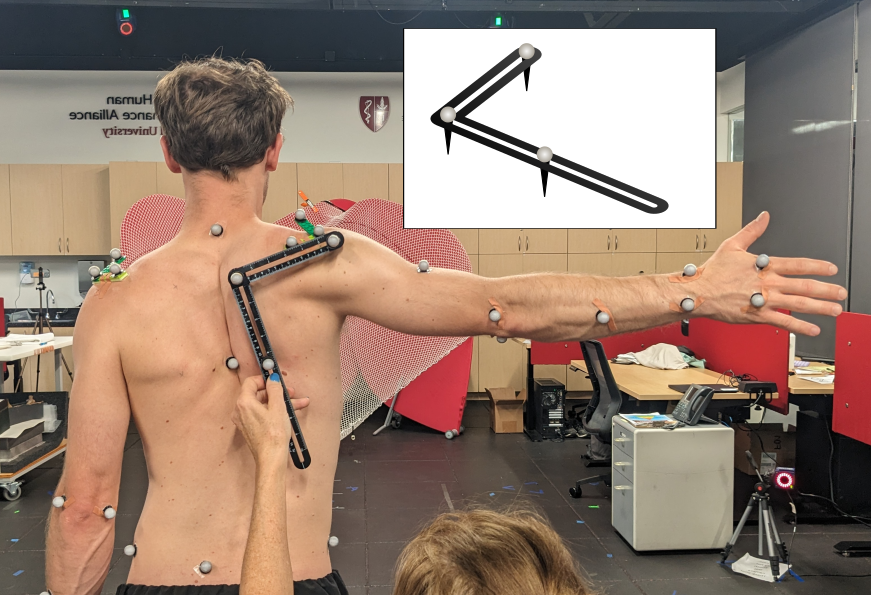

# Shoulder Model Scaling

The scaling process entails an OpenSim scaling, a correction of the humerus scale factors using SCoRE [4, 5], and a correction of the position of the tracking markers on the upper arm and forearm. In case you would like to use your own model and scaling process, you can skip this part and upload the scaled model with generic shoulder constraints.

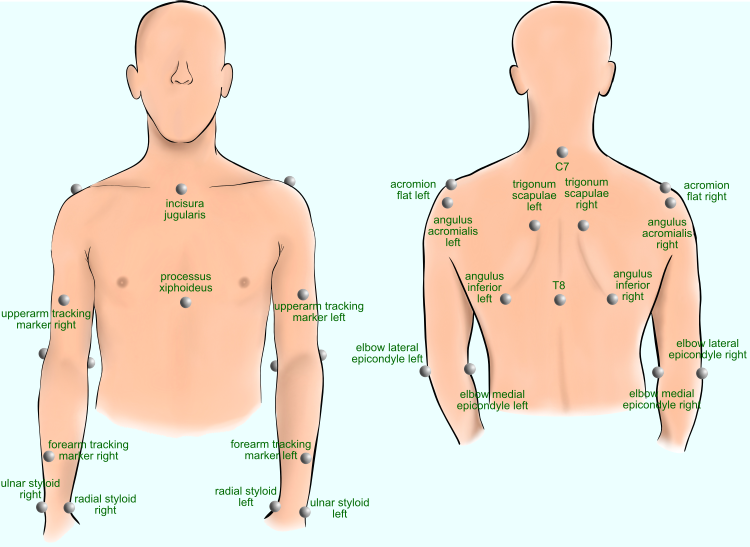

First, let's pre-compute the scaling for the humerus. If we only use the experimental marker data of a single neutral pose, we often overestimate the humerus lengths which will lead to problems when we use the model. Therefore, we compute the scaling factor by estimating the glenohumeral rotation center in all five calibration poses using the SCoRE method [4, 5] and calculating the mean scaling factor.


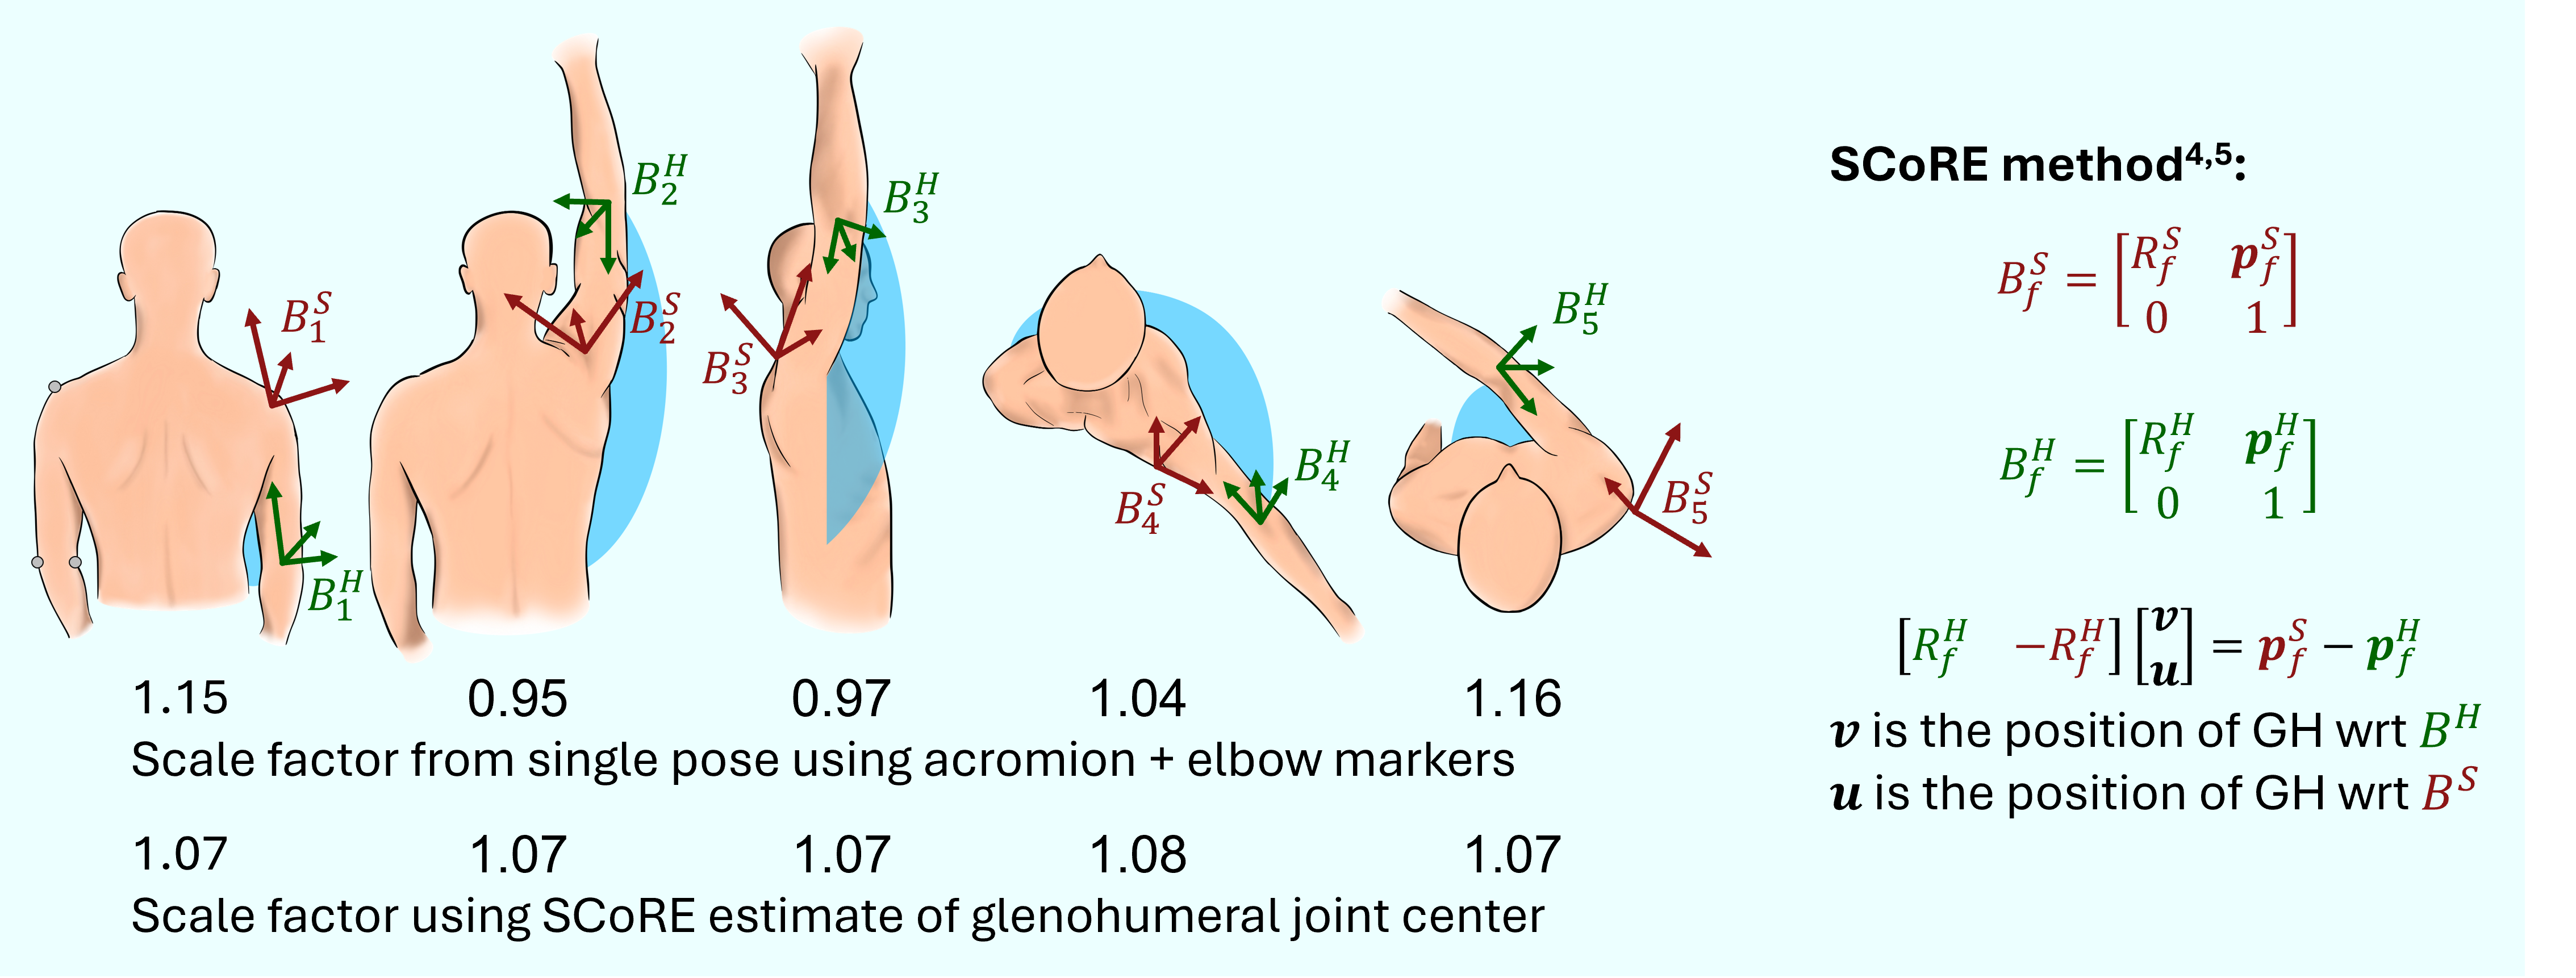

In [ ]:
# right arm: use calibaration files to calibrate glenohumeral joint center computation
[u_humerus_right, v_scapula_right] = score.calibrate_score(folder_trc, filenames_calibration_right, 'right', marker_names,
                                                           move_scapula_markers_to_skin, scapula_distance, marker_names_scapula_tool)
# right arm: pre-compute humerus scale factor using calibration files
humerus_scale_factor_r = score.compute_humerus_scale_factor(path_model_input, folder_trc, filenames_calibration_right,
                                                            'right', u_humerus_right, marker_names,
                                                            move_scapula_markers_to_skin, scapula_distance,
                                                            marker_names_scapula_tool)

# left arm: use calibaration files to calibrate glenohumeral joint center computation
[u_humerus_left, v_scapula_left] = score.calibrate_score(folder_trc, filenames_calibration_left, 'left', marker_names,
                                                        move_scapula_markers_to_skin, scapula_distance, marker_names_scapula_tool)
# left arm: pre-compute humerus scale factor using calibration files
humerus_scale_factor_l = score.compute_humerus_scale_factor(path_model_input, folder_trc, filenames_calibration_left,
                                                            'left', u_humerus_left, marker_names,
                                                            move_scapula_markers_to_skin, scapula_distance,
                                                            marker_names_scapula_tool)

humerus_scale_factors = {'r': humerus_scale_factor_r, 'l': humerus_scale_factor_l}

# print resulting scale factors:
print("right humerus scale factor long axis = " + str(humerus_scale_factor_r[1]))
print("left humerus scale factor long axis = " + str(humerus_scale_factor_l[1]))

The next bit of code uses the OpenSim Scale Tool to scale the provided model with the settings stored in the scale setup file you provided, and the manual scale factors for the humeri we just computed.

In [ ]:
scaling.scale_model(path_scale_setup_in, path_model_input, path_scalingfile, path_model_scaled, humerus_scale_factors, time_range)
print("Scaled model saved to " + filename_model_scaled + ".")

Because some of the bones were scaled anisotropically, we should update the joint coordinate frames after scaling.


In [ ]:
cs.update_isb_coords(path_model_scaled)
print("Coordinate systems updated and model saved to " + filename_model_scaled + ".")

Finally, because of the constrained shoulders and the way the marker placer poses the model, the tracking markers on the upper arm and forearm might be moved too high or too low. The last bit of code defines the upper arm and forearm coordinate systems in the posed model and in the measured marker data, and uses them to correct the tracking marker positions.

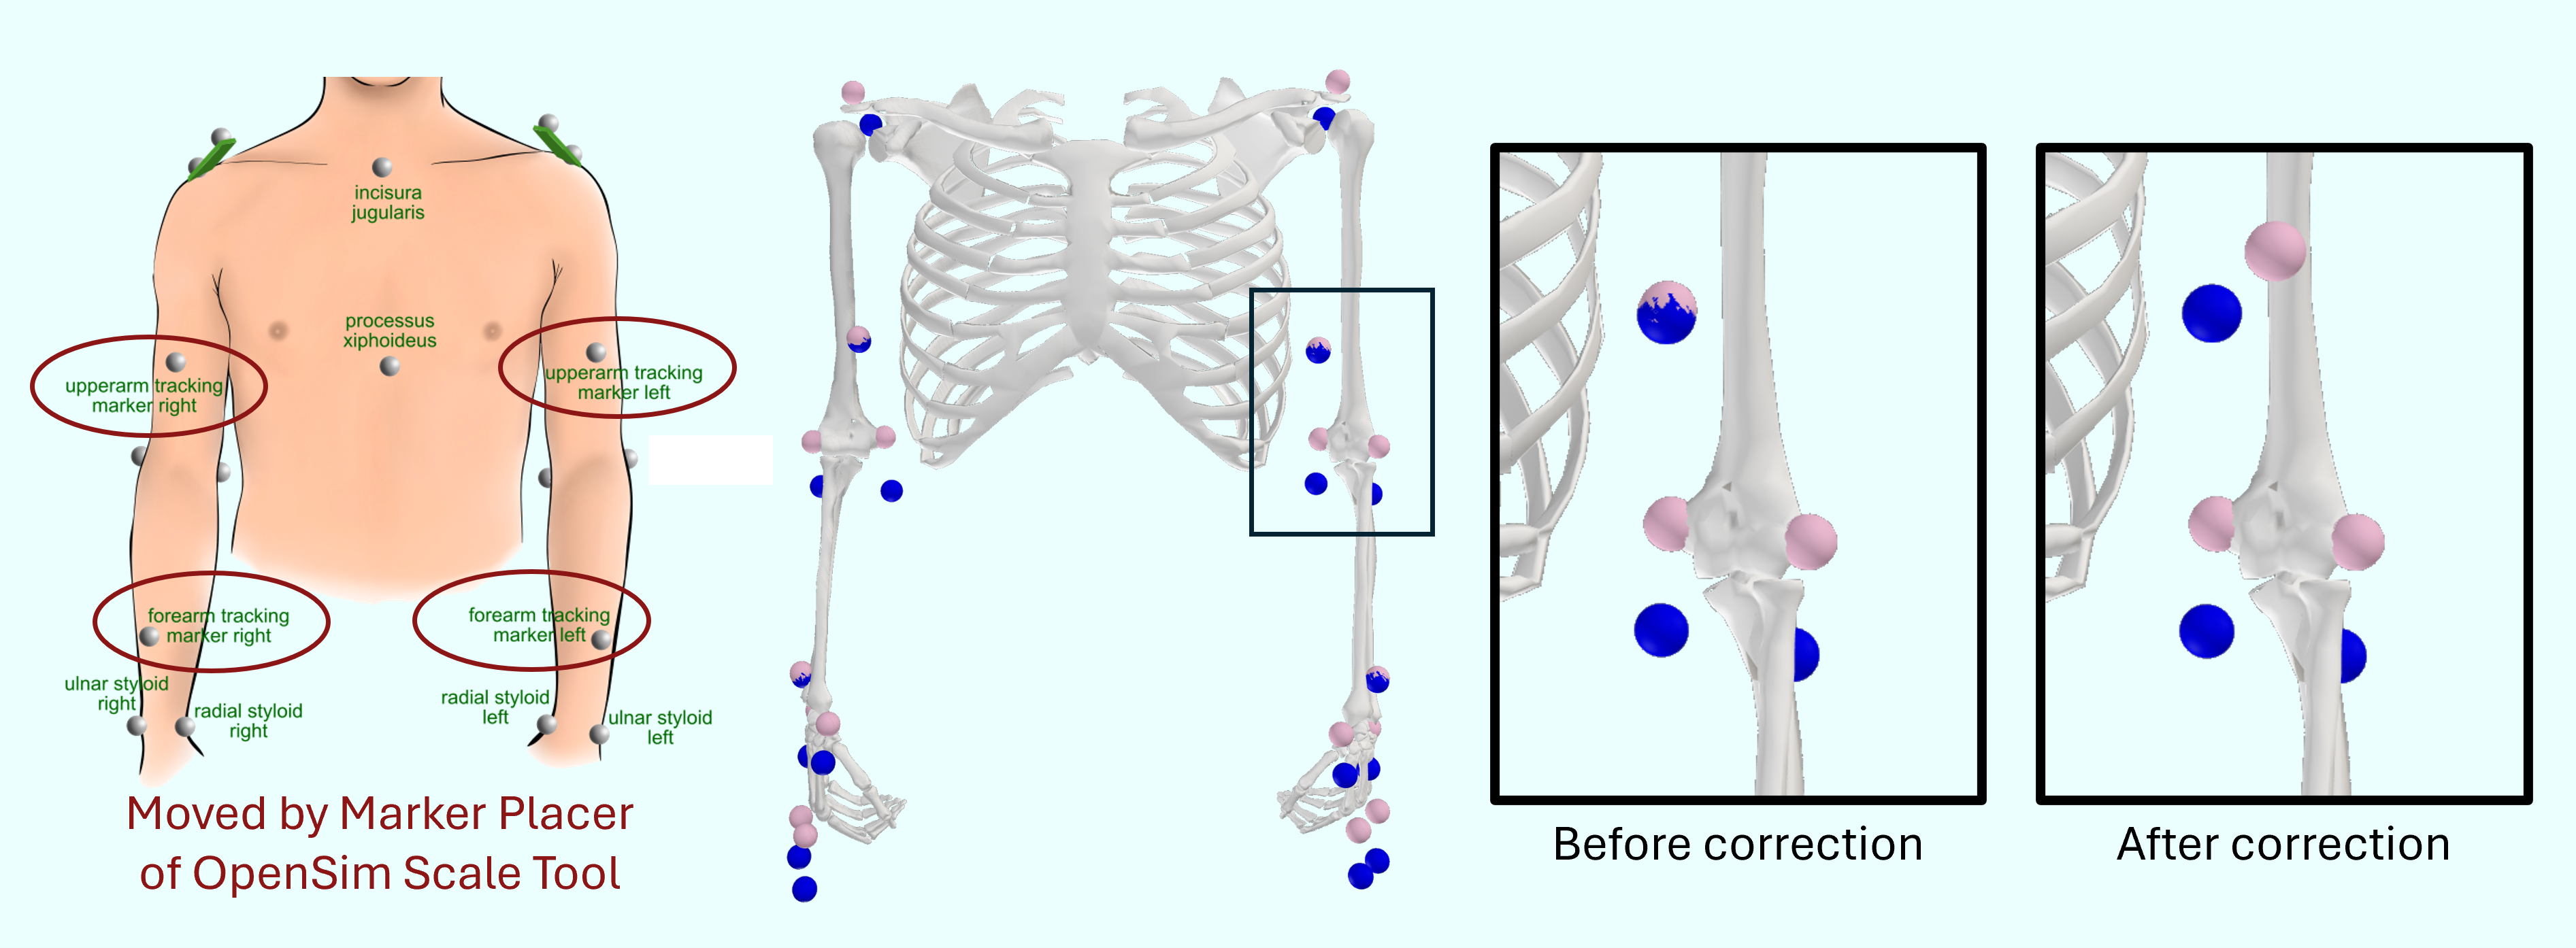

In [ ]:
mot_scaling_ISB = path_model_scaled.replace('.osim', '_scale.mot')
scaling.correct_tracking_markers(path_model_scaled, path_scalingfile, mot_scaling_ISB, marker_names)
print("Tracking markers updated and model saved to " + filename_model_scaled + ".")

In [ ]:
# @title Download the Scaled Model { display-mode: "form" }
# @markdown We created the scaled model! If you want to, you can download it by executing this cell and clicking on the download button that will appear.

import ipywidgets as widgets
from IPython.display import display
from google.colab import files
layout = widgets.Layout(width='250px')
button1 = widgets.Button(description="Download the scaled model file!", layout=layout)
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    files.download('model_scaled.osim')

button1.on_click(on_button_clicked)
display(button1, output)

# Shoulder Rhythm Personalization

In the shoulder rhythm personalization process, the scaled model and five calibration measurements are used to compute and update the bilinear constraint parameters for the sternoclavicular joint and the acromioclavicular joint.

First, we need to load the model and define the names of the coordinate coupler constraints in the model that will be personalized:


In [ ]:
# Load OpenSim scaled model
model = osim.Model(path_model_scaled)
model.initSystem()

# name of model = mode for fitting
model.setName(model_personalized_name)

# constraint names
constraints = ['sternoclavicular_r2_con_',
               'sternoclavicular_r3_con_',
               'acromioclavicular_r1_con_',
               'acromioclavicular_r2_con_',
               'acromioclavicular_r3_con_']

print('Loaded model '+ path_model_scaled + '!')

This next bit of code uses the marker data in the five calibration poses and the scaled model's coordinate system definitions to compute the joint angles in the sternoclavicular joint, the acromioclavicular joint, and the glenohumeral joint in each calibration pose.

In [ ]:
coordinates = personalization.compute_constraint_angles(path_model_scaled, folder_trc, filenames_calibration_right,
                                                        'right', u_humerus_right, v_scapula_right, marker_names,
                                                        move_scapula_markers_to_skin, scapula_distance,
                                                        marker_names_scapula_tool)
import math
print('\t'.join(['clav prot','clav elev','scap tilt','scap prot','scap up rot','gh elv plane','gh elev']))
print('\n'.join(['\t\t'.join(['{:6.2f}'.format(math.degrees(item)) for item in row])
      for row in coordinates]))

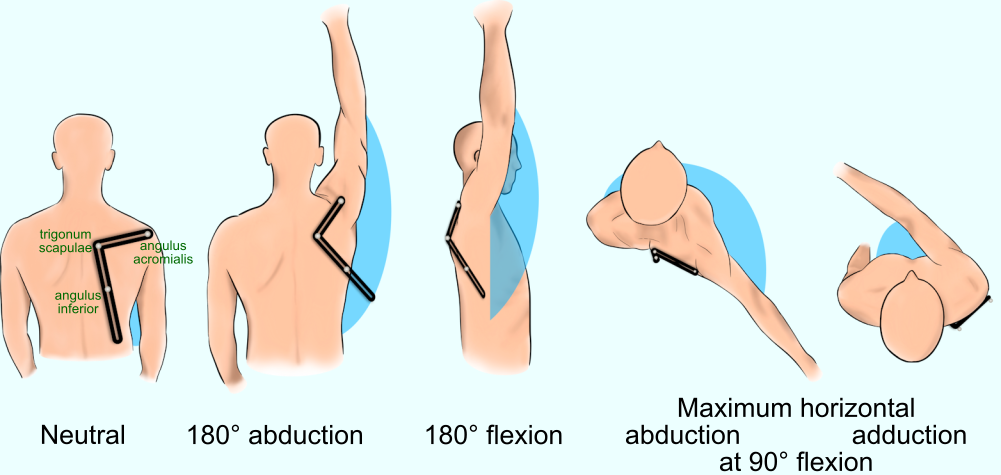

Finally, we use the joint angles we computed to fit a bilinear plane for each of the constraints. We then set the slopes and intercept of these planes to be the parameters of the bilinear function that describes each constraint.

In [ ]:
print('s1\ts2\tc')
for i, constraint in enumerate(constraints):
    # get constraint and pointer to linear function
    con = osim.CoordinateCouplerConstraint.safeDownCast(model.getConstraintSet().get(constraint + 'r'))
    lf = osim.LinearFunction.safeDownCast(con.getFunction())

    # fit bilinear plane (coordinate 5 and 6 are the independent coordinates, the glenohumeral elevation and elevation plane)
    ad = tools.fit_bilinear_function(coordinates[:, 5], coordinates[:, 6], coordinates[:, i])
    print('%.3f\t%.3f\t%.3f' % (ad.get(0), ad.get(1), ad.get(2)))

    # update constraint coefficients
    lf.setCoefficients(ad)

Let's perform the same steps for the left shoulder.

In [ ]:
# compute coordinate angles for all trials
coordinates = personalization.compute_constraint_angles(path_model_scaled, folder_trc, filenames_calibration_left,
                                                        'left', u_humerus_left, v_scapula_left, marker_names,
                                                        move_scapula_markers_to_skin, scapula_distance,
                                                        marker_names_scapula_tool)
import math
print('\t'.join(['clav prot','clav elev','scap tilt','scap prot','scap up rot','gh elv plane','gh elev']))
print('\n'.join(['\t\t'.join(['{:6.2f}'.format(math.degrees(item)) for item in row])
      for row in coordinates]))

print('s1\ts2\tc')
# fit bilinear surface to all data points per constraint and update constraint slopes
for i, constraint in enumerate(constraints):
    # get constraint and pointer to linear function
    con = osim.CoordinateCouplerConstraint.safeDownCast(model.getConstraintSet().get(constraint + 'l'))
    lf = osim.LinearFunction.safeDownCast(con.getFunction())

    # fit bilinear plane (coordinate 5 and 6 are the independent coordinates, the glenohumeral elevation and elevation plane)
    ad = tools.fit_bilinear_function(coordinates[:, 5], coordinates[:, 6], coordinates[:, i])
    print('%.3f\t%.3f\t%.3f' % (ad.get(0), ad.get(1), ad.get(2)))

    # update constraint coefficients
    lf.setCoefficients(ad)

Let's save the personalized model!

In [ ]:
model.printToXML(path_model_personalized)
print("Personalized model saved to " + filename_model_personalized + ".")

In [ ]:
# @title Download the Personalized Model { display-mode: "form" }
# @markdown We have created the personalized model! If you do not need a model with independent clavicle elevation, you are done. Execute this cell and click on the button that will appear to download the personalized model .osim file to your computer.

import ipywidgets as widgets
from IPython.display import display
from google.colab import files
layout = widgets.Layout(width='250px')
button2 = widgets.Button(description="Download the personalized model file!", layout=layout)
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    files.download('model_scaled_personalized.osim')

button2.on_click(on_button_clicked)
display(button2, output)

If you would like to also create a model in which the sternoclavicular elevation constraint is disabled in order to allow for clavicle elevation independent of the glenohumeral joint angles, run this next bit of code. It will disable the constraint and add a virtual marker to the model at the location of the acromioclavicular joint center.

In [ ]:
personalization.unconstrain_clav_elev_add_ac_marker(path_model_personalized, path_model_personalized_clavicle)
print("Personalized model with independent clavicle elevation saved to " + filename_model_personalized_clavicle + ".")

In [ ]:
# @title Download the Personalized Model with independent clavicle elevation { display-mode: "form" }
# @markdown We created the personalized model with independent clavicle elevation! Execute this cell and click on the button that will appear to download the personalized model .osim file to your computer.

import ipywidgets as widgets
from IPython.display import display
from google.colab import files
layout = widgets.Layout(width='450px')
button3 = widgets.Button(description="Download the personalized model file with independent clavicle elevation!", layout=layout)
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    files.download('model_scaled_personalized_clavicle.osim')

button3.on_click(on_button_clicked)
display(button3, output)

# References
[1] Holzbaur, K.R., Murray, W.M., Delp, S.L., 2005. A model of the upper extremity for simulating musculoskeletal surgery and analyzing neuromuscular control. Annals of Biomedical Engineering 33, 829–840.

[2] Saul, K.R., Hu, X., Goehler, C.M., Vidt, M.E., Daly, M., Velisar, A., Murray, W.M., 2015. Benchmarking of dynamic simulation predictions in two software platforms using an upper limb musculoskeletal model. Computer methods in biomechanics and biomedical engineering 18, 1445.

[3] McFarland, D. C., McCain, E. M., Poppo, M. N., and Saul, K. R., 2019. Spatial Dependency of Glenohumeral Joint Stability During Dynamic Unimanual and Bimanual Pushing and Pulling. J Biomech Eng 141(5), 051006.

[4] Ehrig, R. M., Taylor, W. R., Duda, G. N., Heller, M. O., 2006. A survey of formal methods for determining the centre of rotation of ball joints. Journal of Biomechanics 39(15), 2798-2809.

[5] Monnet, T., Desailly, E., Begon, M., Vallee, C., Lacouture, P., 2007. Comparison of the score and ha methods for locating in vivo the glenohumeral joint centre. Journal of Biomechanics 40, 3487–3492.